In [1]:
#Trying to replicate the results of "Adaptive activation functions accelerate convergence in deep and physics-informed neural networks"
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


cuda:1


In [2]:
def true_smooth(x): #[-3,3]
    term1 = (np.power(x,3) - x)
    term2 = np.sin(7*x)/7  
    
    term3 = np.sin(12*x)
    term12 = np.multiply(term1,term2)

    return term12  + term3

In [3]:
# Domain bounds
label = "Regr_smooth_unscaled_tanh"
loss_thresh = 0.1

lb = np.array(-3.0)  # [-1. 0.]
ub = np.array(3.0) # [1.  0.99]

x_test = np.linspace(lb,ub,1000).reshape(-1,1)
u_true = true_smooth(x_test)

u_true_norm = np.linalg.norm(u_true,2)

In [4]:
def trainingdata(N_train,seed):
    np.random.seed(seed)
    
    x_train = np.random.uniform(low=lb, high=ub, size=(N_train,)).reshape(-1,1)

    u_train = true_smooth(x_train)

    return x_train, u_train

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
     
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

            
            
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z) 
    
        a = self.linears[-1](a) 
        
        return a
    
    
    def loss(self,x,u):

        loss_val = self.loss_function(self.forward(x),u)
        
        return loss_val
        
    'test neural network'
    def test(self):
        u_pred = self.forward(x_test_tensor)       
        u_pred = u_pred.cpu().detach().numpy()
        
        return u_pred
    
    def test_loss(self):
        u_pred = self.test()
        
        test_mse_loss = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re_loss = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse_loss, test_re_loss  

In [6]:
def data_update(loss_np):
    train_loss.append(loss_np)
    test_mse, test_re = model_NN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [7]:
def train_step():
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    loss = model_NN.loss(x_train,u_train)
    loss.backward() #backprop
    optimizer.step()
    
    return loss

In [8]:
def train_model(max_iter,rep):
    print(rep) 
   
    torch.manual_seed(rep*123)
    start_time = time.time()
    thresh_flag = 0
    
    for i in range(max_iter):
        loss_np = train_step().cpu().detach().numpy()
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1            
                thresh_flag = 1
                
        data_update(loss_np)
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])
    
    elapsed_time[rep] = time.time() - start_time
    print('Training time: %.2f' % (elapsed_time[rep]))

In [9]:
max_reps = 10
max_iter = 5000
layers = np.array([1,50,50,50,50,1])

train_loss_full = []
test_mse_full = []
test_re_full = []

elapsed_time= np.zeros((max_reps,1))

time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))


for reps in range(max_reps):
    
    train_loss = []
    test_mse_loss = []
    test_re_loss = []

    'Generate Training data'
    N_train = 300
    
    x_train_np_array, u_train_np_array = trainingdata(N_train,reps*1234)

    'Convert to tensor and send to GPU'
    x_train = torch.from_numpy(x_train_np_array).float().to(device)
    u_train = torch.from_numpy(u_train_np_array).float().to(device)
    
    x_test_tensor = torch.from_numpy(x_test).float().to(device)
       
     
    model_NN = Sequentialmodel(layers)
    model_NN.to(device)
    print(model_NN)
    params = list(model_NN.parameters())
    #optimizer = optim.Adam(PINN.parameters(), lr=0.0008,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    optimizer = optim.Adam(model_NN.parameters(), lr=0.0008)

    train_model(max_iter,reps)
 
    torch.save(model_NN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)

                 

mdic = {"train_loss": train_loss_full,"test_mse": test_mse_full, "test_re": test_re_full,"Time": elapsed_time, "Thresh_time": time_threshold, "epoch_thresh": epoch_threshold, "label": label}
savemat(label+'.mat', mdic) 

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 1.415887 Test MSE 1.403928719950913 Test RE 1.0003324182342206
1 Train Loss 1.4048911 Test MSE 1.422740837383722 Test RE 1.0070121555073086
2 Train Loss 1.4090166 Test MSE 1.4260444797848744 Test RE 1.008180632215291
3 Train Loss 1.4102477 Test MSE 1.4180424520226285 Test RE 1.0053480281996499
4 Train Loss 1.4071009 Test MSE 1.4080383585035254 Test RE 1.0017954556848696
5 Train Loss 1.4045612 Test MSE 1.4008111261443568 Test RE 0.9992211212872181
6 Train Loss 1.4046034 Test MSE 1.3972449624174934 Test RE 0.997948409768053
7 Train Loss 1.4059919 Test MSE 1.3962175220491493 Test RE 

110 Train Loss 1.2243043 Test MSE 1.324793464372131 Test RE 0.971730653031154
111 Train Loss 1.2225404 Test MSE 1.3161112042305894 Test RE 0.9685412174478416
112 Train Loss 1.2200332 Test MSE 1.311028921081643 Test RE 0.966669353594436
113 Train Loss 1.2187644 Test MSE 1.317394951428762 Test RE 0.9690134644058659
114 Train Loss 1.2172247 Test MSE 1.3098329416459968 Test RE 0.9662283334021707
115 Train Loss 1.2149862 Test MSE 1.306603516120191 Test RE 0.965036468374293
116 Train Loss 1.213538 Test MSE 1.3130164163034446 Test RE 0.9674018023973765
117 Train Loss 1.2120156 Test MSE 1.3055927887149523 Test RE 0.9646631426119656
118 Train Loss 1.2097062 Test MSE 1.3052852033166318 Test RE 0.9645495031305431
119 Train Loss 1.2077138 Test MSE 1.310549334670992 Test RE 0.9664925291616198
120 Train Loss 1.2060403 Test MSE 1.3035100032939142 Test RE 0.963893381821981
121 Train Loss 1.2038238 Test MSE 1.3065577656362752 Test RE 0.9650195729383896
122 Train Loss 1.201437 Test MSE 1.308639761594198

222 Train Loss 0.9028418 Test MSE 1.0074509583048836 Test RE 0.8473908521777478
223 Train Loss 0.90184784 Test MSE 1.0091510799640733 Test RE 0.8481055570689293
224 Train Loss 0.9008799 Test MSE 1.0104587547927657 Test RE 0.8486548738478934
225 Train Loss 0.90040976 Test MSE 1.0045346432365612 Test RE 0.8461634724722581
226 Train Loss 0.89999515 Test MSE 1.0092961567204255 Test RE 0.8481665172085534
227 Train Loss 0.8992308 Test MSE 1.0050776349763308 Test RE 0.846392134423716
228 Train Loss 0.8983993 Test MSE 1.003864969700854 Test RE 0.8458813777930797
229 Train Loss 0.89786875 Test MSE 1.007080548850761 Test RE 0.8472350577755942
230 Train Loss 0.8975037 Test MSE 1.0013489720931235 Test RE 0.8448206919608947
231 Train Loss 0.8969854 Test MSE 1.0047192366366389 Test RE 0.8462412144488334
232 Train Loss 0.896306 Test MSE 1.0022203278121118 Test RE 0.8451881858555474
233 Train Loss 0.8957013 Test MSE 1.0005220248694555 Test RE 0.8444717794233513
234 Train Loss 0.8952828 Test MSE 1.0033

337 Train Loss 0.8800585 Test MSE 0.9856952553545845 Test RE 0.8381912970664684
338 Train Loss 0.8800994 Test MSE 0.9814451708012297 Test RE 0.8363823037670437
339 Train Loss 0.880246 Test MSE 0.986893512281001 Test RE 0.8387006144584577
340 Train Loss 0.880175 Test MSE 0.9823389067683568 Test RE 0.836763035605778
341 Train Loss 0.8799219 Test MSE 0.9837184549835813 Test RE 0.8373503837953643
342 Train Loss 0.87976384 Test MSE 0.985333943469917 Test RE 0.8380376612275107
343 Train Loss 0.8797979 Test MSE 0.9815998508842051 Test RE 0.8364482099383763
344 Train Loss 0.87985355 Test MSE 0.9859051086278309 Test RE 0.8382805172515433
345 Train Loss 0.8797689 Test MSE 0.9823979890394063 Test RE 0.8367881985698027
346 Train Loss 0.8795911 Test MSE 0.983460518857768 Test RE 0.8372405977724079
347 Train Loss 0.8794748 Test MSE 0.9846355153146867 Test RE 0.8377405980548392
348 Train Loss 0.8794692 Test MSE 0.9817383137702389 Test RE 0.8365072018733837
349 Train Loss 0.87948304 Test MSE 0.9851977

446 Train Loss 0.87359416 Test MSE 0.9793778524414996 Test RE 0.8355009606046884
447 Train Loss 0.87354696 Test MSE 0.9774204509629424 Test RE 0.8346656196945322
448 Train Loss 0.87349397 Test MSE 0.9794326690281632 Test RE 0.8355243421166667
449 Train Loss 0.8734307 Test MSE 0.9773877734367675 Test RE 0.8346516671342101
450 Train Loss 0.8733586 Test MSE 0.9790062830908757 Test RE 0.8353424538549582
451 Train Loss 0.8732819 Test MSE 0.9776600452657745 Test RE 0.8347679138880135
452 Train Loss 0.8732056 Test MSE 0.978383314415734 Test RE 0.8350766358504786
453 Train Loss 0.87313294 Test MSE 0.9780230734161781 Test RE 0.8349228839753262
454 Train Loss 0.8730648 Test MSE 0.9777966802663389 Test RE 0.8348262442504397
455 Train Loss 0.87300074 Test MSE 0.9783238967993816 Test RE 0.8350512781937199
456 Train Loss 0.8729393 Test MSE 0.9773382881815565 Test RE 0.8346305376118806
457 Train Loss 0.87287897 Test MSE 0.9785118787170245 Test RE 0.8351315006033428
458 Train Loss 0.87281895 Test MSE 

554 Train Loss 0.86868614 Test MSE 0.9809148808394341 Test RE 0.8361563181082585
555 Train Loss 0.8678886 Test MSE 0.9674650249557369 Test RE 0.8304040355191376
556 Train Loss 0.86623234 Test MSE 0.9704303143741374 Test RE 0.8316756599764756
557 Train Loss 0.86552453 Test MSE 0.9761322823013702 Test RE 0.8341154242375867
558 Train Loss 0.8661804 Test MSE 0.9658434815574914 Test RE 0.8297078341868005
559 Train Loss 0.8669541 Test MSE 0.9784520840529797 Test RE 0.8351059837079958
560 Train Loss 0.8666901 Test MSE 0.9675410184976563 Test RE 0.8304366486385201
561 Train Loss 0.86567384 Test MSE 0.97078870425733 Test RE 0.8318292189820845
562 Train Loss 0.86507857 Test MSE 0.9741422698803424 Test RE 0.8332647470569263
563 Train Loss 0.8653596 Test MSE 0.9664166937855314 Test RE 0.8299540066470746
564 Train Loss 0.86583346 Test MSE 0.9763220184947582 Test RE 0.8341964860969779
565 Train Loss 0.86572105 Test MSE 0.9675271823318324 Test RE 0.8304307108539531
566 Train Loss 0.8650924 Test MSE 0

670 Train Loss 0.84628046 Test MSE 0.9518670404295293 Test RE 0.8236827270491354
671 Train Loss 0.8459004 Test MSE 0.951358898756773 Test RE 0.8234628416161403
672 Train Loss 0.8455312 Test MSE 0.9520699122256456 Test RE 0.8237704982842393
673 Train Loss 0.8451676 Test MSE 0.9498738029246526 Test RE 0.822819867202715
674 Train Loss 0.84480214 Test MSE 0.9519412195506839 Test RE 0.8237148212744158
675 Train Loss 0.84442854 Test MSE 0.9486890819226999 Test RE 0.8223065800058141
676 Train Loss 0.8440439 Test MSE 0.9514813485824352 Test RE 0.8235158340447465
677 Train Loss 0.84364665 Test MSE 0.9476784098525068 Test RE 0.8218684471271297
678 Train Loss 0.8432382 Test MSE 0.9508228933379692 Test RE 0.8232308352024859
679 Train Loss 0.8428198 Test MSE 0.9466830138420078 Test RE 0.8214367081020432
680 Train Loss 0.842394 Test MSE 0.9501462489841697 Test RE 0.8229378607496133
681 Train Loss 0.8419631 Test MSE 0.945563749966935 Test RE 0.8209509719403851
682 Train Loss 0.8415311 Test MSE 0.9496

782 Train Loss 0.7713472 Test MSE 0.8760402373900351 Test RE 0.7901942066480719
783 Train Loss 0.7702129 Test MSE 0.8790625281017859 Test RE 0.7915560963581743
784 Train Loss 0.7690937 Test MSE 0.8822174105713612 Test RE 0.7929752387760971
785 Train Loss 0.7688018 Test MSE 0.8737298098667377 Test RE 0.7891515080933796
786 Train Loss 0.7684435 Test MSE 0.8804739506653867 Test RE 0.7921913026186068
787 Train Loss 0.7674307 Test MSE 0.8767663405067406 Test RE 0.790521613775461
788 Train Loss 0.7665262 Test MSE 0.8732369166818045 Test RE 0.7889288864843291
789 Train Loss 0.76615584 Test MSE 0.8796273636128124 Test RE 0.7918103599519913
790 Train Loss 0.76569676 Test MSE 0.8724880770639794 Test RE 0.7885905430724763
791 Train Loss 0.7648235 Test MSE 0.8740328871583296 Test RE 0.7892883657132111
792 Train Loss 0.76403147 Test MSE 0.876174435061723 Test RE 0.7902547279331884
793 Train Loss 0.76358926 Test MSE 0.8701628561087497 Test RE 0.7875390269409958
794 Train Loss 0.7631055 Test MSE 0.87

904 Train Loss 0.72079676 Test MSE 0.8307569505937125 Test RE 0.7695003221185371
905 Train Loss 0.7205623 Test MSE 0.8304899623293259 Test RE 0.7693766613627576
906 Train Loss 0.7203288 Test MSE 0.8302499922184937 Test RE 0.7692654976220591
907 Train Loss 0.7200965 Test MSE 0.8299746791792272 Test RE 0.769137941834959
908 Train Loss 0.71986544 Test MSE 0.8297452160111679 Test RE 0.7690316126701106
909 Train Loss 0.7196353 Test MSE 0.829463015312952 Test RE 0.7689008257071288
910 Train Loss 0.71940625 Test MSE 0.8292433023708459 Test RE 0.7687989835223366
911 Train Loss 0.7191782 Test MSE 0.828953479652532 Test RE 0.7686646231466479
912 Train Loss 0.7189512 Test MSE 0.8287447892956233 Test RE 0.7685678607855464
913 Train Loss 0.7187251 Test MSE 0.8284448453077589 Test RE 0.7684287659916499
914 Train Loss 0.7184999 Test MSE 0.8282503938544924 Test RE 0.7683385784189998
915 Train Loss 0.71827555 Test MSE 0.8279355090015492 Test RE 0.7681925107675365
916 Train Loss 0.7180521 Test MSE 0.827

1018 Train Loss 0.6977927 Test MSE 0.8034897515496312 Test RE 0.7567666503691277
1019 Train Loss 0.697576 Test MSE 0.8025710109998734 Test RE 0.7563338688240626
1020 Train Loss 0.69735813 Test MSE 0.8030011723376035 Test RE 0.7565365312685007
1021 Train Loss 0.6971372 Test MSE 0.8021084696120365 Test RE 0.7561158905194529
1022 Train Loss 0.6969139 Test MSE 0.8021588292148786 Test RE 0.7561396261485746
1023 Train Loss 0.6966893 Test MSE 0.8018471164999774 Test RE 0.7559926968689772
1024 Train Loss 0.69646496 Test MSE 0.801278757438887 Test RE 0.7557247209310981
1025 Train Loss 0.6962404 Test MSE 0.8014602539067366 Test RE 0.755810305130147
1026 Train Loss 0.69601464 Test MSE 0.8006204175067787 Test RE 0.7554142010329489
1027 Train Loss 0.69578654 Test MSE 0.8007923074807477 Test RE 0.7554952888717006
1028 Train Loss 0.6955564 Test MSE 0.8001853680379197 Test RE 0.7552089307218389
1029 Train Loss 0.69532496 Test MSE 0.7999615013892859 Test RE 0.7551032815025527
1030 Train Loss 0.69509286

1131 Train Loss 0.6650398 Test MSE 0.7624371345098768 Test RE 0.7371804927927462
1132 Train Loss 0.6649629 Test MSE 0.7541905712149803 Test RE 0.7331829610095251
1133 Train Loss 0.6649306 Test MSE 0.7607787015730118 Test RE 0.7363783086514493
1134 Train Loss 0.66416687 Test MSE 0.7586989141878604 Test RE 0.7353710785312209
1135 Train Loss 0.6636774 Test MSE 0.7535967043767914 Test RE 0.7328942416786346
1136 Train Loss 0.663665 Test MSE 0.7603293607942059 Test RE 0.7361608119771201
1137 Train Loss 0.66325235 Test MSE 0.7552126104112176 Test RE 0.7336795782158054
1138 Train Loss 0.66260344 Test MSE 0.7534282509187147 Test RE 0.7328123242095664
1139 Train Loss 0.6623549 Test MSE 0.7586778392638311 Test RE 0.7353608649952917
1140 Train Loss 0.6621697 Test MSE 0.7524397714009176 Test RE 0.7323314504721461
1141 Train Loss 0.6616415 Test MSE 0.7537393308301661 Test RE 0.7329635925398994
1142 Train Loss 0.66115874 Test MSE 0.7561997154813914 Test RE 0.7341589017383947
1143 Train Loss 0.6609438

1237 Train Loss 0.6188945 Test MSE 0.7139079260499082 Test RE 0.7133339860837451
1238 Train Loss 0.6215712 Test MSE 0.6799609171887947 Test RE 0.6961675720953252
1239 Train Loss 0.627705 Test MSE 0.7426599637189321 Test RE 0.727556659418127
1240 Train Loss 0.63682634 Test MSE 0.6838744396305558 Test RE 0.6981680977235536
1241 Train Loss 0.6468796 Test MSE 0.7499246301404046 Test RE 0.7311064628282807
1242 Train Loss 0.6410633 Test MSE 0.677445988337018 Test RE 0.6948789437537315
1243 Train Loss 0.623148 Test MSE 0.68786587184814 Test RE 0.7002025620719395
1244 Train Loss 0.61180556 Test MSE 0.7144162915142133 Test RE 0.7135879192702705
1245 Train Loss 0.6199086 Test MSE 0.6761709630289875 Test RE 0.69422471778714
1246 Train Loss 0.62953836 Test MSE 0.7170231724142575 Test RE 0.7148886628572763
1247 Train Loss 0.6212513 Test MSE 0.6793042982015257 Test RE 0.6958313562598908
1248 Train Loss 0.6099489 Test MSE 0.6737507698716069 Test RE 0.6929811979292476
1249 Train Loss 0.6128913 Test MS

1346 Train Loss 0.53521407 Test MSE 0.5899565224277831 Test RE 0.6484579480175808
1347 Train Loss 0.5342513 Test MSE 0.5886685389664651 Test RE 0.6477497098429225
1348 Train Loss 0.5332853 Test MSE 0.587694458557635 Test RE 0.647213566417621
1349 Train Loss 0.53231615 Test MSE 0.58620685108874 Test RE 0.6463939144983334
1350 Train Loss 0.5313436 Test MSE 0.5853126227545158 Test RE 0.6459007060370254
1351 Train Loss 0.5303675 Test MSE 0.5838386636512494 Test RE 0.6450869260964782
1352 Train Loss 0.5293881 Test MSE 0.5828477917154525 Test RE 0.6445392833929873
1353 Train Loss 0.52840567 Test MSE 0.5815206798606798 Test RE 0.6438050752499446
1354 Train Loss 0.52742016 Test MSE 0.5803352195047347 Test RE 0.6431485252977145
1355 Train Loss 0.52643186 Test MSE 0.579177765803851 Test RE 0.6425068391117238
1356 Train Loss 0.5254407 Test MSE 0.57782427178629 Test RE 0.6417556553879686
1357 Train Loss 0.5244467 Test MSE 0.5767859250355162 Test RE 0.641178780579462
1358 Train Loss 0.52345 Test MS

1457 Train Loss 0.4305411 Test MSE 0.4598943030957689 Test RE 0.5725334024189384
1458 Train Loss 0.42974672 Test MSE 0.4601519601380499 Test RE 0.5726937616646712
1459 Train Loss 0.42894188 Test MSE 0.4579963000641335 Test RE 0.571350746285748
1460 Train Loss 0.42812482 Test MSE 0.4576361274354574 Test RE 0.5711260442806536
1461 Train Loss 0.4273113 Test MSE 0.456652531151846 Test RE 0.5705119541861977
1462 Train Loss 0.42651358 Test MSE 0.4550751853270514 Test RE 0.5695257852448128
1463 Train Loss 0.42572808 Test MSE 0.4549893083483929 Test RE 0.5694720452663385
1464 Train Loss 0.42494237 Test MSE 0.4530419161689955 Test RE 0.5682520445204544
1465 Train Loss 0.42415053 Test MSE 0.45275226835797444 Test RE 0.5680703623503762
1466 Train Loss 0.42335722 Test MSE 0.4515015105846388 Test RE 0.5672851539001933
1467 Train Loss 0.42257133 Test MSE 0.4503572144854014 Test RE 0.5665658273908755
1468 Train Loss 0.42179576 Test MSE 0.4499032157343498 Test RE 0.5662801818772126
1469 Train Loss 0.4

1573 Train Loss 0.36198652 Test MSE 0.3704282346302831 Test RE 0.5138352036588137
1574 Train Loss 0.36188403 Test MSE 0.37358056476091656 Test RE 0.5160169308684666
1575 Train Loss 0.36119685 Test MSE 0.3701988980157422 Test RE 0.513676118227545
1576 Train Loss 0.36034787 Test MSE 0.36995161411019567 Test RE 0.513504527959878
1577 Train Loss 0.35992417 Test MSE 0.37153219209670646 Test RE 0.5146003048999831
1578 Train Loss 0.3598781 Test MSE 0.36825811010917314 Test RE 0.5123278612997946
1579 Train Loss 0.3597168 Test MSE 0.37061892773157346 Test RE 0.5139674454970403
1580 Train Loss 0.35920477 Test MSE 0.36789036955767773 Test RE 0.5120719934949556
1581 Train Loss 0.3585595 Test MSE 0.36777217855194966 Test RE 0.5119897309914228
1582 Train Loss 0.35814288 Test MSE 0.36860307875654497 Test RE 0.5125677686825466
1583 Train Loss 0.35796985 Test MSE 0.36611191690929834 Test RE 0.5108327668715251
1584 Train Loss 0.3577652 Test MSE 0.36791424894672387 Test RE 0.512088612260958
1585 Train Lo

1677 Train Loss 0.33479616 Test MSE 0.3352917293442669 Test RE 0.4888585717552151
1678 Train Loss 0.33462468 Test MSE 0.33505373805399846 Test RE 0.488685044160049
1679 Train Loss 0.33445415 Test MSE 0.33481237016774096 Test RE 0.4885089916148917
1680 Train Loss 0.33428466 Test MSE 0.33458444170580653 Test RE 0.4883426834533195
1681 Train Loss 0.33411622 Test MSE 0.33434235426788217 Test RE 0.4881659821385212
1682 Train Loss 0.3339488 Test MSE 0.33411855828534026 Test RE 0.4880025749718612
1683 Train Loss 0.33378235 Test MSE 0.3338815634622644 Test RE 0.4878294708489731
1684 Train Loss 0.33361685 Test MSE 0.3336564523294646 Test RE 0.48766498982756973
1685 Train Loss 0.33345237 Test MSE 0.33342761114742925 Test RE 0.48749772650390083
1686 Train Loss 0.3332888 Test MSE 0.3332002024485008 Test RE 0.48733145333213085
1687 Train Loss 0.3331262 Test MSE 0.3329795039302197 Test RE 0.4871700321437118
1688 Train Loss 0.33296457 Test MSE 0.3327513386018719 Test RE 0.4870030934025685
1689 Train 

1785 Train Loss 0.31997672 Test MSE 0.31602704397632514 Test RE 0.47460678067033474
1786 Train Loss 0.31985652 Test MSE 0.31588709548081645 Test RE 0.4745016822916144
1787 Train Loss 0.31973633 Test MSE 0.31574894498998274 Test RE 0.4743979113398474
1788 Train Loss 0.3196163 Test MSE 0.3156099854471819 Test RE 0.4742935097693797
1789 Train Loss 0.3194962 Test MSE 0.315472496307634 Test RE 0.47419019030392473
1790 Train Loss 0.31937626 Test MSE 0.3153344064195225 Test RE 0.47408639672715464
1791 Train Loss 0.3192563 Test MSE 0.31519747773806267 Test RE 0.4739834535141963
1792 Train Loss 0.3191364 Test MSE 0.3150604713372224 Test RE 0.47388042948980946
1793 Train Loss 0.31901655 Test MSE 0.31492415498657966 Test RE 0.47377790212522286
1794 Train Loss 0.31889668 Test MSE 0.3147878984252362 Test RE 0.4736753975523317
1795 Train Loss 0.31877688 Test MSE 0.3146523778712039 Test RE 0.47357342466346924
1796 Train Loss 0.31865707 Test MSE 0.31451683631615157 Test RE 0.47347141400502296
1797 Tra

1894 Train Loss 0.30689058 Test MSE 0.3030704712236865 Test RE 0.4647759276115956
1895 Train Loss 0.30678686 Test MSE 0.3026185425714043 Test RE 0.46442926909449883
1896 Train Loss 0.30664775 Test MSE 0.30275699437713965 Test RE 0.4645354980741246
1897 Train Loss 0.30649257 Test MSE 0.30249686826504707 Test RE 0.46433589280960996
1898 Train Loss 0.30634788 Test MSE 0.30238767197433103 Test RE 0.4642520765141566
1899 Train Loss 0.30622807 Test MSE 0.30243529842453487 Test RE 0.46428863522654257
1900 Train Loss 0.30612573 Test MSE 0.30213224131437644 Test RE 0.4640559553123716
1901 Train Loss 0.30602157 Test MSE 0.30227028391012245 Test RE 0.46416195554082496
1902 Train Loss 0.305902 Test MSE 0.30194513627267966 Test RE 0.46391224232218375
1903 Train Loss 0.3057672 Test MSE 0.30198050002006976 Test RE 0.4639394081762558
1904 Train Loss 0.3056295 Test MSE 0.3018118284883364 Test RE 0.46380982315208685
1905 Train Loss 0.3055006 Test MSE 0.301684448650849 Test RE 0.4637119372355571
1906 Tra

2006 Train Loss 0.29276308 Test MSE 0.29184451554603247 Test RE 0.45608688319320007
2007 Train Loss 0.2926301 Test MSE 0.29174133795620016 Test RE 0.4560062544632398
2008 Train Loss 0.29249695 Test MSE 0.2916382195820137 Test RE 0.4559256577610784
2009 Train Loss 0.29236364 Test MSE 0.29153410232195975 Test RE 0.4558442658778908
2010 Train Loss 0.2922302 Test MSE 0.2914307562085031 Test RE 0.45576346245116484
2011 Train Loss 0.29209656 Test MSE 0.29132567759455885 Test RE 0.45568128974017447
2012 Train Loss 0.29196277 Test MSE 0.29122213893427523 Test RE 0.4556003067944708
2013 Train Loss 0.2918288 Test MSE 0.2911161587431111 Test RE 0.45551739929049195
2014 Train Loss 0.2916947 Test MSE 0.2910121421643294 Test RE 0.4554360132300577
2015 Train Loss 0.29156047 Test MSE 0.29090564630913757 Test RE 0.45535267223009984
2016 Train Loss 0.29142603 Test MSE 0.2908009733742932 Test RE 0.455270742935375
2017 Train Loss 0.29129148 Test MSE 0.2906938816101538 Test RE 0.4551869051200483
2018 Train

2117 Train Loss 0.27769217 Test MSE 0.27837654091113667 Test RE 0.4454388898431495
2118 Train Loss 0.2775197 Test MSE 0.2783925854396205 Test RE 0.44545172633065716
2119 Train Loss 0.27733436 Test MSE 0.278138927789514 Test RE 0.44524874321611907
2120 Train Loss 0.2771721 Test MSE 0.2780064614834031 Test RE 0.4451427036175693
2121 Train Loss 0.27704743 Test MSE 0.27799960853323896 Test RE 0.4451372171271708
2122 Train Loss 0.27694643 Test MSE 0.2777126372265524 Test RE 0.44490740638645376
2123 Train Loss 0.27684242 Test MSE 0.27780473136573264 Test RE 0.4449811696273269
2124 Train Loss 0.27671784 Test MSE 0.27743388532392455 Test RE 0.4446840641510877
2125 Train Loss 0.27657157 Test MSE 0.2774699491243273 Test RE 0.44471296558859996
2126 Train Loss 0.27641773 Test MSE 0.2772087366660713 Test RE 0.4445035881050762
2127 Train Loss 0.27627182 Test MSE 0.27709819433926397 Test RE 0.444414952081192
2128 Train Loss 0.27614254 Test MSE 0.27703807706611233 Test RE 0.4443667408967567
2129 Train

2220 Train Loss 0.26655006 Test MSE 0.2657150218826246 Test RE 0.435190962516244
2221 Train Loss 0.26647186 Test MSE 0.2656129357555856 Test RE 0.43510735559870123
2222 Train Loss 0.26639426 Test MSE 0.26551222712579287 Test RE 0.4350248610849853
2223 Train Loss 0.26631716 Test MSE 0.26541069947544205 Test RE 0.4349416798404335
2224 Train Loss 0.2662406 Test MSE 0.265311513341459 Test RE 0.4348604016270283
2225 Train Loss 0.2661646 Test MSE 0.26521077884167243 Test RE 0.43477783905119477
2226 Train Loss 0.26608914 Test MSE 0.265113064119038 Test RE 0.43469773651898447
2227 Train Loss 0.26601422 Test MSE 0.26501300082674323 Test RE 0.43461569342549866
2228 Train Loss 0.26593983 Test MSE 0.26491685025255324 Test RE 0.43453684382301566
2229 Train Loss 0.26586595 Test MSE 0.2648173965136755 Test RE 0.4344552703584911
2230 Train Loss 0.26579264 Test MSE 0.2647228926338343 Test RE 0.43437774264907986
2231 Train Loss 0.2657198 Test MSE 0.2646240825958281 Test RE 0.4342966675166548
2232 Train 

2332 Train Loss 0.260595 Test MSE 0.25750637369222207 Test RE 0.42841612201862295
2333 Train Loss 0.26055995 Test MSE 0.2574180089013462 Test RE 0.42834260898524107
2334 Train Loss 0.2605235 Test MSE 0.25739413089924845 Test RE 0.42832274207119697
2335 Train Loss 0.2604869 Test MSE 0.25732993046412667 Test RE 0.42826932161978154
2336 Train Loss 0.26045147 Test MSE 0.2572826655384883 Test RE 0.42822998875403556
2337 Train Loss 0.26041755 Test MSE 0.25724664093910304 Test RE 0.4282000074223959
2338 Train Loss 0.2603846 Test MSE 0.25717589139776387 Test RE 0.42814112028342655
2339 Train Loss 0.26035163 Test MSE 0.25715970632615015 Test RE 0.42812764778473444
2340 Train Loss 0.2603181 Test MSE 0.25707625130264816 Test RE 0.42805817286063147
2341 Train Loss 0.26028407 Test MSE 0.2570613528008518 Test RE 0.42804576891855906
2342 Train Loss 0.2602499 Test MSE 0.2569881980447368 Test RE 0.427984857755486
2343 Train Loss 0.26021624 Test MSE 0.25695432492315545 Test RE 0.42795665089428575
2344 T

2436 Train Loss 0.25779113 Test MSE 0.2535129170619563 Test RE 0.425081163345169
2437 Train Loss 0.2577705 Test MSE 0.2534839608657556 Test RE 0.42505688630791766
2438 Train Loss 0.25774994 Test MSE 0.2534550528359211 Test RE 0.4250326482704188
2439 Train Loss 0.25772947 Test MSE 0.2534261087404083 Test RE 0.42500837860865487
2440 Train Loss 0.25770912 Test MSE 0.253397573761542 Test RE 0.4249844506350069
2441 Train Loss 0.25768885 Test MSE 0.2533687801786887 Test RE 0.4249603044436155
2442 Train Loss 0.25766867 Test MSE 0.25334060174600487 Test RE 0.42493667278646274
2443 Train Loss 0.2576486 Test MSE 0.2533120115719635 Test RE 0.42491269448190067
2444 Train Loss 0.25762856 Test MSE 0.2532841389204843 Test RE 0.4248893166539428
2445 Train Loss 0.25760868 Test MSE 0.2532556788319185 Test RE 0.42486544479338867
2446 Train Loss 0.2575888 Test MSE 0.2532280608676303 Test RE 0.4248422780106059
2447 Train Loss 0.25756902 Test MSE 0.2531999697792099 Test RE 0.42481871306099656
2448 Train Los

2553 Train Loss 0.25589356 Test MSE 0.2508159053234057 Test RE 0.4228139921706641
2554 Train Loss 0.2558798 Test MSE 0.2507621316707196 Test RE 0.42276866515780714
2555 Train Loss 0.25586653 Test MSE 0.2507933864340515 Test RE 0.4227950110872754
2556 Train Loss 0.25585377 Test MSE 0.25073228486713633 Test RE 0.42274350452306636
2557 Train Loss 0.2558417 Test MSE 0.25074372530786143 Test RE 0.4227531489069969
2558 Train Loss 0.25583014 Test MSE 0.2507101238692987 Test RE 0.42272482199697914
2559 Train Loss 0.25581825 Test MSE 0.25070216493252123 Test RE 0.42271811212267774
2560 Train Loss 0.25580537 Test MSE 0.2506679385642402 Test RE 0.4226892559705461
2561 Train Loss 0.2557918 Test MSE 0.25067243623173924 Test RE 0.42269304805343455
2562 Train Loss 0.2557784 Test MSE 0.2506243342751708 Test RE 0.42265249046672626
2563 Train Loss 0.25576553 Test MSE 0.2506358290796263 Test RE 0.42266218276583944
2564 Train Loss 0.2557532 Test MSE 0.2505968265168149 Test RE 0.42262929530963583
2565 Trai

2683 Train Loss 0.25452164 Test MSE 0.2492641825967855 Test RE 0.4215040513412895
2684 Train Loss 0.25485164 Test MSE 0.24894327101136474 Test RE 0.42123263429205376
2685 Train Loss 0.25550428 Test MSE 0.2506926169771851 Test RE 0.4227100624672537
2686 Train Loss 0.25600842 Test MSE 0.24906225189296805 Test RE 0.4213332850205181
2687 Train Loss 0.25594252 Test MSE 0.2501726721809946 Test RE 0.42227147759971706
2688 Train Loss 0.2554476 Test MSE 0.24855868917073723 Test RE 0.4209071363670495
2689 Train Loss 0.2547998 Test MSE 0.2487791118071077 Test RE 0.4210937259030118
2690 Train Loss 0.254446 Test MSE 0.24898103536464455 Test RE 0.4212645832873129
2691 Train Loss 0.2545201 Test MSE 0.2485339048703464 Test RE 0.4208861510838586
2692 Train Loss 0.25484332 Test MSE 0.24976706396359755 Test RE 0.4219290216083239
2693 Train Loss 0.2551137 Test MSE 0.24864045674959123 Test RE 0.42097636292993174
2694 Train Loss 0.2550976 Test MSE 0.249359759257518 Test RE 0.42158485334073875
2695 Train Los

2810 Train Loss 0.25344047 Test MSE 0.2471278522230863 Test RE 0.4196939043823575
2811 Train Loss 0.25343275 Test MSE 0.24711494311833315 Test RE 0.4196829425597994
2812 Train Loss 0.25342503 Test MSE 0.24710311437021498 Test RE 0.41967289787540446
2813 Train Loss 0.2534173 Test MSE 0.24709054145574907 Test RE 0.4196622209995127
2814 Train Loss 0.25340962 Test MSE 0.247078275551552 Test RE 0.41965180457391454
2815 Train Loss 0.25340196 Test MSE 0.24706621682791058 Test RE 0.41964156383771145
2816 Train Loss 0.25339425 Test MSE 0.24705341070087383 Test RE 0.4196306881039016
2817 Train Loss 0.25338653 Test MSE 0.24704193329014668 Test RE 0.41962094055642507
2818 Train Loss 0.25337887 Test MSE 0.24702854945779845 Test RE 0.41960957363520873
2819 Train Loss 0.25337118 Test MSE 0.24701759788609398 Test RE 0.41960027220977264
2820 Train Loss 0.2533635 Test MSE 0.2470038650237325 Test RE 0.41958860827788047
2821 Train Loss 0.25335586 Test MSE 0.24699307904839035 Test RE 0.41957944704109323
28

2938 Train Loss 0.25248185 Test MSE 0.24556330616729588 Test RE 0.4183632712546906
2939 Train Loss 0.25247413 Test MSE 0.2455193482729386 Test RE 0.41832582430903514
2940 Train Loss 0.25246552 Test MSE 0.2455183515098377 Test RE 0.4183249751454723
2941 Train Loss 0.25245646 Test MSE 0.24550382251297515 Test RE 0.4183125973901363
2942 Train Loss 0.2524478 Test MSE 0.24548408879119665 Test RE 0.4182957849629041
2943 Train Loss 0.25244004 Test MSE 0.2454827416680246 Test RE 0.41829463723736193
2944 Train Loss 0.25243306 Test MSE 0.24545665688546808 Test RE 0.4182724128348442
2945 Train Loss 0.25242645 Test MSE 0.24546107668228767 Test RE 0.4182761786132539
2946 Train Loss 0.2524195 Test MSE 0.24542791304572517 Test RE 0.4182479215308533
2947 Train Loss 0.25241205 Test MSE 0.24543784769526242 Test RE 0.41825638655103053
2948 Train Loss 0.2524041 Test MSE 0.24539797951910974 Test RE 0.41822241502489577
2949 Train Loss 0.25239593 Test MSE 0.2454109952753483 Test RE 0.4182335060062484
2950 Tr

3049 Train Loss 0.25160828 Test MSE 0.24401670650558407 Test RE 0.41704372861259525
3050 Train Loss 0.2516001 Test MSE 0.24398447706727186 Test RE 0.41701618638164045
3051 Train Loss 0.25159207 Test MSE 0.24399084425728432 Test RE 0.41702162771956075
3052 Train Loss 0.25158408 Test MSE 0.24395050769679988 Test RE 0.4169871552920414
3053 Train Loss 0.25157633 Test MSE 0.24396773646128322 Test RE 0.417001879685771
3054 Train Loss 0.25156897 Test MSE 0.24391493893210417 Test RE 0.4169567551530641
3055 Train Loss 0.25156206 Test MSE 0.24394941796321543 Test RE 0.41698622394449236
3056 Train Loss 0.251556 Test MSE 0.24387786587586294 Test RE 0.41692506695734904
3057 Train Loss 0.25155127 Test MSE 0.24394085258038462 Test RE 0.4169789034146363
3058 Train Loss 0.25154862 Test MSE 0.24384070341959665 Test RE 0.4168932999296108
3059 Train Loss 0.25154942 Test MSE 0.24395206767239813 Test RE 0.41698848853121606
3060 Train Loss 0.25155574 Test MSE 0.24381032914063072 Test RE 0.41686733374025464
3

3161 Train Loss 0.2506112 Test MSE 0.24218640739589653 Test RE 0.4154767221550932
3162 Train Loss 0.25060135 Test MSE 0.2421737694343252 Test RE 0.41546588164714177
3163 Train Loss 0.2505917 Test MSE 0.24213893363540223 Test RE 0.415435998959065
3164 Train Loss 0.2505821 Test MSE 0.24214438667998706 Test RE 0.415440676807101
3165 Train Loss 0.2505725 Test MSE 0.24210153340995935 Test RE 0.41540391407333627
3166 Train Loss 0.25056276 Test MSE 0.24210509064468272 Test RE 0.4154069658586319
3167 Train Loss 0.25055298 Test MSE 0.2420718754169936 Test RE 0.4153784693280685
3168 Train Loss 0.25054312 Test MSE 0.2420611043553713 Test RE 0.41536922802968995
3169 Train Loss 0.25053322 Test MSE 0.24204264475531448 Test RE 0.41535338968169644
3170 Train Loss 0.25052333 Test MSE 0.24201947853577507 Test RE 0.4153335121967389
3171 Train Loss 0.25051343 Test MSE 0.2420083277806164 Test RE 0.41532394409156387
3172 Train Loss 0.25050354 Test MSE 0.241982804473883 Test RE 0.41530204253135006
3173 Train

3268 Train Loss 0.24946576 Test MSE 0.2400024568313002 Test RE 0.41359916941393277
3269 Train Loss 0.2494583 Test MSE 0.24008258526954576 Test RE 0.41366820681097394
3270 Train Loss 0.24945344 Test MSE 0.23994782494835948 Test RE 0.413552092838717
3271 Train Loss 0.24945265 Test MSE 0.24009045407689436 Test RE 0.4136749858298494
3272 Train Loss 0.24945867 Test MSE 0.23990021754676547 Test RE 0.41351106492518486
3273 Train Loss 0.2494753 Test MSE 0.24015211025399158 Test RE 0.41372809910544683
3274 Train Loss 0.2495098 Test MSE 0.23988525675291475 Test RE 0.413498170918013
3275 Train Loss 0.2495717 Test MSE 0.2403365098750608 Test RE 0.41388690817288293
3276 Train Loss 0.24968064 Test MSE 0.23997719330781597 Test RE 0.41357740037153196
3277 Train Loss 0.2498583 Test MSE 0.24080379219796486 Test RE 0.4142890695426829
3278 Train Loss 0.250155 Test MSE 0.24036029121558364 Test RE 0.4139073847580509
3279 Train Loss 0.25060475 Test MSE 0.24187077095541515 Test RE 0.415205892857059
3280 Train

3372 Train Loss 0.24807836 Test MSE 0.2374817770149369 Test RE 0.4114214772160776
3373 Train Loss 0.24806342 Test MSE 0.2374818808138148 Test RE 0.41142156712841427
3374 Train Loss 0.24804841 Test MSE 0.2374391957861114 Test RE 0.41138459098073965
3375 Train Loss 0.2480334 Test MSE 0.23741352776732164 Test RE 0.41136235431343315
3376 Train Loss 0.2480185 Test MSE 0.2373988399555414 Test RE 0.4113496294566358
3377 Train Loss 0.24800357 Test MSE 0.2373480014023815 Test RE 0.411305582190613
3378 Train Loss 0.24798864 Test MSE 0.23735202575181327 Test RE 0.41130906911774096
3379 Train Loss 0.24797364 Test MSE 0.23729222757010404 Test RE 0.4112572534997505
3380 Train Loss 0.24795848 Test MSE 0.23729273553064142 Test RE 0.41125769367924114
3381 Train Loss 0.24794325 Test MSE 0.23724519956919302 Test RE 0.41121649876234356
3382 Train Loss 0.24792796 Test MSE 0.2372264266960184 Test RE 0.4112002289539109
3383 Train Loss 0.24791273 Test MSE 0.2372008980419368 Test RE 0.4111781031077761
3384 Tra

3475 Train Loss 0.24646744 Test MSE 0.23422456000141412 Test RE 0.40859027920761953
3476 Train Loss 0.2465086 Test MSE 0.23506150930585074 Test RE 0.409319631429973
3477 Train Loss 0.24658854 Test MSE 0.23415005809410788 Test RE 0.4085252920514187
3478 Train Loss 0.24672471 Test MSE 0.23560517173131773 Test RE 0.40979270586513694
3479 Train Loss 0.246963 Test MSE 0.23426617116661191 Test RE 0.4086265716496981
3480 Train Loss 0.24733226 Test MSE 0.23678071507306442 Test RE 0.4108137566454651
3481 Train Loss 0.24794257 Test MSE 0.2349019021315498 Test RE 0.4091806434613062
3482 Train Loss 0.2487663 Test MSE 0.23888954438913845 Test RE 0.41263910733567377
3483 Train Loss 0.2499817 Test MSE 0.23625161937823463 Test RE 0.41035451031173004
3484 Train Loss 0.25113449 Test MSE 0.24097446611870435 Test RE 0.41443586086740924
3485 Train Loss 0.2523654 Test MSE 0.2371163856322856 Test RE 0.4111048471707835
3486 Train Loss 0.2523862 Test MSE 0.23986570132242793 Test RE 0.4134813164025474
3487 Trai

3589 Train Loss 0.24424848 Test MSE 0.2310188351422309 Test RE 0.4057845514374871
3590 Train Loss 0.24422915 Test MSE 0.23099476366901753 Test RE 0.4057634101171002
3591 Train Loss 0.24420989 Test MSE 0.23096369745796771 Test RE 0.4057361238804146
3592 Train Loss 0.24419065 Test MSE 0.23093332385090826 Test RE 0.4057094442010438
3593 Train Loss 0.24417138 Test MSE 0.23090922784472467 Test RE 0.40568827741545965
3594 Train Loss 0.2441521 Test MSE 0.23087168484067302 Test RE 0.4056552961095181
3595 Train Loss 0.2441328 Test MSE 0.23085423452788592 Test RE 0.40563996520054846
3596 Train Loss 0.24411348 Test MSE 0.2308115184769029 Test RE 0.40560243472361424
3597 Train Loss 0.24409409 Test MSE 0.2307975795244987 Test RE 0.40559018715808903
3598 Train Loss 0.24407472 Test MSE 0.23075398586181547 Test RE 0.4055518808707394
3599 Train Loss 0.24405536 Test MSE 0.23073800005403922 Test RE 0.4055378330382141
3600 Train Loss 0.244036 Test MSE 0.2306993175987041 Test RE 0.4055038380815072
3601 Tra

3693 Train Loss 0.24521281 Test MSE 0.23156386900985676 Test RE 0.40626294539550806
3694 Train Loss 0.24526796 Test MSE 0.22883265190182855 Test RE 0.4038599721553703
3695 Train Loss 0.24388963 Test MSE 0.228548197015588 Test RE 0.4036088810968484
3696 Train Loss 0.2424586 Test MSE 0.22834908214002395 Test RE 0.4034330275033091
3697 Train Loss 0.24216312 Test MSE 0.22814063678397747 Test RE 0.40324885128505633
3698 Train Loss 0.24295864 Test MSE 0.23002553864930747 Test RE 0.404911249131087
3699 Train Loss 0.24375372 Test MSE 0.22837217461225384 Test RE 0.403453426163061
3700 Train Loss 0.24358943 Test MSE 0.22906173345853062 Test RE 0.40406207121673476
3701 Train Loss 0.24273941 Test MSE 0.22760731945520968 Test RE 0.4027772443085503
3702 Train Loss 0.242072 Test MSE 0.22796694030981052 Test RE 0.4030953138844879
3703 Train Loss 0.24213268 Test MSE 0.22868456136568863 Test RE 0.40372927070456116
3704 Train Loss 0.24259695 Test MSE 0.22786807053020502 Test RE 0.40300789272834675
3705 T

3804 Train Loss 0.23948625 Test MSE 0.22479273236339645 Test RE 0.4002791301188922
3805 Train Loss 0.23945563 Test MSE 0.22476170104089951 Test RE 0.4002515010684717
3806 Train Loss 0.23942485 Test MSE 0.22472445187259438 Test RE 0.40021833337749335
3807 Train Loss 0.23939388 Test MSE 0.22468798624601816 Test RE 0.40018586071093587
3808 Train Loss 0.23936275 Test MSE 0.22465558474854067 Test RE 0.4001570049432668
3809 Train Loss 0.23933141 Test MSE 0.22461391101205533 Test RE 0.4001198885479171
3810 Train Loss 0.23929994 Test MSE 0.22458587862243407 Test RE 0.40009491977697476
3811 Train Loss 0.23926821 Test MSE 0.22453970466667772 Test RE 0.4000537887074741
3812 Train Loss 0.23923631 Test MSE 0.22451458950349218 Test RE 0.40003141471982595
3813 Train Loss 0.23920423 Test MSE 0.2244666783127194 Test RE 0.399988729288831
3814 Train Loss 0.23917197 Test MSE 0.22444072436053683 Test RE 0.3999656042786225
3815 Train Loss 0.23913944 Test MSE 0.2243949931203409 Test RE 0.399924854421417
3816

3919 Train Loss 0.23462309 Test MSE 0.2199625245654115 Test RE 0.39595530132473594
3920 Train Loss 0.23468776 Test MSE 0.22031059214698995 Test RE 0.3962684563187734
3921 Train Loss 0.23455039 Test MSE 0.2197988273437525 Test RE 0.3958079379350183
3922 Train Loss 0.23434494 Test MSE 0.21997806876254133 Test RE 0.3959692916590855
3923 Train Loss 0.2342834 Test MSE 0.22000631383114058 Test RE 0.3959947119677585
3924 Train Loss 0.23431006 Test MSE 0.21963515443618126 Test RE 0.3956605415601885
3925 Train Loss 0.23426972 Test MSE 0.22017111155483082 Test RE 0.3961429959189048
3926 Train Loss 0.23416393 Test MSE 0.21940907443443827 Test RE 0.3954568538423839
3927 Train Loss 0.2340632 Test MSE 0.21977819370530732 Test RE 0.3957893592427175
3928 Train Loss 0.23398927 Test MSE 0.21978413106812228 Test RE 0.3957947053808253
3929 Train Loss 0.23393965 Test MSE 0.21926461815964035 Test RE 0.39532665040846354
3930 Train Loss 0.23390748 Test MSE 0.219961609219779 Test RE 0.39595447746545925
3931 Tr

4023 Train Loss 0.22706534 Test MSE 0.2142592892208336 Test RE 0.3907883822843116
4024 Train Loss 0.22698843 Test MSE 0.21463485310334163 Test RE 0.39113072857025216
4025 Train Loss 0.2269161 Test MSE 0.21400377522258585 Test RE 0.390555296265864
4026 Train Loss 0.22685306 Test MSE 0.21477078094863278 Test RE 0.39125456014197924
4027 Train Loss 0.22680804 Test MSE 0.2136740705553806 Test RE 0.39025432601751403
4028 Train Loss 0.22679883 Test MSE 0.21527041335777897 Test RE 0.391709393659912
4029 Train Loss 0.22686188 Test MSE 0.2133408008438761 Test RE 0.38994986535023607
4030 Train Loss 0.22706513 Test MSE 0.21678655387419304 Test RE 0.3930863698544943
4031 Train Loss 0.2275518 Test MSE 0.21356512496324878 Test RE 0.39015482421705727
4032 Train Loss 0.2285285 Test MSE 0.22093491545068958 Test RE 0.39682953830085826
4033 Train Loss 0.23036744 Test MSE 0.21594798519670103 Test RE 0.3923253694692902
4034 Train Loss 0.23300248 Test MSE 0.2276174607099205 Test RE 0.40278621726499564
4035 T

4131 Train Loss 0.21896535 Test MSE 0.2069030253171299 Test RE 0.3840212303178686
4132 Train Loss 0.21890046 Test MSE 0.2068728681522762 Test RE 0.3839932427774252
4133 Train Loss 0.21883596 Test MSE 0.20680356816473863 Test RE 0.3839289207710634
4134 Train Loss 0.21877187 Test MSE 0.20673192459336362 Test RE 0.3838624121949671
4135 Train Loss 0.21870814 Test MSE 0.20670644540961694 Test RE 0.383838756433219
4136 Train Loss 0.21864462 Test MSE 0.2065976681571762 Test RE 0.3837377474402831
4137 Train Loss 0.21858142 Test MSE 0.20659813892694018 Test RE 0.38373818464760356
4138 Train Loss 0.21851838 Test MSE 0.20648120975566905 Test RE 0.38362957636394246
4139 Train Loss 0.21845551 Test MSE 0.20647477191062247 Test RE 0.38362359575432153
4140 Train Loss 0.21839277 Test MSE 0.20637720737565166 Test RE 0.38353294913476765
4141 Train Loss 0.21833034 Test MSE 0.2063465271131477 Test RE 0.383504439860269
4142 Train Loss 0.21826813 Test MSE 0.20627566219354732 Test RE 0.3834385813614459
4143 T

4243 Train Loss 0.21310785 Test MSE 0.20138143513479517 Test RE 0.3788624208259607
4244 Train Loss 0.21308511 Test MSE 0.20178625763117475 Test RE 0.37924302947066424
4245 Train Loss 0.21306626 Test MSE 0.20124472106997185 Test RE 0.3787337977100502
4246 Train Loss 0.21303073 Test MSE 0.2016616958243137 Test RE 0.37912595883876077
4247 Train Loss 0.21297567 Test MSE 0.2012599180030273 Test RE 0.3787480974230692
4248 Train Loss 0.21291257 Test MSE 0.20137060974193705 Test RE 0.37885223768852094
4249 Train Loss 0.21285659 Test MSE 0.20135318340985012 Test RE 0.3788358446613742
4250 Train Loss 0.21281467 Test MSE 0.2011404349024407 Test RE 0.37863565398173904
4251 Train Loss 0.21278337 Test MSE 0.20139460513951365 Test RE 0.3788748091036862
4252 Train Loss 0.21275266 Test MSE 0.20103102884734136 Test RE 0.3785326645757531
4253 Train Loss 0.21271382 Test MSE 0.20128865605283047 Test RE 0.37877513731574036
4254 Train Loss 0.21266577 Test MSE 0.20100339169178508 Test RE 0.3785066439017928
42

4366 Train Loss 0.20904297 Test MSE 0.19652788392413056 Test RE 0.3742690399830898
4367 Train Loss 0.20876633 Test MSE 0.1990371792809156 Test RE 0.3766508209494735
4368 Train Loss 0.20982422 Test MSE 0.1974955345997275 Test RE 0.37518930885156554
4369 Train Loss 0.21106043 Test MSE 0.20067536353119117 Test RE 0.37819766519581927
4370 Train Loss 0.21146296 Test MSE 0.19728874406065575 Test RE 0.3749928337274379
4371 Train Loss 0.2105327 Test MSE 0.1979082935648571 Test RE 0.37558117067551383
4372 Train Loss 0.20915988 Test MSE 0.19653164401087053 Test RE 0.37427262033335656
4373 Train Loss 0.20838892 Test MSE 0.19640508108931923 Test RE 0.3741520884332965
4374 Train Loss 0.20866291 Test MSE 0.1982592277748337 Test RE 0.37591401651388645
4375 Train Loss 0.20943363 Test MSE 0.19677072996588457 Test RE 0.3745002074202848
4376 Train Loss 0.20980467 Test MSE 0.19842413785498017 Test RE 0.3760703248117627
4377 Train Loss 0.20947248 Test MSE 0.19617677041333917 Test RE 0.37393455904170025
437

4493 Train Loss 0.20502172 Test MSE 0.19222088658215092 Test RE 0.3701451832436257
4494 Train Loss 0.20499451 Test MSE 0.19214266081312245 Test RE 0.3700698588640022
4495 Train Loss 0.20496733 Test MSE 0.19214942011149055 Test RE 0.37007636806550886
4496 Train Loss 0.20494021 Test MSE 0.19205792898082857 Test RE 0.3699882524294963
4497 Train Loss 0.2049132 Test MSE 0.1920809106549619 Test RE 0.3700103881859965
4498 Train Loss 0.20488626 Test MSE 0.1919697549694965 Test RE 0.36990331166774454
4499 Train Loss 0.20485947 Test MSE 0.1920176244242184 Test RE 0.36994942821905724
4500 Train Loss 0.20483293 Test MSE 0.19187627092570525 Test RE 0.36981323427950197
4501 Train Loss 0.2048068 Test MSE 0.19196351809190396 Test RE 0.36989730275135324
4502 Train Loss 0.20478125 Test MSE 0.19177480101944144 Test RE 0.36971543720323335
4503 Train Loss 0.20475672 Test MSE 0.19192621474237212 Test RE 0.36986136082102616
4504 Train Loss 0.20473379 Test MSE 0.19166230594306605 Test RE 0.3696069837795897
45

4614 Train Loss 0.20186222 Test MSE 0.1875400935432181 Test RE 0.36561068400195496
4615 Train Loss 0.20183541 Test MSE 0.18750028352067685 Test RE 0.36557187698796806
4616 Train Loss 0.20180866 Test MSE 0.18745114544006733 Test RE 0.3655239712539134
4617 Train Loss 0.20178202 Test MSE 0.1874256309472348 Test RE 0.36549909416901566
4618 Train Loss 0.20175537 Test MSE 0.18736421980879023 Test RE 0.36543921027192083
4619 Train Loss 0.20172867 Test MSE 0.18734890658454215 Test RE 0.3654242763455627
4620 Train Loss 0.20170197 Test MSE 0.18727913156309264 Test RE 0.36535622187527717
4621 Train Loss 0.20167522 Test MSE 0.1872697669579974 Test RE 0.3653470872229533
4622 Train Loss 0.20164844 Test MSE 0.1871967671024659 Test RE 0.3652758720860411
4623 Train Loss 0.2016216 Test MSE 0.18718688289134727 Test RE 0.36526622845930395
4624 Train Loss 0.20159476 Test MSE 0.18711785729803204 Test RE 0.36519887586897143
4625 Train Loss 0.20156784 Test MSE 0.18710086272741655 Test RE 0.36518229129735086
4

4740 Train Loss 0.19870853 Test MSE 0.18276133221522456 Test RE 0.360922512330368
4741 Train Loss 0.1986832 Test MSE 0.18271194825753106 Test RE 0.36087374658198007
4742 Train Loss 0.19866002 Test MSE 0.18271863256883397 Test RE 0.36088034760184967
4743 Train Loss 0.19863816 Test MSE 0.18262507522839283 Test RE 0.3607879450699201
4744 Train Loss 0.19861604 Test MSE 0.18265954440316107 Test RE 0.3608219915336061
4745 Train Loss 0.19859253 Test MSE 0.1825529960405371 Test RE 0.36071673943588645
4746 Train Loss 0.19856782 Test MSE 0.18257742107504304 Test RE 0.360740870028956
4747 Train Loss 0.1985429 Test MSE 0.18249846372923365 Test RE 0.3606628586802024
4748 Train Loss 0.1985184 Test MSE 0.18248200761261832 Test RE 0.360646597601232
4749 Train Loss 0.19849464 Test MSE 0.18245435641878402 Test RE 0.36061927247776676
4750 Train Loss 0.19847146 Test MSE 0.18238672736327793 Test RE 0.36055243219602245
4751 Train Loss 0.19844852 Test MSE 0.18240493689872048 Test RE 0.3605704305682752
4752 T

4854 Train Loss 0.19683014 Test MSE 0.17873187053064252 Test RE 0.3569215862783911
4855 Train Loss 0.19615215 Test MSE 0.17885570914332416 Test RE 0.357045215657499
4856 Train Loss 0.19620359 Test MSE 0.17970922606881723 Test RE 0.35789612903873547
4857 Train Loss 0.19668606 Test MSE 0.17908607598847318 Test RE 0.35727507947431325
4858 Train Loss 0.19697474 Test MSE 0.17998374265282735 Test RE 0.35816937859154857
4859 Train Loss 0.19679889 Test MSE 0.1786536060151999 Test RE 0.3568434319077969
4860 Train Loss 0.1963372 Test MSE 0.17892351656664018 Test RE 0.35711289038253324
4861 Train Loss 0.19601269 Test MSE 0.17883272959388433 Test RE 0.3570222781684476
4862 Train Loss 0.19602616 Test MSE 0.17860683939904823 Test RE 0.3567967229371237
4863 Train Loss 0.19625452 Test MSE 0.17951688001412022 Test RE 0.35770454639177246
4864 Train Loss 0.19641182 Test MSE 0.17853264759572923 Test RE 0.35672261003654127
4865 Train Loss 0.19630802 Test MSE 0.17903265625027065 Test RE 0.3572217895561011
4

4972 Train Loss 0.19359264 Test MSE 0.17521372516069075 Test RE 0.3533913180484581
4973 Train Loss 0.19357087 Test MSE 0.17518214831233997 Test RE 0.35335947269256796
4974 Train Loss 0.19354914 Test MSE 0.17515070008797762 Test RE 0.3533277542016933
4975 Train Loss 0.19352736 Test MSE 0.17511845495493208 Test RE 0.353295228996681
4976 Train Loss 0.19350559 Test MSE 0.17508762451792417 Test RE 0.35326412797493056
4977 Train Loss 0.19348378 Test MSE 0.175054759187681 Test RE 0.3532309711851776
4978 Train Loss 0.19346201 Test MSE 0.17502448040303833 Test RE 0.3532004211244862
4979 Train Loss 0.19344018 Test MSE 0.1749909582197918 Test RE 0.3531665955242229
4980 Train Loss 0.19341838 Test MSE 0.17496146712777993 Test RE 0.353136834822509
4981 Train Loss 0.19339651 Test MSE 0.1749269807190126 Test RE 0.35310202995486173
4982 Train Loss 0.19337471 Test MSE 0.17489857322773233 Test RE 0.3530733575623364
4983 Train Loss 0.19335285 Test MSE 0.17486280980874255 Test RE 0.3530372573364903
4984 Tr

105 Train Loss 1.4072006 Test MSE 1.3413164148547385 Test RE 0.9777716341826728
106 Train Loss 1.4061587 Test MSE 1.3398400920604476 Test RE 0.9772333928126462
107 Train Loss 1.4051213 Test MSE 1.3383942327208105 Test RE 0.9767059703879037
108 Train Loss 1.4040887 Test MSE 1.3369890895231658 Test RE 0.9761931274151999
109 Train Loss 1.4030569 Test MSE 1.3355763684223207 Test RE 0.9756772469437985
110 Train Loss 1.4020232 Test MSE 1.334146412051896 Test RE 0.9751547947764488
111 Train Loss 1.4009827 Test MSE 1.3327448123822596 Test RE 0.9746424312965306
112 Train Loss 1.3999317 Test MSE 1.3313572064479764 Test RE 0.9741349178494929
113 Train Loss 1.398866 Test MSE 1.3299310356808722 Test RE 0.9736130237285504
114 Train Loss 1.39778 Test MSE 1.328500998365737 Test RE 0.9730894336346098
115 Train Loss 1.3966719 Test MSE 1.3270930619362138 Test RE 0.9725736601241299
116 Train Loss 1.3955381 Test MSE 1.3256523110093592 Test RE 0.9720455822673109
117 Train Loss 1.3943778 Test MSE 1.324203173

235 Train Loss 1.0940322 Test MSE 1.0190428958152449 Test RE 0.8522520352675541
236 Train Loss 1.092254 Test MSE 1.0153245920017187 Test RE 0.8506957573095114
237 Train Loss 1.0903109 Test MSE 1.015039528971335 Test RE 0.8505763280471589
238 Train Loss 1.088216 Test MSE 1.0118857537093724 Test RE 0.8492539098395905
239 Train Loss 1.0861157 Test MSE 1.0106627695493957 Test RE 0.8487405425495259
240 Train Loss 1.0842108 Test MSE 1.0092809047558353 Test RE 0.8481601086561815
241 Train Loss 1.0825562 Test MSE 1.0071741768587892 Test RE 0.8472744404681024
242 Train Loss 1.0810829 Test MSE 1.0071819773378174 Test RE 0.8472777214962796
243 Train Loss 1.0796952 Test MSE 1.004280124636436 Test RE 0.8460562696060521
244 Train Loss 1.0782994 Test MSE 1.0047731249204002 Test RE 0.8462639082888507
245 Train Loss 1.0768265 Test MSE 1.0014583300939779 Test RE 0.8448668224220173
246 Train Loss 1.0752118 Test MSE 1.0014912724933045 Test RE 0.8448807180133417
247 Train Loss 1.073505 Test MSE 0.998766408

353 Train Loss 1.0368377 Test MSE 0.9701640095815731 Test RE 0.831561538226847
354 Train Loss 1.0367721 Test MSE 0.9701486385205553 Test RE 0.831554950663483
355 Train Loss 1.0367094 Test MSE 0.9701501207721376 Test RE 0.8315555859131353
356 Train Loss 1.0366485 Test MSE 0.9699367325918797 Test RE 0.8314641289891441
357 Train Loss 1.0365891 Test MSE 0.9701269575285322 Test RE 0.8315456587693003
358 Train Loss 1.0365307 Test MSE 0.9697363365040512 Test RE 0.8313782312391922
359 Train Loss 1.0364739 Test MSE 0.9701124546731856 Test RE 0.8315394431748455
360 Train Loss 1.0364189 Test MSE 0.9695312674092992 Test RE 0.8312903212634882
361 Train Loss 1.036367 Test MSE 0.970137545012147 Test RE 0.8315501962950067
362 Train Loss 1.03632 Test MSE 0.9693077128725207 Test RE 0.8311944762696983
363 Train Loss 1.036281 Test MSE 0.9702538100508601 Test RE 0.8316000228993897
364 Train Loss 1.0362549 Test MSE 0.96906165661539 Test RE 0.8310889712892022
365 Train Loss 1.0362484 Test MSE 0.9705500337958

477 Train Loss 1.0257622 Test MSE 0.9599633041408712 Test RE 0.8271782950918777
478 Train Loss 1.0255963 Test MSE 0.9600736605640159 Test RE 0.8272258395210313
479 Train Loss 1.025489 Test MSE 0.9593397529141279 Test RE 0.8269096015782258
480 Train Loss 1.025409 Test MSE 0.9601929929873166 Test RE 0.827277247970638
481 Train Loss 1.025313 Test MSE 0.9590419491605924 Test RE 0.826781244603278
482 Train Loss 1.0251763 Test MSE 0.9597847921741902 Test RE 0.8271013816885653
483 Train Loss 1.0250068 Test MSE 0.9589867810192345 Test RE 0.8267574642876298
484 Train Loss 1.0248321 Test MSE 0.9591091318832698 Test RE 0.82681020289983
485 Train Loss 1.0246781 Test MSE 0.9590946629582864 Test RE 0.8268039663311633
486 Train Loss 1.0245516 Test MSE 0.9585616596344845 Test RE 0.8265741920852324
487 Train Loss 1.0244402 Test MSE 0.9590905920108799 Test RE 0.8268022116143643
488 Train Loss 1.0243239 Test MSE 0.9582357913964485 Test RE 0.8264336809512446
489 Train Loss 1.0241898 Test MSE 0.95876589236

600 Train Loss 1.0044665 Test MSE 0.9355679532735706 Test RE 0.8166002015708287
601 Train Loss 1.0042199 Test MSE 0.9356455477570249 Test RE 0.8166340646145781
602 Train Loss 1.0039687 Test MSE 0.9352329030044219 Test RE 0.8164539660052066
603 Train Loss 1.0037329 Test MSE 0.9347727845596336 Test RE 0.8162531006675561
604 Train Loss 1.0035135 Test MSE 0.934876031781851 Test RE 0.8162981776850344
605 Train Loss 1.0032959 Test MSE 0.9340782259848696 Test RE 0.8159497965114888
606 Train Loss 1.0030663 Test MSE 0.9342454288899579 Test RE 0.8160228220182519
607 Train Loss 1.0028226 Test MSE 0.9335622648188124 Test RE 0.8157244103767857
608 Train Loss 1.002573 Test MSE 0.9334134570943114 Test RE 0.8156593954680562
609 Train Loss 1.0023277 Test MSE 0.9331391770809856 Test RE 0.8155395474493011
610 Train Loss 1.0020901 Test MSE 0.9326061799051619 Test RE 0.8153066012956461
611 Train Loss 1.0018562 Test MSE 0.9326356594348993 Test RE 0.8153194870483811
612 Train Loss 1.0016192 Test MSE 0.931923

725 Train Loss 0.959499 Test MSE 0.8768229266564039 Test RE 0.7905471233385855
726 Train Loss 0.95931417 Test MSE 0.8732483335265794 Test RE 0.7889340437612512
727 Train Loss 0.9583177 Test MSE 0.8735392305170776 Test RE 0.789065437902375
728 Train Loss 0.95719564 Test MSE 0.8726937570508967 Test RE 0.7886834886031324
729 Train Loss 0.95665324 Test MSE 0.8713762400257463 Test RE 0.7880879209147159
730 Train Loss 0.95659906 Test MSE 0.8730526003976924 Test RE 0.7888456215009331
731 Train Loss 0.95644766 Test MSE 0.8701627743134518 Test RE 0.7875389899266653
732 Train Loss 0.95584315 Test MSE 0.8708895912026637 Test RE 0.7878678233241599
733 Train Loss 0.9549557 Test MSE 0.8691511937763449 Test RE 0.787081092389898
734 Train Loss 0.9541957 Test MSE 0.8684489865934812 Test RE 0.7867630777112161
735 Train Loss 0.95376754 Test MSE 0.8691231558178899 Test RE 0.787068397058462
736 Train Loss 0.9535476 Test MSE 0.8671430334465519 Test RE 0.7861712972513096
737 Train Loss 0.9532872 Test MSE 0.8

853 Train Loss 0.9293469 Test MSE 0.8372095586144274 Test RE 0.7724829512088144
854 Train Loss 0.9284662 Test MSE 0.8371438966685385 Test RE 0.7724526578803403
855 Train Loss 0.92818 Test MSE 0.8379871889548655 Test RE 0.7728416229114489
856 Train Loss 0.92850393 Test MSE 0.8371831216149619 Test RE 0.772470754565584
857 Train Loss 0.92891216 Test MSE 0.8385481766810252 Test RE 0.7731002677536845
858 Train Loss 0.9289051 Test MSE 0.8367998660839128 Test RE 0.7722939189533335
859 Train Loss 0.928447 Test MSE 0.8370925155673139 Test RE 0.7724289522322527
860 Train Loss 0.9279278 Test MSE 0.8366555360087456 Test RE 0.7722273139915926
861 Train Loss 0.92772985 Test MSE 0.8363635294146211 Test RE 0.7720925421906617
862 Train Loss 0.9278727 Test MSE 0.8373732799336668 Test RE 0.7725584793391853
863 Train Loss 0.9280713 Test MSE 0.836270889842745 Test RE 0.7720497806995161
864 Train Loss 0.92805034 Test MSE 0.8369538741246056 Test RE 0.7723649837360224
865 Train Loss 0.92778224 Test MSE 0.8359

979 Train Loss 0.9200318 Test MSE 0.8255984807659856 Test RE 0.7671075492836946
980 Train Loss 0.9199525 Test MSE 0.8254859180006829 Test RE 0.7670552534689463
981 Train Loss 0.91987807 Test MSE 0.82544464574522 Test RE 0.7670360777959266
982 Train Loss 0.9198064 Test MSE 0.825240589544758 Test RE 0.7669412633569488
983 Train Loss 0.919735 Test MSE 0.8252675403815186 Test RE 0.7669537866988079
984 Train Loss 0.9196613 Test MSE 0.8250168752745597 Test RE 0.7668373013506736
985 Train Loss 0.919584 Test MSE 0.8250476058899318 Test RE 0.7668515829753455
986 Train Loss 0.9195038 Test MSE 0.8248065449093757 Test RE 0.7667395461073766
987 Train Loss 0.91942143 Test MSE 0.8247959776351526 Test RE 0.7667346344265451
988 Train Loss 0.9193378 Test MSE 0.8246038258201355 Test RE 0.7666453165604111
989 Train Loss 0.91925436 Test MSE 0.8245352950150953 Test RE 0.7666134588908747
990 Train Loss 0.91917115 Test MSE 0.8244007472529147 Test RE 0.7665509083037941
991 Train Loss 0.91908854 Test MSE 0.8242

1105 Train Loss 0.903491 Test MSE 0.804004905674717 Test RE 0.7570092103974446
1106 Train Loss 0.90321696 Test MSE 0.8037099924621557 Test RE 0.7568703601908979
1107 Train Loss 0.90293705 Test MSE 0.8033574793408721 Test RE 0.756704357529585
1108 Train Loss 0.9026516 Test MSE 0.8030485222920734 Test RE 0.7565588359945014
1109 Train Loss 0.9023604 Test MSE 0.8026896768422473 Test RE 0.7563897814330991
1110 Train Loss 0.9020632 Test MSE 0.8023658630649966 Test RE 0.7562371980960687
1111 Train Loss 0.90175986 Test MSE 0.8019998782749664 Test RE 0.756064706410438
1112 Train Loss 0.90145063 Test MSE 0.801660720150852 Test RE 0.7559048232170664
1113 Train Loss 0.90113485 Test MSE 0.8012863176055962 Test RE 0.7557282861019872
1114 Train Loss 0.9008125 Test MSE 0.8009316027152918 Test RE 0.7555609939967816
1115 Train Loss 0.9004834 Test MSE 0.8005471977928189 Test RE 0.7553796575244567
1116 Train Loss 0.9001473 Test MSE 0.8001774032497234 Test RE 0.7552051721588949
1117 Train Loss 0.8998041 Te

1228 Train Loss 0.77775383 Test MSE 0.7045120015380935 Test RE 0.7086242528860803
1229 Train Loss 0.7804145 Test MSE 0.708556037585598 Test RE 0.7106551631867953
1230 Train Loss 0.78580546 Test MSE 0.7147536622907604 Test RE 0.7137563891793841
1231 Train Loss 0.789601 Test MSE 0.7045806600224609 Test RE 0.7086587816675383
1232 Train Loss 0.7798755 Test MSE 0.6895459185014888 Test RE 0.701057129510446
1233 Train Loss 0.7630409 Test MSE 0.6849846692722387 Test RE 0.6987345851765232
1234 Train Loss 0.7578947 Test MSE 0.6911391253641058 Test RE 0.7018665640771239
1235 Train Loss 0.76468307 Test MSE 0.692894853365488 Test RE 0.7027574882922132
1236 Train Loss 0.7647794 Test MSE 0.6814474340826102 Test RE 0.6969281304214874
1237 Train Loss 0.75252384 Test MSE 0.6759839282996833 Test RE 0.6941286968697155
1238 Train Loss 0.7463451 Test MSE 0.6805930906748467 Test RE 0.6964911174823882
1239 Train Loss 0.7504526 Test MSE 0.6784836733026561 Test RE 0.6954109341497785
1240 Train Loss 0.74841017 T

1351 Train Loss 0.41320673 Test MSE 0.4062482388759073 Test RE 0.5381056596292104
1352 Train Loss 0.41144818 Test MSE 0.4057064968458126 Test RE 0.5377467513622619
1353 Train Loss 0.4097144 Test MSE 0.40315686848063004 Test RE 0.5360543761532798
1354 Train Loss 0.40798438 Test MSE 0.4028533994053096 Test RE 0.5358525855316334
1355 Train Loss 0.4062493 Test MSE 0.4002948524015754 Test RE 0.5341482585949444
1356 Train Loss 0.40451452 Test MSE 0.3997923701377264 Test RE 0.5338129004123121
1357 Train Loss 0.40279126 Test MSE 0.39761968686826904 Test RE 0.5323604134576134
1358 Train Loss 0.4010939 Test MSE 0.39671467935674004 Test RE 0.5317542253743959
1359 Train Loss 0.39943054 Test MSE 0.39510952401341703 Test RE 0.5306773641925479
1360 Train Loss 0.39780477 Test MSE 0.3937489661531225 Test RE 0.5297628837086649
1361 Train Loss 0.39621502 Test MSE 0.3926923320339969 Test RE 0.5290515909477045
1362 Train Loss 0.39465752 Test MSE 0.39094328685807744 Test RE 0.5278720825702126
1363 Train Los

1475 Train Loss 0.31845048 Test MSE 0.322946924867291 Test RE 0.47977475347725607
1476 Train Loss 0.31858596 Test MSE 0.332943194780839 Test RE 0.48714347013088927
1477 Train Loss 0.3213853 Test MSE 0.32369518497467076 Test RE 0.4803302450690186
1478 Train Loss 0.32317042 Test MSE 0.3339646663132953 Test RE 0.4878901772520811
1479 Train Loss 0.3218506 Test MSE 0.3218694735119402 Test RE 0.4789737459394633
1480 Train Loss 0.3186514 Test MSE 0.3235071622587583 Test RE 0.48019072165301374
1481 Train Loss 0.3168834 Test MSE 0.32677541072300187 Test RE 0.4826102025400579
1482 Train Loss 0.31770533 Test MSE 0.32140786172599634 Test RE 0.4786301606130243
1483 Train Loss 0.3192535 Test MSE 0.3301507733255616 Test RE 0.48509631286731003
1484 Train Loss 0.31926948 Test MSE 0.3208386743030416 Test RE 0.47820616509198594
1485 Train Loss 0.3175573 Test MSE 0.32317786869217496 Test RE 0.4799462696094192
1486 Train Loss 0.31604484 Test MSE 0.32395549607832674 Test RE 0.48052334366024446
1487 Train Lo

1597 Train Loss 0.30391765 Test MSE 0.3066032885892851 Test RE 0.4674769679735456
1598 Train Loss 0.30384237 Test MSE 0.3065031002283956 Test RE 0.4674005833102725
1599 Train Loss 0.30376726 Test MSE 0.3063763314780746 Test RE 0.46730391558381484
1600 Train Loss 0.3036923 Test MSE 0.30628893443727595 Test RE 0.46723725917440345
1601 Train Loss 0.30361766 Test MSE 0.3061522104635712 Test RE 0.4671329627760379
1602 Train Loss 0.30354312 Test MSE 0.30607419498090793 Test RE 0.46707344021781066
1603 Train Loss 0.30346888 Test MSE 0.30593059747596135 Test RE 0.4669638614779465
1604 Train Loss 0.30339473 Test MSE 0.30585937097175747 Test RE 0.4669094992470261
1605 Train Loss 0.30332088 Test MSE 0.30571050741971634 Test RE 0.4667958616206906
1606 Train Loss 0.30324706 Test MSE 0.3056454995832546 Test RE 0.4667462280594165
1607 Train Loss 0.30317354 Test MSE 0.3054912295813492 Test RE 0.4666284215977826
1608 Train Loss 0.30310014 Test MSE 0.3054330439227548 Test RE 0.4665839810830276
1609 Trai

1723 Train Loss 0.2951095 Test MSE 0.29350446185050794 Test RE 0.4573821041441617
1724 Train Loss 0.2950494 Test MSE 0.2932293862378666 Test RE 0.45716772213058193
1725 Train Loss 0.29498982 Test MSE 0.2934063926014134 Test RE 0.4573056847488155
1726 Train Loss 0.29492974 Test MSE 0.29305998846442677 Test RE 0.45703565081412784
1727 Train Loss 0.2948689 Test MSE 0.2932013821013138 Test RE 0.45714589128141864
1728 Train Loss 0.29480758 Test MSE 0.2929745803575258 Test RE 0.4569690477367929
1729 Train Loss 0.29474637 Test MSE 0.2929426761233673 Test RE 0.45694416563880097
1730 Train Loss 0.29468566 Test MSE 0.2929084408731911 Test RE 0.4569174640753503
1731 Train Loss 0.29462543 Test MSE 0.2927043815653124 Test RE 0.4567582769487586
1732 Train Loss 0.2945656 Test MSE 0.2927988126234679 Test RE 0.45683194972564745
1733 Train Loss 0.2945057 Test MSE 0.29252855627511626 Test RE 0.4566210707338436
1734 Train Loss 0.2944454 Test MSE 0.29262417047035005 Test RE 0.45669568890065504
1735 Train L

1838 Train Loss 0.28951555 Test MSE 0.28336817604569636 Test RE 0.449414780549793
1839 Train Loss 0.28906807 Test MSE 0.2860625882132739 Test RE 0.4515463603669951
1840 Train Loss 0.288442 Test MSE 0.28607190600049387 Test RE 0.45155371431472935
1841 Train Loss 0.28840765 Test MSE 0.28334445724996976 Test RE 0.44939597145027715
1842 Train Loss 0.28876856 Test MSE 0.28793935250559416 Test RE 0.45302516379357066
1843 Train Loss 0.2888197 Test MSE 0.2835274056996786 Test RE 0.44954102992452755
1844 Train Loss 0.28842032 Test MSE 0.2850261108549411 Test RE 0.4507275845038885
1845 Train Loss 0.2880951 Test MSE 0.2859718956947187 Test RE 0.4514747761670917
1846 Train Loss 0.28816998 Test MSE 0.2831708262110346 Test RE 0.4492582573624037
1847 Train Loss 0.28835782 Test MSE 0.2867252174472806 Test RE 0.4520690340089842
1848 Train Loss 0.2882727 Test MSE 0.28364449409964176 Test RE 0.4496338438918814
1849 Train Loss 0.2879791 Test MSE 0.2843400040849224 Test RE 0.4501847683152892
1850 Train Los

1963 Train Loss 0.28165 Test MSE 0.27798672658482293 Test RE 0.4451269036214629
1964 Train Loss 0.28159288 Test MSE 0.27790432508283347 Test RE 0.44506092593177804
1965 Train Loss 0.28153569 Test MSE 0.277873949704241 Test RE 0.4450366023384927
1966 Train Loss 0.28147852 Test MSE 0.2777893291064198 Test RE 0.4449688339656373
1967 Train Loss 0.28142115 Test MSE 0.2777621829560011 Test RE 0.44494709179495606
1968 Train Loss 0.2813638 Test MSE 0.27767289160978653 Test RE 0.44487556816658624
1969 Train Loss 0.28130633 Test MSE 0.27765179927701544 Test RE 0.44485867123136075
1970 Train Loss 0.28124878 Test MSE 0.2775543264878609 Test RE 0.4447805780551391
1971 Train Loss 0.28119117 Test MSE 0.27754342355585987 Test RE 0.44477184199959996
1972 Train Loss 0.28113347 Test MSE 0.2774328982325932 Test RE 0.44468327307220634
1973 Train Loss 0.28107578 Test MSE 0.2774383127602938 Test RE 0.44468761238842974
1974 Train Loss 0.28101793 Test MSE 0.2773068617632008 Test RE 0.44458225283103553
1975 Tra

2092 Train Loss 0.27472 Test MSE 0.2709700153667413 Test RE 0.43947323658970294
2093 Train Loss 0.274667 Test MSE 0.2708621066383903 Test RE 0.43938572188754865
2094 Train Loss 0.2746145 Test MSE 0.27076133721883866 Test RE 0.4393039814707112
2095 Train Loss 0.2745627 Test MSE 0.27082936746758035 Test RE 0.43935916675385267
2096 Train Loss 0.274511 Test MSE 0.2706134964395134 Test RE 0.4391840309791709
2097 Train Loss 0.27445903 Test MSE 0.2707122641588845 Test RE 0.43926416971669796
2098 Train Loss 0.27440673 Test MSE 0.2705476117092294 Test RE 0.43913056490446833
2099 Train Loss 0.27435437 Test MSE 0.2705333352921512 Test RE 0.43911897860037336
2100 Train Loss 0.27430218 Test MSE 0.2705093505208564 Test RE 0.4390995126042319
2101 Train Loss 0.27425045 Test MSE 0.2703652476587528 Test RE 0.4389825408147166
2102 Train Loss 0.2741988 Test MSE 0.2704305893740605 Test RE 0.439035584132209
2103 Train Loss 0.27414703 Test MSE 0.2702551194425116 Test RE 0.4388931260533055
2104 Train Loss 0.2

2212 Train Loss 0.2745833 Test MSE 0.2928512124643039 Test RE 0.45687282566080173
2213 Train Loss 0.28633928 Test MSE 0.2695839984944023 Test RE 0.438347838581706
2214 Train Loss 0.2845305 Test MSE 0.27312294840712137 Test RE 0.44121565172279603
2215 Train Loss 0.27286372 Test MSE 0.26802760416933963 Test RE 0.4370806460828509
2216 Train Loss 0.26996568 Test MSE 0.2649312457765993 Test RE 0.4345486499814414
2217 Train Loss 0.2775148 Test MSE 0.2832770773172416 Test RE 0.44934253459993034
2218 Train Loss 0.2794084 Test MSE 0.26336917761123285 Test RE 0.433265679118884
2219 Train Loss 0.27195716 Test MSE 0.2627062753731741 Test RE 0.43272006905932286
2220 Train Loss 0.26940173 Test MSE 0.2760260362142197 Test RE 0.4435543457841077
2221 Train Loss 0.27436462 Test MSE 0.26430703200471567 Test RE 0.4340364204486039
2222 Train Loss 0.27516478 Test MSE 0.26839003095942904 Test RE 0.4373760563668862
2223 Train Loss 0.2703191 Test MSE 0.26686744677261476 Test RE 0.4361336685069111
2224 Train Lo

2339 Train Loss 0.26544183 Test MSE 0.2596644273474461 Test RE 0.4302075650474471
2340 Train Loss 0.2654195 Test MSE 0.259604446953551 Test RE 0.43015787493437685
2341 Train Loss 0.2653972 Test MSE 0.25959519891359084 Test RE 0.43015021298425876
2342 Train Loss 0.26537502 Test MSE 0.2595502288367239 Test RE 0.43011295357800117
2343 Train Loss 0.2653529 Test MSE 0.2595155607926588 Test RE 0.43008422759142056
2344 Train Loss 0.2653309 Test MSE 0.2594972176933675 Test RE 0.4300690276992151
2345 Train Loss 0.26530907 Test MSE 0.2594446401146222 Test RE 0.4300254566469723
2346 Train Loss 0.26528728 Test MSE 0.2594310575660917 Test RE 0.4300142000681521
2347 Train Loss 0.26526546 Test MSE 0.25938754607566467 Test RE 0.4299781378026708
2348 Train Loss 0.26524386 Test MSE 0.2593558792078624 Test RE 0.4299518904429727
2349 Train Loss 0.26522234 Test MSE 0.2593333093733624 Test RE 0.42993318226067734
2350 Train Loss 0.2652008 Test MSE 0.25928578654407264 Test RE 0.4298937878277248
2351 Train Los

2466 Train Loss 0.26323223 Test MSE 0.2561516620161294 Test RE 0.4272877117630052
2467 Train Loss 0.26321906 Test MSE 0.25613024666181317 Test RE 0.42726984986639716
2468 Train Loss 0.26320592 Test MSE 0.2561066432982509 Test RE 0.4272501621526451
2469 Train Loss 0.26319286 Test MSE 0.25608561092494964 Test RE 0.42723261815361513
2470 Train Loss 0.2631799 Test MSE 0.2560617948219848 Test RE 0.4272127512572115
2471 Train Loss 0.26316693 Test MSE 0.25604138964178447 Test RE 0.4271957289465335
2472 Train Loss 0.26315397 Test MSE 0.2560171345593962 Test RE 0.4271754941067276
2473 Train Loss 0.26314119 Test MSE 0.2559973981081382 Test RE 0.42715902823458074
2474 Train Loss 0.26312837 Test MSE 0.25597280573855236 Test RE 0.42713851024285326
2475 Train Loss 0.26311558 Test MSE 0.2559538429736532 Test RE 0.42712268848956064
2476 Train Loss 0.2631029 Test MSE 0.25592844946411075 Test RE 0.4271015002687309
2477 Train Loss 0.26309025 Test MSE 0.2559109189850124 Test RE 0.4270868723089266
2478 Tra

2589 Train Loss 0.2620092 Test MSE 0.254150085841922 Test RE 0.4256150187362681
2590 Train Loss 0.2620055 Test MSE 0.2537912282117073 Test RE 0.4253144303068384
2591 Train Loss 0.26199776 Test MSE 0.2540510074503565 Test RE 0.4255320493326164
2592 Train Loss 0.26198563 Test MSE 0.25393612559085743 Test RE 0.4254358256620303
2593 Train Loss 0.2619754 Test MSE 0.2538159051818736 Test RE 0.4253351071766949
2594 Train Loss 0.26196945 Test MSE 0.2540503524116978 Test RE 0.425531500741754
2595 Train Loss 0.26196343 Test MSE 0.25376815928702295 Test RE 0.425295099911537
2596 Train Loss 0.26195404 Test MSE 0.253922004615846 Test RE 0.42542399660035346
2597 Train Loss 0.2619436 Test MSE 0.2538965720401026 Test RE 0.4254026910444066
2598 Train Loss 0.2619355 Test MSE 0.2537459683333375 Test RE 0.4252765043749217
2599 Train Loss 0.26192912 Test MSE 0.25394627688517746 Test RE 0.4254443291412228
2600 Train Loss 0.26192182 Test MSE 0.2537368720298508 Test RE 0.42526888163544607
2601 Train Loss 0.26

2702 Train Loss 0.26119784 Test MSE 0.25250958868152723 Test RE 0.424239157298365
2703 Train Loss 0.26119146 Test MSE 0.25249780013981543 Test RE 0.4242292542697324
2704 Train Loss 0.2611851 Test MSE 0.25248709209212145 Test RE 0.4242202587156161
2705 Train Loss 0.26117882 Test MSE 0.2524747265433592 Test RE 0.4242098705003604
2706 Train Loss 0.26117244 Test MSE 0.2524645151912703 Test RE 0.4242012918196208
2707 Train Loss 0.26116613 Test MSE 0.2524521085474555 Test RE 0.4241908686142275
2708 Train Loss 0.26115987 Test MSE 0.2524415812379827 Test RE 0.4241820240949045
2709 Train Loss 0.2611536 Test MSE 0.25242986594644423 Test RE 0.4241721812756081
2710 Train Loss 0.2611473 Test MSE 0.25241858471220097 Test RE 0.4241627029217237
2711 Train Loss 0.26114106 Test MSE 0.25240767695996263 Test RE 0.42415353816140805
2712 Train Loss 0.26113474 Test MSE 0.25239587409056374 Test RE 0.4241436210950932
2713 Train Loss 0.2611285 Test MSE 0.2523854136588186 Test RE 0.42413483178467937
2714 Train L

2817 Train Loss 0.26052848 Test MSE 0.2512997006757837 Test RE 0.42322157576876535
2818 Train Loss 0.26052323 Test MSE 0.251340311094756 Test RE 0.4232557710168103
2819 Train Loss 0.2605179 Test MSE 0.2512693952996919 Test RE 0.42319605589011894
2820 Train Loss 0.26051265 Test MSE 0.2513365839068754 Test RE 0.4232526327227146
2821 Train Loss 0.26050738 Test MSE 0.2512322413775562 Test RE 0.4231647668137724
2822 Train Loss 0.26050228 Test MSE 0.2513425565966111 Test RE 0.42325766171928464
2823 Train Loss 0.2604973 Test MSE 0.25118362091895174 Test RE 0.42312381772928254
2824 Train Loss 0.26049244 Test MSE 0.2513647810167127 Test RE 0.4232763741257331
2825 Train Loss 0.26048794 Test MSE 0.2511163987629285 Test RE 0.4230671954096165
2826 Train Loss 0.260484 Test MSE 0.25141547375584095 Test RE 0.4233190530504111
2827 Train Loss 0.26048088 Test MSE 0.2510184728559173 Test RE 0.4229846972557953
2828 Train Loss 0.26047933 Test MSE 0.25151779760544035 Test RE 0.42340518782186637
2829 Train Lo

2936 Train Loss 0.2599632 Test MSE 0.25037331889915565 Test RE 0.42244078147229036
2937 Train Loss 0.25995815 Test MSE 0.25032810742234696 Test RE 0.4224026383626917
2938 Train Loss 0.25995356 Test MSE 0.2502884250129012 Test RE 0.4223691570669742
2939 Train Loss 0.25994945 Test MSE 0.2503672143735709 Test RE 0.4224356315300182
2940 Train Loss 0.2599453 Test MSE 0.250249701686665 Test RE 0.4223364824210725
2941 Train Loss 0.2599409 Test MSE 0.25034029742791336 Test RE 0.4224129229205911
2942 Train Loss 0.25993618 Test MSE 0.250273358200889 Test RE 0.4223564440290803
2943 Train Loss 0.2599316 Test MSE 0.25027054445982977 Test RE 0.42235406981510687
2944 Train Loss 0.25992718 Test MSE 0.2503089620699405 Test RE 0.4223864851586339
2945 Train Loss 0.25992295 Test MSE 0.25022237643925155 Test RE 0.4223134239242107
2946 Train Loss 0.25991872 Test MSE 0.25030084752209214 Test RE 0.42237963861367894
2947 Train Loss 0.25991425 Test MSE 0.25022590276415385 Test RE 0.4223163996954382
2948 Train L

3053 Train Loss 0.25947225 Test MSE 0.24949957127111275 Test RE 0.42170302470826676
3054 Train Loss 0.2594683 Test MSE 0.24949268797889448 Test RE 0.421697207613764
3055 Train Loss 0.25946423 Test MSE 0.24948617640929766 Test RE 0.4216917045894968
3056 Train Loss 0.2594603 Test MSE 0.24947949279144302 Test RE 0.421686056090003
3057 Train Loss 0.25945628 Test MSE 0.24947276336716465 Test RE 0.4216803688018652
3058 Train Loss 0.25945237 Test MSE 0.24946623806278181 Test RE 0.4216748539498335
3059 Train Loss 0.25944838 Test MSE 0.24945940545437878 Test RE 0.4216690793029295
3060 Train Loss 0.25944442 Test MSE 0.24945305858804634 Test RE 0.42166371511491463
3061 Train Loss 0.25944045 Test MSE 0.2494460799822542 Test RE 0.4216578169201962
3062 Train Loss 0.25943646 Test MSE 0.24943981909663207 Test RE 0.421652525259712
3063 Train Loss 0.2594325 Test MSE 0.2494328821553942 Test RE 0.4216466621237913
3064 Train Loss 0.25942853 Test MSE 0.2494265513132882 Test RE 0.4216413111946007
3065 Train 

3170 Train Loss 0.25989205 Test MSE 0.2553233140244545 Test RE 0.4265962668480657
3171 Train Loss 0.26197886 Test MSE 0.24794569479833625 Test RE 0.42038779628424455
3172 Train Loss 0.2620622 Test MSE 0.2520490751503204 Test RE 0.4238521283737982
3173 Train Loss 0.26015407 Test MSE 0.2489925252569572 Test RE 0.421274303362678
3174 Train Loss 0.2591598 Test MSE 0.2475298781204146 Test RE 0.4200351432420006
3175 Train Loss 0.2601311 Test MSE 0.25373148969380477 Test RE 0.4252643711515121
3176 Train Loss 0.26102865 Test MSE 0.24751934736240258 Test RE 0.42002620828931925
3177 Train Loss 0.26032823 Test MSE 0.24977494939040668 Test RE 0.421935681942369
3178 Train Loss 0.25924236 Test MSE 0.24999618452994485 Test RE 0.4221225027957087
3179 Train Loss 0.25933424 Test MSE 0.24749551950458248 Test RE 0.4200059905452176
3180 Train Loss 0.2600862 Test MSE 0.25200403074866684 Test RE 0.42381425277639573
3181 Train Loss 0.26009086 Test MSE 0.24774116333409657 Test RE 0.42021437066628964
3182 Train

3281 Train Loss 0.2586377 Test MSE 0.24811479364618882 Test RE 0.42053112399124754
3282 Train Loss 0.25863415 Test MSE 0.2481123002602254 Test RE 0.4205290109591694
3283 Train Loss 0.25863063 Test MSE 0.24809204717071226 Test RE 0.42051184698642763
3284 Train Loss 0.25862724 Test MSE 0.24810684089051868 Test RE 0.4205243843526486
3285 Train Loss 0.25862366 Test MSE 0.24808168133567948 Test RE 0.4205030619366496
3286 Train Loss 0.25862017 Test MSE 0.24808886807189331 Test RE 0.4205091527182839
3287 Train Loss 0.2586167 Test MSE 0.2480801935327899 Test RE 0.42050180100798035
3288 Train Loss 0.25861308 Test MSE 0.2480678939087861 Test RE 0.42049137680184084
3289 Train Loss 0.25860962 Test MSE 0.2480755533210424 Test RE 0.42049786835520914
3290 Train Loss 0.2586061 Test MSE 0.24805463984081036 Test RE 0.4204801433938236
3291 Train Loss 0.25860262 Test MSE 0.24806166010847602 Test RE 0.4204860934181233
3292 Train Loss 0.25859904 Test MSE 0.2480495021458172 Test RE 0.42047578888968096
3293 T

3396 Train Loss 0.25821954 Test MSE 0.247456419079578 Test RE 0.41997281204275416
3397 Train Loss 0.25821564 Test MSE 0.24745031850337398 Test RE 0.4199676351878881
3398 Train Loss 0.25821176 Test MSE 0.24744470135322194 Test RE 0.4199628685044832
3399 Train Loss 0.25820798 Test MSE 0.24743824524870683 Test RE 0.4199573898220902
3400 Train Loss 0.25820416 Test MSE 0.24743289056731538 Test RE 0.41995284575861225
3401 Train Loss 0.2582002 Test MSE 0.2474261496985585 Test RE 0.41994712528569644
3402 Train Loss 0.25819638 Test MSE 0.2474210178031874 Test RE 0.4199427701763314
3403 Train Loss 0.2581925 Test MSE 0.24741412645426164 Test RE 0.41993692186090664
3404 Train Loss 0.2581886 Test MSE 0.24740901973972587 Test RE 0.4199325880157062
3405 Train Loss 0.25818473 Test MSE 0.24740205941661442 Test RE 0.4199266810219795
3406 Train Loss 0.25818086 Test MSE 0.24739706336218267 Test RE 0.4199224409862409
3407 Train Loss 0.25817692 Test MSE 0.2473901013666036 Test RE 0.4199165324303636
3408 Tra

3517 Train Loss 0.2577816 Test MSE 0.2463318542114422 Test RE 0.4190174428695468
3518 Train Loss 0.25776643 Test MSE 0.24747106899600585 Test RE 0.4199852434752523
3519 Train Loss 0.257832 Test MSE 0.24606803970847133 Test RE 0.4187930048005843
3520 Train Loss 0.25789008 Test MSE 0.24743046362025162 Test RE 0.41995078619849713
3521 Train Loss 0.2578488 Test MSE 0.24635165458408065 Test RE 0.4190342830277554
3522 Train Loss 0.25774813 Test MSE 0.2466308869093866 Test RE 0.41927169726382585
3523 Train Loss 0.25770637 Test MSE 0.24701551434204969 Test RE 0.4195985025838448
3524 Train Loss 0.25774816 Test MSE 0.2461880132168589 Test RE 0.4188950862073115
3525 Train Loss 0.25779024 Test MSE 0.2472855072796333 Test RE 0.4198277547683416
3526 Train Loss 0.2577772 Test MSE 0.24619275410058275 Test RE 0.4188991195542431
3527 Train Loss 0.25773436 Test MSE 0.24684411330538875 Test RE 0.41945290019348164
3528 Train Loss 0.25770265 Test MSE 0.24668189103965427 Test RE 0.4193150484495698
3529 Train

3636 Train Loss 0.25717968 Test MSE 0.24571163155451603 Test RE 0.41848960227609083
3637 Train Loss 0.2571747 Test MSE 0.24570496445191042 Test RE 0.4184839246204849
3638 Train Loss 0.2571696 Test MSE 0.24569466536354828 Test RE 0.41847515384107997
3639 Train Loss 0.25716463 Test MSE 0.24568606068131402 Test RE 0.4184678258894453
3640 Train Loss 0.2571596 Test MSE 0.24567752638604182 Test RE 0.4184605577542638
3641 Train Loss 0.25715455 Test MSE 0.2456671988134696 Test RE 0.41845176222611535
3642 Train Loss 0.25714952 Test MSE 0.24566033698529913 Test RE 0.418445918214065
3643 Train Loss 0.25714448 Test MSE 0.24564846082070915 Test RE 0.4184358034500768
3644 Train Loss 0.2571394 Test MSE 0.24564275242676406 Test RE 0.41843094160344524
3645 Train Loss 0.25713435 Test MSE 0.24562992812446796 Test RE 0.4184200189222936
3646 Train Loss 0.25712928 Test MSE 0.24562495544236612 Test RE 0.4184157835258056
3647 Train Loss 0.25712422 Test MSE 0.24561152773498499 Test RE 0.4184043464927029
3648 T

3762 Train Loss 0.2565721 Test MSE 0.24435279962222528 Test RE 0.41733083456113207
3763 Train Loss 0.25658137 Test MSE 0.2449582934995276 Test RE 0.4178475769928363
3764 Train Loss 0.2565825 Test MSE 0.2443603118607606 Test RE 0.4173372495985018
3765 Train Loss 0.25656775 Test MSE 0.24468182730334118 Test RE 0.4176117136916482
3766 Train Loss 0.2565508 Test MSE 0.2446657445391545 Test RE 0.4175979888041978
3767 Train Loss 0.25654545 Test MSE 0.2443675905715615 Test RE 0.4173434651220104
3768 Train Loss 0.25654873 Test MSE 0.24483065586012642 Test RE 0.4177387012597044
3769 Train Loss 0.25654775 Test MSE 0.24436187599381015 Test RE 0.4173385852694529
3770 Train Loss 0.25653747 Test MSE 0.24463037521517048 Test RE 0.4175678033517396
3771 Train Loss 0.25652507 Test MSE 0.24458619537043255 Test RE 0.4175300956187936
3772 Train Loss 0.25651893 Test MSE 0.24437694834175971 Test RE 0.41735145588470474
3773 Train Loss 0.25651842 Test MSE 0.2447202497321811 Test RE 0.41764450122365515
3774 Trai

3884 Train Loss 0.2559001 Test MSE 0.24354264282654633 Test RE 0.41663842562421294
3885 Train Loss 0.25589406 Test MSE 0.24353344477708935 Test RE 0.416630557808982
3886 Train Loss 0.25588807 Test MSE 0.24352427256597536 Test RE 0.4166227119473622
3887 Train Loss 0.255882 Test MSE 0.24351590320763894 Test RE 0.41661555271290474
3888 Train Loss 0.255876 Test MSE 0.24350595143683587 Test RE 0.4166070397065689
3889 Train Loss 0.25586995 Test MSE 0.24349825360608765 Test RE 0.41660045466048123
3890 Train Loss 0.25586393 Test MSE 0.24348763471035004 Test RE 0.4165913706425091
3891 Train Loss 0.25585783 Test MSE 0.24348052907006854 Test RE 0.4165852919559583
3892 Train Loss 0.25585175 Test MSE 0.24346938992230235 Test RE 0.41657576253235823
3893 Train Loss 0.25584564 Test MSE 0.243462694318987 Test RE 0.41657003440933965
3894 Train Loss 0.25583956 Test MSE 0.24345125250963456 Test RE 0.41656024570037553
3895 Train Loss 0.25583345 Test MSE 0.24344473329487856 Test RE 0.4165546682719317
3896 T

4007 Train Loss 0.25521865 Test MSE 0.2423591622550484 Test RE 0.4156248783384221
4008 Train Loss 0.25518307 Test MSE 0.242346864745634 Test RE 0.4156143336252693
4009 Train Loss 0.255179 Test MSE 0.24284080847346512 Test RE 0.4160376640364638
4010 Train Loss 0.25519258 Test MSE 0.24213476644949422 Test RE 0.41543242413847936
4011 Train Loss 0.25518793 Test MSE 0.24269524705669218 Test RE 0.41591295659984123
4012 Train Loss 0.2551646 Test MSE 0.2424456543698161 Test RE 0.41569903494890087
4013 Train Loss 0.25514892 Test MSE 0.24225544015936257 Test RE 0.41553593163559865
4014 Train Loss 0.25514975 Test MSE 0.24273375112129042 Test RE 0.4159459479839256
4015 Train Loss 0.2551517 Test MSE 0.24218428040426795 Test RE 0.41547489769793294
4016 Train Loss 0.25514176 Test MSE 0.2425295930621271 Test RE 0.4157709896594285
4017 Train Loss 0.2551257 Test MSE 0.24246072810512845 Test RE 0.4157119575146704
4018 Train Loss 0.25511622 Test MSE 0.24221568735212828 Test RE 0.41550183663758317
4019 Tra

4122 Train Loss 0.25437117 Test MSE 0.24139133403030105 Test RE 0.414794177583478
4123 Train Loss 0.25436336 Test MSE 0.24137902028511796 Test RE 0.41478359780238133
4124 Train Loss 0.2543555 Test MSE 0.24136995007940568 Test RE 0.4147758046480781
4125 Train Loss 0.25434756 Test MSE 0.2413594296577899 Test RE 0.4147667652794885
4126 Train Loss 0.25433964 Test MSE 0.2413485066082096 Test RE 0.4147573797559818
4127 Train Loss 0.25433174 Test MSE 0.24133948887913712 Test RE 0.4147496312004355
4128 Train Loss 0.2543238 Test MSE 0.24132749774322598 Test RE 0.4147393274971393
4129 Train Loss 0.2543158 Test MSE 0.24131908700162286 Test RE 0.41473210019038265
4130 Train Loss 0.2543078 Test MSE 0.24130681628505765 Test RE 0.4147215558011891
4131 Train Loss 0.2542998 Test MSE 0.2412982303237643 Test RE 0.41471417761155666
4132 Train Loss 0.25429183 Test MSE 0.2412863949941277 Test RE 0.4147040069211668
4133 Train Loss 0.25428385 Test MSE 0.24127706083572742 Test RE 0.4146959854363102
4134 Train 

4242 Train Loss 0.25403902 Test MSE 0.2421832416812045 Test RE 0.41547400671561874
4243 Train Loss 0.253939 Test MSE 0.2397293126583599 Test RE 0.4133637460646021
4244 Train Loss 0.25350684 Test MSE 0.23964359142865282 Test RE 0.4132898351682129
4245 Train Loss 0.2535714 Test MSE 0.24193180877605341 Test RE 0.4152582796420131
4246 Train Loss 0.25384015 Test MSE 0.2392969957445401 Test RE 0.412990857208307
4247 Train Loss 0.25369623 Test MSE 0.24044824669908038 Test RE 0.41398310877656164
4248 Train Loss 0.253442 Test MSE 0.24095936362319206 Test RE 0.4144228737781547
4249 Train Loss 0.2535295 Test MSE 0.23928407482308608 Test RE 0.4129797072679466
4250 Train Loss 0.25367644 Test MSE 0.24114366768346912 Test RE 0.41458133456064744
4251 Train Loss 0.2535492 Test MSE 0.24002380456305678 Test RE 0.4136175634085388
4252 Train Loss 0.253398 Test MSE 0.2395593677031492 Test RE 0.4132172025799899
4253 Train Loss 0.25347266 Test MSE 0.2412223648862418 Test RE 0.4146489783229631
4254 Train Loss 

4365 Train Loss 0.25238016 Test MSE 0.23887163713534865 Test RE 0.4126236412513006
4366 Train Loss 0.2523704 Test MSE 0.23885442523557715 Test RE 0.4126087751818485
4367 Train Loss 0.25236064 Test MSE 0.23884585711472298 Test RE 0.41260137462070656
4368 Train Loss 0.25235093 Test MSE 0.23883422602411042 Test RE 0.4125913282618146
4369 Train Loss 0.2523411 Test MSE 0.23881984519486452 Test RE 0.4125789064769265
4370 Train Loss 0.25233132 Test MSE 0.238812693991606 Test RE 0.4125727293150051
4371 Train Loss 0.25232145 Test MSE 0.23879594413072908 Test RE 0.41255826053430655
4372 Train Loss 0.25231165 Test MSE 0.2387885877660765 Test RE 0.412551905835968
4373 Train Loss 0.25230175 Test MSE 0.23877423711993423 Test RE 0.4125395089383096
4374 Train Loss 0.2522919 Test MSE 0.23876297085066456 Test RE 0.41252977623834497
4375 Train Loss 0.25228202 Test MSE 0.23875286773448812 Test RE 0.41252104816729707
4376 Train Loss 0.25227213 Test MSE 0.23873790737970393 Test RE 0.4125081235939198
4377 Tr

4483 Train Loss 0.27936757 Test MSE 0.2926837457041165 Test RE 0.45674217577786635
4484 Train Loss 0.29271454 Test MSE 0.2662966297928485 Test RE 0.4356669840659153
4485 Train Loss 0.29570594 Test MSE 0.2787766946688365 Test RE 0.44575892406111883
4486 Train Loss 0.28067046 Test MSE 0.23833921680805703 Test RE 0.4121635368840643
4487 Train Loss 0.2577156 Test MSE 0.23610224999671678 Test RE 0.4102247670936013
4488 Train Loss 0.25214988 Test MSE 0.2594709505581975 Test RE 0.4300472606697467
4489 Train Loss 0.26513627 Test MSE 0.24875026271737635 Test RE 0.4210693096190248
4490 Train Loss 0.27320436 Test MSE 0.25753218856341326 Test RE 0.4284375957198058
4491 Train Loss 0.26352 Test MSE 0.2364516059466796 Test RE 0.41052815574720825
4492 Train Loss 0.25179818 Test MSE 0.23693148328586908 Test RE 0.4109445270070374
4493 Train Loss 0.25560173 Test MSE 0.25828396318131774 Test RE 0.4290624764348134
4494 Train Loss 0.26411065 Test MSE 0.23993457727565323 Test RE 0.4135406764435164
4495 Train

4606 Train Loss 0.24994583 Test MSE 0.23598103122496344 Test RE 0.410119445507918
4607 Train Loss 0.24993435 Test MSE 0.23599750968328487 Test RE 0.41013376449402295
4608 Train Loss 0.249923 Test MSE 0.23594214955499065 Test RE 0.41008565722894846
4609 Train Loss 0.2499115 Test MSE 0.23596712524068006 Test RE 0.41010736148880167
4610 Train Loss 0.24990003 Test MSE 0.23593427717956986 Test RE 0.41007881577399036
4611 Train Loss 0.24988857 Test MSE 0.2359172486061341 Test RE 0.4100640167729347
4612 Train Loss 0.24987705 Test MSE 0.23592844962402057 Test RE 0.4100737512876767
4613 Train Loss 0.24986558 Test MSE 0.23588192297501728 Test RE 0.4100333146674669
4614 Train Loss 0.24985406 Test MSE 0.23589850605526286 Test RE 0.4100477275901943
4615 Train Loss 0.24984244 Test MSE 0.2358695466439213 Test RE 0.41002255764427964
4616 Train Loss 0.24983084 Test MSE 0.23585410842409946 Test RE 0.41000913895151286
4617 Train Loss 0.2498193 Test MSE 0.2358587840837396 Test RE 0.4100132030182676
4618 T

4720 Train Loss 0.24853379 Test MSE 0.23438170886431925 Test RE 0.4087273244673555
4721 Train Loss 0.24852031 Test MSE 0.23436712217463684 Test RE 0.40871460574574725
4722 Train Loss 0.2485069 Test MSE 0.23435086950173098 Test RE 0.40870043392014216
4723 Train Loss 0.2484934 Test MSE 0.23433651788971843 Test RE 0.40868791935198
4724 Train Loss 0.24847984 Test MSE 0.23431987974253 Test RE 0.40867341045144606
4725 Train Loss 0.24846634 Test MSE 0.23430580681763546 Test RE 0.40866113808989213
4726 Train Loss 0.24845277 Test MSE 0.2342887852977264 Test RE 0.408646293899451
4727 Train Loss 0.24843916 Test MSE 0.23427516025031667 Test RE 0.4086344113288179
4728 Train Loss 0.24842565 Test MSE 0.23425752883254491 Test RE 0.40861903424066043
4729 Train Loss 0.2484121 Test MSE 0.23424457058123838 Test RE 0.40860773244518045
4730 Train Loss 0.24839847 Test MSE 0.234225850027867 Test RE 0.40859140439180786
4731 Train Loss 0.24838482 Test MSE 0.23421411931929514 Test RE 0.40858117254356513
4732 Tra

4836 Train Loss 0.24719173 Test MSE 0.23311098320297988 Test RE 0.40761783903422727
4837 Train Loss 0.24719259 Test MSE 0.23252530683215347 Test RE 0.40710546018398447
4838 Train Loss 0.24718075 Test MSE 0.23292390205811375 Test RE 0.40745424116969114
4839 Train Loss 0.24715535 Test MSE 0.2328473202787327 Test RE 0.4073872533342564
4840 Train Loss 0.2471402 Test MSE 0.23253714925947763 Test RE 0.4071158269167679
4841 Train Loss 0.24713624 Test MSE 0.23298962977276216 Test RE 0.40751172592505913
4842 Train Loss 0.24712433 Test MSE 0.23260956280442038 Test RE 0.40717921120947387
4843 Train Loss 0.24710323 Test MSE 0.23265907256914206 Test RE 0.40722254191805257
4844 Train Loss 0.24708833 Test MSE 0.2328820937657597 Test RE 0.4074176718645026
4845 Train Loss 0.24708115 Test MSE 0.23249059738522676 Test RE 0.40707507438874974
4846 Train Loss 0.2470694 Test MSE 0.23277793628651505 Test RE 0.4073265520558682
4847 Train Loss 0.24705133 Test MSE 0.23268043554997717 Test RE 0.40724123727253175


4955 Train Loss 0.24553229 Test MSE 0.2309761584962477 Test RE 0.4057470689450164
4956 Train Loss 0.24551694 Test MSE 0.23096018101203764 Test RE 0.405733035181654
4957 Train Loss 0.24550161 Test MSE 0.2309419644669436 Test RE 0.4057170341553218
4958 Train Loss 0.2454862 Test MSE 0.23092677342362042 Test RE 0.40570369018292357
4959 Train Loss 0.24547073 Test MSE 0.23090830314211355 Test RE 0.40568746510191867
4960 Train Loss 0.24545528 Test MSE 0.2308926462965591 Test RE 0.4056737109545513
4961 Train Loss 0.24543987 Test MSE 0.23087504552581356 Test RE 0.4056582485607154
4962 Train Loss 0.24542433 Test MSE 0.23085821621108463 Test RE 0.40564346334489315
4963 Train Loss 0.24540876 Test MSE 0.2308415987195055 Test RE 0.40562886369526
4964 Train Loss 0.2453932 Test MSE 0.23082377132476933 Test RE 0.40561320047526517
4965 Train Loss 0.24537762 Test MSE 0.23080788877833247 Test RE 0.40559924549723764
4966 Train Loss 0.245362 Test MSE 0.2307895674170683 Test RE 0.4055831470921531
4967 Train 

71 Train Loss 1.1755455 Test MSE 1.332151163553488 Test RE 0.974425338054754
72 Train Loss 1.1723844 Test MSE 1.3300250632801316 Test RE 0.9736474408805379
73 Train Loss 1.1694293 Test MSE 1.3283072224123753 Test RE 0.9730184633420174
74 Train Loss 1.16676 Test MSE 1.3269655365662807 Test RE 0.9725269298687056
75 Train Loss 1.1644577 Test MSE 1.3263729334516783 Test RE 0.9723097475717919
76 Train Loss 1.1626642 Test MSE 1.326531142660376 Test RE 0.9723677341926813
77 Train Loss 1.1621404 Test MSE 1.3297865692146087 Test RE 0.9735601419440072
78 Train Loss 1.1637204 Test MSE 1.327680170589681 Test RE 0.9727887706121345
79 Train Loss 1.1617436 Test MSE 1.3272921806049962 Test RE 0.9726466204591816
80 Train Loss 1.1606183 Test MSE 1.3299500296744795 Test RE 0.9736199762445173
81 Train Loss 1.1622124 Test MSE 1.3278839922073802 Test RE 0.9728634376050658
82 Train Loss 1.1600682 Test MSE 1.3297510384586113 Test RE 0.9735471355113514
83 Train Loss 1.162124 Test MSE 1.3283693688329306 Test RE

192 Train Loss 1.1458604 Test MSE 1.3079409074779804 Test RE 0.9655302299955572
193 Train Loss 1.1457916 Test MSE 1.307746583948133 Test RE 0.9654585019033779
194 Train Loss 1.1457455 Test MSE 1.3078267609065601 Test RE 0.9654880972166854
195 Train Loss 1.1456963 Test MSE 1.3075220819333344 Test RE 0.9653756277882225
196 Train Loss 1.1456283 Test MSE 1.307597805813519 Test RE 0.965403581782654
197 Train Loss 1.1455395 Test MSE 1.3072638949025854 Test RE 0.9652803101733868
198 Train Loss 1.1454366 Test MSE 1.307280472928644 Test RE 0.965286430739963
199 Train Loss 1.1453288 Test MSE 1.3069970961543513 Test RE 0.9651818033910659
200 Train Loss 1.1452221 Test MSE 1.3069536485343545 Test RE 0.9651657608149752
201 Train Loss 1.14512 Test MSE 1.3067380963057194 Test RE 0.9650861664813501
202 Train Loss 1.1450222 Test MSE 1.3066443519055557 Test RE 0.965051548585582
203 Train Loss 1.1449276 Test MSE 1.3064767058119973 Test RE 0.9649896372048247
204 Train Loss 1.1448344 Test MSE 1.306344030159

305 Train Loss 1.0903648 Test MSE 1.2154792567802193 Test RE 0.930776886238981
306 Train Loss 1.0881051 Test MSE 1.2123872285389652 Test RE 0.9295922419739717
307 Train Loss 1.0857716 Test MSE 1.2092402015824273 Test RE 0.9283849739237693
308 Train Loss 1.0833641 Test MSE 1.2060490632051337 Test RE 0.9271591785653823
309 Train Loss 1.080884 Test MSE 1.2027823622348852 Test RE 0.9259026768276061
310 Train Loss 1.0783329 Test MSE 1.1995061728243235 Test RE 0.9246408105472553
311 Train Loss 1.075712 Test MSE 1.1961353455198775 Test RE 0.9233406933246076
312 Train Loss 1.073025 Test MSE 1.1928029679391186 Test RE 0.922053604088948
313 Train Loss 1.0702738 Test MSE 1.1893348576751173 Test RE 0.920712179120855
314 Train Loss 1.0674672 Test MSE 1.186020277632871 Test RE 0.9194283088029801
315 Train Loss 1.0646147 Test MSE 1.1824639574574554 Test RE 0.91804880614003
316 Train Loss 1.0617596 Test MSE 1.179510945809702 Test RE 0.9169017506659778
317 Train Loss 1.059016 Test MSE 1.176298236449926

417 Train Loss 0.8694603 Test MSE 0.9780206425507433 Test RE 0.834921846378926
418 Train Loss 0.86850315 Test MSE 0.9767484980552843 Test RE 0.8343786641594799
419 Train Loss 0.86721784 Test MSE 0.9761310344932822 Test RE 0.8341148911047707
420 Train Loss 0.8665007 Test MSE 0.9760341507782067 Test RE 0.8340734959683077
421 Train Loss 0.8662137 Test MSE 0.9754113690053812 Test RE 0.8338073533042953
422 Train Loss 0.8656253 Test MSE 0.974652327682365 Test RE 0.8334828658980838
423 Train Loss 0.86463195 Test MSE 0.9738692839380435 Test RE 0.8331479851077246
424 Train Loss 0.8637851 Test MSE 0.9734948444999076 Test RE 0.8329878026988725
425 Train Loss 0.8633419 Test MSE 0.9733556652854044 Test RE 0.8329282550121162
426 Train Loss 0.8629757 Test MSE 0.9727137030246767 Test RE 0.8326535369832739
427 Train Loss 0.86235505 Test MSE 0.9721503140098868 Test RE 0.8324123684873002
428 Train Loss 0.8615727 Test MSE 0.9715922965270322 Test RE 0.832173430473688
429 Train Loss 0.8609371 Test MSE 0.971

523 Train Loss 0.8389459 Test MSE 0.9535588726837027 Test RE 0.8244144018970332
524 Train Loss 0.83875173 Test MSE 0.9534562414713112 Test RE 0.824370034984418
525 Train Loss 0.83857423 Test MSE 0.9532883908042027 Test RE 0.8242974689112739
526 Train Loss 0.8383977 Test MSE 0.9531995498528094 Test RE 0.824259058143693
527 Train Loss 0.8382091 Test MSE 0.9529969856646386 Test RE 0.8241714719512923
528 Train Loss 0.8380052 Test MSE 0.9528768507948169 Test RE 0.8241195227559975
529 Train Loss 0.8377924 Test MSE 0.952688821303183 Test RE 0.8240382077256402
530 Train Loss 0.8375805 Test MSE 0.9525491063033408 Test RE 0.8239777815314488
531 Train Loss 0.8373766 Test MSE 0.9524114016767387 Test RE 0.8239182204794003
532 Train Loss 0.8371821 Test MSE 0.9522568445357581 Test RE 0.8238513651209748
533 Train Loss 0.83699316 Test MSE 0.9521486918838931 Test RE 0.8238045792981851
534 Train Loss 0.83680415 Test MSE 0.9519738171210872 Test RE 0.823728924493955
535 Train Loss 0.83661073 Test MSE 0.951

630 Train Loss 0.81740916 Test MSE 0.9364110622982462 Test RE 0.8169680679327989
631 Train Loss 0.81717235 Test MSE 0.936203133996446 Test RE 0.8168773597914983
632 Train Loss 0.81693566 Test MSE 0.9359772919856371 Test RE 0.8167788254317584
633 Train Loss 0.81670284 Test MSE 0.935756546643811 Test RE 0.8166825032482378
634 Train Loss 0.81647414 Test MSE 0.9355552349697903 Test RE 0.8165946510361558
635 Train Loss 0.8162466 Test MSE 0.9353185071614314 Test RE 0.8164913311652661
636 Train Loss 0.81601685 Test MSE 0.9351192456603065 Test RE 0.8164043533319473
637 Train Loss 0.8157827 Test MSE 0.9348687601363186 Test RE 0.8162950030167695
638 Train Loss 0.81554365 Test MSE 0.9346565818660233 Test RE 0.8162023644039051
639 Train Loss 0.8153007 Test MSE 0.9344054393236804 Test RE 0.8160927001098479
640 Train Loss 0.81505567 Test MSE 0.9341785369809336 Test RE 0.815993607906095
641 Train Loss 0.8148099 Test MSE 0.9339366353110878 Test RE 0.8158879519803154
642 Train Loss 0.8145641 Test MSE 0

745 Train Loss 0.7736746 Test MSE 0.8895868458573325 Test RE 0.7962803348988708
746 Train Loss 0.77304476 Test MSE 0.8889417237142295 Test RE 0.7959915540761222
747 Train Loss 0.77242064 Test MSE 0.8881841724532424 Test RE 0.7956523119675186
748 Train Loss 0.7717871 Test MSE 0.8875340099146276 Test RE 0.7953610446572403
749 Train Loss 0.7711369 Test MSE 0.8867550952096195 Test RE 0.7950119569652969
750 Train Loss 0.77047604 Test MSE 0.8860374998356658 Test RE 0.7946902151623926
751 Train Loss 0.76981467 Test MSE 0.8853148195373491 Test RE 0.7943660617741916
752 Train Loss 0.76915604 Test MSE 0.8845335932037903 Test RE 0.7940154991060526
753 Train Loss 0.76849526 Test MSE 0.8838427408444762 Test RE 0.7937053612911911
754 Train Loss 0.76782614 Test MSE 0.8830240659322042 Test RE 0.7933376843415454
755 Train Loss 0.76714694 Test MSE 0.8823046495991594 Test RE 0.7930144449161932
756 Train Loss 0.76646036 Test MSE 0.8815085733471185 Test RE 0.7926566079534692
757 Train Loss 0.7657708 Test M

865 Train Loss 0.70337427 Test MSE 0.8112843822030762 Test RE 0.7604284765916384
866 Train Loss 0.70282495 Test MSE 0.8107340145708374 Test RE 0.7601704990977988
867 Train Loss 0.70227176 Test MSE 0.8100564067441126 Test RE 0.7598527591580574
868 Train Loss 0.70171106 Test MSE 0.8094518467543548 Test RE 0.7595691601921313
869 Train Loss 0.70114774 Test MSE 0.8088405054548594 Test RE 0.7592822723994525
870 Train Loss 0.7005847 Test MSE 0.8081526847238845 Test RE 0.7589593650036714
871 Train Loss 0.7000181 Test MSE 0.8075535743857523 Test RE 0.7586779919953534
872 Train Loss 0.69944507 Test MSE 0.8068783769909558 Test RE 0.758360759467618
873 Train Loss 0.6988685 Test MSE 0.8062116769813918 Test RE 0.7580473890616036
874 Train Loss 0.6982907 Test MSE 0.805593619300428 Test RE 0.7577567663549741
875 Train Loss 0.69770944 Test MSE 0.8048934776950946 Test RE 0.757427411486266
876 Train Loss 0.6971224 Test MSE 0.8042481671272983 Test RE 0.7571237229033095
877 Train Loss 0.69653106 Test MSE 0

992 Train Loss 0.5916269 Test MSE 0.6775501066584206 Test RE 0.6949323405194983
993 Train Loss 0.59004945 Test MSE 0.6761988461449783 Test RE 0.6942390314369679
994 Train Loss 0.5889573 Test MSE 0.6750011704507858 Test RE 0.6936239448252118
995 Train Loss 0.58784443 Test MSE 0.6730800621635192 Test RE 0.6926361864045464
996 Train Loss 0.58634114 Test MSE 0.6714606446511278 Test RE 0.6918024500310733
997 Train Loss 0.58503777 Test MSE 0.6702724563665576 Test RE 0.6911900868677462
998 Train Loss 0.58393747 Test MSE 0.6686452830107165 Test RE 0.6903506002585147
999 Train Loss 0.58256674 Test MSE 0.6670294510272002 Test RE 0.6895159534431634
1000 Train Loss 0.58113253 Test MSE 0.6656207849637935 Test RE 0.6887874915489818
1001 Train Loss 0.5799346 Test MSE 0.6640779886244284 Test RE 0.6879887820397035
1002 Train Loss 0.5786749 Test MSE 0.662544732017633 Test RE 0.6871940915456412
1003 Train Loss 0.5772312 Test MSE 0.6609540294673125 Test RE 0.6863686542217242
1004 Train Loss 0.575888 Test 

1118 Train Loss 0.41161102 Test MSE 0.4686885355843574 Test RE 0.5779815554992415
1119 Train Loss 0.41025272 Test MSE 0.4670990257104147 Test RE 0.5770006400627689
1120 Train Loss 0.40890443 Test MSE 0.46565284201852525 Test RE 0.5761067227611826
1121 Train Loss 0.40757588 Test MSE 0.46420151049850894 Test RE 0.5752082268360099
1122 Train Loss 0.40626797 Test MSE 0.4626697640671432 Test RE 0.5742584225381434
1123 Train Loss 0.40497443 Test MSE 0.46123707051658314 Test RE 0.5733686148314734
1124 Train Loss 0.40369123 Test MSE 0.4596657150846047 Test RE 0.5723910973963109
1125 Train Loss 0.40241167 Test MSE 0.45833915031995387 Test RE 0.571564559261355
1126 Train Loss 0.40113592 Test MSE 0.45675611927241133 Test RE 0.5705766586452188
1127 Train Loss 0.39986116 Test MSE 0.45548574206667647 Test RE 0.5697826328424082
1128 Train Loss 0.39859265 Test MSE 0.45385651326140236 Test RE 0.5687626910572583
1129 Train Loss 0.3973291 Test MSE 0.45260992312134574 Test RE 0.5679810547173062
1130 Train

1240 Train Loss 0.30367035 Test MSE 0.347990330348726 Test RE 0.4980298831148866
1241 Train Loss 0.30313894 Test MSE 0.34756164645896365 Test RE 0.49772303094049214
1242 Train Loss 0.30267403 Test MSE 0.34728316415463883 Test RE 0.4975235917421615
1243 Train Loss 0.30227587 Test MSE 0.3464352969538934 Test RE 0.4969158863265475
1244 Train Loss 0.30189767 Test MSE 0.3464938615591211 Test RE 0.49695788616485786
1245 Train Loss 0.3014902 Test MSE 0.34546972842221807 Test RE 0.4962229125776086
1246 Train Loss 0.30104116 Test MSE 0.3453755112753556 Test RE 0.49615524254570664
1247 Train Loss 0.30057266 Test MSE 0.3446518994925333 Test RE 0.4956352114247018
1248 Train Loss 0.3001213 Test MSE 0.34420283514371497 Test RE 0.49531221211558146
1249 Train Loss 0.2997065 Test MSE 0.34394009252297975 Test RE 0.4951231310564327
1250 Train Loss 0.29932135 Test MSE 0.34318666642153245 Test RE 0.49458053190220724
1251 Train Loss 0.29894325 Test MSE 0.34312904244914444 Test RE 0.494539008011365
1252 Trai

1362 Train Loss 0.2678164 Test MSE 0.30900020520433896 Test RE 0.46930069581111417
1363 Train Loss 0.26774788 Test MSE 0.3098799899180894 Test RE 0.46996831689794494
1364 Train Loss 0.2675618 Test MSE 0.3085747323895629 Test RE 0.4689774865272269
1365 Train Loss 0.26725158 Test MSE 0.30899321012427494 Test RE 0.4692953838170362
1366 Train Loss 0.26689687 Test MSE 0.30838636282824655 Test RE 0.468834320933598
1367 Train Loss 0.26660526 Test MSE 0.308089872924283 Test RE 0.4686088925648348
1368 Train Loss 0.26641482 Test MSE 0.30839360078659356 Test RE 0.46883982277120284
1369 Train Loss 0.26628274 Test MSE 0.30754655218073257 Test RE 0.46819551110825003
1370 Train Loss 0.26613358 Test MSE 0.30809637372979737 Test RE 0.46861383644561616
1371 Train Loss 0.2659179 Test MSE 0.3071775474059209 Test RE 0.4679145483860694
1372 Train Loss 0.26564962 Test MSE 0.30737689126619905 Test RE 0.4680663510896338
1373 Train Loss 0.2653764 Test MSE 0.3069819217313873 Test RE 0.46776552923048154
1374 Trai

1474 Train Loss 0.24956788 Test MSE 0.29125890950857636 Test RE 0.45562906861219576
1475 Train Loss 0.24945597 Test MSE 0.2911476495392656 Test RE 0.4555420358783843
1476 Train Loss 0.24934474 Test MSE 0.2910363736616531 Test RE 0.45545497406573576
1477 Train Loss 0.24923407 Test MSE 0.29092492148252536 Test RE 0.45536775763053244
1478 Train Loss 0.2491241 Test MSE 0.29081621063076196 Test RE 0.45528267031327074
1479 Train Loss 0.24901469 Test MSE 0.2907048498720696 Test RE 0.45519549243890567
1480 Train Loss 0.24890596 Test MSE 0.29059829456508923 Test RE 0.4551120608399806
1481 Train Loss 0.24879782 Test MSE 0.2904874060334321 Test RE 0.45502522013170965
1482 Train Loss 0.24869025 Test MSE 0.29038266864320245 Test RE 0.45494318137597484
1483 Train Loss 0.24858327 Test MSE 0.2902723326126712 Test RE 0.4548567413102425
1484 Train Loss 0.24847692 Test MSE 0.29016934589418003 Test RE 0.4547760440586464
1485 Train Loss 0.24837115 Test MSE 0.2900597205347657 Test RE 0.45469012923398444
148

1586 Train Loss 0.23994881 Test MSE 0.2816632326929868 Test RE 0.44806074218483893
1587 Train Loss 0.2398846 Test MSE 0.28148139047576015 Test RE 0.4479160844803271
1588 Train Loss 0.23982336 Test MSE 0.28158002308961266 Test RE 0.4479945537259312
1589 Train Loss 0.23976153 Test MSE 0.2813421707546598 Test RE 0.4478053019082263
1590 Train Loss 0.23969679 Test MSE 0.281434439405191 Test RE 0.44787872674117873
1591 Train Loss 0.23962927 Test MSE 0.28124161064664754 Test RE 0.44772526525034684
1592 Train Loss 0.23956081 Test MSE 0.28125435488798656 Test RE 0.44773540929372374
1593 Train Loss 0.23949362 Test MSE 0.2811622438735773 Test RE 0.4476620864469524
1594 Train Loss 0.23942886 Test MSE 0.2810711570422195 Test RE 0.44758956706551
1595 Train Loss 0.23936635 Test MSE 0.281086469624625 Test RE 0.44760175910053995
1596 Train Loss 0.23930487 Test MSE 0.28091101030576815 Test RE 0.4474620366877375
1597 Train Loss 0.23924297 Test MSE 0.28097743961744737 Test RE 0.44751494105408995
1598 Trai

1703 Train Loss 0.23402324 Test MSE 0.27551979781620073 Test RE 0.44314741444181277
1704 Train Loss 0.23396876 Test MSE 0.27563342096021975 Test RE 0.4432387810382367
1705 Train Loss 0.23452696 Test MSE 0.2775335736618849 Test RE 0.4447639495510943
1706 Train Loss 0.2351213 Test MSE 0.27526039112930484 Test RE 0.44293874981159037
1707 Train Loss 0.23526983 Test MSE 0.2776297915423375 Test RE 0.4448410402892176
1708 Train Loss 0.23480177 Test MSE 0.2747342323941117 Test RE 0.44251520981489023
1709 Train Loss 0.23410243 Test MSE 0.27582451766100086 Test RE 0.443392403179958
1710 Train Loss 0.23364362 Test MSE 0.2756821161699896 Test RE 0.443277932045677
1711 Train Loss 0.23367035 Test MSE 0.27480938382557024 Test RE 0.4425757289887736
1712 Train Loss 0.23400353 Test MSE 0.27692921806711257 Test RE 0.44427942786024743
1713 Train Loss 0.23424871 Test MSE 0.274691682362932 Test RE 0.44248094075982203
1714 Train Loss 0.23416692 Test MSE 0.2762009777719902 Test RE 0.4436948828840293
1715 Trai

1820 Train Loss 0.22973442 Test MSE 0.27104997825019983 Test RE 0.43953807578414233
1821 Train Loss 0.22967179 Test MSE 0.2709524278817189 Test RE 0.4394589742101965
1822 Train Loss 0.22960836 Test MSE 0.2708571344642967 Test RE 0.43938168900093216
1823 Train Loss 0.22954498 Test MSE 0.27075620181217125 Test RE 0.43929981541193075
1824 Train Loss 0.22948247 Test MSE 0.2706598119878711 Test RE 0.4392216125839749
1825 Train Loss 0.229422 Test MSE 0.2705623247890608 Test RE 0.43914250527085785
1826 Train Loss 0.2293646 Test MSE 0.2704696099948848 Test RE 0.4390672573670382
1827 Train Loss 0.22931123 Test MSE 0.27038271426604377 Test RE 0.4389967205435844
1828 Train Loss 0.2292625 Test MSE 0.27029852304170465 Test RE 0.4389283682655203
1829 Train Loss 0.2292185 Test MSE 0.27022546611658205 Test RE 0.43886904695729356
1830 Train Loss 0.22917894 Test MSE 0.27015298801137294 Test RE 0.43881018771918845
1831 Train Loss 0.22914287 Test MSE 0.270092483852009 Test RE 0.438761046437367
1832 Train 

1935 Train Loss 0.22401029 Test MSE 0.26392932080018633 Test RE 0.4337261770356922
1936 Train Loss 0.22394511 Test MSE 0.2637883388230822 Test RE 0.4336103207494524
1937 Train Loss 0.22387849 Test MSE 0.26378112708483364 Test RE 0.4336043934489465
1938 Train Loss 0.22381069 Test MSE 0.2636008452095798 Test RE 0.43345619411576547
1939 Train Loss 0.22374238 Test MSE 0.2636362148068567 Test RE 0.4334852734170221
1940 Train Loss 0.22367416 Test MSE 0.2634253477667241 Test RE 0.433311879101974
1941 Train Loss 0.22360606 Test MSE 0.26346382404522334 Test RE 0.43334352301918033
1942 Train Loss 0.22353806 Test MSE 0.2632818748080408 Test RE 0.4331938627358837
1943 Train Loss 0.22346982 Test MSE 0.26326182583371327 Test RE 0.4331773685165448
1944 Train Loss 0.22340126 Test MSE 0.263158886480635 Test RE 0.43309267078694996
1945 Train Loss 0.22333223 Test MSE 0.2630394683136613 Test RE 0.4329943936543207
1946 Train Loss 0.22326286 Test MSE 0.2630423585369441 Test RE 0.4329967724742145
1947 Train 

2055 Train Loss 0.21534173 Test MSE 0.2535513063874512 Test RE 0.42511334703347736
2056 Train Loss 0.21528374 Test MSE 0.2529249449882115 Test RE 0.4245879321850606
2057 Train Loss 0.21522252 Test MSE 0.2533651599447294 Test RE 0.4249572684317991
2058 Train Loss 0.21515681 Test MSE 0.25291866286006165 Test RE 0.4245826592129465
2059 Train Loss 0.21509145 Test MSE 0.2530139394559135 Test RE 0.4246626236192117
2060 Train Loss 0.2150284 Test MSE 0.2529288786558324 Test RE 0.4245912339181245
2061 Train Loss 0.21496499 Test MSE 0.2527859967286838 Test RE 0.4244712891647725
2062 Train Loss 0.21490021 Test MSE 0.2527632500140172 Test RE 0.424452190906483
2063 Train Loss 0.21483679 Test MSE 0.25268704288014304 Test RE 0.42438820074301764
2064 Train Loss 0.21477634 Test MSE 0.2525911688632188 Test RE 0.42430768283986303
2065 Train Loss 0.2147167 Test MSE 0.2524978897584161 Test RE 0.42422932955519776
2066 Train Loss 0.21465574 Test MSE 0.2525429357173741 Test RE 0.42426716940557835
2067 Train L

2182 Train Loss 0.20908953 Test MSE 0.24637254905606204 Test RE 0.41905205298034165
2183 Train Loss 0.20905009 Test MSE 0.2462781498754258 Test RE 0.4189717640833785
2184 Train Loss 0.20901135 Test MSE 0.246352839367145 Test RE 0.4190352906607787
2185 Train Loss 0.20897305 Test MSE 0.24616358506692418 Test RE 0.4188743031364964
2186 Train Loss 0.20893489 Test MSE 0.24631034717988642 Test RE 0.41899915043613967
2187 Train Loss 0.20889649 Test MSE 0.24606935174113073 Test RE 0.41879412129943566
2188 Train Loss 0.20885786 Test MSE 0.24624717880447594 Test RE 0.41894541904989147
2189 Train Loss 0.20881902 Test MSE 0.24599785338230132 Test RE 0.41873327408798017
2190 Train Loss 0.20877999 Test MSE 0.24615533183838603 Test RE 0.4188672811914577
2191 Train Loss 0.20874088 Test MSE 0.2459565121771684 Test RE 0.418698087468867
2192 Train Loss 0.20870183 Test MSE 0.2460382394353798 Test RE 0.41876764489646157
2193 Train Loss 0.20866297 Test MSE 0.24593275686463542 Test RE 0.4186778673413122
2194

2301 Train Loss 0.20477973 Test MSE 0.24262018634821914 Test RE 0.41584863491293866
2302 Train Loss 0.20474629 Test MSE 0.24285606171415322 Test RE 0.41605072984492153
2303 Train Loss 0.20471331 Test MSE 0.24250947615770066 Test RE 0.4157537459931921
2304 Train Loss 0.20467944 Test MSE 0.24283998266767773 Test RE 0.41603695664587953
2305 Train Loss 0.20464396 Test MSE 0.2424543725538278 Test RE 0.4157065090117166
2306 Train Loss 0.20460707 Test MSE 0.2427557458109542 Test RE 0.4159647924889969
2307 Train Loss 0.20456947 Test MSE 0.24245814754741066 Test RE 0.4157097452562911
2308 Train Loss 0.20453174 Test MSE 0.242613491372152 Test RE 0.4158428973114907
2309 Train Loss 0.20449455 Test MSE 0.24250661835383433 Test RE 0.4157512963030151
2310 Train Loss 0.20445812 Test MSE 0.2424568408229914 Test RE 0.41570862502417505
2311 Train Loss 0.20442246 Test MSE 0.24255032054117315 Test RE 0.4157887559456909
2312 Train Loss 0.20438734 Test MSE 0.24233480156323603 Test RE 0.41560398957994643
2313

2415 Train Loss 0.20059533 Test MSE 0.24010048814255577 Test RE 0.4136836300689931
2416 Train Loss 0.2005409 Test MSE 0.23991980848583586 Test RE 0.41352794882962296
2417 Train Loss 0.20049664 Test MSE 0.23977398546583867 Test RE 0.4134022587909896
2418 Train Loss 0.20046294 Test MSE 0.2401333861837996 Test RE 0.41371197010919725
2419 Train Loss 0.20043369 Test MSE 0.2395554763045245 Test RE 0.41321384641947045
2420 Train Loss 0.2004018 Test MSE 0.24019855084447814 Test RE 0.4137681005203901
2421 Train Loss 0.20036355 Test MSE 0.23949636445357642 Test RE 0.41316286169002514
2422 Train Loss 0.20031945 Test MSE 0.2400484653035623 Test RE 0.4136388109956987
2423 Train Loss 0.20027258 Test MSE 0.23961947812721845 Test RE 0.4132690417202818
2424 Train Loss 0.20022671 Test MSE 0.2397634045787072 Test RE 0.4133931372616269
2425 Train Loss 0.20018458 Test MSE 0.23981573104919543 Test RE 0.41343824469523005
2426 Train Loss 0.20014669 Test MSE 0.23950997191543325 Test RE 0.41317459885780744
2427

2528 Train Loss 0.1959664 Test MSE 0.23697729722627636 Test RE 0.41098425595690924
2529 Train Loss 0.19584355 Test MSE 0.23737638417018467 Test RE 0.4113301740173502
2530 Train Loss 0.19578414 Test MSE 0.23780543030625073 Test RE 0.4117017357248334
2531 Train Loss 0.19578055 Test MSE 0.2366684260299163 Test RE 0.41071633453488904
2532 Train Loss 0.19578278 Test MSE 0.23822076367960507 Test RE 0.4120611027806767
2533 Train Loss 0.19574453 Test MSE 0.23664321774292268 Test RE 0.41069446061804066
2534 Train Loss 0.19566067 Test MSE 0.23763538675360638 Test RE 0.41155451506447516
2535 Train Loss 0.19556695 Test MSE 0.23727686214300053 Test RE 0.41124393817603855
2536 Train Loss 0.19550484 Test MSE 0.2368327476720389 Test RE 0.41085889235942374
2537 Train Loss 0.19548023 Test MSE 0.2378409089082527 Test RE 0.4117324458252106
2538 Train Loss 0.19546407 Test MSE 0.23659314149551164 Test RE 0.4106510046387606
2539 Train Loss 0.1954267 Test MSE 0.23767295111667425 Test RE 0.4115870421483658
254

2640 Train Loss 0.1907541 Test MSE 0.23866354218995797 Test RE 0.412443871891183
2641 Train Loss 0.19121496 Test MSE 0.23305906826957526 Test RE 0.40757244728348757
2642 Train Loss 0.19107293 Test MSE 0.23707225778603247 Test RE 0.4110665916627397
2643 Train Loss 0.19043681 Test MSE 0.23447036148348518 Test RE 0.4088046157421336
2644 Train Loss 0.18995684 Test MSE 0.23395355711727314 Test RE 0.408353836898489
2645 Train Loss 0.18999298 Test MSE 0.2371075292617336 Test RE 0.4110971696523143
2646 Train Loss 0.19030297 Test MSE 0.23326148975299843 Test RE 0.40774940566959905
2647 Train Loss 0.19043288 Test MSE 0.23685721504911258 Test RE 0.41088011488865406
2648 Train Loss 0.19020773 Test MSE 0.23409591021966655 Test RE 0.40847805299578627
2649 Train Loss 0.18984531 Test MSE 0.23461676352812777 Test RE 0.4089322235379802
2650 Train Loss 0.18963389 Test MSE 0.23570726898258856 Test RE 0.40988148612605585
2651 Train Loss 0.18967031 Test MSE 0.23367881042116287 Test RE 0.4081139883845634
265

2764 Train Loss 0.18673396 Test MSE 0.24199302597771355 Test RE 0.41531081374672785
2765 Train Loss 0.18829343 Test MSE 0.23320123163712142 Test RE 0.40769673559970515
2766 Train Loss 0.18825929 Test MSE 0.239147106575609 Test RE 0.41286149379365883
2767 Train Loss 0.18654422 Test MSE 0.23333316258142403 Test RE 0.4078120441888347
2768 Train Loss 0.18484762 Test MSE 0.2339124395948954 Test RE 0.4083179510670567
2769 Train Loss 0.18456605 Test MSE 0.23740587632633883 Test RE 0.41135572549963656
2770 Train Loss 0.1855152 Test MSE 0.23290853787619722 Test RE 0.40744080265121735
2771 Train Loss 0.18638991 Test MSE 0.2391974358573383 Test RE 0.4129049355262303
2772 Train Loss 0.18620634 Test MSE 0.23262259912436004 Test RE 0.40719062098136033
2773 Train Loss 0.18525234 Test MSE 0.23564895795333393 Test RE 0.40983078321436256
2774 Train Loss 0.1844454 Test MSE 0.23505912418170397 Test RE 0.4093175547807248
2775 Train Loss 0.18442143 Test MSE 0.232952894661673 Test RE 0.40747959878992274
2776

2879 Train Loss 0.18166913 Test MSE 0.2343941991006003 Test RE 0.4087382148923607
2880 Train Loss 0.18164867 Test MSE 0.23434126384336332 Test RE 0.40869205785356183
2881 Train Loss 0.18162832 Test MSE 0.23438393857754392 Test RE 0.4087292686091522
2882 Train Loss 0.18160807 Test MSE 0.2343388077113006 Test RE 0.4086899160961077
2883 Train Loss 0.18158783 Test MSE 0.2343718663302485 Test RE 0.40871874240932876
2884 Train Loss 0.1815677 Test MSE 0.2343363284734013 Test RE 0.40868775417888425
2885 Train Loss 0.18154767 Test MSE 0.23436031923439765 Test RE 0.40870867385310533
2886 Train Loss 0.1815276 Test MSE 0.23433239170708958 Test RE 0.40868432126058596
2887 Train Loss 0.18150762 Test MSE 0.23434982589492767 Test RE 0.408699523910657
2888 Train Loss 0.18148781 Test MSE 0.23432683485763733 Test RE 0.40867947555681083
2889 Train Loss 0.181468 Test MSE 0.23434025982413703 Test RE 0.40869118234594426
2890 Train Loss 0.18144824 Test MSE 0.23432044502609325 Test RE 0.40867390340198567
2891 

2991 Train Loss 0.17986779 Test MSE 0.23407054573945893 Test RE 0.40845592293348165
2992 Train Loss 0.17983527 Test MSE 0.2335356086187271 Test RE 0.40798892010172527
2993 Train Loss 0.17980593 Test MSE 0.23349202172749622 Test RE 0.4079508449691661
2994 Train Loss 0.17979579 Test MSE 0.2340339224410295 Test RE 0.40842396763493966
2995 Train Loss 0.1797975 Test MSE 0.23322575003580506 Test RE 0.4077181673226562
2996 Train Loss 0.17979039 Test MSE 0.2339905759699219 Test RE 0.40838614286716435
2997 Train Loss 0.17976756 Test MSE 0.23348732224154928 Test RE 0.4079467395421465
2998 Train Loss 0.17974195 Test MSE 0.23352696567730982 Test RE 0.40798137038161547
2999 Train Loss 0.17972723 Test MSE 0.23388169897717734 Test RE 0.40829111974829035
3000 Train Loss 0.1797219 Test MSE 0.23329331562957845 Test RE 0.40777722110468
3001 Train Loss 0.1797148 Test MSE 0.23387555448102684 Test RE 0.40828575643918563
3002 Train Loss 0.17969987 Test MSE 0.23346087448146924 Test RE 0.40792363425544514
3003

3106 Train Loss 0.17855708 Test MSE 0.2327727661349962 Test RE 0.4073220285350418
3107 Train Loss 0.17854775 Test MSE 0.23276252964563074 Test RE 0.4073130721748885
3108 Train Loss 0.17853843 Test MSE 0.23275616711462907 Test RE 0.40730750521408265
3109 Train Loss 0.17852911 Test MSE 0.23274525668111387 Test RE 0.40729795884289705
3110 Train Loss 0.17851982 Test MSE 0.23273924007254704 Test RE 0.40729269435703674
3111 Train Loss 0.17851058 Test MSE 0.23272814766466013 Test RE 0.4072829884077401
3112 Train Loss 0.17850134 Test MSE 0.23272202353870194 Test RE 0.4072776296474104
3113 Train Loss 0.17849216 Test MSE 0.23271136620988142 Test RE 0.40726830405534153
3114 Train Loss 0.17848298 Test MSE 0.23270447893207763 Test RE 0.4072622772962053
3115 Train Loss 0.17847377 Test MSE 0.23269479881317556 Test RE 0.40725380649176207
3116 Train Loss 0.17846464 Test MSE 0.232686542415515 Test RE 0.40724658140718956
3117 Train Loss 0.17845553 Test MSE 0.23267840281604826 Test RE 0.40723945840597975


3217 Train Loss 0.1782659 Test MSE 0.23042479060643825 Test RE 0.405262496044841
3218 Train Loss 0.178349 Test MSE 0.23374091713811254 Test RE 0.4081682186675607
3219 Train Loss 0.17805934 Test MSE 0.23091920492911588 Test RE 0.4056970417738553
3220 Train Loss 0.17772217 Test MSE 0.2315910578918831 Test RE 0.40628679521095173
3221 Train Loss 0.17765357 Test MSE 0.23292207054100164 Test RE 0.4074526392282942
3222 Train Loss 0.17784537 Test MSE 0.23046339485173756 Test RE 0.40529644247386026
3223 Train Loss 0.17801759 Test MSE 0.23351630861536074 Test RE 0.40797206110906326
3224 Train Loss 0.17795059 Test MSE 0.23080137073462798 Test RE 0.40559351837004193
3225 Train Loss 0.17772497 Test MSE 0.2317983465998692 Test RE 0.4064685807876121
3226 Train Loss 0.17758168 Test MSE 0.23233597403821157 Test RE 0.4069396844414555
3227 Train Loss 0.17763674 Test MSE 0.2306480610578691 Test RE 0.40545878836297694
3228 Train Loss 0.17776947 Test MSE 0.23305478632384052 Test RE 0.4075687031444345
3229 T

3344 Train Loss 0.17677054 Test MSE 0.23054270825647868 Test RE 0.40536617735645447
3345 Train Loss 0.17676379 Test MSE 0.2305354422311149 Test RE 0.40535978933369604
3346 Train Loss 0.17675704 Test MSE 0.23052116007813236 Test RE 0.4053472326956853
3347 Train Loss 0.17675021 Test MSE 0.23051503556924574 Test RE 0.4053418480073179
3348 Train Loss 0.17674343 Test MSE 0.2305002468220427 Test RE 0.40532884539719777
3349 Train Loss 0.17673664 Test MSE 0.23049408529396048 Test RE 0.40532342791546405
3350 Train Loss 0.17672986 Test MSE 0.2304795680045021 Test RE 0.4053106634009769
3351 Train Loss 0.17672311 Test MSE 0.23047287518972387 Test RE 0.4053047785216477
3352 Train Loss 0.17671633 Test MSE 0.2304593148808486 Test RE 0.4052928549084545
3353 Train Loss 0.1767095 Test MSE 0.23045086128168898 Test RE 0.40528542146025703
3354 Train Loss 0.17670271 Test MSE 0.2304396273905535 Test RE 0.40527554302507673
3355 Train Loss 0.17669594 Test MSE 0.23042860181958882 Test RE 0.40526584754049316
335

3452 Train Loss 0.18312481 Test MSE 0.22871764318362256 Test RE 0.40375847165970075
3453 Train Loss 0.17865147 Test MSE 0.2294449857780002 Test RE 0.4043999561247446
3454 Train Loss 0.17633769 Test MSE 0.23324744403562853 Test RE 0.407737129277271
3455 Train Loss 0.1772002 Test MSE 0.22796908121131504 Test RE 0.403097206670645
3456 Train Loss 0.17957298 Test MSE 0.2380295760068144 Test RE 0.4118957166591264
3457 Train Loss 0.18078592 Test MSE 0.22881467597491156 Test RE 0.4038441092532412
3458 Train Loss 0.17976439 Test MSE 0.23218261910687732 Test RE 0.40680536062670203
3459 Train Loss 0.17749585 Test MSE 0.23004098654862565 Test RE 0.40492484528052314
3460 Train Loss 0.1762096 Test MSE 0.22765868034517966 Test RE 0.40282268623650264
3461 Train Loss 0.1767793 Test MSE 0.2340637512531886 Test RE 0.40844999466025195
3462 Train Loss 0.17808133 Test MSE 0.22846921661512845 Test RE 0.40353913662733293
3463 Train Loss 0.17847827 Test MSE 0.23220271736259782 Test RE 0.4068229672444378
3464 T

3570 Train Loss 0.17520426 Test MSE 0.2280190842313256 Test RE 0.4031414121664972
3571 Train Loss 0.17519699 Test MSE 0.22801533300709675 Test RE 0.4031380960404416
3572 Train Loss 0.1751897 Test MSE 0.22800613351197818 Test RE 0.4031299634637726
3573 Train Loss 0.17518242 Test MSE 0.22798336516860127 Test RE 0.4031098349908144
3574 Train Loss 0.1751751 Test MSE 0.2279878611441115 Test RE 0.4031138097610998
3575 Train Loss 0.17516784 Test MSE 0.22795770662545134 Test RE 0.4030871502170264
3576 Train Loss 0.17516056 Test MSE 0.22796314856284702 Test RE 0.4030919615523778
3577 Train Loss 0.17515324 Test MSE 0.22793736963542044 Test RE 0.40306916933294146
3578 Train Loss 0.17514591 Test MSE 0.22793462270217352 Test RE 0.4030667405792895
3579 Train Loss 0.17513858 Test MSE 0.2279192350471956 Test RE 0.4030531350187472
3580 Train Loss 0.17513125 Test MSE 0.22790540431646217 Test RE 0.4030409056780508
3581 Train Loss 0.1751239 Test MSE 0.22790019205089493 Test RE 0.4030362968179569
3582 Trai

3679 Train Loss 0.17437404 Test MSE 0.22667279611330937 Test RE 0.4019495207128833
3680 Train Loss 0.17436607 Test MSE 0.2266604846452034 Test RE 0.4019386048553447
3681 Train Loss 0.17435805 Test MSE 0.2266467211896441 Test RE 0.4019264012546217
3682 Train Loss 0.17435008 Test MSE 0.22663442024558364 Test RE 0.40191549410088623
3683 Train Loss 0.17434213 Test MSE 0.22662054187983272 Test RE 0.40190318790393187
3684 Train Loss 0.17433411 Test MSE 0.22660848252782034 Test RE 0.4018924943532565
3685 Train Loss 0.17432612 Test MSE 0.2265942092463421 Test RE 0.40187983724756793
3686 Train Loss 0.17431812 Test MSE 0.22658250562387247 Test RE 0.4018694585387652
3687 Train Loss 0.1743101 Test MSE 0.22656819381654367 Test RE 0.40185676654149416
3688 Train Loss 0.17430212 Test MSE 0.22655603703641533 Test RE 0.40184598535062005
3689 Train Loss 0.17429405 Test MSE 0.2265422823868626 Test RE 0.4018337867469765
3690 Train Loss 0.17428604 Test MSE 0.22652971233570912 Test RE 0.40182263840577065
369

3787 Train Loss 0.1735188 Test MSE 0.22498553081572084 Test RE 0.40045074744775677
3788 Train Loss 0.17351063 Test MSE 0.2257805443285369 Test RE 0.4011576440333105
3789 Train Loss 0.17353328 Test MSE 0.22465874690234364 Test RE 0.40015982115089366
3790 Train Loss 0.17353567 Test MSE 0.2256010939284739 Test RE 0.4009981922753901
3791 Train Loss 0.17350796 Test MSE 0.22511672447594963 Test RE 0.40056748593878244
3792 Train Loss 0.17348036 Test MSE 0.22494722724337923 Test RE 0.40041665781758456
3793 Train Loss 0.17347234 Test MSE 0.22556395909684343 Test RE 0.4009651879735829
3794 Train Loss 0.17347483 Test MSE 0.22479013664142775 Test RE 0.40027681906479323
3795 Train Loss 0.17347178 Test MSE 0.2253641204696969 Test RE 0.4007875308506756
3796 Train Loss 0.17345907 Test MSE 0.2251226643167579 Test RE 0.4005727705115087
3797 Train Loss 0.17344227 Test MSE 0.2249630129780548 Test RE 0.40043070724666424
3798 Train Loss 0.17342894 Test MSE 0.22533043752977547 Test RE 0.40075757886286784
379

3899 Train Loss 0.17263044 Test MSE 0.2238376523271561 Test RE 0.3994278892082689
3900 Train Loss 0.17262256 Test MSE 0.22382533687650347 Test RE 0.3994169008824182
3901 Train Loss 0.17261472 Test MSE 0.2238128215227494 Test RE 0.3994057338855087
3902 Train Loss 0.17260681 Test MSE 0.22379872420832203 Test RE 0.39939315498845956
3903 Train Loss 0.17259896 Test MSE 0.223787921427457 Test RE 0.3993835155036617
3904 Train Loss 0.1725911 Test MSE 0.22377256230514742 Test RE 0.3993698099259019
3905 Train Loss 0.17258324 Test MSE 0.22376206879292165 Test RE 0.39936044586206976
3906 Train Loss 0.17257537 Test MSE 0.22374750719898742 Test RE 0.3993474512126854
3907 Train Loss 0.1725675 Test MSE 0.22373537893296766 Test RE 0.39933662772280776
3908 Train Loss 0.17255962 Test MSE 0.2237228896750426 Test RE 0.3993254817704563
3909 Train Loss 0.17255175 Test MSE 0.22370882608744133 Test RE 0.39931293044599825
3910 Train Loss 0.17254393 Test MSE 0.2236975994376977 Test RE 0.39930291071917
3911 Train

4010 Train Loss 0.17175929 Test MSE 0.22241520873258258 Test RE 0.3981567242418115
4011 Train Loss 0.17175147 Test MSE 0.22239942629057038 Test RE 0.39814259751700926
4012 Train Loss 0.17174365 Test MSE 0.2223899894239559 Test RE 0.39813415042137934
4013 Train Loss 0.17173584 Test MSE 0.2223737436217367 Test RE 0.39811960811484604
4014 Train Loss 0.17172799 Test MSE 0.22236487452924922 Test RE 0.3981116687898709
4015 Train Loss 0.17172019 Test MSE 0.22234804293973873 Test RE 0.3980966012595106
4016 Train Loss 0.17171241 Test MSE 0.22233981083581 Test RE 0.3980892317255008
4017 Train Loss 0.17170456 Test MSE 0.22232224806829207 Test RE 0.3980735087502178
4018 Train Loss 0.17169674 Test MSE 0.22231494224297565 Test RE 0.3980669680656124
4019 Train Loss 0.17168893 Test MSE 0.22229612680548874 Test RE 0.3980501226782585
4020 Train Loss 0.17168112 Test MSE 0.22229050460131553 Test RE 0.3980450890025861
4021 Train Loss 0.17167333 Test MSE 0.2222697947009856 Test RE 0.39802654645137253
4022 T

4125 Train Loss 0.17089042 Test MSE 0.22104176415739818 Test RE 0.39692548419885443
4126 Train Loss 0.17087865 Test MSE 0.22096118422914823 Test RE 0.39685312877176465
4127 Train Loss 0.1708678 Test MSE 0.2210532918754533 Test RE 0.3969358342461244
4128 Train Loss 0.17086002 Test MSE 0.22093461620545457 Test RE 0.3968292695579382
4129 Train Loss 0.17085478 Test MSE 0.22101748674174543 Test RE 0.39690368607937215
4130 Train Loss 0.17084967 Test MSE 0.22094762356249442 Test RE 0.39684095089631577
4131 Train Loss 0.17084268 Test MSE 0.22095834512247506 Test RE 0.39685057920182676
4132 Train Loss 0.17083357 Test MSE 0.2209539205581042 Test RE 0.3968466058291022
4133 Train Loss 0.17082378 Test MSE 0.22091060469491938 Test RE 0.39680770496734447
4134 Train Loss 0.17081496 Test MSE 0.2209411427080586 Test RE 0.3968351307674199
4135 Train Loss 0.17080788 Test MSE 0.2208901360280321 Test RE 0.39678932125758126
4136 Train Loss 0.17080182 Test MSE 0.22091450985942998 Test RE 0.39681121225148064
4

4256 Train Loss 0.16989915 Test MSE 0.2196318317260135 Test RE 0.3956575487098864
4257 Train Loss 0.16989145 Test MSE 0.21962150268748387 Test RE 0.39564824493528516
4258 Train Loss 0.16988376 Test MSE 0.2196121890954148 Test RE 0.395639855625999
4259 Train Loss 0.16987605 Test MSE 0.21960204584554982 Test RE 0.39563071879195577
4260 Train Loss 0.1698684 Test MSE 0.219592623589424 Test RE 0.39562223122542195
4261 Train Loss 0.1698607 Test MSE 0.21958252313277682 Test RE 0.3956131325337609
4262 Train Loss 0.16985299 Test MSE 0.21957321605190794 Test RE 0.3956047483454809
4263 Train Loss 0.16984525 Test MSE 0.21956298781056488 Test RE 0.39559553413429793
4264 Train Loss 0.16983758 Test MSE 0.21955401157431534 Test RE 0.39558744762731735
4265 Train Loss 0.16982983 Test MSE 0.21954335761144983 Test RE 0.3955778494763278
4266 Train Loss 0.16982216 Test MSE 0.21953489417420383 Test RE 0.39557022460302727
4267 Train Loss 0.16981441 Test MSE 0.21952389203305153 Test RE 0.395560312342856
4268 T

4371 Train Loss 0.16899984 Test MSE 0.21856503441538053 Test RE 0.39469548370681423
4372 Train Loss 0.16898976 Test MSE 0.21866343340376845 Test RE 0.394784320574488
4373 Train Loss 0.16898076 Test MSE 0.21863983733113213 Test RE 0.3947630193201385
4374 Train Loss 0.1689736 Test MSE 0.21858068344753687 Test RE 0.39470961334968546
4375 Train Loss 0.1689669 Test MSE 0.2186536290293649 Test RE 0.3947754698567075
4376 Train Loss 0.16895911 Test MSE 0.21859096020171426 Test RE 0.394718892042402
4377 Train Loss 0.16894998 Test MSE 0.21857193348999687 Test RE 0.39470171300170603
4378 Train Loss 0.1689407 Test MSE 0.21865809090868418 Test RE 0.3947794977603983
4379 Train Loss 0.16893214 Test MSE 0.21848916467832571 Test RE 0.3946269731103876
4380 Train Loss 0.16892423 Test MSE 0.21867418341404607 Test RE 0.3947940247195257
4381 Train Loss 0.16891608 Test MSE 0.21849694170688327 Test RE 0.3946339963372243
4382 Train Loss 0.16890733 Test MSE 0.21859328540403675 Test RE 0.3947209913946419
4383 Tr

4489 Train Loss 0.16803165 Test MSE 0.2176062673551304 Test RE 0.39382883790053724
4490 Train Loss 0.16791013 Test MSE 0.218861693498267 Test RE 0.3949632536541065
4491 Train Loss 0.16803107 Test MSE 0.21696912040133057 Test RE 0.39325185362045667
4492 Train Loss 0.16823265 Test MSE 0.21947196724762735 Test RE 0.3955135279157533
4493 Train Loss 0.16833712 Test MSE 0.217199487791612 Test RE 0.39346056619938524
4494 Train Loss 0.16827469 Test MSE 0.21866611472027922 Test RE 0.39478674104885675
4495 Train Loss 0.16809413 Test MSE 0.2177480148727883 Test RE 0.39395708598109375
4496 Train Loss 0.16791476 Test MSE 0.21764634308285974 Test RE 0.3938651012188357
4497 Train Loss 0.16783196 Test MSE 0.21839106468334427 Test RE 0.39453837088939114
4498 Train Loss 0.16786347 Test MSE 0.2173405192644487 Test RE 0.3935882859259124
4499 Train Loss 0.16795143 Test MSE 0.2186651353577086 Test RE 0.3947858569617384
4500 Train Loss 0.168011 Test MSE 0.2174734110800113 Test RE 0.39370859637046923
4501 Tra

4607 Train Loss 0.16624875 Test MSE 0.21748312083158436 Test RE 0.3937173854219092
4608 Train Loss 0.16622962 Test MSE 0.21748411726480826 Test RE 0.39371828736002934
4609 Train Loss 0.16621034 Test MSE 0.21747455596774312 Test RE 0.3937096327076159
4610 Train Loss 0.16619092 Test MSE 0.21747666891876577 Test RE 0.3937115453156144
4611 Train Loss 0.16617139 Test MSE 0.21746581331933085 Test RE 0.3937017189094383
4612 Train Loss 0.16615173 Test MSE 0.21746883018231916 Test RE 0.393704449775515
4613 Train Loss 0.16613193 Test MSE 0.2174572784069489 Test RE 0.39369399299934105
4614 Train Loss 0.16611204 Test MSE 0.21746058357725445 Test RE 0.39369698489908406
4615 Train Loss 0.16609198 Test MSE 0.21744875925642868 Test RE 0.3936862812058819
4616 Train Loss 0.16607176 Test MSE 0.2174519070454761 Test RE 0.3936891306976048
4617 Train Loss 0.1660515 Test MSE 0.21744052597040867 Test RE 0.3936788280420912
4618 Train Loss 0.16603105 Test MSE 0.21744277187613362 Test RE 0.3936808611572307
4619 

4725 Train Loss 0.16286698 Test MSE 0.21650502477278094 Test RE 0.3928310468129738
4726 Train Loss 0.1628234 Test MSE 0.21645121740000228 Test RE 0.39278222919303035
4727 Train Loss 0.16277343 Test MSE 0.216409790388902 Test RE 0.39274463972457846
4728 Train Loss 0.16272391 Test MSE 0.2164631167102281 Test RE 0.3927930255595714
4729 Train Loss 0.16267966 Test MSE 0.2163364684757219 Test RE 0.3926781010806912
4730 Train Loss 0.16264026 Test MSE 0.2164318306766289 Test RE 0.39276463878391
4731 Train Loss 0.16260162 Test MSE 0.21634621682217603 Test RE 0.3926869482230135
4732 Train Loss 0.16256014 Test MSE 0.2163154249411076 Test RE 0.39265900227541645
4733 Train Loss 0.1625152 Test MSE 0.2163939342529465 Test RE 0.3927302514511427
4734 Train Loss 0.1624685 Test MSE 0.21620205832225514 Test RE 0.39255609639787165
4735 Train Loss 0.16242227 Test MSE 0.2163847690823855 Test RE 0.39272193449469706
4736 Train Loss 0.16237737 Test MSE 0.21617868433913426 Test RE 0.3925348758608116
4737 Train L

4846 Train Loss 0.15573238 Test MSE 0.21236127983798764 Test RE 0.389053638457954
4847 Train Loss 0.15565696 Test MSE 0.2123546309453621 Test RE 0.38904754790293955
4848 Train Loss 0.15558141 Test MSE 0.21225060993036815 Test RE 0.388952249585793
4849 Train Loss 0.15550569 Test MSE 0.21226269119248206 Test RE 0.3889633189702661
4850 Train Loss 0.15542991 Test MSE 0.21213472106238732 Test RE 0.3888460510915467
4851 Train Loss 0.15535417 Test MSE 0.21217638044396592 Test RE 0.38888423034554537
4852 Train Loss 0.1552785 Test MSE 0.21201162710582436 Test RE 0.38873321820824097
4853 Train Loss 0.15520322 Test MSE 0.21210020431694612 Test RE 0.38881441495460367
4854 Train Loss 0.15512857 Test MSE 0.21187844853738289 Test RE 0.388611104466279
4855 Train Loss 0.15505506 Test MSE 0.21204244726253674 Test RE 0.38876147227969543
4856 Train Loss 0.1549834 Test MSE 0.21173241382580069 Test RE 0.3884771585812436
4857 Train Loss 0.15491492 Test MSE 0.2120190333950343 Test RE 0.3887400080374955
4858 T

4954 Train Loss 0.14699522 Test MSE 0.20601591253438487 Test RE 0.383197085554656
4955 Train Loss 0.14691132 Test MSE 0.2058779338088031 Test RE 0.38306874133908164
4956 Train Loss 0.14682767 Test MSE 0.20591318962409635 Test RE 0.3831015394695119
4957 Train Loss 0.1467442 Test MSE 0.20573944770879501 Test RE 0.3829398819242784
4958 Train Loss 0.14666067 Test MSE 0.20575933468452803 Test RE 0.38295838914834734
4959 Train Loss 0.146577 Test MSE 0.2056479687941044 Test RE 0.3828547382631134
4960 Train Loss 0.14649332 Test MSE 0.2055751916574356 Test RE 0.38278698768590386
4961 Train Loss 0.1464098 Test MSE 0.20556473951106022 Test RE 0.382777256461892
4962 Train Loss 0.14632636 Test MSE 0.2054045757672939 Test RE 0.3826281088383314
4963 Train Loss 0.14624299 Test MSE 0.20544932355907258 Test RE 0.38266978471258617
4964 Train Loss 0.1461595 Test MSE 0.20527444482117102 Test RE 0.3825068855249456
4965 Train Loss 0.14607587 Test MSE 0.2052921501761442 Test RE 0.3825233811831514
4966 Train L

69 Train Loss 1.3795724 Test MSE 1.3938568558980093 Test RE 0.9967377388441696
70 Train Loss 1.3793961 Test MSE 1.39328953667006 Test RE 0.996534875102393
71 Train Loss 1.3792068 Test MSE 1.3926511856394794 Test RE 0.9963065622040249
72 Train Loss 1.3790199 Test MSE 1.3921766079446152 Test RE 0.9961367906327664
73 Train Loss 1.3788278 Test MSE 1.391947644517205 Test RE 0.996054872767269
74 Train Loss 1.3786198 Test MSE 1.391832491098722 Test RE 0.996013670967632
75 Train Loss 1.3784086 Test MSE 1.391572773095354 Test RE 0.9959207378192921
76 Train Loss 1.378195 Test MSE 1.3910155174266086 Test RE 0.9957213094964086
77 Train Loss 1.3779677 Test MSE 1.3902798885359988 Test RE 0.9954579845296423
78 Train Loss 1.3777353 Test MSE 1.3896330831436903 Test RE 0.9952263971700717
79 Train Loss 1.3774995 Test MSE 1.3892205371780173 Test RE 0.9950786577714589
80 Train Loss 1.3772495 Test MSE 1.3889255250371064 Test RE 0.9949729956883074
81 Train Loss 1.3769934 Test MSE 1.388472875869581 Test RE 0.

180 Train Loss 1.3597533 Test MSE 1.3421537448507999 Test RE 0.9780767783590505
181 Train Loss 1.3597496 Test MSE 1.3459987550935357 Test RE 0.9794767765584314
182 Train Loss 1.3598009 Test MSE 1.3407999279748157 Test RE 0.9775833658371995
183 Train Loss 1.3599461 Test MSE 1.3480807281755913 Test RE 0.9802340047192446
184 Train Loss 1.3601902 Test MSE 1.3396820895855694 Test RE 0.9771757703217628
185 Train Loss 1.3603244 Test MSE 1.3477117832874788 Test RE 0.980099859535867
186 Train Loss 1.3600258 Test MSE 1.3415894718574217 Test RE 0.9778711535064692
187 Train Loss 1.3594593 Test MSE 1.342320728862612 Test RE 0.9781376201610017
188 Train Loss 1.35931 Test MSE 1.3463899450217935 Test RE 0.9796190997265734
189 Train Loss 1.3596058 Test MSE 1.340122133796638 Test RE 0.977336243183045
190 Train Loss 1.3597239 Test MSE 1.3456826800283141 Test RE 0.9793617666589757
191 Train Loss 1.3593909 Test MSE 1.342862418874548 Test RE 0.9783349626902127
192 Train Loss 1.359096 Test MSE 1.341240611452

321 Train Loss 1.3550844 Test MSE 1.3430473456081062 Test RE 0.9784023240439116
322 Train Loss 1.3551475 Test MSE 1.3398355636024044 Test RE 0.9772317413602888
323 Train Loss 1.3549476 Test MSE 1.3394483806347697 Test RE 0.9770905319332204
324 Train Loss 1.3549548 Test MSE 1.3426825653175856 Test RE 0.978269444841
325 Train Loss 1.3550332 Test MSE 1.3395172034877856 Test RE 0.9771156337942759
326 Train Loss 1.3548956 Test MSE 1.3399002115821668 Test RE 0.9772553171249204
327 Train Loss 1.3548418 Test MSE 1.3422669784133223 Test RE 0.9781180362188971
328 Train Loss 1.3549131 Test MSE 1.3392672934785097 Test RE 0.9770244806657303
329 Train Loss 1.3548437 Test MSE 1.340434467241279 Test RE 0.9774501272104212
330 Train Loss 1.3547524 Test MSE 1.341730684376898 Test RE 0.9779226163491281
331 Train Loss 1.3547872 Test MSE 1.3391497292437162 Test RE 0.9769815968975472
332 Train Loss 1.3547795 Test MSE 1.3409725600918145 Test RE 0.9776462972450292
333 Train Loss 1.3546896 Test MSE 1.3410481989

435 Train Loss 1.3521271 Test MSE 1.3400927767883537 Test RE 0.977325538253771
436 Train Loss 1.3521057 Test MSE 1.3411083016231997 Test RE 0.977695777693511
437 Train Loss 1.3520931 Test MSE 1.3396403374978456 Test RE 0.9771605430351217
438 Train Loss 1.352077 Test MSE 1.3412860194527283 Test RE 0.9777605555401035
439 Train Loss 1.352051 Test MSE 1.3397877298592784 Test RE 0.9772142970295895
440 Train Loss 1.3520167 Test MSE 1.3409183131736127 Test RE 0.97762652247981
441 Train Loss 1.3519806 Test MSE 1.3402749159724536 Test RE 0.9773919527703938
442 Train Loss 1.3519477 Test MSE 1.3403979432914583 Test RE 0.9774368104152095
443 Train Loss 1.3519204 Test MSE 1.3407770359158062 Test RE 0.9775750204490649
444 Train Loss 1.3518978 Test MSE 1.3400047963002366 Test RE 0.9772934557775675
445 Train Loss 1.3518772 Test MSE 1.3411174668524148 Test RE 0.9776991185089337
446 Train Loss 1.3518571 Test MSE 1.3397958462822992 Test RE 0.9772172570031836
447 Train Loss 1.3518358 Test MSE 1.3413013379

549 Train Loss 1.3494934 Test MSE 1.346677425106886 Test RE 0.9797236778808897
550 Train Loss 1.3498765 Test MSE 1.339546683510128 Test RE 0.9771263858891927
551 Train Loss 1.3495073 Test MSE 1.341923677866103 Test RE 0.977992945631225
552 Train Loss 1.3491669 Test MSE 1.3450455300428659 Test RE 0.9791298865045371
553 Train Loss 1.3494319 Test MSE 1.3392046330702592 Test RE 0.9770016243362923
554 Train Loss 1.3495486 Test MSE 1.3439768826276797 Test RE 0.9787408466863777
555 Train Loss 1.3492117 Test MSE 1.3427761930475144 Test RE 0.978303552512113
556 Train Loss 1.3490762 Test MSE 1.3397719043062353 Test RE 0.9772085255920642
557 Train Loss 1.3492815 Test MSE 1.3449376659100105 Test RE 0.9790906257095454
558 Train Loss 1.3492825 Test MSE 1.340870139991553 Test RE 0.9776089614535417
559 Train Loss 1.3490304 Test MSE 1.3412533531278596 Test RE 0.9777486490421752
560 Train Loss 1.348969 Test MSE 1.3443737502395232 Test RE 0.9788853439156233
561 Train Loss 1.3491012 Test MSE 1.34005059878

664 Train Loss 1.3453084 Test MSE 1.3458718671645389 Test RE 0.9794306076045531
665 Train Loss 1.3452411 Test MSE 1.3472178681529645 Test RE 0.9799202474999031
666 Train Loss 1.3451699 Test MSE 1.3471249856586467 Test RE 0.9798864671412097
667 Train Loss 1.345119 Test MSE 1.346378033200177 Test RE 0.979614766259207
668 Train Loss 1.3450866 Test MSE 1.3480837436111137 Test RE 0.9802351010299936
669 Train Loss 1.3450544 Test MSE 1.3462890460272479 Test RE 0.9795823925176176
670 Train Loss 1.345008 Test MSE 1.3480926270382028 Test RE 0.9802383307376235
671 Train Loss 1.3449484 Test MSE 1.3469409522148053 Test RE 0.9798195327281682
672 Train Loss 1.3448858 Test MSE 1.3475949594404109 Test RE 0.9800573795639203
673 Train Loss 1.3448298 Test MSE 1.3478531053955263 Test RE 0.9801512452064135
674 Train Loss 1.3447826 Test MSE 1.347180117530868 Test RE 0.9799065181473724
675 Train Loss 1.344741 Test MSE 1.3485278958441822 Test RE 0.9803965664272518
676 Train Loss 1.3446999 Test MSE 1.3470862453

784 Train Loss 1.3401532 Test MSE 1.3614489980201347 Test RE 0.9850822700704461
785 Train Loss 1.3401135 Test MSE 1.3623050276663389 Test RE 0.9853919133686019
786 Train Loss 1.3400742 Test MSE 1.361801503853301 Test RE 0.9852097903714209
787 Train Loss 1.3400351 Test MSE 1.3625726005790897 Test RE 0.9854886799640715
788 Train Loss 1.3399963 Test MSE 1.3620884363951289 Test RE 0.9853135771051973
789 Train Loss 1.3399581 Test MSE 1.3628955116762231 Test RE 0.9856054467254167
790 Train Loss 1.3399205 Test MSE 1.3622908831617158 Test RE 0.9853867978047708
791 Train Loss 1.3398834 Test MSE 1.3633422157820985 Test RE 0.9857669550456784
792 Train Loss 1.339848 Test MSE 1.3623247989592229 Test RE 0.9853990638969495
793 Train Loss 1.3398155 Test MSE 1.3640163017866238 Test RE 0.9860106244573302
794 Train Loss 1.3397887 Test MSE 1.3620434471825034 Test RE 0.985297304722699
795 Train Loss 1.3397741 Test MSE 1.365269210199154 Test RE 0.9864633673779983
796 Train Loss 1.3397878 Test MSE 1.36105647

897 Train Loss 1.335741 Test MSE 1.3685625920592166 Test RE 0.9876524528926219
898 Train Loss 1.335668 Test MSE 1.3681757368717262 Test RE 0.9875128518682863
899 Train Loss 1.3355927 Test MSE 1.3683697131594195 Test RE 0.9875828528494718
900 Train Loss 1.3355166 Test MSE 1.3683771583730304 Test RE 0.987585539533935
901 Train Loss 1.3354397 Test MSE 1.3681636634006333 Test RE 0.9875084947035406
902 Train Loss 1.3353622 Test MSE 1.3684911943175195 Test RE 0.9876266897032523
903 Train Loss 1.3352828 Test MSE 1.3680988807855743 Test RE 0.9874851151394959
904 Train Loss 1.3352017 Test MSE 1.368421325024167 Test RE 0.987601477389141
905 Train Loss 1.3351189 Test MSE 1.3681791059896753 Test RE 0.9875140677373945
906 Train Loss 1.3350346 Test MSE 1.3682554377133982 Test RE 0.9875416144231071
907 Train Loss 1.334949 Test MSE 1.3682782864876002 Test RE 0.987549859967229
908 Train Loss 1.3348621 Test MSE 1.3680989122337754 Test RE 0.9874851264890521
909 Train Loss 1.3347735 Test MSE 1.36832958049

1036 Train Loss 1.3013322 Test MSE 1.3356565955983357 Test RE 0.9757065506424175
1037 Train Loss 1.3013666 Test MSE 1.3195180006002138 Test RE 0.9697939573975582
1038 Train Loss 1.3026557 Test MSE 1.3517557815087726 Test RE 0.9815692216481179
1039 Train Loss 1.3072472 Test MSE 1.3189458770121738 Test RE 0.9695836904083291
1040 Train Loss 1.318728 Test MSE 1.397600512653768 Test RE 0.9980753732686954
1041 Train Loss 1.3358458 Test MSE 1.3280390158551505 Test RE 0.9729202243568634
1042 Train Loss 1.3387332 Test MSE 1.3603195645916575 Test RE 0.9846735820887241
1043 Train Loss 1.31352 Test MSE 1.3243864161525112 Test RE 0.9715813574501863
1044 Train Loss 1.2959931 Test MSE 1.3162907701540403 Test RE 0.9686072874979215
1045 Train Loss 1.3125831 Test MSE 1.370354384043591 Test RE 0.9882987839054475
1046 Train Loss 1.3188474 Test MSE 1.312551206719198 Test RE 0.9672304090868508
1047 Train Loss 1.2986827 Test MSE 1.313284001066585 Test RE 0.967500372678624
1048 Train Loss 1.2981104 Test MSE 1

1144 Train Loss 1.1689948 Test MSE 1.1951355899198428 Test RE 0.9229547386737222
1145 Train Loss 1.1669009 Test MSE 1.206372986559913 Test RE 0.9272836794491685
1146 Train Loss 1.1632336 Test MSE 1.1931127453256045 Test RE 0.9221733274719197
1147 Train Loss 1.1585805 Test MSE 1.1922049068187015 Test RE 0.9218224202446449
1148 Train Loss 1.1547014 Test MSE 1.1962588892511543 Test RE 0.9233883760594856
1149 Train Loss 1.1517922 Test MSE 1.1838526413425847 Test RE 0.918587725525385
1150 Train Loss 1.1485952 Test MSE 1.191480736001057 Test RE 0.9215424103676245
1151 Train Loss 1.1443671 Test MSE 1.1810705944721713 Test RE 0.917507752744666
1152 Train Loss 1.1397537 Test MSE 1.1796366564669083 Test RE 0.9169506104290281
1153 Train Loss 1.1356138 Test MSE 1.181648698342397 Test RE 0.9177322735713918
1154 Train Loss 1.1319665 Test MSE 1.170917831238066 Test RE 0.9135556839465119
1155 Train Loss 1.1281978 Test MSE 1.1772023791179458 Test RE 0.91600402030092
1156 Train Loss 1.123852 Test MSE 1.

1265 Train Loss 0.7637119 Test MSE 0.9201424729263895 Test RE 0.8098402410379121
1266 Train Loss 0.76268315 Test MSE 0.9181790361397887 Test RE 0.8089757448797955
1267 Train Loss 0.7613859 Test MSE 0.9175110906201067 Test RE 0.8086814395150961
1268 Train Loss 0.75989056 Test MSE 0.9159563603468978 Test RE 0.8079959902608435
1269 Train Loss 0.75833774 Test MSE 0.9150604129977318 Test RE 0.8076007208951016
1270 Train Loss 0.75690615 Test MSE 0.913789627352746 Test RE 0.8070397503029227
1271 Train Loss 0.75568545 Test MSE 0.9130450315599943 Test RE 0.8067108776345194
1272 Train Loss 0.75466067 Test MSE 0.9125360665280653 Test RE 0.8064860010684517
1273 Train Loss 0.7537488 Test MSE 0.911153334838063 Test RE 0.8058747504285247
1274 Train Loss 0.7528485 Test MSE 0.9111349546162993 Test RE 0.8058666221416818
1275 Train Loss 0.75188845 Test MSE 0.9095970132521338 Test RE 0.8051862075413163
1276 Train Loss 0.75082946 Test MSE 0.9091408023023575 Test RE 0.8049842605086536
1277 Train Loss 0.7496

1369 Train Loss 0.6977025 Test MSE 0.8636874302438579 Test RE 0.7846032698945546
1370 Train Loss 0.69740254 Test MSE 0.863368233966535 Test RE 0.7844582720760872
1371 Train Loss 0.6971113 Test MSE 0.8630739780488454 Test RE 0.7843245798974835
1372 Train Loss 0.6968333 Test MSE 0.8627883078766129 Test RE 0.784194766760412
1373 Train Loss 0.6965658 Test MSE 0.862500112173315 Test RE 0.78406378420296
1374 Train Loss 0.69630325 Test MSE 0.8622461052604463 Test RE 0.783948322022908
1375 Train Loss 0.6960407 Test MSE 0.8619645010270895 Test RE 0.7838202952375262
1376 Train Loss 0.69577605 Test MSE 0.8616673935098839 Test RE 0.7836851974622767
1377 Train Loss 0.6955101 Test MSE 0.8613656341749719 Test RE 0.7835479606155473
1378 Train Loss 0.6952463 Test MSE 0.861093770964304 Test RE 0.7834242996134141
1379 Train Loss 0.6949873 Test MSE 0.8608179334721221 Test RE 0.7832988108977601
1380 Train Loss 0.6947347 Test MSE 0.8605460642814412 Test RE 0.7831751078344568
1381 Train Loss 0.6944885 Test M

1490 Train Loss 0.6802032 Test MSE 0.8378986511863727 Test RE 0.7728007944351476
1491 Train Loss 0.68012637 Test MSE 0.8377275903247783 Test RE 0.7727219049910949
1492 Train Loss 0.68006533 Test MSE 0.8376521821120111 Test RE 0.7726871258517658
1493 Train Loss 0.68001336 Test MSE 0.8374604354416022 Test RE 0.7725986830191625
1494 Train Loss 0.67995816 Test MSE 0.8373865191485212 Test RE 0.7725645865481885
1495 Train Loss 0.6798929 Test MSE 0.8371611300542684 Test RE 0.7724606086676276
1496 Train Loss 0.6798216 Test MSE 0.837036078780622 Test RE 0.7724029132090905
1497 Train Loss 0.6797532 Test MSE 0.8368859412964355 Test RE 0.7723336379211135
1498 Train Loss 0.6796928 Test MSE 0.8367205138520297 Test RE 0.7722573004609454
1499 Train Loss 0.6796382 Test MSE 0.8366454979831794 Test RE 0.7722226814633668
1500 Train Loss 0.67958355 Test MSE 0.8364498996778771 Test RE 0.7721324076990376
1501 Train Loss 0.6795244 Test MSE 0.8363381276216121 Test RE 0.7720808172151161
1502 Train Loss 0.679461

1620 Train Loss 0.6821471 Test MSE 0.826586142945126 Test RE 0.7675662569212572
1621 Train Loss 0.678554 Test MSE 0.8231270516769466 Test RE 0.7659585204932472
1622 Train Loss 0.6750773 Test MSE 0.8226837767133698 Test RE 0.7657522485949284
1623 Train Loss 0.6737439 Test MSE 0.8240003578508915 Test RE 0.766364739055742
1624 Train Loss 0.67509544 Test MSE 0.82420866950516 Test RE 0.7664616034664729
1625 Train Loss 0.6772341 Test MSE 0.8253351716303243 Test RE 0.7669852122530552
1626 Train Loss 0.6773676 Test MSE 0.8231941999521775 Test RE 0.7659897621737105
1627 Train Loss 0.67573404 Test MSE 0.822558424658963 Test RE 0.765693907664329
1628 Train Loss 0.67380273 Test MSE 0.8223857882074563 Test RE 0.7656135525116283
1629 Train Loss 0.67367584 Test MSE 0.8227104485197583 Test RE 0.7657646615236612
1630 Train Loss 0.67492384 Test MSE 0.8239609855916593 Test RE 0.766346429675576
1631 Train Loss 0.6756012 Test MSE 0.8223242440576213 Test RE 0.7655849042072366
1632 Train Loss 0.6749704 Test 

1749 Train Loss 0.667145 Test MSE 0.8094299069216829 Test RE 0.75955886623007
1750 Train Loss 0.6670846 Test MSE 0.8093133438401481 Test RE 0.7595041735945598
1751 Train Loss 0.66702396 Test MSE 0.8091951467216821 Test RE 0.7594487102296037
1752 Train Loss 0.6669632 Test MSE 0.8090788303058203 Test RE 0.7593941254196036
1753 Train Loss 0.66690236 Test MSE 0.8089599530503945 Test RE 0.7593383348079388
1754 Train Loss 0.6668413 Test MSE 0.8088439160996596 Test RE 0.7592838732338487
1755 Train Loss 0.6667802 Test MSE 0.8087243592482961 Test RE 0.7592277555193425
1756 Train Loss 0.66671884 Test MSE 0.8086073010774255 Test RE 0.7591728066189266
1757 Train Loss 0.6666573 Test MSE 0.808487759564624 Test RE 0.7591166878947679
1758 Train Loss 0.6665957 Test MSE 0.8083695876565075 Test RE 0.7590612080531566
1759 Train Loss 0.66653395 Test MSE 0.8082507775825264 Test RE 0.7590054245145333
1760 Train Loss 0.66647196 Test MSE 0.8081313618485623 Test RE 0.758949352475736
1761 Train Loss 0.66640985 T

1863 Train Loss 0.6592927 Test MSE 0.7954841647610101 Test RE 0.7529871824993862
1864 Train Loss 0.65946686 Test MSE 0.7948479142387246 Test RE 0.7526859921396056
1865 Train Loss 0.66064924 Test MSE 0.796684868223763 Test RE 0.7535552474887763
1866 Train Loss 0.66112715 Test MSE 0.7947349970975782 Test RE 0.7526325264591947
1867 Train Loss 0.6603812 Test MSE 0.7946223591136737 Test RE 0.7525791891739867
1868 Train Loss 0.6591413 Test MSE 0.7942751138825359 Test RE 0.7524147348973115
1869 Train Loss 0.6587304 Test MSE 0.7939987205902821 Test RE 0.7522838101855751
1870 Train Loss 0.65924764 Test MSE 0.7950493413388366 Test RE 0.7527813573975441
1871 Train Loss 0.65975344 Test MSE 0.7938534632941476 Test RE 0.7522149941361251
1872 Train Loss 0.6595502 Test MSE 0.7940834459440886 Test RE 0.7523239461518597
1873 Train Loss 0.6587858 Test MSE 0.7932525248772317 Test RE 0.7519302309604095
1874 Train Loss 0.6583092 Test MSE 0.793244038570273 Test RE 0.7519262088315046
1875 Train Loss 0.6584455

1980 Train Loss 0.6483305 Test MSE 0.7764028091844214 Test RE 0.7439013780893303
1981 Train Loss 0.6482175 Test MSE 0.7762105396615147 Test RE 0.7438092619754577
1982 Train Loss 0.6481039 Test MSE 0.7760166258042809 Test RE 0.7437163465066341
1983 Train Loss 0.6479898 Test MSE 0.7758197811306636 Test RE 0.7436220148379843
1984 Train Loss 0.6478752 Test MSE 0.7756260734753985 Test RE 0.7435291748042063
1985 Train Loss 0.6477601 Test MSE 0.7754264777957788 Test RE 0.7434335006354751
1986 Train Loss 0.64764434 Test MSE 0.775230559997517 Test RE 0.7433395774461317
1987 Train Loss 0.6475282 Test MSE 0.7750294704726086 Test RE 0.7432431625827179
1988 Train Loss 0.6474114 Test MSE 0.7748295599055856 Test RE 0.7431473005863294
1989 Train Loss 0.64729404 Test MSE 0.7746282880514777 Test RE 0.7430507733256608
1990 Train Loss 0.647176 Test MSE 0.7744250061653745 Test RE 0.7429532693511427
1991 Train Loss 0.64705753 Test MSE 0.7742221388548894 Test RE 0.7428559514686334
1992 Train Loss 0.6469383 T

2085 Train Loss 0.63262445 Test MSE 0.7486291769583666 Test RE 0.7304747169627213
2086 Train Loss 0.63375455 Test MSE 0.749473492088484 Test RE 0.7308865210156955
2087 Train Loss 0.63540643 Test MSE 0.7507228598258712 Test RE 0.7314954590323993
2088 Train Loss 0.6379298 Test MSE 0.7520732773830594 Test RE 0.7321530788629255
2089 Train Loss 0.6394964 Test MSE 0.7508095333810175 Test RE 0.731537684656215
2090 Train Loss 0.6398746 Test MSE 0.7503555964956947 Test RE 0.7313165086249633
2091 Train Loss 0.6362816 Test MSE 0.7440476298040467 Test RE 0.7282360649176712
2092 Train Loss 0.631751 Test MSE 0.7449536187973466 Test RE 0.7286792980601666
2093 Train Loss 0.6287366 Test MSE 0.7425281399660547 Test RE 0.7274920851106621
2094 Train Loss 0.62897277 Test MSE 0.7439686806851894 Test RE 0.7281974281970165
2095 Train Loss 0.63107353 Test MSE 0.746271326918077 Test RE 0.7293234740020148
2096 Train Loss 0.6321045 Test MSE 0.7415628274213213 Test RE 0.7270190487458688
2097 Train Loss 0.63094616 

2201 Train Loss 0.561223 Test MSE 0.6411760175942167 Test RE 0.6760214077361074
2202 Train Loss 0.5601927 Test MSE 0.6390825206514151 Test RE 0.6749168702692512
2203 Train Loss 0.55915844 Test MSE 0.6381905515554351 Test RE 0.6744457142190824
2204 Train Loss 0.558123 Test MSE 0.6357563413041953 Test RE 0.6731582373367914
2205 Train Loss 0.557091 Test MSE 0.6353209715619481 Test RE 0.6729277064707085
2206 Train Loss 0.55607146 Test MSE 0.6322887921255901 Test RE 0.6713199538088696
2207 Train Loss 0.555081 Test MSE 0.6327766879331739 Test RE 0.6715789106615682
2208 Train Loss 0.5541508 Test MSE 0.6287233767921043 Test RE 0.6694245238555924
2209 Train Loss 0.55334 Test MSE 0.6310397391147531 Test RE 0.6706565475144521
2210 Train Loss 0.55274725 Test MSE 0.6254810319462117 Test RE 0.6676961717587843
2211 Train Loss 0.5525497 Test MSE 0.6309065014489008 Test RE 0.6705857425994601
2212 Train Loss 0.5529316 Test MSE 0.6239824729182207 Test RE 0.6668958420083148
2213 Train Loss 0.55417 Test MS

2311 Train Loss 0.46242535 Test MSE 0.4782521780710847 Test RE 0.5838486663254553
2312 Train Loss 0.46053752 Test MSE 0.4742201059111801 Test RE 0.5813822867708607
2313 Train Loss 0.45054364 Test MSE 0.4654684708900727 Test RE 0.575992659286158
2314 Train Loss 0.44138435 Test MSE 0.4633795087686315 Test RE 0.5746987157195041
2315 Train Loss 0.44029176 Test MSE 0.4688520555547614 Test RE 0.578082372222523
2316 Train Loss 0.4451519 Test MSE 0.4669473866267589 Test RE 0.5769069736817339
2317 Train Loss 0.4476211 Test MSE 0.4651146798130472 Test RE 0.5757737187853569
2318 Train Loss 0.44271633 Test MSE 0.45950575572308944 Test RE 0.5722914953612844
2319 Train Loss 0.4365746 Test MSE 0.4580605859107692 Test RE 0.5713908432010059
2320 Train Loss 0.43589312 Test MSE 0.46103685696365176 Test RE 0.5732441575455962
2321 Train Loss 0.43889192 Test MSE 0.45892106860844595 Test RE 0.5719272801486869
2322 Train Loss 0.4391041 Test MSE 0.45660996545603905 Test RE 0.5704853641614369
2323 Train Loss 0.

2425 Train Loss 0.37096786 Test MSE 0.37904356111310117 Test RE 0.5197761835593642
2426 Train Loss 0.3705117 Test MSE 0.37861111989381435 Test RE 0.5194795991880735
2427 Train Loss 0.37005693 Test MSE 0.3781521140617212 Test RE 0.5191646104490933
2428 Train Loss 0.36960348 Test MSE 0.377719021659466 Test RE 0.518867229243011
2429 Train Loss 0.36915123 Test MSE 0.3772721761506858 Test RE 0.5185602257700576
2430 Train Loss 0.3687002 Test MSE 0.3768418425980625 Test RE 0.518264394869373
2431 Train Loss 0.36825043 Test MSE 0.3764034812128794 Test RE 0.5179628715515543
2432 Train Loss 0.3678018 Test MSE 0.37597764908819237 Test RE 0.5176697982156356
2433 Train Loss 0.36735412 Test MSE 0.375545027272094 Test RE 0.5173718819566882
2434 Train Loss 0.36690757 Test MSE 0.375125519206481 Test RE 0.5170828322983132
2435 Train Loss 0.3664619 Test MSE 0.3746976432085506 Test RE 0.5167878504223953
2436 Train Loss 0.3660172 Test MSE 0.37428481549048886 Test RE 0.516503083292202
2437 Train Loss 0.36557

2547 Train Loss 0.31886035 Test MSE 0.33478608476375477 Test RE 0.4884898153398006
2548 Train Loss 0.3184288 Test MSE 0.3345030812971451 Test RE 0.48828330505580314
2549 Train Loss 0.3179947 Test MSE 0.33410945051074953 Test RE 0.48799592366855604
2550 Train Loss 0.31755957 Test MSE 0.33376914171679223 Test RE 0.48774733505005313
2551 Train Loss 0.31712556 Test MSE 0.33345079166017855 Test RE 0.4875146720874194
2552 Train Loss 0.31669313 Test MSE 0.3330564194812557 Test RE 0.48722629504789533
2553 Train Loss 0.31626093 Test MSE 0.33275501644142413 Test RE 0.48700578477309353
2554 Train Loss 0.3158277 Test MSE 0.33237832316303545 Test RE 0.48673005075726394
2555 Train Loss 0.31539348 Test MSE 0.33203013636631523 Test RE 0.48647504407957326
2556 Train Loss 0.31495932 Test MSE 0.33170196550161907 Test RE 0.486234574336446
2557 Train Loss 0.31452587 Test MSE 0.33132281045432377 Test RE 0.48595659737902674
2558 Train Loss 0.31409296 Test MSE 0.33100088507366604 Test RE 0.4857204533870244
25

2658 Train Loss 0.27407843 Test MSE 0.2981546242963981 Test RE 0.46099115103912525
2659 Train Loss 0.27373475 Test MSE 0.2978570681503138 Test RE 0.4607610607100772
2660 Train Loss 0.27339244 Test MSE 0.2975606281993706 Test RE 0.460531719186408
2661 Train Loss 0.2730515 Test MSE 0.2972641940116326 Test RE 0.46030226785742284
2662 Train Loss 0.27271196 Test MSE 0.2969692153755463 Test RE 0.4600738295885986
2663 Train Loss 0.27237386 Test MSE 0.2966739871032814 Test RE 0.4598450843698796
2664 Train Loss 0.2720371 Test MSE 0.29638027341811596 Test RE 0.45961739969656745
2665 Train Loss 0.27170172 Test MSE 0.29608635274208445 Test RE 0.4593894416000566
2666 Train Loss 0.27136776 Test MSE 0.29579384195354685 Test RE 0.45916246461956733
2667 Train Loss 0.27103522 Test MSE 0.29550131209551594 Test RE 0.45893536057427226
2668 Train Loss 0.27070403 Test MSE 0.29520998725896 Test RE 0.4587090802971717
2669 Train Loss 0.27037427 Test MSE 0.29491875796410805 Test RE 0.45848276260626236
2670 Train

2762 Train Loss 0.24602842 Test MSE 0.27115196206933967 Test RE 0.4396207571335965
2763 Train Loss 0.24582024 Test MSE 0.27077987468773 Test RE 0.43931901951970437
2764 Train Loss 0.24560949 Test MSE 0.2706201693796165 Test RE 0.4391894457694628
2765 Train Loss 0.24539983 Test MSE 0.2704357344875482 Test RE 0.43903976057757094
2766 Train Loss 0.24519502 Test MSE 0.27007596303096704 Test RE 0.4387476273235249
2767 Train Loss 0.24499395 Test MSE 0.27002929082193555 Test RE 0.43870971538663894
2768 Train Loss 0.24479325 Test MSE 0.2696627464447098 Test RE 0.4384118566123428
2769 Train Loss 0.24459223 Test MSE 0.2694933751924241 Test RE 0.4382741549287856
2770 Train Loss 0.244393 Test MSE 0.26932926926454137 Test RE 0.43814069276214745
2771 Train Loss 0.2441968 Test MSE 0.2689719736172911 Test RE 0.43784997479413146
2772 Train Loss 0.24400203 Test MSE 0.26892456237810036 Test RE 0.43781138355268157
2773 Train Loss 0.24380694 Test MSE 0.26855916500526517 Test RE 0.4375138474967398
2774 Trai

2872 Train Loss 0.22816399 Test MSE 0.24979162307619585 Test RE 0.4219497648309779
2873 Train Loss 0.22803302 Test MSE 0.2496497486800857 Test RE 0.42182992019810583
2874 Train Loss 0.22790419 Test MSE 0.24948148286015362 Test RE 0.42168773795680303
2875 Train Loss 0.22777769 Test MSE 0.24931407312718887 Test RE 0.42154623150597803
2876 Train Loss 0.22765335 Test MSE 0.24917096750909837 Test RE 0.4214252309294152
2877 Train Loss 0.22753073 Test MSE 0.2489892146112708 Test RE 0.4212715026870556
2878 Train Loss 0.22740927 Test MSE 0.24885878250197438 Test RE 0.4211611474480873
2879 Train Loss 0.22728841 Test MSE 0.24866945508659336 Test RE 0.421000910943329
2880 Train Loss 0.22716774 Test MSE 0.24854634569036274 Test RE 0.4208966850657933
2881 Train Loss 0.22704704 Test MSE 0.2483515058169314 Test RE 0.42073167854619564
2882 Train Loss 0.2269262 Test MSE 0.24823365534790706 Test RE 0.4206318416052031
2883 Train Loss 0.22680512 Test MSE 0.2480357256588921 Test RE 0.42046411226950964
2884 

2978 Train Loss 0.21728274 Test MSE 0.23514385646090302 Test RE 0.4093913219329372
2979 Train Loss 0.2172072 Test MSE 0.23494561836822914 Test RE 0.409218716813456
2980 Train Loss 0.21712215 Test MSE 0.23487939964909588 Test RE 0.40916104421437044
2981 Train Loss 0.21702892 Test MSE 0.23471325350360778 Test RE 0.40901630492146823
2982 Train Loss 0.21693169 Test MSE 0.23460133085490092 Test RE 0.4089187738997989
2983 Train Loss 0.21683508 Test MSE 0.2344718136852947 Test RE 0.4088058817142586
2984 Train Loss 0.21674266 Test MSE 0.23434425656719943 Test RE 0.4086946675061218
2985 Train Loss 0.21665615 Test MSE 0.23423449077112782 Test RE 0.4085989409230302
2986 Train Loss 0.21657512 Test MSE 0.23410923776542872 Test RE 0.408489680564283
2987 Train Loss 0.21649763 Test MSE 0.23400696063638887 Test RE 0.4084004407797653
2988 Train Loss 0.21642113 Test MSE 0.2338768776545888 Test RE 0.40828691139562334
2989 Train Loss 0.21634357 Test MSE 0.23378264741506563 Test RE 0.4082046526236935
2990 T

3086 Train Loss 0.20955138 Test MSE 0.22323132104093468 Test RE 0.3988865373537614
3087 Train Loss 0.2095117 Test MSE 0.2230189557521087 Test RE 0.39869675706108776
3088 Train Loss 0.20938821 Test MSE 0.22290234715369756 Test RE 0.3985925113286023
3089 Train Loss 0.20921494 Test MSE 0.2226508311962903 Test RE 0.3983675682655255
3090 Train Loss 0.20904665 Test MSE 0.2225481972153088 Test RE 0.39827574116108766
3091 Train Loss 0.2089233 Test MSE 0.22241934746723102 Test RE 0.3981604287037807
3092 Train Loss 0.20885815 Test MSE 0.22233190632684233 Test RE 0.3980821553322579
3093 Train Loss 0.20883653 Test MSE 0.22231124215276354 Test RE 0.3980636554456734
3094 Train Loss 0.20882857 Test MSE 0.22217681611866572 Test RE 0.3979432876912021
3095 Train Loss 0.20880544 Test MSE 0.22214570496376712 Test RE 0.3979154249535036
3096 Train Loss 0.2087503 Test MSE 0.22196561463988984 Test RE 0.3977541000986402
3097 Train Loss 0.20866446 Test MSE 0.22187010933946624 Test RE 0.39766851992441793
3098 Tr

3189 Train Loss 0.20411271 Test MSE 0.21421907546783878 Test RE 0.39075170755019734
3190 Train Loss 0.20435533 Test MSE 0.21450548517686502 Test RE 0.3910128367240166
3191 Train Loss 0.20475316 Test MSE 0.2148446255801707 Test RE 0.3913218168834279
3192 Train Loss 0.20533629 Test MSE 0.21548522984132507 Test RE 0.39190478663478245
3193 Train Loss 0.20619534 Test MSE 0.21615256399680266 Test RE 0.39251116062935804
3194 Train Loss 0.20724672 Test MSE 0.2170819615540749 Test RE 0.3933541014063862
3195 Train Loss 0.20848905 Test MSE 0.21763686161323836 Test RE 0.3938565220242318
3196 Train Loss 0.20937198 Test MSE 0.21782030544407285 Test RE 0.3940224758297341
3197 Train Loss 0.20964578 Test MSE 0.21701746138680067 Test RE 0.3932956596776316
3198 Train Loss 0.20856783 Test MSE 0.21546270917731347 Test RE 0.39188430683984204
3199 Train Loss 0.20659164 Test MSE 0.21393037614821112 Test RE 0.3904883141398896
3200 Train Loss 0.20438716 Test MSE 0.21285433415738886 Test RE 0.3895050233877727
32

3295 Train Loss 0.19774249 Test MSE 0.20480018776355297 Test RE 0.3820647664636267
3296 Train Loss 0.19766903 Test MSE 0.20468877607146213 Test RE 0.3819608303461311
3297 Train Loss 0.19759509 Test MSE 0.20457581853005488 Test RE 0.38185542322214444
3298 Train Loss 0.1975206 Test MSE 0.20446372136289484 Test RE 0.38175079018962765
3299 Train Loss 0.1974456 Test MSE 0.2043498841741807 Test RE 0.3816445036391869
3300 Train Loss 0.19737008 Test MSE 0.20423732904103 Test RE 0.3815393849973703
3301 Train Loss 0.19729409 Test MSE 0.20412232125924676 Test RE 0.3814319458294725
3302 Train Loss 0.19721764 Test MSE 0.20400941433786116 Test RE 0.38132643981851955
3303 Train Loss 0.19714077 Test MSE 0.20389300736143326 Test RE 0.38121763260514074
3304 Train Loss 0.19706348 Test MSE 0.2037797268122038 Test RE 0.3811117178824417
3305 Train Loss 0.19698584 Test MSE 0.2036631553212318 Test RE 0.3810026954658417
3306 Train Loss 0.1969079 Test MSE 0.20354953742783966 Test RE 0.38089640534517794
3307 Tra

3402 Train Loss 0.18908077 Test MSE 0.19344728417581566 Test RE 0.37132409624175106
3403 Train Loss 0.18904166 Test MSE 0.1934225535694215 Test RE 0.37130036015359347
3404 Train Loss 0.18900234 Test MSE 0.19329193911089101 Test RE 0.3711749730550742
3405 Train Loss 0.18892363 Test MSE 0.193204898612504 Test RE 0.3710913925067905
3406 Train Loss 0.18880261 Test MSE 0.19302972568291865 Test RE 0.37092312579081915
3407 Train Loss 0.18866538 Test MSE 0.1929091257748228 Test RE 0.3708072361682403
3408 Train Loss 0.18854515 Test MSE 0.1928089116416353 Test RE 0.37071090855044536
3409 Train Loss 0.18845695 Test MSE 0.1927059837772288 Test RE 0.3706119463824974
3410 Train Loss 0.18839143 Test MSE 0.19264926187087433 Test RE 0.37055739861276793
3411 Train Loss 0.1883262 Test MSE 0.1925270961514947 Test RE 0.3704398881957959
3412 Train Loss 0.18824288 Test MSE 0.19243445316016472 Test RE 0.3703507506418668
3413 Train Loss 0.1881394 Test MSE 0.19229493681638982 Test RE 0.37021647283852216
3414 Tr

3506 Train Loss 0.17954671 Test MSE 0.18331639062715407 Test RE 0.3614701697543812
3507 Train Loss 0.17945327 Test MSE 0.1832284955649837 Test RE 0.3613835019659019
3508 Train Loss 0.17935985 Test MSE 0.18314367043769664 Test RE 0.3612998415338187
3509 Train Loss 0.17926641 Test MSE 0.18305603746651486 Test RE 0.36121339146181514
3510 Train Loss 0.17917293 Test MSE 0.18297166878321847 Test RE 0.3611301420621386
3511 Train Loss 0.17907943 Test MSE 0.18288434301894585 Test RE 0.3610439545952222
3512 Train Loss 0.17898588 Test MSE 0.1828004960050964 Test RE 0.3609611811671867
3513 Train Loss 0.1788923 Test MSE 0.18271340972962605 Test RE 0.36087518985337197
3514 Train Loss 0.17879874 Test MSE 0.1826302010027819 Test RE 0.3607930081879786
3515 Train Loss 0.17870511 Test MSE 0.1825431118450822 Test RE 0.36070697393464446
3516 Train Loss 0.17861152 Test MSE 0.1824606440748359 Test RE 0.3606254861699496
3517 Train Loss 0.17851786 Test MSE 0.18237336518511144 Test RE 0.3605392243980891
3518 Tr

3618 Train Loss 0.16968732 Test MSE 0.174066840733035 Test RE 0.3522328345644263
3619 Train Loss 0.16960947 Test MSE 0.17403389509243194 Test RE 0.35219949942294543
3620 Train Loss 0.16953199 Test MSE 0.17389205747257147 Test RE 0.35205594887724095
3621 Train Loss 0.16945422 Test MSE 0.17385537886753058 Test RE 0.35201881779062616
3622 Train Loss 0.16937602 Test MSE 0.1737377387554297 Test RE 0.351899699989504
3623 Train Loss 0.16929778 Test MSE 0.1736667648726693 Test RE 0.3518278150914239
3624 Train Loss 0.16921972 Test MSE 0.17358668584647705 Test RE 0.35174669053831015
3625 Train Loss 0.16914167 Test MSE 0.1734849485779 Test RE 0.3516435979759448
3626 Train Loss 0.16906357 Test MSE 0.17342148008522434 Test RE 0.3515792686755237
3627 Train Loss 0.16898552 Test MSE 0.17331633497156199 Test RE 0.35147267159458884
3628 Train Loss 0.16890776 Test MSE 0.17324534901861893 Test RE 0.35140068709948524
3629 Train Loss 0.16883057 Test MSE 0.17315754471734485 Test RE 0.3513116272707904
3630 Tr

3735 Train Loss 0.16184385 Test MSE 0.16557579212534804 Test RE 0.34353440239690775
3736 Train Loss 0.16183478 Test MSE 0.16566932068362406 Test RE 0.34363141458962393
3737 Train Loss 0.16170047 Test MSE 0.16530228977092423 Test RE 0.34325055564885887
3738 Train Loss 0.16150239 Test MSE 0.16532418072452434 Test RE 0.3432732832022451
3739 Train Loss 0.16132809 Test MSE 0.16514646589876172 Test RE 0.3430887332032958
3740 Train Loss 0.16123813 Test MSE 0.1651132495349161 Test RE 0.34305422827694354
3741 Train Loss 0.16122872 Test MSE 0.1652003226973859 Test RE 0.3431446718953446
3742 Train Loss 0.16124517 Test MSE 0.1650191982183469 Test RE 0.3429565095964172
3743 Train Loss 0.16122709 Test MSE 0.16512051455259014 Test RE 0.3430617754229898
3744 Train Loss 0.16114584 Test MSE 0.16485256085841962 Test RE 0.34278330610652846
3745 Train Loss 0.16102166 Test MSE 0.1648528608117256 Test RE 0.3427836179577323
3746 Train Loss 0.16089746 Test MSE 0.16472890840695859 Test RE 0.3426547247029596
374

3868 Train Loss 0.1569158 Test MSE 0.16109721282026826 Test RE 0.3388565052816481
3869 Train Loss 0.15813841 Test MSE 0.16269401957398646 Test RE 0.34053174883394
3870 Train Loss 0.15949997 Test MSE 0.16317270503082323 Test RE 0.3410323445848862
3871 Train Loss 0.1609628 Test MSE 0.16423023518408825 Test RE 0.34213568329222194
3872 Train Loss 0.16157538 Test MSE 0.1633407731603544 Test RE 0.34120793129464183
3873 Train Loss 0.161205 Test MSE 0.16219757401070853 Test RE 0.34001180151909116
3874 Train Loss 0.15913305 Test MSE 0.1599341168903523 Test RE 0.3376310446721048
3875 Train Loss 0.15651806 Test MSE 0.15842403462736768 Test RE 0.3360333247256848
3876 Train Loss 0.15439379 Test MSE 0.1581012297035219 Test RE 0.3356907992853595
3877 Train Loss 0.15377657 Test MSE 0.1584479040321516 Test RE 0.33605863847737316
3878 Train Loss 0.15455541 Test MSE 0.15967617393541947 Test RE 0.3373586678520424
3879 Train Loss 0.15580438 Test MSE 0.15992512156872896 Test RE 0.3376215496919164
3880 Train

4011 Train Loss 0.14785823 Test MSE 0.152284246666875 Test RE 0.3294574281198418
4012 Train Loss 0.14781938 Test MSE 0.15224574775889277 Test RE 0.3294157804995806
4013 Train Loss 0.1477806 Test MSE 0.15220881374557405 Test RE 0.3293758208127452
4014 Train Loss 0.14774188 Test MSE 0.1521703087332157 Test RE 0.32933415626672946
4015 Train Loss 0.1477032 Test MSE 0.1521336050213829 Test RE 0.3292944359196559
4016 Train Loss 0.14766465 Test MSE 0.15209504353344075 Test RE 0.32925269994629897
4017 Train Loss 0.1476261 Test MSE 0.15205860845919125 Test RE 0.32921326057726397
4018 Train Loss 0.14758764 Test MSE 0.15201995435264315 Test RE 0.3291714140372948
4019 Train Loss 0.14754927 Test MSE 0.15198392216387252 Test RE 0.329132401167306
4020 Train Loss 0.14751095 Test MSE 0.1519450094722679 Test RE 0.3290902643171612
4021 Train Loss 0.14747271 Test MSE 0.15190949993485603 Test RE 0.329051807885067
4022 Train Loss 0.14743456 Test MSE 0.15187027171717907 Test RE 0.32900931893806606
4023 Train

4146 Train Loss 0.14322814 Test MSE 0.14776778463596543 Test RE 0.3245351154712578
4147 Train Loss 0.14319722 Test MSE 0.1477392341089679 Test RE 0.3245037618978085
4148 Train Loss 0.14316641 Test MSE 0.14770728119235382 Test RE 0.3244686683006029
4149 Train Loss 0.14313556 Test MSE 0.14767959692591348 Test RE 0.3244382598538095
4150 Train Loss 0.1431047 Test MSE 0.14764719303646762 Test RE 0.3244026637441199
4151 Train Loss 0.14307381 Test MSE 0.14761941345199653 Test RE 0.32437214438597206
4152 Train Loss 0.14304297 Test MSE 0.14758785616068257 Test RE 0.32433747125884277
4153 Train Loss 0.14301215 Test MSE 0.1475592702921295 Test RE 0.32430605974049037
4154 Train Loss 0.14298147 Test MSE 0.14752906730431545 Test RE 0.3242728679483981
4155 Train Loss 0.14295082 Test MSE 0.14749925385988694 Test RE 0.32424010091550537
4156 Train Loss 0.14292026 Test MSE 0.14747028763092984 Test RE 0.32420826185901613
4157 Train Loss 0.14288971 Test MSE 0.14743963441781738 Test RE 0.3241745651002078
41

4282 Train Loss 0.1395885 Test MSE 0.14421305255509562 Test RE 0.32060781108987846
4283 Train Loss 0.13956386 Test MSE 0.1441229350139771 Test RE 0.32050762285396284
4284 Train Loss 0.1395017 Test MSE 0.14405448577597577 Test RE 0.3204315034354146
4285 Train Loss 0.13943794 Test MSE 0.14406624657044406 Test RE 0.32044458338956877
4286 Train Loss 0.13938902 Test MSE 0.1439692680670541 Test RE 0.3203367112530476
4287 Train Loss 0.13935359 Test MSE 0.14399771236173736 Test RE 0.32036835447080797
4288 Train Loss 0.1393303 Test MSE 0.14396328657963958 Test RE 0.32033005667344583
4289 Train Loss 0.13932069 Test MSE 0.14393547423650244 Test RE 0.3202991128127004
4290 Train Loss 0.13931775 Test MSE 0.14396746315058523 Test RE 0.3203347032452775
4291 Train Loss 0.13930435 Test MSE 0.14387757847674015 Test RE 0.3202346887167144
4292 Train Loss 0.13927035 Test MSE 0.14388208761088345 Test RE 0.32023970676702695
4293 Train Loss 0.13922307 Test MSE 0.14382503398409813 Test RE 0.3201762080765019
429

4417 Train Loss 0.13653031 Test MSE 0.14147185752088917 Test RE 0.3175461430532881
4418 Train Loss 0.1369598 Test MSE 0.14185301462652206 Test RE 0.3179736257932086
4419 Train Loss 0.13750182 Test MSE 0.14211734005566573 Test RE 0.3182697400431109
4420 Train Loss 0.137731 Test MSE 0.14176786944923847 Test RE 0.31787818198219414
4421 Train Loss 0.13746172 Test MSE 0.14149798273980488 Test RE 0.3175754618863256
4422 Train Loss 0.13692819 Test MSE 0.14101274176326714 Test RE 0.3170304612929188
4423 Train Loss 0.13646458 Test MSE 0.14096876963878366 Test RE 0.316981027498235
4424 Train Loss 0.13632278 Test MSE 0.1410780139454826 Test RE 0.3171038265636737
4425 Train Loss 0.13649206 Test MSE 0.14122419447301224 Test RE 0.3172680704519724
4426 Train Loss 0.1367629 Test MSE 0.1414262705099218 Test RE 0.3174949768845884
4427 Train Loss 0.13691027 Test MSE 0.1412291849669101 Test RE 0.3172736761146143
4428 Train Loss 0.13681778 Test MSE 0.14113134681436748 Test RE 0.3171637595691206
4429 Train 

4554 Train Loss 0.13352233 Test MSE 0.13799659543298046 Test RE 0.31362162457081355
4555 Train Loss 0.13349982 Test MSE 0.13797510977817 Test RE 0.3135972086486246
4556 Train Loss 0.13347735 Test MSE 0.13794788633467578 Test RE 0.31356626967326584
4557 Train Loss 0.133455 Test MSE 0.13792795671226973 Test RE 0.3135436180645785
4558 Train Loss 0.1334329 Test MSE 0.13789952353763896 Test RE 0.31351129865611815
4559 Train Loss 0.13341118 Test MSE 0.13788243453297547 Test RE 0.3134918723307009
4560 Train Loss 0.13339013 Test MSE 0.13785265052149823 Test RE 0.31345801178191585
4561 Train Loss 0.13337012 Test MSE 0.13784092842777487 Test RE 0.3134446842822511
4562 Train Loss 0.13335177 Test MSE 0.13781002669385126 Test RE 0.31340954766765655
4563 Train Loss 0.13333613 Test MSE 0.13780921757316014 Test RE 0.3134086276093411
4564 Train Loss 0.13332489 Test MSE 0.13777979842827806 Test RE 0.31337517300407397
4565 Train Loss 0.13332085 Test MSE 0.13780266681798958 Test RE 0.31340117858806865
456

4684 Train Loss 0.13039045 Test MSE 0.13456691948694585 Test RE 0.3096998318218335
4685 Train Loss 0.13036388 Test MSE 0.13453662420265305 Test RE 0.3096649682289937
4686 Train Loss 0.13033718 Test MSE 0.13450729324824948 Test RE 0.30963121063987814
4687 Train Loss 0.13031048 Test MSE 0.13447674735299214 Test RE 0.30959605083803954
4688 Train Loss 0.13028368 Test MSE 0.1344472958538537 Test RE 0.30956214695766093
4689 Train Loss 0.13025697 Test MSE 0.1344165419961737 Test RE 0.30952673986883245
4690 Train Loss 0.13023014 Test MSE 0.1343866946368045 Test RE 0.3094923725632272
4691 Train Loss 0.13020335 Test MSE 0.13435575746768819 Test RE 0.3094567463838114
4692 Train Loss 0.13017647 Test MSE 0.1343259298785628 Test RE 0.30942239407465494
4693 Train Loss 0.13014951 Test MSE 0.13429477598624134 Test RE 0.3093865101952385
4694 Train Loss 0.13012251 Test MSE 0.1342653622671785 Test RE 0.3093526268733802
4695 Train Loss 0.1300954 Test MSE 0.13423358455859596 Test RE 0.3093160161675488
4696 

4809 Train Loss 0.12722698 Test MSE 0.13050870928887823 Test RE 0.304994186616774
4810 Train Loss 0.12701808 Test MSE 0.13045382994336843 Test RE 0.3049300543401209
4811 Train Loss 0.1268393 Test MSE 0.13029700367131455 Test RE 0.3047467119865376
4812 Train Loss 0.1267119 Test MSE 0.13022656245294573 Test RE 0.304664324705158
4813 Train Loss 0.12664333 Test MSE 0.13024015137361392 Test RE 0.30468021989299243
4814 Train Loss 0.12662521 Test MSE 0.13016747169297432 Test RE 0.3045951956088314
4815 Train Loss 0.12664081 Test MSE 0.1302622678775103 Test RE 0.3047060881646184
4816 Train Loss 0.12667108 Test MSE 0.13017455256106866 Test RE 0.3046034802019159
4817 Train Loss 0.12669797 Test MSE 0.13026445498260034 Test RE 0.30470864616337723
4818 Train Loss 0.12671001 Test MSE 0.1301499369352757 Test RE 0.30457467902828955
4819 Train Loss 0.12669769 Test MSE 0.1301972637483576 Test RE 0.30463005069838023
4820 Train Loss 0.12666239 Test MSE 0.13005581141493236 Test RE 0.3044645236337626
4821 Tr

4934 Train Loss 0.12270302 Test MSE 0.12532098464628758 Test RE 0.29887095646924405
4935 Train Loss 0.122671284 Test MSE 0.12524306669068289 Test RE 0.29877803095150446
4936 Train Loss 0.122640766 Test MSE 0.1252638511876525 Test RE 0.29880282151925375
4937 Train Loss 0.12261073 Test MSE 0.12514822391099595 Test RE 0.29866488175122435
4938 Train Loss 0.12258065 Test MSE 0.12519598940017757 Test RE 0.2987218722252932
4939 Train Loss 0.12255015 Test MSE 0.12505938492830146 Test RE 0.29855885629650797
4940 Train Loss 0.12251902 Test MSE 0.1251175402750046 Test RE 0.2986282664241795
4941 Train Loss 0.12248719 Test MSE 0.12497541595968367 Test RE 0.29845860836703964
4942 Train Loss 0.12245473 Test MSE 0.12503255727946294 Test RE 0.2985268312639199
4943 Train Loss 0.12242185 Test MSE 0.12489464609389005 Test RE 0.29836214796427124
4944 Train Loss 0.12238858 Test MSE 0.12494396653244991 Test RE 0.29842105320951007
4945 Train Loss 0.122355044 Test MSE 0.12481420625971024 Test RE 0.298266050701

61 Train Loss 1.2394444 Test MSE 1.3925871795225937 Test RE 0.9962836668632311
62 Train Loss 1.239433 Test MSE 1.3924371464992147 Test RE 0.9962299971615768
63 Train Loss 1.2394221 Test MSE 1.3923412264932271 Test RE 0.996195683213095
64 Train Loss 1.2394022 Test MSE 1.3922962568410353 Test RE 0.9961795955851962
65 Train Loss 1.2393708 Test MSE 1.39229671626307 Test RE 0.9961797599420339
66 Train Loss 1.2393335 Test MSE 1.3923324284171168 Test RE 0.9961925357736885
67 Train Loss 1.2392987 Test MSE 1.3923861285744843 Test RE 0.9962117464086796
68 Train Loss 1.2392721 Test MSE 1.3924343351758162 Test RE 0.9962289914694626
69 Train Loss 1.2392528 Test MSE 1.3924527345097057 Test RE 0.996235573427703
70 Train Loss 1.2392354 Test MSE 1.3924240590026298 Test RE 0.9962253153749142
71 Train Loss 1.2392135 Test MSE 1.39234412174188 Test RE 0.9961967189623264
72 Train Loss 1.2391845 Test MSE 1.392222951088432 Test RE 0.996153370327509
73 Train Loss 1.2391511 Test MSE 1.3920804428631637 Test RE 0

188 Train Loss 1.2077836 Test MSE 1.333955911861382 Test RE 0.975085172055766
189 Train Loss 1.2074662 Test MSE 1.3330415580331592 Test RE 0.9747509309892219
190 Train Loss 1.2070243 Test MSE 1.3330642511560622 Test RE 0.9747592278230315
191 Train Loss 1.207049 Test MSE 1.334355905654424 Test RE 0.9752313533423547
192 Train Loss 1.2071525 Test MSE 1.333350464483533 Test RE 0.9748638642306439
193 Train Loss 1.2068577 Test MSE 1.3336245802760527 Test RE 0.9749640673861281
194 Train Loss 1.2066468 Test MSE 1.3344995301992695 Test RE 0.9752838368626021
195 Train Loss 1.2067572 Test MSE 1.3337359771378698 Test RE 0.9750047856179314
196 Train Loss 1.2066606 Test MSE 1.3341688450149145 Test RE 0.9751629930968487
197 Train Loss 1.2064115 Test MSE 1.334588905325733 Test RE 0.975316495044525
198 Train Loss 1.2064264 Test MSE 1.3340461222173887 Test RE 0.9751181421459424
199 Train Loss 1.2064348 Test MSE 1.334589923433179 Test RE 0.9753168670605044
200 Train Loss 1.2062366 Test MSE 1.334610889218

315 Train Loss 1.2016609 Test MSE 1.3325586686999122 Test RE 0.9745743650528202
316 Train Loss 1.2014598 Test MSE 1.3336045634951703 Test RE 0.9749567505911231
317 Train Loss 1.2011502 Test MSE 1.3325978917031285 Test RE 0.9745887079305751
318 Train Loss 1.2008984 Test MSE 1.3326820736419054 Test RE 0.9746194904613776
319 Train Loss 1.200831 Test MSE 1.3332973610836711 Test RE 0.9748444510671771
320 Train Loss 1.2009243 Test MSE 1.3324998464757958 Test RE 0.9745528548312774
321 Train Loss 1.2010607 Test MSE 1.3338457858312203 Test RE 0.9750449216717514
322 Train Loss 1.2011238 Test MSE 1.3325108101800234 Test RE 0.9745568640952575
323 Train Loss 1.2010472 Test MSE 1.3334688599347477 Test RE 0.9749071450064363
324 Train Loss 1.2008708 Test MSE 1.3325993280866095 Test RE 0.9745892331763198
325 Train Loss 1.2006955 Test MSE 1.3327899964185486 Test RE 0.9746589528036202
326 Train Loss 1.2006114 Test MSE 1.3330670048843343 Test RE 0.9747602346089593
327 Train Loss 1.2006279 Test MSE 1.33252

442 Train Loss 1.1979576 Test MSE 1.3347486404608055 Test RE 0.9753748604520636
443 Train Loss 1.1979313 Test MSE 1.333632035192716 Test RE 0.9749667923905337
444 Train Loss 1.1978108 Test MSE 1.3342389528820349 Test RE 0.975188614179101
445 Train Loss 1.197679 Test MSE 1.3339214126452676 Test RE 0.975072562984025
446 Train Loss 1.197607 Test MSE 1.3338133126731153 Test RE 0.9750330526157662
447 Train Loss 1.1976103 Test MSE 1.334415387911403 Test RE 0.9752530897903547
448 Train Loss 1.1976553 Test MSE 1.333711897735253 Test RE 0.9749959841612877
449 Train Loss 1.1976944 Test MSE 1.3346580419281613 Test RE 0.9753417572039932
450 Train Loss 1.1976974 Test MSE 1.3337348463031549 Test RE 0.9750043722791929
451 Train Loss 1.1976571 Test MSE 1.334523328065802 Test RE 0.9752925328458464
452 Train Loss 1.1975894 Test MSE 1.3338390375963445 Test RE 0.9750424551795459
453 Train Loss 1.1975155 Test MSE 1.33424990305434 Test RE 0.9751926158841264
454 Train Loss 1.1974545 Test MSE 1.33404341409193

569 Train Loss 1.1955905 Test MSE 1.3368481694970733 Test RE 0.9761416801793426
570 Train Loss 1.1955719 Test MSE 1.33655468817859 Test RE 0.9760345269967844
571 Train Loss 1.1955519 Test MSE 1.336822043007859 Test RE 0.9761321415943836
572 Train Loss 1.1955324 Test MSE 1.3366434055426604 Test RE 0.9760669199001054
573 Train Loss 1.1955146 Test MSE 1.3367927973212714 Test RE 0.9761214641033268
574 Train Loss 1.1954985 Test MSE 1.3367250532201507 Test RE 0.9760967305361314
575 Train Loss 1.1954837 Test MSE 1.33678050510582 Test RE 0.9761169762264654
576 Train Loss 1.19547 Test MSE 1.3368039124013467 Test RE 0.9761255221913511
577 Train Loss 1.195457 Test MSE 1.3367839231224148 Test RE 0.9761182241433365
578 Train Loss 1.1954448 Test MSE 1.3368787296248716 Test RE 0.9761528373341694
579 Train Loss 1.1954331 Test MSE 1.3367825944832625 Test RE 0.9761177390577557
580 Train Loss 1.1954222 Test MSE 1.3369639608508233 Test RE 0.9761839536109046
581 Train Loss 1.195413 Test MSE 1.3367679482641

696 Train Loss 1.1944836 Test MSE 1.337943557423881 Test RE 0.9765415142419727
697 Train Loss 1.1944826 Test MSE 1.3382706540199747 Test RE 0.9766608779785587
698 Train Loss 1.1944877 Test MSE 1.3378836785227308 Test RE 0.9765196617180992
699 Train Loss 1.194505 Test MSE 1.338505648940027 Test RE 0.9767466230667671
700 Train Loss 1.1945486 Test MSE 1.337826112919358 Test RE 0.976498652960338
701 Train Loss 1.1946466 Test MSE 1.3391822332314307 Test RE 0.9769934535273314
702 Train Loss 1.1948639 Test MSE 1.338063772759572 Test RE 0.9765853847880815
703 Train Loss 1.1953357 Test MSE 1.3414580663530489 Test RE 0.9778232622545259
704 Train Loss 1.1963449 Test MSE 1.3401350290055485 Test RE 0.977340945338317
705 Train Loss 1.1983116 Test MSE 1.348171125335523 Test RE 0.9802668695480433
706 Train Loss 1.2015425 Test MSE 1.3452599315583738 Test RE 0.9792079205048317
707 Train Loss 1.2044597 Test MSE 1.3506495790882522 Test RE 0.9811675083736769
708 Train Loss 1.2034216 Test MSE 1.339528386184

823 Train Loss 1.1937643 Test MSE 1.337757941495588 Test RE 0.9764737729886808
824 Train Loss 1.1937753 Test MSE 1.3382133429610732 Test RE 0.976639965142948
825 Train Loss 1.1938089 Test MSE 1.3376806231549971 Test RE 0.9764455539737319
826 Train Loss 1.1938963 Test MSE 1.3388525570749479 Test RE 0.976873189360137
827 Train Loss 1.194114 Test MSE 1.3379526913254651 Test RE 0.9765448475734916
828 Train Loss 1.1946464 Test MSE 1.34152375300147 Test RE 0.9778472023046084
829 Train Loss 1.1959385 Test MSE 1.3410941005996078 Test RE 0.9776906012593843
830 Train Loss 1.1988581 Test MSE 1.3521166218479141 Test RE 0.9817002239126549
831 Train Loss 1.2045652 Test MSE 1.3519121276683455 Test RE 0.9816259849122474
832 Train Loss 1.2111585 Test MSE 1.3596094398987988 Test RE 0.9844165350231309
833 Train Loss 1.2107418 Test MSE 1.3412012837374592 Test RE 0.9777296700513235
834 Train Loss 1.1990566 Test MSE 1.3377183051979467 Test RE 0.9764593069591408
835 Train Loss 1.1940112 Test MSE 1.3487040902

945 Train Loss 1.1932052 Test MSE 1.3374078112026504 Test RE 0.9763459787849043
946 Train Loss 1.1931981 Test MSE 1.337417992663475 Test RE 0.9763496951567289
947 Train Loss 1.1931907 Test MSE 1.337404745019142 Test RE 0.9763448595834051
948 Train Loss 1.1931832 Test MSE 1.3373924742546606 Test RE 0.9763403805633666
949 Train Loss 1.1931762 Test MSE 1.3373994774798978 Test RE 0.9763429368521054
950 Train Loss 1.193169 Test MSE 1.3373742302079537 Test RE 0.9763337211643512
951 Train Loss 1.1931616 Test MSE 1.3373821798908994 Test RE 0.9763366229445051
952 Train Loss 1.193154 Test MSE 1.337367173739723 Test RE 0.9763311454167339
953 Train Loss 1.1931466 Test MSE 1.337359166424164 Test RE 0.9763282225831895
954 Train Loss 1.1931393 Test MSE 1.3373599369158404 Test RE 0.9763285038287517
955 Train Loss 1.1931318 Test MSE 1.337339435235906 Test RE 0.9763210202595728
956 Train Loss 1.1931243 Test MSE 1.3373459753254515 Test RE 0.9763234075439536
957 Train Loss 1.1931168 Test MSE 1.33732786057

1063 Train Loss 1.1924863 Test MSE 1.3364987498271677 Test RE 0.9760141019688632
1064 Train Loss 1.1925063 Test MSE 1.3368059679390054 Test RE 0.976126272661177
1065 Train Loss 1.1924902 Test MSE 1.3366188469466709 Test RE 0.9760579530570594
1066 Train Loss 1.1924541 Test MSE 1.3364477715772578 Test RE 0.9759954876733843
1067 Train Loss 1.1924679 Test MSE 1.3366945095062275 Test RE 0.976085578732873
1068 Train Loss 1.1924484 Test MSE 1.3365752019019275 Test RE 0.9760420171599653
1069 Train Loss 1.1924211 Test MSE 1.3364248483475003 Test RE 0.9759871173258036
1070 Train Loss 1.1924287 Test MSE 1.3366201862250122 Test RE 0.9760584420569532
1071 Train Loss 1.192409 Test MSE 1.3365058858829526 Test RE 0.9760167076135682
1072 Train Loss 1.1923869 Test MSE 1.3363658108284557 Test RE 0.9759655596248741
1073 Train Loss 1.1923892 Test MSE 1.3365468911140692 Test RE 0.9760316800443374
1074 Train Loss 1.192371 Test MSE 1.3364548793895759 Test RE 0.9759980830548399
1075 Train Loss 1.1923512 Test M

1192 Train Loss 1.2091429 Test MSE 1.3467834036468858 Test RE 0.9797622274401147
1193 Train Loss 1.2080317 Test MSE 1.3321465475724223 Test RE 0.9744236498331278
1194 Train Loss 1.1897701 Test MSE 1.345295483507899 Test RE 0.9792208594617379
1195 Train Loss 1.2005904 Test MSE 1.3406923722134474 Test RE 0.977544155351832
1196 Train Loss 1.2016233 Test MSE 1.3314713327731633 Test RE 0.9741766692500399
1197 Train Loss 1.1894884 Test MSE 1.34345865870418 Test RE 0.9785521321961536
1198 Train Loss 1.1987486 Test MSE 1.3352901330761193 Test RE 0.9755726897331628
1199 Train Loss 1.1954712 Test MSE 1.3311813549856804 Test RE 0.9740705817322082
1200 Train Loss 1.1901722 Test MSE 1.3416882424014134 Test RE 0.9779071492749897
1201 Train Loss 1.1973554 Test MSE 1.331673100616916 Test RE 0.9742504786048699
1202 Train Loss 1.1909133 Test MSE 1.33257585127934 Test RE 0.9745806483211855
1203 Train Loss 1.1922281 Test MSE 1.3380103009908921 Test RE 0.9765658714171319
1204 Train Loss 1.1943531 Test MSE 

1319 Train Loss 1.1782203 Test MSE 1.3128153185846105 Test RE 0.967327717358266
1320 Train Loss 1.1780902 Test MSE 1.31273851501699 Test RE 0.967299421182353
1321 Train Loss 1.1780523 Test MSE 1.312996728191999 Test RE 0.9673945494850519
1322 Train Loss 1.178273 Test MSE 1.3138849268723025 Test RE 0.967721699310059
1323 Train Loss 1.1792274 Test MSE 1.3170344004539756 Test RE 0.9688808532033639
1324 Train Loss 1.1822418 Test MSE 1.3246448219366393 Test RE 0.9716761371890281
1325 Train Loss 1.190277 Test MSE 1.3429092287830402 Test RE 0.9783520140911421
1326 Train Loss 1.2069892 Test MSE 1.356144012355863 Test RE 0.983161174239824
1327 Train Loss 1.2237185 Test MSE 1.3536164777816075 Test RE 0.9822445559567535
1328 Train Loss 1.2148494 Test MSE 1.315049072253847 Test RE 0.9681503210599779
1329 Train Loss 1.1824487 Test MSE 1.3146638794008545 Test RE 0.9680085195467767
1330 Train Loss 1.1821613 Test MSE 1.3404907722158368 Test RE 0.9774706559001715
1331 Train Loss 1.2028189 Test MSE 1.32

1446 Train Loss 1.1428276 Test MSE 1.2970950523321148 Test RE 0.9615186570300616
1447 Train Loss 1.1495697 Test MSE 1.2933678945441427 Test RE 0.9601362179088381
1448 Train Loss 1.1476207 Test MSE 1.2869600434444666 Test RE 0.9577548192195623
1449 Train Loss 1.140976 Test MSE 1.2916626179004804 Test RE 0.9595030500703319
1450 Train Loss 1.1449646 Test MSE 1.2904305812974974 Test RE 0.9590453357687685
1451 Train Loss 1.1447327 Test MSE 1.2855071208877598 Test RE 0.9572140345394933
1452 Train Loss 1.1392148 Test MSE 1.2874020116327651 Test RE 0.9579192613203372
1453 Train Loss 1.1413118 Test MSE 1.2868266401149029 Test RE 0.9577051785979912
1454 Train Loss 1.1417824 Test MSE 1.2838414024025602 Test RE 0.9565936700430638
1455 Train Loss 1.1373754 Test MSE 1.285264702739761 Test RE 0.9571237756095976
1456 Train Loss 1.1381389 Test MSE 1.2847790868626612 Test RE 0.9569429418821921
1457 Train Loss 1.1388708 Test MSE 1.2817276752665403 Test RE 0.9558058737736475
1458 Train Loss 1.1354713 Test

1566 Train Loss 0.9676928 Test MSE 1.0896618573556598 Test RE 0.8812876593295661
1567 Train Loss 0.96654576 Test MSE 1.0864361775643943 Test RE 0.8799822732995413
1568 Train Loss 0.96432406 Test MSE 1.0847409814862208 Test RE 0.8792954750846751
1569 Train Loss 0.9617868 Test MSE 1.0826776235460716 Test RE 0.8784587938268614
1570 Train Loss 0.96032625 Test MSE 1.0796343954884273 Test RE 0.8772233237191333
1571 Train Loss 0.95845634 Test MSE 1.0787365650079006 Test RE 0.8768584957493804
1572 Train Loss 0.9559922 Test MSE 1.0759880343230002 Test RE 0.8757407021726982
1573 Train Loss 0.95420474 Test MSE 1.0731299717812066 Test RE 0.8745768481580593
1574 Train Loss 0.9525345 Test MSE 1.072691571461367 Test RE 0.8743981866973499
1575 Train Loss 0.9502752 Test MSE 1.069282525159707 Test RE 0.8730076490658282
1576 Train Loss 0.94822806 Test MSE 1.0668840554957013 Test RE 0.8720279931701896
1577 Train Loss 0.9465762 Test MSE 1.066796830579206 Test RE 0.871992345377342
1578 Train Loss 0.94457847

1694 Train Loss 0.78831303 Test MSE 0.9055203188862274 Test RE 0.8033798118383815
1695 Train Loss 0.7875281 Test MSE 0.9047550403289688 Test RE 0.8030402615912844
1696 Train Loss 0.7867504 Test MSE 0.9035570446388804 Test RE 0.8025084284420386
1697 Train Loss 0.7859772 Test MSE 0.9031966115266615 Test RE 0.802348350302108
1698 Train Loss 0.78520876 Test MSE 0.9015931115808458 Test RE 0.8016358049621461
1699 Train Loss 0.7844476 Test MSE 0.9016327906444517 Test RE 0.8016534447420668
1700 Train Loss 0.78369564 Test MSE 0.8997412414304893 Test RE 0.8008121027363768
1701 Train Loss 0.7829535 Test MSE 0.8999809436330412 Test RE 0.800918768760356
1702 Train Loss 0.78222007 Test MSE 0.8980597624944877 Test RE 0.8000634550516785
1703 Train Loss 0.78149366 Test MSE 0.898204090020312 Test RE 0.8001277417198996
1704 Train Loss 0.78077376 Test MSE 0.8965267317209541 Test RE 0.7993802901729714
1705 Train Loss 0.7800605 Test MSE 0.8963506867538127 Test RE 0.7993018018351365
1706 Train Loss 0.7793554

1821 Train Loss 0.7378758 Test MSE 0.8374228540787401 Test RE 0.7725813474914321
1822 Train Loss 0.73773867 Test MSE 0.8380587883746762 Test RE 0.7728746388278019
1823 Train Loss 0.7376071 Test MSE 0.8366806379714701 Test RE 0.7722388983743056
1824 Train Loss 0.737469 Test MSE 0.8375664610510739 Test RE 0.7726475884063593
1825 Train Loss 0.7373185 Test MSE 0.8362499496532313 Test RE 0.7720401145912468
1826 Train Loss 0.7371596 Test MSE 0.8367255266242205 Test RE 0.7722596137448067
1827 Train Loss 0.73700005 Test MSE 0.8360324124671447 Test RE 0.7719396910529368
1828 Train Loss 0.7368478 Test MSE 0.8358135328535408 Test RE 0.771838634611162
1829 Train Loss 0.73670614 Test MSE 0.8358474377444913 Test RE 0.7718542893226055
1830 Train Loss 0.7365732 Test MSE 0.835061583885089 Test RE 0.7714913598673878
1831 Train Loss 0.73644394 Test MSE 0.8354992777613167 Test RE 0.7716935202911807
1832 Train Loss 0.7363134 Test MSE 0.8345259941642931 Test RE 0.7712439115797337
1833 Train Loss 0.73617905 

1948 Train Loss 0.7265681 Test MSE 0.8152294395224139 Test RE 0.7622751137671044
1949 Train Loss 0.72651184 Test MSE 0.8151202198756662 Test RE 0.7622240494879466
1950 Train Loss 0.7264558 Test MSE 0.8150147630827207 Test RE 0.7621747412375598
1951 Train Loss 0.7264 Test MSE 0.8149073719940139 Test RE 0.7621245252933738
1952 Train Loss 0.7263443 Test MSE 0.8148035694278202 Test RE 0.7620759841931032
1953 Train Loss 0.72628886 Test MSE 0.8146981814529912 Test RE 0.7620266985463569
1954 Train Loss 0.7262334 Test MSE 0.8145960176631943 Test RE 0.7619789176760687
1955 Train Loss 0.7261782 Test MSE 0.8144923567246751 Test RE 0.7619304335434063
1956 Train Loss 0.7261231 Test MSE 0.8143920267915753 Test RE 0.761883504445139
1957 Train Loss 0.72606814 Test MSE 0.8142901798566672 Test RE 0.7618358628159945
1958 Train Loss 0.7260133 Test MSE 0.8141915921034613 Test RE 0.7617897429183326
1959 Train Loss 0.7259587 Test MSE 0.8140916493808625 Test RE 0.7617429863083056
1960 Train Loss 0.7259041 Tes

2068 Train Loss 0.7211561 Test MSE 0.8073774729112354 Test RE 0.7585952658445397
2069 Train Loss 0.72112536 Test MSE 0.8072809106475893 Test RE 0.7585499005297562
2070 Train Loss 0.721096 Test MSE 0.8073474436144904 Test RE 0.7585811582585998
2071 Train Loss 0.72106653 Test MSE 0.8072064972166448 Test RE 0.7585149389688353
2072 Train Loss 0.72103626 Test MSE 0.80723733929169 Test RE 0.7585294296544852
2073 Train Loss 0.72100586 Test MSE 0.8071943044170907 Test RE 0.7585092102887726
2074 Train Loss 0.7209764 Test MSE 0.8071041239894059 Test RE 0.7584668384613077
2075 Train Loss 0.7209478 Test MSE 0.8071553477300643 Test RE 0.7584909065406655
2076 Train Loss 0.72091895 Test MSE 0.8070405226502444 Test RE 0.7584369535582446
2077 Train Loss 0.7208898 Test MSE 0.8070495767192133 Test RE 0.758441207942649
2078 Train Loss 0.7208607 Test MSE 0.8070156863958482 Test RE 0.7584252832161005
2079 Train Loss 0.7208322 Test MSE 0.8069371068237136 Test RE 0.7583883581686273
2080 Train Loss 0.72080433 

2197 Train Loss 0.7184408 Test MSE 0.8041386785182728 Test RE 0.7570721845547025
2198 Train Loss 0.7183862 Test MSE 0.8042515220807763 Test RE 0.7571253020876473
2199 Train Loss 0.7183798 Test MSE 0.8043685552530503 Test RE 0.7571803878103153
2200 Train Loss 0.71840084 Test MSE 0.8041269596405369 Test RE 0.7570666680505665
2201 Train Loss 0.71839887 Test MSE 0.8043350408946259 Test RE 0.7571646135243372
2202 Train Loss 0.71835965 Test MSE 0.8041456466905553 Test RE 0.757075464709062
2203 Train Loss 0.71831334 Test MSE 0.8041023687693064 Test RE 0.7570550920978789
2204 Train Loss 0.718294 Test MSE 0.8042700354938859 Test RE 0.757134016334648
2205 Train Loss 0.71829826 Test MSE 0.8040510288902936 Test RE 0.7570309236967181
2206 Train Loss 0.71829736 Test MSE 0.8041899929742455 Test RE 0.7570963396715851
2207 Train Loss 0.7182759 Test MSE 0.8041357627345506 Test RE 0.757070811992474
2208 Train Loss 0.71824443 Test MSE 0.8039942177001369 Test RE 0.7570041787601811
2209 Train Loss 0.7182222

2323 Train Loss 0.7168504 Test MSE 0.80290510888016 Test RE 0.7564912774811701
2324 Train Loss 0.7168402 Test MSE 0.8028987145611975 Test RE 0.7564882651350671
2325 Train Loss 0.7168301 Test MSE 0.8028891307103587 Test RE 0.7564837501867939
2326 Train Loss 0.71682 Test MSE 0.8028827552787167 Test RE 0.7564807467085879
2327 Train Loss 0.71681 Test MSE 0.8028734414293939 Test RE 0.7564763589146805
2328 Train Loss 0.7167999 Test MSE 0.8028669425362998 Test RE 0.7564732972435128
2329 Train Loss 0.7167899 Test MSE 0.802857627135198 Test RE 0.7564689086753369
2330 Train Loss 0.71677995 Test MSE 0.8028516233958036 Test RE 0.7564660802469052
2331 Train Loss 0.71676993 Test MSE 0.8028414547939767 Test RE 0.7564612896813149
2332 Train Loss 0.71676004 Test MSE 0.8028367234354266 Test RE 0.7564590606640896
2333 Train Loss 0.7167501 Test MSE 0.8028251092393563 Test RE 0.7564535890062992
2334 Train Loss 0.71674025 Test MSE 0.8028221165622929 Test RE 0.7564521790956046
2335 Train Loss 0.71673036 Test

2448 Train Loss 0.71575207 Test MSE 0.8020649729967539 Test RE 0.7560953889731379
2449 Train Loss 0.71574444 Test MSE 0.802039793507341 Test RE 0.7560835207044175
2450 Train Loss 0.7157366 Test MSE 0.8020447096525967 Test RE 0.7560858379277943
2451 Train Loss 0.7157289 Test MSE 0.8020351363411193 Test RE 0.756081325544169
2452 Train Loss 0.7157211 Test MSE 0.8020249694458161 Test RE 0.7560765333451178
2453 Train Loss 0.7157134 Test MSE 0.8020269517222717 Test RE 0.7560774676999332
2454 Train Loss 0.7157057 Test MSE 0.8020105482274494 Test RE 0.7560697358050043
2455 Train Loss 0.71569794 Test MSE 0.8020134114690773 Test RE 0.7560710854184313
2456 Train Loss 0.71569026 Test MSE 0.8020003129815532 Test RE 0.7560649113146233
2457 Train Loss 0.7156826 Test MSE 0.8019977005052182 Test RE 0.756063679891602
2458 Train Loss 0.71567506 Test MSE 0.8019902085034382 Test RE 0.7560601484328079
2459 Train Loss 0.71566737 Test MSE 0.8019836177471797 Test RE 0.7560570417749337
2460 Train Loss 0.7156598

2556 Train Loss 0.71501416 Test MSE 0.8014544105088697 Test RE 0.7558075498416887
2557 Train Loss 0.71502477 Test MSE 0.8012894040665551 Test RE 0.7557297415889668
2558 Train Loss 0.7150905 Test MSE 0.8019481336219495 Test RE 0.7560403155482883
2559 Train Loss 0.7151475 Test MSE 0.8011506249727128 Test RE 0.7556642945546419
2560 Train Loss 0.7151407 Test MSE 0.8018468938714837 Test RE 0.7559925919203382
2561 Train Loss 0.71506983 Test MSE 0.8012250855799621 Test RE 0.7556994102452236
2562 Train Loss 0.71498466 Test MSE 0.8013831806614525 Test RE 0.7557739626207693
2563 Train Loss 0.7149406 Test MSE 0.8015556956160128 Test RE 0.7558553065382749
2564 Train Loss 0.7149524 Test MSE 0.8011527418681333 Test RE 0.755665292906998
2565 Train Loss 0.7149897 Test MSE 0.8017516991194978 Test RE 0.7559477151091145
2566 Train Loss 0.7150104 Test MSE 0.8011917152187763 Test RE 0.7556836729541029
2567 Train Loss 0.71499556 Test MSE 0.8015293973909253 Test RE 0.7558429070156104
2568 Train Loss 0.714958

2670 Train Loss 0.7143183 Test MSE 0.8007211430598465 Test RE 0.7554617186321055
2671 Train Loss 0.71431285 Test MSE 0.800716102591105 Test RE 0.7554593408460286
2672 Train Loss 0.7143074 Test MSE 0.8007086987250652 Test RE 0.755455848139519
2673 Train Loss 0.71430206 Test MSE 0.8007043776440481 Test RE 0.7554538097013616
2674 Train Loss 0.7142968 Test MSE 0.8006955634764783 Test RE 0.7554496516656489
2675 Train Loss 0.7142915 Test MSE 0.8006934165152562 Test RE 0.7554486388448787
2676 Train Loss 0.71428627 Test MSE 0.8006820144304538 Test RE 0.7554432599320942
2677 Train Loss 0.7142811 Test MSE 0.8006832813305119 Test RE 0.7554438575917855
2678 Train Loss 0.714276 Test MSE 0.800668183959537 Test RE 0.7554367353811697
2679 Train Loss 0.71427107 Test MSE 0.8006743825477036 Test RE 0.7554396595838789
2680 Train Loss 0.7142663 Test MSE 0.8006544260255566 Test RE 0.7554302449937736
2681 Train Loss 0.7142618 Test MSE 0.8006675184593043 Test RE 0.7554364214287499
2682 Train Loss 0.7142578 Te

2785 Train Loss 0.7137447 Test MSE 0.8000196852644784 Test RE 0.7551307415966694
2786 Train Loss 0.71374005 Test MSE 0.8000118737239518 Test RE 0.7551270549693909
2787 Train Loss 0.7137353 Test MSE 0.8000055863856003 Test RE 0.7551240876705436
2788 Train Loss 0.7137305 Test MSE 0.7999978553920479 Test RE 0.7551204390250492
2789 Train Loss 0.7137258 Test MSE 0.7999932346051806 Test RE 0.755118258234424
2790 Train Loss 0.71372104 Test MSE 0.7999830702366023 Test RE 0.755113461115933
2791 Train Loss 0.71371627 Test MSE 0.7999809483620705 Test RE 0.7551124596840628
2792 Train Loss 0.7137116 Test MSE 0.7999690880531185 Test RE 0.7551068621130966
2793 Train Loss 0.713707 Test MSE 0.7999675401964125 Test RE 0.7551061315862532
2794 Train Loss 0.7137023 Test MSE 0.7999566641846769 Test RE 0.7551009985210663
2795 Train Loss 0.7136976 Test MSE 0.7999525104639962 Test RE 0.7550990381131808
2796 Train Loss 0.713693 Test MSE 0.7999457384847762 Test RE 0.7550958419698158
2797 Train Loss 0.7136884 Tes

2904 Train Loss 0.7132244 Test MSE 0.7993169862762534 Test RE 0.7547990333968683
2905 Train Loss 0.7132287 Test MSE 0.7992236438053801 Test RE 0.7547549602287704
2906 Train Loss 0.7132297 Test MSE 0.7993262279841697 Test RE 0.7548033968797913
2907 Train Loss 0.7132237 Test MSE 0.799199664829105 Test RE 0.7547436377490259
2908 Train Loss 0.7132128 Test MSE 0.7992749479916536 Test RE 0.754779184654545
2909 Train Loss 0.71320254 Test MSE 0.7992140116473135 Test RE 0.7547504121019483
2910 Train Loss 0.7131968 Test MSE 0.7992148889962436 Test RE 0.7547508263710145
2911 Train Loss 0.7131954 Test MSE 0.7992495583782656 Test RE 0.7547671964745523
2912 Train Loss 0.7131952 Test MSE 0.7991679542270805 Test RE 0.7547286642614283
2913 Train Loss 0.7131929 Test MSE 0.7992550432350197 Test RE 0.7547697862681965
2914 Train Loss 0.71318734 Test MSE 0.7991447562165328 Test RE 0.7547177101619307
2915 Train Loss 0.71318007 Test MSE 0.7992160580833204 Test RE 0.7547513783934597
2916 Train Loss 0.71317333 

3007 Train Loss 0.7128125 Test MSE 0.7985168331245148 Test RE 0.754421144487819
3008 Train Loss 0.71280855 Test MSE 0.7985072111468554 Test RE 0.7544165991576741
3009 Train Loss 0.71280456 Test MSE 0.7985018485216615 Test RE 0.7544140658929789
3010 Train Loss 0.71280074 Test MSE 0.7984920992939751 Test RE 0.754409460407743
3011 Train Loss 0.71279675 Test MSE 0.7984869494109638 Test RE 0.7544070276180314
3012 Train Loss 0.71279275 Test MSE 0.7984769183956437 Test RE 0.7544022889731331
3013 Train Loss 0.71278894 Test MSE 0.7984721129895044 Test RE 0.7544000188919561
3014 Train Loss 0.71278495 Test MSE 0.7984614574852179 Test RE 0.75439498519114
3015 Train Loss 0.712781 Test MSE 0.7984574131766233 Test RE 0.7543930746355602
3016 Train Loss 0.712777 Test MSE 0.7984457239825924 Test RE 0.7543875525631529
3017 Train Loss 0.7127731 Test MSE 0.7984429179393946 Test RE 0.7543862269590095
3018 Train Loss 0.7127692 Test MSE 0.7984296506229507 Test RE 0.7543799593084693
3019 Train Loss 0.7127653 T

3116 Train Loss 0.71239585 Test MSE 0.7976933243144497 Test RE 0.754032027630718
3117 Train Loss 0.7123912 Test MSE 0.7976545331623431 Test RE 0.7540136934377444
3118 Train Loss 0.7123879 Test MSE 0.797714223011006 Test RE 0.7540419049750857
3119 Train Loss 0.7123849 Test MSE 0.7976221409648715 Test RE 0.7539983832956929
3120 Train Loss 0.7123813 Test MSE 0.7976900711422051 Test RE 0.7540304900733071
3121 Train Loss 0.7123769 Test MSE 0.7976268178320397 Test RE 0.7540005938318187
3122 Train Loss 0.7123721 Test MSE 0.797637719114882 Test RE 0.7540057463326301
3123 Train Loss 0.71236765 Test MSE 0.7976436658481068 Test RE 0.7540085570464158
3124 Train Loss 0.7123638 Test MSE 0.7975921473683275 Test RE 0.7539842065729383
3125 Train Loss 0.71236026 Test MSE 0.7976424785129316 Test RE 0.7540079958552137
3126 Train Loss 0.71235645 Test MSE 0.7975744548479051 Test RE 0.7539758439310823
3127 Train Loss 0.71235245 Test MSE 0.7976109135650756 Test RE 0.753993076603056
3128 Train Loss 0.71234816 

3232 Train Loss 0.7118821 Test MSE 0.796544344858693 Test RE 0.753488786587341
3233 Train Loss 0.71187705 Test MSE 0.7965295364713431 Test RE 0.7534817825794996
3234 Train Loss 0.71187186 Test MSE 0.7965209148004386 Test RE 0.7534777047084076
3235 Train Loss 0.71186674 Test MSE 0.7965045023124994 Test RE 0.7534699418818358
3236 Train Loss 0.7118616 Test MSE 0.7964977582952879 Test RE 0.7534667520536567
3237 Train Loss 0.7118564 Test MSE 0.7964786505255366 Test RE 0.7534577142657847
3238 Train Loss 0.71185106 Test MSE 0.7964752537905214 Test RE 0.7534561076320555
3239 Train Loss 0.7118459 Test MSE 0.7964515244285336 Test RE 0.7534448837014912
3240 Train Loss 0.7118406 Test MSE 0.7964541609032342 Test RE 0.7534461307558752
3241 Train Loss 0.7118354 Test MSE 0.7964220335948786 Test RE 0.7534309343757996
3242 Train Loss 0.71183014 Test MSE 0.7964358149487692 Test RE 0.7534374530637457
3243 Train Loss 0.7118249 Test MSE 0.7963886695097783 Test RE 0.7534151526696028
3244 Train Loss 0.7118197

3360 Train Loss 0.7111454 Test MSE 0.7947595488370005 Test RE 0.7526441519035417
3361 Train Loss 0.7111379 Test MSE 0.7947563357977042 Test RE 0.7526426305140322
3362 Train Loss 0.7111306 Test MSE 0.7947159548395043 Test RE 0.752623509674539
3363 Train Loss 0.7111231 Test MSE 0.7947197589794999 Test RE 0.7526253109984907
3364 Train Loss 0.71111554 Test MSE 0.7946873368937886 Test RE 0.7526099584600963
3365 Train Loss 0.71110785 Test MSE 0.7946704351105512 Test RE 0.7526019549866381
3366 Train Loss 0.7111003 Test MSE 0.7946627079669437 Test RE 0.7525982959367568
3367 Train Loss 0.71109265 Test MSE 0.7946257382126235 Test RE 0.7525807893283335
3368 Train Loss 0.711085 Test MSE 0.7946255294519563 Test RE 0.7525806904709278
3369 Train Loss 0.7110773 Test MSE 0.7945939220930289 Test RE 0.7525657228392133
3370 Train Loss 0.71106946 Test MSE 0.7945779075403347 Test RE 0.7525581390509317
3371 Train Loss 0.7110616 Test MSE 0.794564659338632 Test RE 0.7525518652271296
3372 Train Loss 0.7110538 T

3486 Train Loss 0.71076465 Test MSE 0.7917138097409636 Test RE 0.7512005969451181
3487 Train Loss 0.71018535 Test MSE 0.7912091253900628 Test RE 0.750961129338004
3488 Train Loss 0.7097416 Test MSE 0.7911989097092825 Test RE 0.7509562813125626
3489 Train Loss 0.7097013 Test MSE 0.7913309251690229 Test RE 0.7510189290882616
3490 Train Loss 0.70996815 Test MSE 0.7918706919108321 Test RE 0.751275020392479
3491 Train Loss 0.710214 Test MSE 0.7914997711359945 Test RE 0.7510990471209454
3492 Train Loss 0.7102057 Test MSE 0.7915286365019089 Test RE 0.7511127429879297
3493 Train Loss 0.7099205 Test MSE 0.7907539338412299 Test RE 0.7507450800486408
3494 Train Loss 0.7096521 Test MSE 0.7911344985631492 Test RE 0.7509257131844561
3495 Train Loss 0.70962113 Test MSE 0.7907710181579212 Test RE 0.7507531899655678
3496 Train Loss 0.7098165 Test MSE 0.7917004084157895 Test RE 0.7511942391388322
3497 Train Loss 0.71006185 Test MSE 0.7908088611087243 Test RE 0.7507711536841948
3498 Train Loss 0.710237 T

3607 Train Loss 0.70596784 Test MSE 0.7819427530169157 Test RE 0.7465506771150567
3608 Train Loss 0.7059077 Test MSE 0.7817738649717277 Test RE 0.7464700508206246
3609 Train Loss 0.7058466 Test MSE 0.7816587067226771 Test RE 0.7464150698640173
3610 Train Loss 0.7057845 Test MSE 0.7814949732509918 Test RE 0.7463368902631892
3611 Train Loss 0.70572144 Test MSE 0.7813559572593046 Test RE 0.746270506357405
3612 Train Loss 0.7056575 Test MSE 0.781213514914002 Test RE 0.7462024801490584
3613 Train Loss 0.7055927 Test MSE 0.7810474792178154 Test RE 0.746123178633075
3614 Train Loss 0.70552677 Test MSE 0.7809166272479846 Test RE 0.7460606755332272
3615 Train Loss 0.7054599 Test MSE 0.7807407268221921 Test RE 0.7459766462164431
3616 Train Loss 0.70539194 Test MSE 0.7806020921450659 Test RE 0.7459104124340284
3617 Train Loss 0.7053229 Test MSE 0.7804320200174479 Test RE 0.7458291511341619
3618 Train Loss 0.7052528 Test MSE 0.7802754095514302 Test RE 0.7457543140513911
3619 Train Loss 0.7051816 T

3726 Train Loss 0.68523574 Test MSE 0.7404608460662323 Test RE 0.7264786634508988
3727 Train Loss 0.6848488 Test MSE 0.7402225803322446 Test RE 0.7263617707753623
3728 Train Loss 0.6844017 Test MSE 0.7391772366187631 Test RE 0.7258487048470598
3729 Train Loss 0.68393666 Test MSE 0.7383097644965467 Test RE 0.7254226646983492
3730 Train Loss 0.68350756 Test MSE 0.7379838552052258 Test RE 0.7252625367314669
3731 Train Loss 0.6830719 Test MSE 0.7367800196648324 Test RE 0.72467075334624
3732 Train Loss 0.68259096 Test MSE 0.7361196020750564 Test RE 0.7243458988487033
3733 Train Loss 0.6821015 Test MSE 0.7355015953336761 Test RE 0.7240417739193585
3734 Train Loss 0.6816308 Test MSE 0.7343582674772963 Test RE 0.7234787981946004
3735 Train Loss 0.6811495 Test MSE 0.7338168541160525 Test RE 0.7232120528413218
3736 Train Loss 0.6806361 Test MSE 0.732853241460115 Test RE 0.7227370533805838
3737 Train Loss 0.68011117 Test MSE 0.7319055854626645 Test RE 0.7222696148665959
3738 Train Loss 0.67959416

3851 Train Loss 0.52005935 Test MSE 0.5465499695372176 Test RE 0.6241468045890304
3852 Train Loss 0.51776195 Test MSE 0.5451739046025996 Test RE 0.6233605930258204
3853 Train Loss 0.5154541 Test MSE 0.544048210529766 Test RE 0.6227166921312006
3854 Train Loss 0.51321787 Test MSE 0.5409646180843831 Test RE 0.6209494470103286
3855 Train Loss 0.51097584 Test MSE 0.5400952004088999 Test RE 0.6204502632433953
3856 Train Loss 0.50866145 Test MSE 0.5378508842498965 Test RE 0.6191598091238207
3857 Train Loss 0.5063242 Test MSE 0.5357685452589327 Test RE 0.6179600798095246
3858 Train Loss 0.5040279 Test MSE 0.534602003738013 Test RE 0.6172869636657546
3859 Train Loss 0.5017425 Test MSE 0.5320058771747087 Test RE 0.6157863095464285
3860 Train Loss 0.49941087 Test MSE 0.5308334586499134 Test RE 0.6151074096465081
3861 Train Loss 0.497052 Test MSE 0.5287209021157221 Test RE 0.61388221878023
3862 Train Loss 0.49471396 Test MSE 0.5266637307261828 Test RE 0.6126867943826197
3863 Train Loss 0.49238995

3979 Train Loss 0.36578688 Test MSE 0.41655833234348966 Test RE 0.5448911160751655
3980 Train Loss 0.36553895 Test MSE 0.41654804876087514 Test RE 0.5448843901655431
3981 Train Loss 0.36530548 Test MSE 0.4156274799484362 Test RE 0.5442819614428758
3982 Train Loss 0.3650666 Test MSE 0.4158015811596748 Test RE 0.5443959459986716
3983 Train Loss 0.3648183 Test MSE 0.4153613106382371 Test RE 0.5441076534836441
3984 Train Loss 0.3645765 Test MSE 0.4147242923677206 Test RE 0.5436902584318365
3985 Train Loss 0.3643435 Test MSE 0.4149143687302316 Test RE 0.5438148361697115
3986 Train Loss 0.36410642 Test MSE 0.4142060427574336 Test RE 0.5433504479232726
3987 Train Loss 0.36386317 Test MSE 0.41393301699160384 Test RE 0.5431713424647869
3988 Train Loss 0.36362427 Test MSE 0.41387006051746056 Test RE 0.5431300345097261
3989 Train Loss 0.36339164 Test MSE 0.41318689797252944 Test RE 0.542681585374227
3990 Train Loss 0.3631565 Test MSE 0.41314318492642166 Test RE 0.5426528781563358
3991 Train Loss 

4107 Train Loss 0.33301577 Test MSE 0.37285442450078543 Test RE 0.5155151877903906
4108 Train Loss 0.33274975 Test MSE 0.3725016608010342 Test RE 0.5152712613846111
4109 Train Loss 0.33248425 Test MSE 0.37214744021532387 Test RE 0.5150262113372863
4110 Train Loss 0.3322192 Test MSE 0.3717954937985156 Test RE 0.5147826190323165
4111 Train Loss 0.33195457 Test MSE 0.37144264864154025 Test RE 0.5145382889198872
4112 Train Loss 0.3316905 Test MSE 0.37109179156103844 Test RE 0.5142952203684532
4113 Train Loss 0.33142695 Test MSE 0.3707402543018009 Test RE 0.5140515653302938
4114 Train Loss 0.33116394 Test MSE 0.37039038375717964 Test RE 0.5138089507896595
4115 Train Loss 0.33090144 Test MSE 0.3700407293527154 Test RE 0.5135663716218032
4116 Train Loss 0.33063954 Test MSE 0.3696916840061491 Test RE 0.5133241006639121
4117 Train Loss 0.33037817 Test MSE 0.3693434834422693 Test RE 0.5130823020839643
4118 Train Loss 0.33011752 Test MSE 0.36899625477019504 Test RE 0.5128410648799909
4119 Train L

4234 Train Loss 0.30662924 Test MSE 0.3372042241161408 Test RE 0.4902508071618049
4235 Train Loss 0.30648673 Test MSE 0.33705242397945745 Test RE 0.49014044597475864
4236 Train Loss 0.30634502 Test MSE 0.3368087164162877 Test RE 0.4899632145926071
4237 Train Loss 0.30620426 Test MSE 0.3366571272031183 Test RE 0.4898529420646631
4238 Train Loss 0.30606425 Test MSE 0.33642761106518093 Test RE 0.4896859348709572
4239 Train Loss 0.305925 Test MSE 0.3362530817656593 Test RE 0.4895589006629715
4240 Train Loss 0.30578676 Test MSE 0.3360608029442775 Test RE 0.4894189089808663
4241 Train Loss 0.30564952 Test MSE 0.33585411862427716 Test RE 0.4892683844754321
4242 Train Loss 0.3055134 Test MSE 0.3356931210270784 Test RE 0.4891511007021332
4243 Train Loss 0.30537817 Test MSE 0.33547126437475666 Test RE 0.48898943614151863
4244 Train Loss 0.3052437 Test MSE 0.3353180382502426 Test RE 0.488877750698193
4245 Train Loss 0.30510995 Test MSE 0.3350993032847234 Test RE 0.4887182720982369
4246 Train Loss

4359 Train Loss 0.2942671 Test MSE 0.31979668322295 Test RE 0.4774289960202401
4360 Train Loss 0.29421854 Test MSE 0.3198736787010437 Test RE 0.4774864663809206
4361 Train Loss 0.2941569 Test MSE 0.3195867020065801 Test RE 0.4772722283168616
4362 Train Loss 0.29407585 Test MSE 0.3195954981590065 Test RE 0.4772787963786053
4363 Train Loss 0.2939917 Test MSE 0.31946951348436164 Test RE 0.4771847153587058
4364 Train Loss 0.29392257 Test MSE 0.31931965416782576 Test RE 0.4770727814175283
4365 Train Loss 0.29386678 Test MSE 0.3193630639921125 Test RE 0.47710520808082485
4366 Train Loss 0.29380897 Test MSE 0.31913579820999904 Test RE 0.47693541858792937
4367 Train Loss 0.2937391 Test MSE 0.3191236303613849 Test RE 0.47692632632482096
4368 Train Loss 0.29366237 Test MSE 0.3189827973563341 Test RE 0.4768210781179168
4369 Train Loss 0.29359075 Test MSE 0.3188792594763344 Test RE 0.4767436867181725
4370 Train Loss 0.29352897 Test MSE 0.3188611484487554 Test RE 0.4767301479877541
4371 Train Loss 

4482 Train Loss 0.28696665 Test MSE 0.31009361492441384 Test RE 0.4701302823216309
4483 Train Loss 0.28690854 Test MSE 0.310022408771831 Test RE 0.4700763017025664
4484 Train Loss 0.2868504 Test MSE 0.30995151454226927 Test RE 0.4700225513901632
4485 Train Loss 0.2867922 Test MSE 0.3098803515127636 Test RE 0.46996859109762923
4486 Train Loss 0.28673393 Test MSE 0.3098095405462077 Test RE 0.469914891611055
4487 Train Loss 0.28667548 Test MSE 0.30973846796143994 Test RE 0.4698609875550841
4488 Train Loss 0.28661704 Test MSE 0.30966785936733493 Test RE 0.4698074292823269
4489 Train Loss 0.28655845 Test MSE 0.30959669426412834 Test RE 0.46975344270562663
4490 Train Loss 0.28649986 Test MSE 0.30952644823580117 Test RE 0.46970014726310877
4491 Train Loss 0.28644118 Test MSE 0.30945505354700514 Test RE 0.46964597413835524
4492 Train Loss 0.2863824 Test MSE 0.30938514595736055 Test RE 0.4695929233445595
4493 Train Loss 0.28632352 Test MSE 0.3093135588591575 Test RE 0.46953859180991847
4494 Tra

4596 Train Loss 0.27996975 Test MSE 0.30244733507091154 Test RE 0.4642978742646857
4597 Train Loss 0.2799022 Test MSE 0.30239780873720384 Test RE 0.4642598578726748
4598 Train Loss 0.27983388 Test MSE 0.30231277732153594 Test RE 0.46419458053381957
4599 Train Loss 0.27976406 Test MSE 0.30225318076432683 Test RE 0.46414882368116067
4600 Train Loss 0.27969366 Test MSE 0.3021853072593219 Test RE 0.46409670648554474
4601 Train Loss 0.27962387 Test MSE 0.30210799387346243 Test RE 0.46403733367325717
4602 Train Loss 0.27955467 Test MSE 0.3020536869849116 Test RE 0.4639956241573187
4603 Train Loss 0.27948537 Test MSE 0.30197264569789933 Test RE 0.4639333747514593
4604 Train Loss 0.2794151 Test MSE 0.30191390647006205 Test RE 0.46388825077429224
4605 Train Loss 0.27934408 Test MSE 0.3018373058694129 Test RE 0.4638293989425818
4606 Train Loss 0.279273 Test MSE 0.3017708483011788 Test RE 0.4637783338981812
4607 Train Loss 0.27920225 Test MSE 0.3017035495451554 Test RE 0.4637266167666823
4608 Tra

4707 Train Loss 0.27061117 Test MSE 0.29364459049508546 Test RE 0.45749127571481574
4708 Train Loss 0.2705065 Test MSE 0.29354858370138825 Test RE 0.457416481452262
4709 Train Loss 0.27040142 Test MSE 0.2934501192888133 Test RE 0.45733975987168096
4710 Train Loss 0.27029586 Test MSE 0.2933534834519172 Test RE 0.4572644505659006
4711 Train Loss 0.27018985 Test MSE 0.2932539273411635 Test RE 0.4571868524873679
4712 Train Loss 0.27008346 Test MSE 0.29315679237312064 Test RE 0.4571111288496321
4713 Train Loss 0.26997665 Test MSE 0.2930559404874913 Test RE 0.45703249433382565
4714 Train Loss 0.26986936 Test MSE 0.2929584644896737 Test RE 0.4569564791479838
4715 Train Loss 0.26976165 Test MSE 0.29285613571102725 Test RE 0.45687666598669546
4716 Train Loss 0.26965353 Test MSE 0.29275849105014357 Test RE 0.45680049328461697
4717 Train Loss 0.2695449 Test MSE 0.2926543699693026 Test RE 0.4567192543244093
4718 Train Loss 0.2694359 Test MSE 0.2925570753042257 Test RE 0.456643328513386
4719 Train 

4826 Train Loss 0.2568425 Test MSE 0.2803786480055129 Test RE 0.4470378367134236
4827 Train Loss 0.2567158 Test MSE 0.28026655205404355 Test RE 0.44694846446336073
4828 Train Loss 0.25658697 Test MSE 0.2801414195132126 Test RE 0.4468486772419099
4829 Train Loss 0.2564638 Test MSE 0.2800087378649348 Test RE 0.44674284562136873
4830 Train Loss 0.25634173 Test MSE 0.27989327270478725 Test RE 0.44665072607993045
4831 Train Loss 0.2562148 Test MSE 0.2797604508992119 Test RE 0.44654473568745146
4832 Train Loss 0.2560872 Test MSE 0.27962656315775325 Test RE 0.4464378692221591
4833 Train Loss 0.25596336 Test MSE 0.27951181094583033 Test RE 0.44634625598386174
4834 Train Loss 0.2558399 Test MSE 0.2793741002560204 Test RE 0.44623628885339384
4835 Train Loss 0.2557133 Test MSE 0.2792439608272375 Test RE 0.44613234274634306
4836 Train Loss 0.25558642 Test MSE 0.27912647292586673 Test RE 0.4460384809723603
4837 Train Loss 0.25546187 Test MSE 0.27898580894862424 Test RE 0.44592607770831244
4838 Trai

4943 Train Loss 0.24252823 Test MSE 0.2654742558966816 Test RE 0.43499375325339773
4944 Train Loss 0.24241526 Test MSE 0.26535536253700287 Test RE 0.4348963357837026
4945 Train Loss 0.24230266 Test MSE 0.2652363897576654 Test RE 0.43479883139160824
4946 Train Loss 0.24219027 Test MSE 0.265118081301101 Test RE 0.43470184975907555
4947 Train Loss 0.2420781 Test MSE 0.2649996223187338 Test RE 0.4346047230525322
4948 Train Loss 0.24196617 Test MSE 0.2648818342687614 Test RE 0.43450812492896923
4949 Train Loss 0.2418545 Test MSE 0.2647640428396567 Test RE 0.43441150255316363
4950 Train Loss 0.24174309 Test MSE 0.2646467070346646 Test RE 0.43431523254725873
4951 Train Loss 0.24163188 Test MSE 0.2645295266466916 Test RE 0.43421906875421196
4952 Train Loss 0.241521 Test MSE 0.26441267761593407 Test RE 0.4341231556774043
4953 Train Loss 0.24141034 Test MSE 0.2642960899258026 Test RE 0.434027435992378
4954 Train Loss 0.24129993 Test MSE 0.2641797588334711 Test RE 0.43393190593191666
4955 Train L

51 Train Loss 1.3317097 Test MSE 1.3901230634214157 Test RE 0.9954018385634787
52 Train Loss 1.3316878 Test MSE 1.3898388781613955 Test RE 0.995300087503959
53 Train Loss 1.3316783 Test MSE 1.389658366067667 Test RE 0.9952354506818206
54 Train Loss 1.3316559 Test MSE 1.389575818525918 Test RE 0.9952058910929408
55 Train Loss 1.3316039 Test MSE 1.389584566183711 Test RE 0.9952090235981097
56 Train Loss 1.3315216 Test MSE 1.389676574302279 Test RE 0.9952419707811715
57 Train Loss 1.3314232 Test MSE 1.3898370693350268 Test RE 0.9952994398297368
58 Train Loss 1.3313273 Test MSE 1.390038701623425 Test RE 0.99537163434448
59 Train Loss 1.3312485 Test MSE 1.3902402404957246 Test RE 0.9954437901792891
60 Train Loss 1.331189 Test MSE 1.390392615652025 Test RE 0.995498340732042
61 Train Loss 1.3311393 Test MSE 1.3904511497059115 Test RE 0.9955192952234553
62 Train Loss 1.3310844 Test MSE 1.3903889461738792 Test RE 0.9954970270880488
63 Train Loss 1.3310125 Test MSE 1.3902054308450444 Test RE 0.9

160 Train Loss 1.2948039 Test MSE 1.3294186639102752 Test RE 0.9734254576548711
161 Train Loss 1.2946742 Test MSE 1.3291493546391535 Test RE 0.9733268559933128
162 Train Loss 1.2945389 Test MSE 1.3289197347728359 Test RE 0.9732427778439312
163 Train Loss 1.2943994 Test MSE 1.328675397134894 Test RE 0.9731533026232522
164 Train Loss 1.2942572 Test MSE 1.3284728243680006 Test RE 0.9730791152513756
165 Train Loss 1.2941136 Test MSE 1.3282799909145313 Test RE 0.9730084894122129
166 Train Loss 1.2939701 Test MSE 1.3280841701937252 Test RE 0.9729367642307948
167 Train Loss 1.2938278 Test MSE 1.327929128752908 Test RE 0.9728799719265703
168 Train Loss 1.2936875 Test MSE 1.3277500344221338 Test RE 0.9728143648249369
169 Train Loss 1.2935501 Test MSE 1.3276046098468601 Test RE 0.9727610886110042
170 Train Loss 1.2934161 Test MSE 1.327448640498033 Test RE 0.9727039460819701
171 Train Loss 1.2932856 Test MSE 1.3272982754091414 Test RE 0.9726488536087229
172 Train Loss 1.2931587 Test MSE 1.3271596

274 Train Loss 1.2861719 Test MSE 1.3135303543365313 Test RE 0.9675911130301865
275 Train Loss 1.286082 Test MSE 1.3133465608828951 Test RE 0.9675234164089778
276 Train Loss 1.2860305 Test MSE 1.3126956077187157 Test RE 0.9672836128003105
277 Train Loss 1.2860087 Test MSE 1.3138228829025347 Test RE 0.9676988502753153
278 Train Loss 1.2860069 Test MSE 1.3120825731228771 Test RE 0.9670577235834251
279 Train Loss 1.2860199 Test MSE 1.3142611157044357 Test RE 0.9678602274391004
280 Train Loss 1.2860457 Test MSE 1.311585637806298 Test RE 0.9668745755649495
281 Train Loss 1.2860843 Test MSE 1.3146831435961555 Test RE 0.9680156117918564
282 Train Loss 1.2861254 Test MSE 1.3112077057879519 Test RE 0.966735263583931
283 Train Loss 1.2861499 Test MSE 1.3147562515961022 Test RE 0.9680425265286172
284 Train Loss 1.2861166 Test MSE 1.3110760203168286 Test RE 0.966686717428899
285 Train Loss 1.286002 Test MSE 1.3138782972398395 Test RE 0.9677192578301563
286 Train Loss 1.2858123 Test MSE 1.311413552

383 Train Loss 1.2777883 Test MSE 1.2960995907633064 Test RE 0.9611496252529472
384 Train Loss 1.2777888 Test MSE 1.2912967392695913 Test RE 0.9593671451825012
385 Train Loss 1.2778243 Test MSE 1.2962699105589417 Test RE 0.9612127752729157
386 Train Loss 1.2777994 Test MSE 1.290312398532865 Test RE 0.9590014181702387
387 Train Loss 1.2775862 Test MSE 1.294579857540412 Test RE 0.9605859650758064
388 Train Loss 1.2770858 Test MSE 1.2899475708494947 Test RE 0.9588658327877622
389 Train Loss 1.2764573 Test MSE 1.2909697236523634 Test RE 0.9592456595879472
390 Train Loss 1.2759863 Test MSE 1.2909291963309657 Test RE 0.95923060270414
391 Train Loss 1.2758178 Test MSE 1.2883729420089138 Test RE 0.9582804140940073
392 Train Loss 1.2758226 Test MSE 1.29147125066673 Test RE 0.9594319694942505
393 Train Loss 1.2757494 Test MSE 1.2871648373905795 Test RE 0.9578310199483347
394 Train Loss 1.2754452 Test MSE 1.2893771992665415 Test RE 0.9586538201816237
395 Train Loss 1.2749697 Test MSE 1.2870785616

490 Train Loss 1.1750106 Test MSE 1.1238999624652874 Test RE 0.8950259815566486
491 Train Loss 1.1733271 Test MSE 1.1194202172956356 Test RE 0.893240461589548
492 Train Loss 1.1718416 Test MSE 1.1201606204287642 Test RE 0.8935358148018777
493 Train Loss 1.1702418 Test MSE 1.1141525154973582 Test RE 0.8911363040598468
494 Train Loss 1.1684058 Test MSE 1.1139807986872299 Test RE 0.8910676290005743
495 Train Loss 1.1664351 Test MSE 1.1097041365922156 Test RE 0.8893555439796401
496 Train Loss 1.1645151 Test MSE 1.1072390099452414 Test RE 0.888367175602124
497 Train Loss 1.162735 Test MSE 1.1057534411968335 Test RE 0.8877710200002065
498 Train Loss 1.1610727 Test MSE 1.1011994059646912 Test RE 0.8859409954894448
499 Train Loss 1.1594654 Test MSE 1.101534657868713 Test RE 0.8860758442741173
500 Train Loss 1.1578636 Test MSE 1.0956200211873648 Test RE 0.8836937718255277
501 Train Loss 1.1562551 Test MSE 1.0969707251364147 Test RE 0.8842383223970093
502 Train Loss 1.1546394 Test MSE 1.09020866

607 Train Loss 1.0625086 Test MSE 0.9559237457945737 Test RE 0.8254360630684823
608 Train Loss 1.0619928 Test MSE 0.955414284780366 Test RE 0.8252160750512202
609 Train Loss 1.0617868 Test MSE 0.9570498571379942 Test RE 0.8259221161263747
610 Train Loss 1.0617431 Test MSE 0.9545370812316608 Test RE 0.8248371563383632
611 Train Loss 1.0615836 Test MSE 0.9565322465700249 Test RE 0.8256987401804238
612 Train Loss 1.0612 Test MSE 0.9544258630813701 Test RE 0.8247891018746001
613 Train Loss 1.0607324 Test MSE 0.9546695685618595 Test RE 0.8248943970067146
614 Train Loss 1.060381 Test MSE 0.9550946027637104 Test RE 0.825078004679861
615 Train Loss 1.0601943 Test MSE 0.9535347010915224 Test RE 0.8244039528646943
616 Train Loss 1.0600516 Test MSE 0.9551858445954826 Test RE 0.8251174142998212
617 Train Loss 1.0598165 Test MSE 0.9531662231203898 Test RE 0.8242446487258586
618 Train Loss 1.0594672 Test MSE 0.9539701131590923 Test RE 0.8245921549621965
619 Train Loss 1.0590945 Test MSE 0.9533934273

720 Train Loss 1.0167137 Test MSE 0.9188284506943867 Test RE 0.8092617826459825
721 Train Loss 1.0158615 Test MSE 0.9177408617576652 Test RE 0.808782691709479
722 Train Loss 1.0150144 Test MSE 0.9168172575448521 Test RE 0.8083756143039864
723 Train Loss 1.0142002 Test MSE 0.916887026567974 Test RE 0.8084063720714215
724 Train Loss 1.013383 Test MSE 0.91521696449769 Test RE 0.8076698014144473
725 Train Loss 1.0125155 Test MSE 0.9153048915573635 Test RE 0.8077085978572542
726 Train Loss 1.011593 Test MSE 0.913996148133564 Test RE 0.8071309425524186
727 Train Loss 1.0106459 Test MSE 0.9132865094299842 Test RE 0.8068175481377607
728 Train Loss 1.0097013 Test MSE 0.9128699552322089 Test RE 0.8066335305463116
729 Train Loss 1.0087548 Test MSE 0.9114247836132974 Test RE 0.8059947836959255
730 Train Loss 1.0077826 Test MSE 0.9113469995560413 Test RE 0.8059603898088998
731 Train Loss 1.0067672 Test MSE 0.9098200891154827 Test RE 0.8052849362060277
732 Train Loss 1.0057099 Test MSE 0.90935702483

836 Train Loss 0.8047862 Test MSE 0.7508471752385414 Test RE 0.7315560222577961
837 Train Loss 0.8024514 Test MSE 0.7507053300439421 Test RE 0.7314869185766452
838 Train Loss 0.8001271 Test MSE 0.7463061768878368 Test RE 0.7293405030659555
839 Train Loss 0.7977982 Test MSE 0.7469911506054291 Test RE 0.72967512745543
840 Train Loss 0.795416 Test MSE 0.7418461556700444 Test RE 0.7271579212424945
841 Train Loss 0.7930194 Test MSE 0.7428863030732898 Test RE 0.7276675191437023
842 Train Loss 0.79050636 Test MSE 0.7372674932090287 Test RE 0.7249104445696561
843 Train Loss 0.7879537 Test MSE 0.7382259242765128 Test RE 0.7253814751289632
844 Train Loss 0.7852234 Test MSE 0.7325179339265271 Test RE 0.7225716949628112
845 Train Loss 0.78243417 Test MSE 0.7328340949533594 Test RE 0.722727612213188
846 Train Loss 0.77949363 Test MSE 0.7276621828179125 Test RE 0.7201728033859699
847 Train Loss 0.776534 Test MSE 0.7269913878407317 Test RE 0.7198407814012913
848 Train Loss 0.773543 Test MSE 0.7228513

947 Train Loss 0.48621547 Test MSE 0.46955909691606884 Test RE 0.5785180898070093
948 Train Loss 0.4836081 Test MSE 0.46752423501448537 Test RE 0.5772632077590097
949 Train Loss 0.4810593 Test MSE 0.46509085730647415 Test RE 0.5757589734446557
950 Train Loss 0.47852764 Test MSE 0.4631905590899741 Test RE 0.5745815329270423
951 Train Loss 0.47597727 Test MSE 0.46063525482450746 Test RE 0.5729944310511563
952 Train Loss 0.47339952 Test MSE 0.45866394478755945 Test RE 0.5717670382884983
953 Train Loss 0.47079784 Test MSE 0.4561355096882614 Test RE 0.5701888962340155
954 Train Loss 0.46819478 Test MSE 0.45408421220095785 Test RE 0.5689053467409285
955 Train Loss 0.4656112 Test MSE 0.45173879380460563 Test RE 0.5674342005412243
956 Train Loss 0.4630663 Test MSE 0.4496113325567843 Test RE 0.5660964596118823
957 Train Loss 0.46056703 Test MSE 0.44749743494063304 Test RE 0.5647641090290263
958 Train Loss 0.45811108 Test MSE 0.4452927354010193 Test RE 0.5633711707964298
959 Train Loss 0.4556912

1054 Train Loss 0.32863423 Test MSE 0.3306473751423553 Test RE 0.48546100865099157
1055 Train Loss 0.3278884 Test MSE 0.32950081914313883 Test RE 0.48461858309862943
1056 Train Loss 0.3271906 Test MSE 0.3291808742427388 Test RE 0.48438324392461374
1057 Train Loss 0.32656384 Test MSE 0.32878066636349706 Test RE 0.48408870532558956
1058 Train Loss 0.32600653 Test MSE 0.32803626165817557 Test RE 0.4835403730281802
1059 Train Loss 0.325497 Test MSE 0.3281684894933348 Test RE 0.4836378181316362
1060 Train Loss 0.32500488 Test MSE 0.32708458793463147 Test RE 0.4828384583916591
1061 Train Loss 0.32450342 Test MSE 0.32738875724439204 Test RE 0.4830629118175337
1062 Train Loss 0.32397336 Test MSE 0.32616359678399176 Test RE 0.4821582009901646
1063 Train Loss 0.32341212 Test MSE 0.3263486119124544 Test RE 0.4822949328563757
1064 Train Loss 0.32282653 Test MSE 0.3252722225405865 Test RE 0.48149890386577393
1065 Train Loss 0.32223547 Test MSE 0.3251864055356299 Test RE 0.4814353824262755
1066 Trai

1178 Train Loss 0.2821378 Test MSE 0.2953864619483877 Test RE 0.45884616652673477
1179 Train Loss 0.2819249 Test MSE 0.2952076108420938 Test RE 0.4587072340076897
1180 Train Loss 0.281714 Test MSE 0.29505218968988317 Test RE 0.4585864678243947
1181 Train Loss 0.28150505 Test MSE 0.2949052148769506 Test RE 0.45847223539642445
1182 Train Loss 0.28129792 Test MSE 0.2947243945650507 Test RE 0.45833165835681994
1183 Train Loss 0.28109232 Test MSE 0.29460111391133237 Test RE 0.4582357902551912
1184 Train Loss 0.28088802 Test MSE 0.29440616938074565 Test RE 0.45808415243079315
1185 Train Loss 0.28068492 Test MSE 0.29429237528064944 Test RE 0.45799561435422004
1186 Train Loss 0.28048292 Test MSE 0.2940938715348959 Test RE 0.4578411265243974
1187 Train Loss 0.28028184 Test MSE 0.29398295476111136 Test RE 0.45775478156011956
1188 Train Loss 0.2800818 Test MSE 0.293783547177724 Test RE 0.45759950851242387
1189 Train Loss 0.27988273 Test MSE 0.2936742371519692 Test RE 0.45751436952447366
1190 Trai

1302 Train Loss 0.2623646 Test MSE 0.2785799452897742 Test RE 0.4456015969370502
1303 Train Loss 0.2622485 Test MSE 0.27847528753869105 Test RE 0.44551788660060565
1304 Train Loss 0.26213318 Test MSE 0.27837643566876585 Test RE 0.44543880564235966
1305 Train Loss 0.26201865 Test MSE 0.27827236035859787 Test RE 0.4453555307854558
1306 Train Loss 0.26190487 Test MSE 0.27817596390528954 Test RE 0.4452783861992526
1307 Train Loss 0.26179188 Test MSE 0.27807284140163463 Test RE 0.4451958440598562
1308 Train Loss 0.26167977 Test MSE 0.277977465677223 Test RE 0.44511948903460735
1309 Train Loss 0.26156846 Test MSE 0.2778771478613824 Test RE 0.44503916337901867
1310 Train Loss 0.26145804 Test MSE 0.2777817467390302 Test RE 0.44496276112581606
1311 Train Loss 0.26134866 Test MSE 0.2776843759084294 Test RE 0.44488476789621867
1312 Train Loss 0.26124024 Test MSE 0.2775904149157121 Test RE 0.4448094929531236
1313 Train Loss 0.26113304 Test MSE 0.27749526744328507 Test RE 0.4447332545026036
1314 Tr

1428 Train Loss 0.25235274 Test MSE 0.26884039171914753 Test RE 0.43774286293064635
1429 Train Loss 0.2522938 Test MSE 0.26882201365562874 Test RE 0.4377279005145064
1430 Train Loss 0.2522363 Test MSE 0.2687071494147316 Test RE 0.43763437272933503
1431 Train Loss 0.25218114 Test MSE 0.26871773601194615 Test RE 0.4376429936633308
1432 Train Loss 0.25212958 Test MSE 0.26858223480267396 Test RE 0.4375326387732809
1433 Train Loss 0.2520841 Test MSE 0.26864748531845795 Test RE 0.4375857835700986
1434 Train Loss 0.2520481 Test MSE 0.26848638532193236 Test RE 0.4374545602315402
1435 Train Loss 0.25202847 Test MSE 0.26865882148970843 Test RE 0.4375950159197785
1436 Train Loss 0.25203407 Test MSE 0.2684818623068636 Test RE 0.437450875460153
1437 Train Loss 0.25208345 Test MSE 0.2688674622760094 Test RE 0.43776490136895035
1438 Train Loss 0.2521958 Test MSE 0.26872706357122417 Test RE 0.43765058919015226
1439 Train Loss 0.25241324 Test MSE 0.26949192865204125 Test RE 0.4382729786807346
1440 Trai

1551 Train Loss 0.24477161 Test MSE 0.26043472343591134 Test RE 0.43084519917833314
1552 Train Loss 0.24473597 Test MSE 0.2606201768550948 Test RE 0.43099857253614915
1553 Train Loss 0.24472044 Test MSE 0.2603743884345271 Test RE 0.4307952892602344
1554 Train Loss 0.24474049 Test MSE 0.26075473993424886 Test RE 0.4311098244957903
1555 Train Loss 0.24480696 Test MSE 0.2605001807665043 Test RE 0.43089933981754097
1556 Train Loss 0.24495499 Test MSE 0.2612106007414116 Test RE 0.4314865007819691
1557 Train Loss 0.24518672 Test MSE 0.26099459030347033 Test RE 0.4313080530753965
1558 Train Loss 0.24555568 Test MSE 0.26207200747545206 Test RE 0.4321973820582604
1559 Train Loss 0.2459579 Test MSE 0.2617627346885215 Test RE 0.4319422873827424
1560 Train Loss 0.24639435 Test MSE 0.2626125522449234 Test RE 0.4326428735368765
1561 Train Loss 0.24646309 Test MSE 0.26159714455607175 Test RE 0.43180564322689025
1562 Train Loss 0.2461677 Test MSE 0.26126999454909444 Test RE 0.43153555348033196
1563 Tr

1675 Train Loss 0.23167497 Test MSE 0.24890081944288933 Test RE 0.4211967169757274
1676 Train Loss 0.2315621 Test MSE 0.2490221342298719 Test RE 0.42129935055761936
1677 Train Loss 0.23145862 Test MSE 0.24869752113786087 Test RE 0.4210246683842393
1678 Train Loss 0.23137265 Test MSE 0.24900895778466073 Test RE 0.42128820435717834
1679 Train Loss 0.23131806 Test MSE 0.2485688844081554 Test RE 0.42091576854200485
1680 Train Loss 0.23132071 Test MSE 0.24928171186630435 Test RE 0.4215188720189872
1681 Train Loss 0.23142113 Test MSE 0.2487369058245757 Test RE 0.4210580045995451
1682 Train Loss 0.23168495 Test MSE 0.2502300867065084 Test RE 0.4223199303852391
1683 Train Loss 0.23217288 Test MSE 0.24962416772603455 Test RE 0.421808307742448
1684 Train Loss 0.23290868 Test MSE 0.25185975004101924 Test RE 0.42369291151257743
1685 Train Loss 0.23365009 Test MSE 0.25060422855898934 Test RE 0.4226355370023401
1686 Train Loss 0.23397365 Test MSE 0.25150369607508727 Test RE 0.4233933183938292
1687 T

1788 Train Loss 0.21539097 Test MSE 0.23806363839345981 Test RE 0.41192518704994047
1789 Train Loss 0.21523184 Test MSE 0.23803840180656122 Test RE 0.4119033528434094
1790 Train Loss 0.21507357 Test MSE 0.23789230660132182 Test RE 0.4117769313487678
1791 Train Loss 0.21491672 Test MSE 0.23789411890368906 Test RE 0.4117784998376712
1792 Train Loss 0.21476208 Test MSE 0.2377243789750661 Test RE 0.4116315695022543
1793 Train Loss 0.21461144 Test MSE 0.2377766836347835 Test RE 0.41167685106973856
1794 Train Loss 0.21446721 Test MSE 0.23756855741106347 Test RE 0.41149664099946964
1795 Train Loss 0.21433483 Test MSE 0.2377287184833038 Test RE 0.41163532652213314
1796 Train Loss 0.21422257 Test MSE 0.2374629132156207 Test RE 0.41140513674902607
1797 Train Loss 0.21414734 Test MSE 0.2378675040025939 Test RE 0.41175546490380727
1798 Train Loss 0.2141363 Test MSE 0.23755402228765718 Test RE 0.41148405253655984
1799 Train Loss 0.21424042 Test MSE 0.23850851575115017 Test RE 0.4123098964824701
180

1902 Train Loss 0.2012997 Test MSE 0.23176370616354827 Test RE 0.4064382078896156
1903 Train Loss 0.20121637 Test MSE 0.23173227511197086 Test RE 0.40641064703111285
1904 Train Loss 0.20113376 Test MSE 0.23167469209301889 Test RE 0.4063601495206369
1905 Train Loss 0.20105188 Test MSE 0.23166247505119097 Test RE 0.4063494349614634
1906 Train Loss 0.20097066 Test MSE 0.2315883044221739 Test RE 0.4062843799585684
1907 Train Loss 0.2008902 Test MSE 0.2315890161784313 Test RE 0.40628500428894704
1908 Train Loss 0.20081048 Test MSE 0.23150520207858585 Test RE 0.4062114785794778
1909 Train Loss 0.20073162 Test MSE 0.23151634100161386 Test RE 0.4062212509386435
1910 Train Loss 0.20065367 Test MSE 0.2314219574978402 Test RE 0.40613843930377247
1911 Train Loss 0.20057695 Test MSE 0.23145138319954014 Test RE 0.4061642590851418
1912 Train Loss 0.20050183 Test MSE 0.2313337767207665 Test RE 0.40606105465149256
1913 Train Loss 0.20042902 Test MSE 0.23140563222098212 Test RE 0.4061241138709755
1914 T

2025 Train Loss 0.1948892 Test MSE 0.2273197941123314 Test RE 0.4025227593856917
2026 Train Loss 0.19485568 Test MSE 0.22728391498686 Test RE 0.40249099194862814
2027 Train Loss 0.19482227 Test MSE 0.22724568743552806 Test RE 0.40245714245233816
2028 Train Loss 0.19478907 Test MSE 0.22721961263313273 Test RE 0.4024340522638617
2029 Train Loss 0.19475606 Test MSE 0.22717490009841082 Test RE 0.40239445459967654
2030 Train Loss 0.1947232 Test MSE 0.22715129938774078 Test RE 0.402373552110543
2031 Train Loss 0.19469053 Test MSE 0.2271088826553971 Test RE 0.40233598206770266
2032 Train Loss 0.194658 Test MSE 0.22707858952746027 Test RE 0.40230914819469343
2033 Train Loss 0.19462563 Test MSE 0.22704553666510263 Test RE 0.40227986768690077
2034 Train Loss 0.19459341 Test MSE 0.2270054094910917 Test RE 0.402244317400851
2035 Train Loss 0.19456139 Test MSE 0.22698144159738376 Test RE 0.4022230817757639
2036 Train Loss 0.19452947 Test MSE 0.22693552201143433 Test RE 0.4021823937541347
2037 Train

2143 Train Loss 0.1918781 Test MSE 0.2235050589888961 Test RE 0.39913103021538343
2144 Train Loss 0.19185473 Test MSE 0.22351105038182417 Test RE 0.3991363798365886
2145 Train Loss 0.1918373 Test MSE 0.2235220054779348 Test RE 0.39914616128546376
2146 Train Loss 0.1918229 Test MSE 0.22340930428734945 Test RE 0.39904552260502857
2147 Train Loss 0.19180618 Test MSE 0.2234910260375182 Test RE 0.39911850013153616
2148 Train Loss 0.19178455 Test MSE 0.22335428833380513 Test RE 0.39899638583845576
2149 Train Loss 0.19176006 Test MSE 0.2233848768882823 Test RE 0.3990237063455799
2150 Train Loss 0.19173712 Test MSE 0.2233506621949136 Test RE 0.39899314698820726
2151 Train Loss 0.1917182 Test MSE 0.22327676909063032 Test RE 0.39892714028634485
2152 Train Loss 0.1917021 Test MSE 0.22333292971044993 Test RE 0.39897730803759635
2153 Train Loss 0.19168547 Test MSE 0.223215595903563 Test RE 0.3988724876764248
2154 Train Loss 0.19166622 Test MSE 0.22325183661832124 Test RE 0.3989048663220644
2155 Tra

2245 Train Loss 0.18997955 Test MSE 0.22073027904181108 Test RE 0.3966457181382659
2246 Train Loss 0.18996087 Test MSE 0.22067904163332647 Test RE 0.39659967942012325
2247 Train Loss 0.1899423 Test MSE 0.22068257033758978 Test RE 0.3966028502635681
2248 Train Loss 0.18992402 Test MSE 0.22061753218916208 Test RE 0.3965444038358176
2249 Train Loss 0.18990625 Test MSE 0.22064083174605897 Test RE 0.3965653429354399
2250 Train Loss 0.18988922 Test MSE 0.22055351841619952 Test RE 0.39648686954828427
2251 Train Loss 0.18987353 Test MSE 0.22061117036854627 Test RE 0.396538686333393
2252 Train Loss 0.18986008 Test MSE 0.22048839511227025 Test RE 0.3964283294683131
2253 Train Loss 0.18985043 Test MSE 0.22060852537493933 Test RE 0.3965363091975655
2254 Train Loss 0.18984722 Test MSE 0.22043051042762815 Test RE 0.396376289008101
2255 Train Loss 0.18985507 Test MSE 0.2206705108883728 Test RE 0.3965920137093557
2256 Train Loss 0.18988186 Test MSE 0.2204136129655829 Test RE 0.3963610962799076
2257 Tr

2352 Train Loss 0.18774249 Test MSE 0.2174935602121541 Test RE 0.3937268346984461
2353 Train Loss 0.18771693 Test MSE 0.2174569210957128 Test RE 0.393693669553407
2354 Train Loss 0.18769138 Test MSE 0.21741139021748537 Test RE 0.39365245183353487
2355 Train Loss 0.1876659 Test MSE 0.2173897871849669 Test RE 0.39363289375524935
2356 Train Loss 0.18764034 Test MSE 0.21733106675740413 Test RE 0.39357972692248683
2357 Train Loss 0.1876147 Test MSE 0.21731699460077683 Test RE 0.3935669845996734
2358 Train Loss 0.18758892 Test MSE 0.21725722320586754 Test RE 0.39351285706709527
2359 Train Loss 0.18756287 Test MSE 0.21723620819025427 Test RE 0.39349382460708826
2360 Train Loss 0.1875367 Test MSE 0.21718740205566356 Test RE 0.3934496192889914
2361 Train Loss 0.18751036 Test MSE 0.21715233505967677 Test RE 0.39341785489323583
2362 Train Loss 0.18748395 Test MSE 0.21711718710949607 Test RE 0.3933860145937901
2363 Train Loss 0.18745741 Test MSE 0.21706828681022672 Test RE 0.3933417118433538
2364 

2457 Train Loss 0.1845667 Test MSE 0.2128982095094335 Test RE 0.38954516536917877
2458 Train Loss 0.18453245 Test MSE 0.21268378148534273 Test RE 0.38934894379620566
2459 Train Loss 0.18449575 Test MSE 0.21277757196964792 Test RE 0.3894347829719578
2460 Train Loss 0.18445696 Test MSE 0.21260573936048488 Test RE 0.3892775034479881
2461 Train Loss 0.18441771 Test MSE 0.2126102426187362 Test RE 0.3892816261209039
2462 Train Loss 0.18437947 Test MSE 0.2125529660768276 Test RE 0.3892291869557764
2463 Train Loss 0.18434279 Test MSE 0.21245535493178164 Test RE 0.3891398034241307
2464 Train Loss 0.184307 Test MSE 0.21247855486483339 Test RE 0.3891610497018268
2465 Train Loss 0.18427128 Test MSE 0.21233554616888015 Test RE 0.3890300652318773
2466 Train Loss 0.18423475 Test MSE 0.2123629092806859 Test RE 0.38905513105442646
2467 Train Loss 0.18419726 Test MSE 0.21224775182189287 Test RE 0.38894963081484163
2468 Train Loss 0.18415926 Test MSE 0.21222050050829563 Test RE 0.3889246606360815
2469 Tr

2566 Train Loss 0.18031922 Test MSE 0.20695986318893186 Test RE 0.3840739735066698
2567 Train Loss 0.18027417 Test MSE 0.20692084090342622 Test RE 0.38403776322281113
2568 Train Loss 0.18022962 Test MSE 0.20686771661695785 Test RE 0.38398846165971523
2569 Train Loss 0.18018559 Test MSE 0.20679005379289342 Test RE 0.38391637591264327
2570 Train Loss 0.18014139 Test MSE 0.20675600376646028 Test RE 0.38388476679828826
2571 Train Loss 0.1800966 Test MSE 0.20668396068967534 Test RE 0.38381787962496317
2572 Train Loss 0.1800513 Test MSE 0.20662259055266435 Test RE 0.3837608923663268
2573 Train Loss 0.18000601 Test MSE 0.20658624413253843 Test RE 0.38372713771239014
2574 Train Loss 0.179961 Test MSE 0.20649025176542807 Test RE 0.38363797602510996
2575 Train Loss 0.17991611 Test MSE 0.20648114160657077 Test RE 0.38362951305548953
2576 Train Loss 0.17987102 Test MSE 0.20637151721540378 Test RE 0.3835276617800938
2577 Train Loss 0.17982557 Test MSE 0.2063608399580972 Test RE 0.3835177401674779
2

2672 Train Loss 0.17534295 Test MSE 0.20090362834481276 Test RE 0.37841270076991007
2673 Train Loss 0.175289 Test MSE 0.2008680000594405 Test RE 0.3783791453941576
2674 Train Loss 0.17523697 Test MSE 0.200860198300642 Test RE 0.37837179715678104
2675 Train Loss 0.17518748 Test MSE 0.2006959634473415 Test RE 0.378217076248891
2676 Train Loss 0.17513898 Test MSE 0.2007760094336271 Test RE 0.3782924931637822
2677 Train Loss 0.17508942 Test MSE 0.20057591684139814 Test RE 0.37810394375949025
2678 Train Loss 0.17503792 Test MSE 0.20063291633470792 Test RE 0.3781576645716179
2679 Train Loss 0.17498517 Test MSE 0.20050065107992934 Test RE 0.37803299568177323
2680 Train Loss 0.1749327 Test MSE 0.2004643936370673 Test RE 0.37799881342506797
2681 Train Loss 0.17488135 Test MSE 0.2004256415370534 Test RE 0.3779622758745713
2682 Train Loss 0.17483103 Test MSE 0.2003124981843651 Test RE 0.3778555780596598
2683 Train Loss 0.17478089 Test MSE 0.20033351100319147 Test RE 0.3778753961006339
2684 Train 

2780 Train Loss 0.16969809 Test MSE 0.19449246823660832 Test RE 0.3723258658371557
2781 Train Loss 0.16963843 Test MSE 0.19455805954590044 Test RE 0.3723886427729617
2782 Train Loss 0.16957732 Test MSE 0.1944499650428978 Test RE 0.3722851807062253
2783 Train Loss 0.16951971 Test MSE 0.19434175517151842 Test RE 0.3721815794079855
2784 Train Loss 0.16946623 Test MSE 0.19440029934179057 Test RE 0.37223763380821506
2785 Train Loss 0.16941337 Test MSE 0.19418918456546294 Test RE 0.37203545764888607
2786 Train Loss 0.16935779 Test MSE 0.19426342572652183 Test RE 0.3721065679555417
2787 Train Loss 0.16929917 Test MSE 0.19410547502544698 Test RE 0.37195526195201095
2788 Train Loss 0.16924009 Test MSE 0.19406983826732338 Test RE 0.37192111585655113
2789 Train Loss 0.16918284 Test MSE 0.1940439943000934 Test RE 0.3718963509645969
2790 Train Loss 0.16912769 Test MSE 0.19390060593872602 Test RE 0.3717589195965046
2791 Train Loss 0.16907291 Test MSE 0.19394195971805778 Test RE 0.371798560567823
279

2893 Train Loss 0.1633163 Test MSE 0.18764797552104417 Test RE 0.3657158272069261
2894 Train Loss 0.16324618 Test MSE 0.18715143054304997 Test RE 0.36523163693623095
2895 Train Loss 0.16313533 Test MSE 0.1871393941871512 Test RE 0.36521989209239364
2896 Train Loss 0.16306797 Test MSE 0.18736327903476963 Test RE 0.36543829281781176
2897 Train Loss 0.1630465 Test MSE 0.186867137551508 Test RE 0.36495412835338603
2898 Train Loss 0.16300425 Test MSE 0.18718393298188726 Test RE 0.36526335030210805
2899 Train Loss 0.16291934 Test MSE 0.18690273028908505 Test RE 0.3649888832552021
2900 Train Loss 0.16283755 Test MSE 0.18676165335389716 Test RE 0.36485110775760854
2901 Train Loss 0.1627918 Test MSE 0.1870270509746777 Test RE 0.36511025153347754
2902 Train Loss 0.16275586 Test MSE 0.18658247846760884 Test RE 0.3646760508301392
2903 Train Loss 0.16269426 Test MSE 0.1867599222846527 Test RE 0.36484941687518263
2904 Train Loss 0.1626162 Test MSE 0.1866343596984925 Test RE 0.36472674832197644
2905 

3022 Train Loss 0.15564524 Test MSE 0.17822357559323965 Test RE 0.35641370090657853
3023 Train Loss 0.15561254 Test MSE 0.17870155629787177 Test RE 0.3568913167387908
3024 Train Loss 0.15553655 Test MSE 0.1781822351740466 Test RE 0.3563723619695535
3025 Train Loss 0.15543939 Test MSE 0.1782311557548948 Test RE 0.356421280276294
3026 Train Loss 0.15536697 Test MSE 0.17834569572813797 Test RE 0.35653578867100283
3027 Train Loss 0.15532364 Test MSE 0.17791661256559652 Test RE 0.3561066344096213
3028 Train Loss 0.15527523 Test MSE 0.17824455003596976 Test RE 0.3564346727639857
3029 Train Loss 0.15520121 Test MSE 0.17785832317509867 Test RE 0.3560482954530084
3030 Train Loss 0.15511803 Test MSE 0.1778720043043555 Test RE 0.3560619890744103
3031 Train Loss 0.15505078 Test MSE 0.1779315250656494 Test RE 0.3561215580551871
3032 Train Loss 0.15499935 Test MSE 0.1775991892517186 Test RE 0.35578882538416756
3033 Train Loss 0.15494347 Test MSE 0.17781506629929947 Test RE 0.3560049956141681
3034 Tr

3146 Train Loss 0.1466114 Test MSE 0.16834751259219666 Test RE 0.34639783272544755
3147 Train Loss 0.1465278 Test MSE 0.16816677763892027 Test RE 0.3462118394565113
3148 Train Loss 0.14644426 Test MSE 0.1681930324494464 Test RE 0.3462388643291463
3149 Train Loss 0.14636114 Test MSE 0.16794982161738523 Test RE 0.3459884392517181
3150 Train Loss 0.14627871 Test MSE 0.16806377437675887 Test RE 0.34610579469642744
3151 Train Loss 0.14619774 Test MSE 0.16771006678148673 Test RE 0.34574139514573843
3152 Train Loss 0.14611953 Test MSE 0.16798743058937862 Test RE 0.34602717564637253
3153 Train Loss 0.1460465 Test MSE 0.16743775506955 Test RE 0.3454605900581351
3154 Train Loss 0.14598301 Test MSE 0.16803078999089338 Test RE 0.3460718294730669
3155 Train Loss 0.14593753 Test MSE 0.16713933717948015 Test RE 0.3451526021871082
3156 Train Loss 0.14592499 Test MSE 0.1683691614880805 Test RE 0.3464201047787279
3157 Train Loss 0.14597544 Test MSE 0.16691697062675143 Test RE 0.3449229257378396
3158 Tra

3269 Train Loss 0.1448466 Test MSE 0.15987769705782026 Test RE 0.33757148650012847
3270 Train Loss 0.14235914 Test MSE 0.16091511416897958 Test RE 0.33866493536322634
3271 Train Loss 0.1382538 Test MSE 0.15734028300179054 Test RE 0.33488197916208184
3272 Train Loss 0.1361362 Test MSE 0.15701969084424763 Test RE 0.3345406321190179
3273 Train Loss 0.13746244 Test MSE 0.16288062743962092 Test RE 0.3407269855484308
3274 Train Loss 0.13971418 Test MSE 0.15806565031478043 Test RE 0.33565302492554194
3275 Train Loss 0.13962606 Test MSE 0.1597623203927397 Test RE 0.3374496593086831
3276 Train Loss 0.13730326 Test MSE 0.1570353710358732 Test RE 0.334557335534484
3277 Train Loss 0.13577251 Test MSE 0.15648481030976175 Test RE 0.3339703472126877
3278 Train Loss 0.13661955 Test MSE 0.1608024670161605 Test RE 0.3385463749662119
3279 Train Loss 0.13791506 Test MSE 0.15677105721825058 Test RE 0.33427566215496013
3280 Train Loss 0.13742942 Test MSE 0.15780140095060072 Test RE 0.3353723402887288
3281 T

3383 Train Loss 0.12869017 Test MSE 0.14993297452556617 Test RE 0.3269041189990677
3384 Train Loss 0.12862997 Test MSE 0.1498880828664707 Test RE 0.32685517590644914
3385 Train Loss 0.12856983 Test MSE 0.14982485652602986 Test RE 0.3267862310109375
3386 Train Loss 0.12850977 Test MSE 0.14977280610571506 Test RE 0.326729461931937
3387 Train Loss 0.12844978 Test MSE 0.14971857774058914 Test RE 0.32667030697215693
3388 Train Loss 0.12838992 Test MSE 0.14965853526784842 Test RE 0.32660479719982555
3389 Train Loss 0.12833017 Test MSE 0.14961161922946112 Test RE 0.3265535999718987
3390 Train Loss 0.12827048 Test MSE 0.14954682458533242 Test RE 0.32648287947635535
3391 Train Loss 0.12821086 Test MSE 0.1495027254772621 Test RE 0.3264347384830886
3392 Train Loss 0.12815127 Test MSE 0.14943828542308865 Test RE 0.3263643794331796
3393 Train Loss 0.12809178 Test MSE 0.14939235898772174 Test RE 0.32631422526979
3394 Train Loss 0.12803233 Test MSE 0.1493318905633015 Test RE 0.32624817870532824
3395 

3508 Train Loss 0.12187479 Test MSE 0.1440893720580252 Test RE 0.32047030121054826
3509 Train Loss 0.121809214 Test MSE 0.14395486495352974 Test RE 0.3203206871338671
3510 Train Loss 0.121761195 Test MSE 0.14429187797290813 Test RE 0.32069541963777665
3511 Train Loss 0.121718116 Test MSE 0.14382365579652054 Test RE 0.3201746740461683
3512 Train Loss 0.1216612 Test MSE 0.14403154425299255 Test RE 0.32040598711995855
3513 Train Loss 0.12159916 Test MSE 0.14401590883597476 Test RE 0.3203885957310996
3514 Train Loss 0.121547826 Test MSE 0.14371234498928454 Test RE 0.32005075215207796
3515 Train Loss 0.12150177 Test MSE 0.1440272634159676 Test RE 0.32040122560743195
3516 Train Loss 0.12144776 Test MSE 0.14372726692396667 Test RE 0.32006736746948794
3517 Train Loss 0.121388525 Test MSE 0.14371581414767173 Test RE 0.3200546150771827
3518 Train Loss 0.12133502 Test MSE 0.14387195012104106 Test RE 0.3202284250153728
3519 Train Loss 0.1212865 Test MSE 0.1435416492520616 Test RE 0.319860623979905

3622 Train Loss 0.11989739 Test MSE 0.14497828226542642 Test RE 0.3214572973950923
3623 Train Loss 0.12225342 Test MSE 0.1478267686953212 Test RE 0.32459988090266656
3624 Train Loss 0.1243631 Test MSE 0.14677396155471395 Test RE 0.32344193192929277
3625 Train Loss 0.12415243 Test MSE 0.14464696484821304 Test RE 0.3210897757296388
3626 Train Loss 0.12093956 Test MSE 0.14012066017449887 Test RE 0.31602606357962126
3627 Train Loss 0.11657268 Test MSE 0.1389140712189076 Test RE 0.3146624602733247
3628 Train Loss 0.114846095 Test MSE 0.14020121662673815 Test RE 0.31611689344198907
3629 Train Loss 0.116536535 Test MSE 0.14237030743160872 Test RE 0.3185528725068657
3630 Train Loss 0.118829906 Test MSE 0.14244538298324627 Test RE 0.3186368520285496
3631 Train Loss 0.1187468 Test MSE 0.13991876232165676 Test RE 0.3157983027908313
3632 Train Loss 0.11629245 Test MSE 0.13865507426502477 Test RE 0.31436898877746045
3633 Train Loss 0.1145408 Test MSE 0.13902538048594976 Test RE 0.31478850162439487


3734 Train Loss 0.10693141 Test MSE 0.13082053433727875 Test RE 0.30535833122707917
3735 Train Loss 0.10672196 Test MSE 0.1320303194563382 Test RE 0.30676700850197614
3736 Train Loss 0.106640846 Test MSE 0.13218906218907692 Test RE 0.30695136920366606
3737 Train Loss 0.10661276 Test MSE 0.13074109500021683 Test RE 0.3052656043965392
3738 Train Loss 0.10646272 Test MSE 0.13221400752514212 Test RE 0.30698033016204757
3739 Train Loss 0.106274255 Test MSE 0.13109468126227267 Test RE 0.3056781175537161
3740 Train Loss 0.106207326 Test MSE 0.13118728527191292 Test RE 0.30578606252099544
3741 Train Loss 0.106183484 Test MSE 0.13181608334731382 Test RE 0.3065180230711593
3742 Train Loss 0.10604864 Test MSE 0.1305677570957703 Test RE 0.30506317512088643
3743 Train Loss 0.105865136 Test MSE 0.13141162547636612 Test RE 0.30604740951375475
3744 Train Loss 0.10578136 Test MSE 0.13107921781927506 Test RE 0.3056600886928229
3745 Train Loss 0.105758145 Test MSE 0.13067658525084605 Test RE 0.3051902836

3848 Train Loss 0.09668783 Test MSE 0.12251008681674865 Test RE 0.29550017200881507
3849 Train Loss 0.098668545 Test MSE 0.1387679392449678 Test RE 0.31449691064516005
3850 Train Loss 0.102550715 Test MSE 0.12815299554270737 Test RE 0.30222904252356003
3851 Train Loss 0.1086571 Test MSE 0.1560488653783861 Test RE 0.33350482528266384
3852 Train Loss 0.115582034 Test MSE 0.13371395471416517 Test RE 0.30871674108496
3853 Train Loss 0.11612717 Test MSE 0.14464729641808016 Test RE 0.32109014374162365
3854 Train Loss 0.106927164 Test MSE 0.12200343733092595 Test RE 0.2948885075966572
3855 Train Loss 0.095713034 Test MSE 0.12165157854469177 Test RE 0.29446297027899454
3856 Train Loss 0.095450096 Test MSE 0.13916821412273445 Test RE 0.3149501657887781
3857 Train Loss 0.10296461 Test MSE 0.12595637629106943 Test RE 0.299627653416798
3858 Train Loss 0.10461013 Test MSE 0.1321947521126121 Test RE 0.3069579753138727
3859 Train Loss 0.09779751 Test MSE 0.12326391152199248 Test RE 0.2964079083572816

3953 Train Loss 0.08354021 Test MSE 0.11765794080160927 Test RE 0.2895892498019763
3954 Train Loss 0.083441466 Test MSE 0.11770724573917311 Test RE 0.28964992009871715
3955 Train Loss 0.083343 Test MSE 0.1175568385662459 Test RE 0.28946480255858614
3956 Train Loss 0.08324462 Test MSE 0.11760391175519787 Test RE 0.2895227518353778
3957 Train Loss 0.08314635 Test MSE 0.11750031199419417 Test RE 0.28939520039575056
3958 Train Loss 0.08304844 Test MSE 0.11747082571223275 Test RE 0.2893588867735024
3959 Train Loss 0.082951084 Test MSE 0.11745727887660949 Test RE 0.2893422017358794
3960 Train Loss 0.08285428 Test MSE 0.11735079006855832 Test RE 0.2892110106626187
3961 Train Loss 0.08275791 Test MSE 0.11738899377130839 Test RE 0.2892580833426355
3962 Train Loss 0.082661845 Test MSE 0.11726504613815342 Test RE 0.2891053334014096
3963 Train Loss 0.082566045 Test MSE 0.11728928479234071 Test RE 0.2891352108557528
3964 Train Loss 0.082470514 Test MSE 0.11720630856554043 Test RE 0.2890329185042308

4053 Train Loss 0.07658056 Test MSE 0.11415051140238498 Test RE 0.28524020831949554
4054 Train Loss 0.0766678 Test MSE 0.11561183964983189 Test RE 0.28706019143285905
4055 Train Loss 0.07586269 Test MSE 0.11507337694949725 Test RE 0.28639091912610004
4056 Train Loss 0.07574008 Test MSE 0.11420515683410373 Test RE 0.28530847437080337
4057 Train Loss 0.07622752 Test MSE 0.11601576128931529 Test RE 0.287561215914509
4058 Train Loss 0.07604737 Test MSE 0.11451011305499548 Test RE 0.28568914277335267
4059 Train Loss 0.07549997 Test MSE 0.11400605849078806 Test RE 0.2850596711419647
4060 Train Loss 0.07557066 Test MSE 0.11601813438729183 Test RE 0.2875641569263267
4061 Train Loss 0.07582556 Test MSE 0.11407974026204701 Test RE 0.2851517728653346
4062 Train Loss 0.07555526 Test MSE 0.1143646752829794 Test RE 0.2855076601395778
4063 Train Loss 0.075246744 Test MSE 0.11546819325543661 Test RE 0.2868818014940917
4064 Train Loss 0.07537383 Test MSE 0.1137381603703269 Test RE 0.2847245491896657
40

4155 Train Loss 0.07196028 Test MSE 0.11294447853004189 Test RE 0.2837293848722022
4156 Train Loss 0.07197937 Test MSE 0.11432502273999517 Test RE 0.2854581602121654
4157 Train Loss 0.072025254 Test MSE 0.11270070882318711 Test RE 0.2834230308566678
4158 Train Loss 0.0721167 Test MSE 0.11510719331375348 Test RE 0.2864329965748404
4159 Train Loss 0.07228811 Test MSE 0.11246423406649707 Test RE 0.2831255279065857
4160 Train Loss 0.072593056 Test MSE 0.11680342381111336 Test RE 0.2885357302606234
4161 Train Loss 0.073127486 Test MSE 0.11261651149369131 Test RE 0.2833171401251174
4162 Train Loss 0.07401324 Test MSE 0.12038958566048473 Test RE 0.2929316339641033
4163 Train Loss 0.07543463 Test MSE 0.11405054589502833 Test RE 0.2851152836597682
4164 Train Loss 0.07741849 Test MSE 0.12622380741490616 Test RE 0.29994557012166795
4165 Train Loss 0.07981368 Test MSE 0.1163084358813635 Test RE 0.28792370480563206
4166 Train Loss 0.08147579 Test MSE 0.1281136421358171 Test RE 0.30218263449516697
4

4263 Train Loss 0.07039477 Test MSE 0.11260807148575987 Test RE 0.2833065233706041
4264 Train Loss 0.07038292 Test MSE 0.11253230955487803 Test RE 0.2832112040015926
4265 Train Loss 0.070371054 Test MSE 0.11259901560557223 Test RE 0.2832951314628968
4266 Train Loss 0.07035908 Test MSE 0.112522175408511 Test RE 0.2831984513600379
4267 Train Loss 0.070346974 Test MSE 0.11256403507801764 Test RE 0.2832511231610679
4268 Train Loss 0.070334926 Test MSE 0.11252980312029894 Test RE 0.28320804999937593
4269 Train Loss 0.07032294 Test MSE 0.11252054524393193 Test RE 0.2831963999343759
4270 Train Loss 0.07031104 Test MSE 0.11253763879240344 Test RE 0.2832179099952457
4271 Train Loss 0.07029925 Test MSE 0.11248615986831269 Test RE 0.2831531253544855
4272 Train Loss 0.0702875 Test MSE 0.11253011149130168 Test RE 0.2832084380436456
4273 Train Loss 0.07027572 Test MSE 0.11246925453276471 Test RE 0.28313184727696705
4274 Train Loss 0.07026388 Test MSE 0.11250439400924839 Test RE 0.2831760741545103
42

4375 Train Loss 0.069165595 Test MSE 0.11149317895782546 Test RE 0.28190057612620256
4376 Train Loss 0.069156714 Test MSE 0.11175602123555502 Test RE 0.28223266716586914
4377 Train Loss 0.06914864 Test MSE 0.11140751004515646 Test RE 0.2817922522047249
4378 Train Loss 0.069142 Test MSE 0.11184381348130101 Test RE 0.28234350224716614
4379 Train Loss 0.06913775 Test MSE 0.11127983948356597 Test RE 0.2816307420512456
4380 Train Loss 0.06913751 Test MSE 0.11201590059936917 Test RE 0.2825606309499067
4381 Train Loss 0.06914416 Test MSE 0.11109106450123503 Test RE 0.28139176163512636
4382 Train Loss 0.069162585 Test MSE 0.11235451820155194 Test RE 0.2829873909148609
4383 Train Loss 0.06920147 Test MSE 0.11082820419141118 Test RE 0.2810586541422979
4384 Train Loss 0.0692753 Test MSE 0.11304609775470652 Test RE 0.28385699570400796
4385 Train Loss 0.06941081 Test MSE 0.11053983845885555 Test RE 0.2806927704134697
4386 Train Loss 0.06965026 Test MSE 0.11452583451780214 Test RE 0.2857087536922562

4484 Train Loss 0.068152316 Test MSE 0.11071573057825704 Test RE 0.28091600224744084
4485 Train Loss 0.068143345 Test MSE 0.11065824486154258 Test RE 0.280843064308277
4486 Train Loss 0.06813468 Test MSE 0.1107174919394884 Test RE 0.28091823676544997
4487 Train Loss 0.06812593 Test MSE 0.11064705548812179 Test RE 0.2808288650167297
4488 Train Loss 0.06811687 Test MSE 0.11067932496130374 Test RE 0.28086981296085833
4489 Train Loss 0.06810765 Test MSE 0.11066486697986279 Test RE 0.2808514674244695
4490 Train Loss 0.06809853 Test MSE 0.11062829570324588 Test RE 0.280805057277812
4491 Train Loss 0.06808965 Test MSE 0.11067758072431909 Test RE 0.28086759978578724
4492 Train Loss 0.068080895 Test MSE 0.11060025179731656 Test RE 0.280769463446743
4493 Train Loss 0.068072006 Test MSE 0.11065893435078278 Test RE 0.2808439392452039
4494 Train Loss 0.06806297 Test MSE 0.1106020548425528 Test RE 0.2807717520399971
4495 Train Loss 0.06805387 Test MSE 0.11061706919456125 Test RE 0.2807908089321433
4

4596 Train Loss 0.06906158 Test MSE 0.11240475165622603 Test RE 0.28305064536130076
4597 Train Loss 0.068283275 Test MSE 0.10888470069815248 Test RE 0.278583406777998
4598 Train Loss 0.06766062 Test MSE 0.11139425762651263 Test RE 0.2817754914856378
4599 Train Loss 0.06786207 Test MSE 0.11039802071650061 Test RE 0.28051265439614465
4600 Train Loss 0.06836049 Test MSE 0.11074599426035533 Test RE 0.28095439323152854
4601 Train Loss 0.06830084 Test MSE 0.11073553773234696 Test RE 0.2809411291994927
4602 Train Loss 0.06767652 Test MSE 0.10918433455235967 Test RE 0.27896645266059106
4603 Train Loss 0.06723774 Test MSE 0.11069808976699824 Test RE 0.2808936215813704
4604 Train Loss 0.06744653 Test MSE 0.10985721629441025 Test RE 0.2798247402250317
4605 Train Loss 0.06789198 Test MSE 0.11081211859643053 Test RE 0.28103825698903967
4606 Train Loss 0.067916535 Test MSE 0.1098579854465551 Test RE 0.2798257198030225
4607 Train Loss 0.067470565 Test MSE 0.10971350853425425 Test RE 0.279641656456868

4706 Train Loss 0.066245854 Test MSE 0.1089462266574403 Test RE 0.2786621032828178
4707 Train Loss 0.06623744 Test MSE 0.10894076361842768 Test RE 0.2786551165285585
4708 Train Loss 0.06622899 Test MSE 0.10893269612281087 Test RE 0.278644798579256
4709 Train Loss 0.06622056 Test MSE 0.10892298941845627 Test RE 0.27863238365228105
4710 Train Loss 0.06621208 Test MSE 0.10891767440856011 Test RE 0.2786255854917147
4711 Train Loss 0.06620363 Test MSE 0.10890644047817699 Test RE 0.27861121619324547
4712 Train Loss 0.06619517 Test MSE 0.10890176633816606 Test RE 0.2786052372915357
4713 Train Loss 0.066186756 Test MSE 0.10889010540608769 Test RE 0.2785903207119846
4714 Train Loss 0.06617831 Test MSE 0.10888602134012193 Test RE 0.2785850962156372
4715 Train Loss 0.06616984 Test MSE 0.10887352445386224 Test RE 0.2785691091030785
4716 Train Loss 0.0661614 Test MSE 0.10887028976163511 Test RE 0.2785649708517015
4717 Train Loss 0.066152915 Test MSE 0.10885699066047919 Test RE 0.2785479562149393
47

4818 Train Loss 0.06534453 Test MSE 0.10731154916625331 Test RE 0.27656361699929904
4819 Train Loss 0.06546466 Test MSE 0.10901791884624129 Test RE 0.2787537751616643
4820 Train Loss 0.065551706 Test MSE 0.10734340530094678 Test RE 0.2766046638118509
4821 Train Loss 0.06547489 Test MSE 0.10827743143525793 Test RE 0.2778054660801448
4822 Train Loss 0.0653277 Test MSE 0.10801913100014579 Test RE 0.27747390982717685
4823 Train Loss 0.06527208 Test MSE 0.10742622048759734 Test RE 0.276711343166368
4824 Train Loss 0.0653367 Test MSE 0.1087404029047294 Test RE 0.27839875136853526
4825 Train Loss 0.065405995 Test MSE 0.10732697625606194 Test RE 0.2765834956538381
4826 Train Loss 0.06537913 Test MSE 0.1083417885922966 Test RE 0.2778880138183736
4827 Train Loss 0.06528539 Test MSE 0.10779253719787212 Test RE 0.27718272587098247
4828 Train Loss 0.06522424 Test MSE 0.10761371097960933 Test RE 0.2769527094201811
4829 Train Loss 0.06524028 Test MSE 0.10839531783734598 Test RE 0.2779566544549524
483

4927 Train Loss 0.06440339 Test MSE 0.10712915665010556 Test RE 0.2763284858015104
4928 Train Loss 0.06439542 Test MSE 0.1070529806283248 Test RE 0.27623022427933075
4929 Train Loss 0.06438761 Test MSE 0.1071272884324581 Test RE 0.27632607635472434
4930 Train Loss 0.06438001 Test MSE 0.10702189923514914 Test RE 0.27619012150298694
4931 Train Loss 0.064372785 Test MSE 0.10713155149508688 Test RE 0.2763315744106704
4932 Train Loss 0.0643661 Test MSE 0.10698680771639543 Test RE 0.276144837661539
4933 Train Loss 0.064360216 Test MSE 0.10714761315976512 Test RE 0.2763522880971817
4934 Train Loss 0.064355634 Test MSE 0.10694532919986613 Test RE 0.27609130214228894
4935 Train Loss 0.06435297 Test MSE 0.10718735504073477 Test RE 0.2764035339495462
4936 Train Loss 0.06435331 Test MSE 0.10689601245886306 Test RE 0.2760276364664913
4937 Train Loss 0.06435834 Test MSE 0.10727280884769698 Test RE 0.2765136916657453
4938 Train Loss 0.06437088 Test MSE 0.10684438049428062 Test RE 0.27596096620355004


44 Train Loss 1.4764881 Test MSE 1.4182286116626803 Test RE 1.0054140167336285
45 Train Loss 1.4764134 Test MSE 1.4189712371107093 Test RE 1.0056772141873815
46 Train Loss 1.4762799 Test MSE 1.4201400085258427 Test RE 1.0060913046253463
47 Train Loss 1.476115 Test MSE 1.4216459122276897 Test RE 1.00662458837918
48 Train Loss 1.4759514 Test MSE 1.4233793899430298 Test RE 1.007238113052586
49 Train Loss 1.4758179 Test MSE 1.4252126682109114 Test RE 1.0078865535041113
50 Train Loss 1.4757318 Test MSE 1.427006549073091 Test RE 1.0085206553007102
51 Train Loss 1.475696 Test MSE 1.4286216556497784 Test RE 1.0090912230078561
52 Train Loss 1.4756987 Test MSE 1.4299327838067364 Test RE 1.0095541673045996
53 Train Loss 1.4757199 Test MSE 1.4308437123417526 Test RE 1.0098756807681954
54 Train Loss 1.4757378 Test MSE 1.431299144942579 Test RE 1.0100363879478491
55 Train Loss 1.4757347 Test MSE 1.4312911239703308 Test RE 1.010033557831861
56 Train Loss 1.4757035 Test MSE 1.4308583186121477 Test RE 

161 Train Loss 1.3779067 Test MSE 1.3618829799069072 Test RE 0.9852392622896323
162 Train Loss 1.3751323 Test MSE 1.3608299082199606 Test RE 0.9848582720609925
163 Train Loss 1.3725227 Test MSE 1.3601214519492382 Test RE 0.9846018771035733
164 Train Loss 1.3701038 Test MSE 1.3596089677515355 Test RE 0.9844163640955101
165 Train Loss 1.3678988 Test MSE 1.3591996654256742 Test RE 0.984268176548195
166 Train Loss 1.3659285 Test MSE 1.3592078274617834 Test RE 0.9842711318242087
167 Train Loss 1.3642099 Test MSE 1.3592283485358467 Test RE 0.9842785619699703
168 Train Loss 1.3627529 Test MSE 1.3596553932817723 Test RE 0.9844331710093465
169 Train Loss 1.3615623 Test MSE 1.3601154738319716 Test RE 0.9845997132997668
170 Train Loss 1.3606344 Test MSE 1.3609851252917906 Test RE 0.9849144372207461
171 Train Loss 1.3599569 Test MSE 1.3616814298438116 Test RE 0.9851663550039426
172 Train Loss 1.3595085 Test MSE 1.3632234446979843 Test RE 0.985724015291215
173 Train Loss 1.3592606 Test MSE 1.363154

279 Train Loss 1.350512 Test MSE 1.3633213124401937 Test RE 0.9857593979178912
280 Train Loss 1.3504682 Test MSE 1.3567141808214935 Test RE 0.9833678295010321
281 Train Loss 1.3504751 Test MSE 1.3674623962830255 Test RE 0.987255383173468
282 Train Loss 1.3506175 Test MSE 1.3510808845053683 Test RE 0.9813241548826841
283 Train Loss 1.3511182 Test MSE 1.379021020159426 Test RE 0.9914190447159569
284 Train Loss 1.3523698 Test MSE 1.3422391694134284 Test RE 0.9781079038735112
285 Train Loss 1.3544081 Test MSE 1.3883050658926017 Test RE 0.9947507342918752
286 Train Loss 1.3546151 Test MSE 1.3486748508440938 Test RE 0.980449984029102
287 Train Loss 1.3514736 Test MSE 1.3571520148083511 Test RE 0.9835264911898706
288 Train Loss 1.3499684 Test MSE 1.3796827101413829 Test RE 0.9916568704510993
289 Train Loss 1.3522091 Test MSE 1.3459379754973573 Test RE 0.9794546617998587
290 Train Loss 1.3522378 Test MSE 1.3647449106729541 Test RE 0.9862739351632217
291 Train Loss 1.3498244 Test MSE 1.37256206

399 Train Loss 1.3441411 Test MSE 1.3621731992922794 Test RE 0.9853442347085777
400 Train Loss 1.3440921 Test MSE 1.3571732204051217 Test RE 0.9835341749955488
401 Train Loss 1.3441443 Test MSE 1.3648639527640056 Test RE 0.9863169488980621
402 Train Loss 1.3441265 Test MSE 1.3580352351125344 Test RE 0.9838464735031223
403 Train Loss 1.3440064 Test MSE 1.3611684266939665 Test RE 0.9849807605462684
404 Train Loss 1.3438995 Test MSE 1.362477912294618 Test RE 0.9854544374387031
405 Train Loss 1.3438804 Test MSE 1.3576301342115027 Test RE 0.9836997222225433
406 Train Loss 1.343895 Test MSE 1.3640949004840877 Test RE 0.9860390324881818
407 Train Loss 1.3438607 Test MSE 1.3583137569664496 Test RE 0.9839473577394703
408 Train Loss 1.3437715 Test MSE 1.3615438964700275 Test RE 0.9851166015627048
409 Train Loss 1.3436831 Test MSE 1.3614759832523533 Test RE 0.9850920326624084
410 Train Loss 1.3436377 Test MSE 1.3586299637795183 Test RE 0.9840618794217432
411 Train Loss 1.3436255 Test MSE 1.363465

519 Train Loss 1.3413786 Test MSE 1.3551058769174547 Test RE 0.9827847946476701
520 Train Loss 1.3400596 Test MSE 1.3570908513547906 Test RE 0.9835043283982313
521 Train Loss 1.3398571 Test MSE 1.372168305710044 Test RE 0.9889526672174915
522 Train Loss 1.3407011 Test MSE 1.3494060557283738 Test RE 0.980715731059258
523 Train Loss 1.3410636 Test MSE 1.370228485891871 Test RE 0.9882533840258123
524 Train Loss 1.3403614 Test MSE 1.3586738966070144 Test RE 0.9840777896667907
525 Train Loss 1.3396684 Test MSE 1.3557559049791887 Test RE 0.9830204814355875
526 Train Loss 1.3398346 Test MSE 1.3708616728174183 Test RE 0.9884816951632867
527 Train Loss 1.340363 Test MSE 1.351768584243067 Test RE 0.9815738699508487
528 Train Loss 1.3403774 Test MSE 1.3671432061237665 Test RE 0.9871401549248608
529 Train Loss 1.3398498 Test MSE 1.3602333250051206 Test RE 0.9846423691330622
530 Train Loss 1.3394969 Test MSE 1.356279660462173 Test RE 0.9832103432865874
531 Train Loss 1.33966 Test MSE 1.369061858716

628 Train Loss 1.3372362 Test MSE 1.3610009743789369 Test RE 0.9849201720186551
629 Train Loss 1.3371763 Test MSE 1.3638979453366864 Test RE 0.9859678451853319
630 Train Loss 1.3372033 Test MSE 1.358675645033803 Test RE 0.9840784228530987
631 Train Loss 1.337197 Test MSE 1.362929817247028 Test RE 0.9856178510309492
632 Train Loss 1.3371239 Test MSE 1.361913749641517 Test RE 0.9852503922397982
633 Train Loss 1.3370821 Test MSE 1.359374087280755 Test RE 0.9843313285553095
634 Train Loss 1.3370936 Test MSE 1.3637603549724804 Test RE 0.985918111590199
635 Train Loss 1.3370804 Test MSE 1.3600685866831523 Test RE 0.9845827421410523
636 Train Loss 1.3370243 Test MSE 1.3611178985536803 Test RE 0.9849624785662602
637 Train Loss 1.3369855 Test MSE 1.362957907713226 Test RE 0.985628007945092
638 Train Loss 1.3369828 Test MSE 1.3594267218875098 Test RE 0.9843503848957876
639 Train Loss 1.3369715 Test MSE 1.3627419930501914 Test RE 0.9855499351128804
640 Train Loss 1.3369302 Test MSE 1.361159612677

744 Train Loss 1.335105 Test MSE 1.3595031210244255 Test RE 0.984378044519527
745 Train Loss 1.3350245 Test MSE 1.3619707755147443 Test RE 0.9852710191612356
746 Train Loss 1.3349525 Test MSE 1.3640027138002977 Test RE 0.9860057132505389
747 Train Loss 1.3349718 Test MSE 1.3589988472318868 Test RE 0.9841954623385454
748 Train Loss 1.3349919 Test MSE 1.3641579345226291 Test RE 0.9860618143724723
749 Train Loss 1.3349391 Test MSE 1.3614092482388647 Test RE 0.9850678894029951
750 Train Loss 1.3348771 Test MSE 1.3605235358548153 Test RE 0.9847474020907542
751 Train Loss 1.3348724 Test MSE 1.3642568848385708 Test RE 0.9860975761256809
752 Train Loss 1.3348861 Test MSE 1.3597278372027009 Test RE 0.9844593964960496
753 Train Loss 1.3348587 Test MSE 1.3628237623344248 Test RE 0.9855795028903215
754 Train Loss 1.3348066 Test MSE 1.3623365799019793 Test RE 0.9854033245933987
755 Train Loss 1.3347807 Test MSE 1.3601998773852748 Test RE 0.9846302630680578
756 Train Loss 1.3347832 Test MSE 1.363805

856 Train Loss 1.3333273 Test MSE 1.3655947858609552 Test RE 0.9865809812948375
857 Train Loss 1.3333981 Test MSE 1.3582726215068155 Test RE 0.9839324585922546
858 Train Loss 1.3334612 Test MSE 1.3653960459444057 Test RE 0.9865091883448922
859 Train Loss 1.3333575 Test MSE 1.362336034182804 Test RE 0.9854031272289767
860 Train Loss 1.3332652 Test MSE 1.3599065498326068 Test RE 0.9845240894229863
861 Train Loss 1.333308 Test MSE 1.3660458651275882 Test RE 0.9867439101102713
862 Train Loss 1.3333458 Test MSE 1.3599170467041786 Test RE 0.9845278890969362
863 Train Loss 1.3332764 Test MSE 1.3627351967247088 Test RE 0.9855474775213026
864 Train Loss 1.3332032 Test MSE 1.3642762131675021 Test RE 0.9861045614489786
865 Train Loss 1.333217 Test MSE 1.3595826320873126 Test RE 0.9844068299629101
866 Train Loss 1.3332447 Test MSE 1.3648082451843941 Test RE 0.9862968201920076
867 Train Loss 1.3332053 Test MSE 1.361585138155354 Test RE 0.9851315212290277
868 Train Loss 1.3331441 Test MSE 1.36132482

966 Train Loss 1.3341215 Test MSE 1.3519712463030351 Test RE 0.9816474477545418
967 Train Loss 1.3331999 Test MSE 1.3572904466582272 Test RE 0.9835766506113462
968 Train Loss 1.3323648 Test MSE 1.3766143214242805 Test RE 0.9905535434359733
969 Train Loss 1.3337553 Test MSE 1.3555137489178077 Test RE 0.982932687239896
970 Train Loss 1.3325695 Test MSE 1.3560776149417963 Test RE 0.9831371059410181
971 Train Loss 1.3324994 Test MSE 1.3747684157027802 Test RE 0.9898892027467774
972 Train Loss 1.3333035 Test MSE 1.3585686318111867 Test RE 0.984039667658869
973 Train Loss 1.3322467 Test MSE 1.3557731391804901 Test RE 0.9830267294330919
974 Train Loss 1.3325478 Test MSE 1.3726868703735913 Test RE 0.9891395201938743
975 Train Loss 1.3328968 Test MSE 1.3607715354761984 Test RE 0.9848371491066397
976 Train Loss 1.3321043 Test MSE 1.3559509486467374 Test RE 0.9830911892318673
977 Train Loss 1.3325111 Test MSE 1.3707641378292859 Test RE 0.9884465299576106
978 Train Loss 1.3325855 Test MSE 1.362284

1086 Train Loss 1.3307074 Test MSE 1.363072138876331 Test RE 0.9856693104219088
1087 Train Loss 1.3306948 Test MSE 1.363105337037475 Test RE 0.9856813135318065
1088 Train Loss 1.3306824 Test MSE 1.3631140697190356 Test RE 0.9856844708913338
1089 Train Loss 1.3306699 Test MSE 1.3630823210025114 Test RE 0.9856729918817019
1090 Train Loss 1.3306574 Test MSE 1.3631444829919346 Test RE 0.9856954669349737
1091 Train Loss 1.330645 Test MSE 1.3630756476201862 Test RE 0.9856705790484223
1092 Train Loss 1.3306326 Test MSE 1.3631563377413154 Test RE 0.9856997530350412
1093 Train Loss 1.3306199 Test MSE 1.363086244200817 Test RE 0.9856744103535613
1094 Train Loss 1.3306077 Test MSE 1.3631542375734915 Test RE 0.9856989937179894
1095 Train Loss 1.3305953 Test MSE 1.3631071838397275 Test RE 0.9856819812563777
1096 Train Loss 1.3305826 Test MSE 1.3631459729265694 Test RE 0.9856960056238041
1097 Train Loss 1.3305703 Test MSE 1.3631312364881087 Test RE 0.9856906776222274
1098 Train Loss 1.330558 Test MS

1197 Train Loss 1.330149 Test MSE 1.3644184707199738 Test RE 0.9861559722862211
1198 Train Loss 1.3300908 Test MSE 1.3649201520829537 Test RE 0.9863372548670555
1199 Train Loss 1.3300905 Test MSE 1.3614518432607474 Test RE 0.9850832994129415
1200 Train Loss 1.3301054 Test MSE 1.364540448850388 Test RE 0.9862000521546954
1201 Train Loss 1.3300623 Test MSE 1.3644566924462243 Test RE 0.9861697848812763
1202 Train Loss 1.3300508 Test MSE 1.3617114556827519 Test RE 0.9851772166792917
1203 Train Loss 1.3300637 Test MSE 1.3646123339400693 Test RE 0.9862260287190402
1204 Train Loss 1.3300337 Test MSE 1.3639931610995708 Test RE 0.9860022605323406
1205 Train Loss 1.3300147 Test MSE 1.3619742527280723 Test RE 0.9852722768957607
1206 Train Loss 1.3300233 Test MSE 1.3646494944597372 Test RE 0.9862394568631835
1207 Train Loss 1.3300043 Test MSE 1.363591829513308 Test RE 0.9858571927362361
1208 Train Loss 1.329982 Test MSE 1.3622970230484035 Test RE 0.9853890183864908
1209 Train Loss 1.3299842 Test M

1309 Train Loss 1.3289547 Test MSE 1.3638202960678385 Test RE 0.9859397782862468
1310 Train Loss 1.3289446 Test MSE 1.363819475656978 Test RE 0.9859394817384445
1311 Train Loss 1.3289348 Test MSE 1.3638324980926049 Test RE 0.9859441888507173
1312 Train Loss 1.3289247 Test MSE 1.3638219551200146 Test RE 0.9859403779712061
1313 Train Loss 1.3289149 Test MSE 1.36384332146618 Test RE 0.9859481010690885
1314 Train Loss 1.3289047 Test MSE 1.3638254081519159 Test RE 0.9859416261111889
1315 Train Loss 1.3288949 Test MSE 1.3638530604961439 Test RE 0.985951621327173
1316 Train Loss 1.328885 Test MSE 1.3638298068535937 Test RE 0.9859432160726171
1317 Train Loss 1.3288748 Test MSE 1.3638623162384498 Test RE 0.985954966885032
1318 Train Loss 1.3288649 Test MSE 1.3638337254173316 Test RE 0.9859446324804929
1319 Train Loss 1.328855 Test MSE 1.3638730359630054 Test RE 0.9859588415961287
1320 Train Loss 1.3288451 Test MSE 1.3638354825160781 Test RE 0.9859452676024609
1321 Train Loss 1.3288354 Test MSE 

1427 Train Loss 1.3286119 Test MSE 1.3653141899683436 Test RE 0.9864796171142394
1428 Train Loss 1.3286139 Test MSE 1.3633855849866614 Test RE 0.9857826340102995
1429 Train Loss 1.3285944 Test MSE 1.363520239097927 Test RE 0.9858313129785293
1430 Train Loss 1.3285844 Test MSE 1.3651331182502675 Test RE 0.9864142001269954
1431 Train Loss 1.3285844 Test MSE 1.3634005931340032 Test RE 0.9857880597425599
1432 Train Loss 1.3285687 Test MSE 1.363677947295208 Test RE 0.9858883232008111
1433 Train Loss 1.3285576 Test MSE 1.3649521808216578 Test RE 0.9863488273216189
1434 Train Loss 1.3285557 Test MSE 1.3633998069884947 Test RE 0.9857877755366666
1435 Train Loss 1.328543 Test MSE 1.3638346918105777 Test RE 0.9859449817936267
1436 Train Loss 1.3285311 Test MSE 1.3647984502651407 Test RE 0.9862932809713584
1437 Train Loss 1.3285275 Test MSE 1.3634264499360842 Test RE 0.9857974074009197
1438 Train Loss 1.3285171 Test MSE 1.3640036540999818 Test RE 0.9860060531108235
1439 Train Loss 1.328505 Test M

1538 Train Loss 1.3276671 Test MSE 1.364403334040361 Test RE 0.9861505021285234
1539 Train Loss 1.3276588 Test MSE 1.3644089295822701 Test RE 0.9861525242728074
1540 Train Loss 1.3276505 Test MSE 1.3644047612320032 Test RE 0.9861510178944085
1541 Train Loss 1.3276422 Test MSE 1.364417979107082 Test RE 0.9861557946255388
1542 Train Loss 1.3276339 Test MSE 1.3644102298089984 Test RE 0.9861529941545037
1543 Train Loss 1.3276255 Test MSE 1.3644229691151908 Test RE 0.9861575979295804
1544 Train Loss 1.3276172 Test MSE 1.3644189229703967 Test RE 0.9861561357219367
1545 Train Loss 1.3276087 Test MSE 1.3644256839119178 Test RE 0.9861585790095487
1546 Train Loss 1.3276004 Test MSE 1.3644289754112058 Test RE 0.9861597684984091
1547 Train Loss 1.3275923 Test MSE 1.364428299315775 Test RE 0.9861595241697528
1548 Train Loss 1.3275839 Test MSE 1.3644380650630776 Test RE 0.9861630533282604
1549 Train Loss 1.3275756 Test MSE 1.3644323382844208 Test RE 0.9861609837790458
1550 Train Loss 1.3275672 Test 

1651 Train Loss 1.3275261 Test MSE 1.360259519329877 Test RE 0.9846518498292569
1652 Train Loss 1.3277333 Test MSE 1.3685213818602366 Test RE 0.9876375826701171
1653 Train Loss 1.3276241 Test MSE 1.3664202029155863 Test RE 0.9868790996527737
1654 Train Loss 1.3275256 Test MSE 1.36061544082695 Test RE 0.9847806619542612
1655 Train Loss 1.327675 Test MSE 1.3671064673474898 Test RE 0.9871268912942517
1656 Train Loss 1.3275366 Test MSE 1.3669657188314035 Test RE 0.987076075858641
1657 Train Loss 1.3275247 Test MSE 1.361150760161493 Test RE 0.9849743685191271
1658 Train Loss 1.3276068 Test MSE 1.366056641473038 Test RE 0.9867478021729559
1659 Train Loss 1.3274826 Test MSE 1.3672346992196256 Test RE 0.9871731854798926
1660 Train Loss 1.327513 Test MSE 1.3617735059443468 Test RE 0.9851996626267708
1661 Train Loss 1.3275425 Test MSE 1.3652649854691477 Test RE 0.986461841105897
1662 Train Loss 1.3274486 Test MSE 1.3671809355265252 Test RE 0.9871537760112847
1663 Train Loss 1.3274915 Test MSE 1.

1757 Train Loss 1.3267376 Test MSE 1.3647643142141217 Test RE 0.9862809464144572
1758 Train Loss 1.3267301 Test MSE 1.3647433683785253 Test RE 0.9862733778703485
1759 Train Loss 1.3267227 Test MSE 1.364788023532375 Test RE 0.9862895134421277
1760 Train Loss 1.3267152 Test MSE 1.3647541637309504 Test RE 0.9862772786578126
1761 Train Loss 1.3267076 Test MSE 1.3647692112065064 Test RE 0.9862827158796686
1762 Train Loss 1.3267002 Test MSE 1.3647874419460235 Test RE 0.9862893032949946
1763 Train Loss 1.3266927 Test MSE 1.3647571649048076 Test RE 0.9862783630977928
1764 Train Loss 1.3266852 Test MSE 1.3647921813522121 Test RE 0.9862910158039998
1765 Train Loss 1.3266777 Test MSE 1.3647797012731022 Test RE 0.986286506319622
1766 Train Loss 1.3266702 Test MSE 1.3647745050432551 Test RE 0.9862846287359156
1767 Train Loss 1.3266628 Test MSE 1.3648025207026893 Test RE 0.9862947517534401
1768 Train Loss 1.3266551 Test MSE 1.3647760539188967 Test RE 0.9862851884004601
1769 Train Loss 1.3266476 Test

1868 Train Loss 1.3259217 Test MSE 1.367483416064506 Test RE 0.9872629708821793
1869 Train Loss 1.3259418 Test MSE 1.3615512730260797 Test RE 0.9851192701354943
1870 Train Loss 1.3259983 Test MSE 1.3707331391878275 Test RE 0.9884353534641618
1871 Train Loss 1.3261385 Test MSE 1.3573296426819559 Test RE 0.9835908524409935
1872 Train Loss 1.3264798 Test MSE 1.379144847192403 Test RE 0.9914635551770782
1873 Train Loss 1.3272995 Test MSE 1.3486583285688316 Test RE 0.9804439783880387
1874 Train Loss 1.3292907 Test MSE 1.4031957170452443 Test RE 1.0000712431858327
1875 Train Loss 1.3340275 Test MSE 1.336822879988182 Test RE 0.9761324471710575
1876 Train Loss 1.3452908 Test MSE 1.4758716098950733 Test RE 1.0256427242077086
1877 Train Loss 1.3689991 Test MSE 1.3488256500999145 Test RE 0.9805047959784694
1878 Train Loss 1.4119991 Test MSE 1.5976453746352404 Test RE 1.0671169233408486
1879 Train Loss 1.4473767 Test MSE 1.3549283465225648 Test RE 0.982720415955779
1880 Train Loss 1.4266411 Test M

1975 Train Loss 1.3258941 Test MSE 1.3645588058273057 Test RE 0.9862066857399152
1976 Train Loss 1.3258842 Test MSE 1.364620341989804 Test RE 0.9862289224842893
1977 Train Loss 1.3258766 Test MSE 1.3654167190283506 Test RE 0.9865166565480298
1978 Train Loss 1.3258713 Test MSE 1.3646244346885879 Test RE 0.9862304014065802
1979 Train Loss 1.325862 Test MSE 1.3646916105269762 Test RE 0.9862546754988023
1980 Train Loss 1.3258544 Test MSE 1.3653606540034489 Test RE 0.9864964027867003
1981 Train Loss 1.3258486 Test MSE 1.3646632098555456 Test RE 0.9862444129455259
1982 Train Loss 1.3258399 Test MSE 1.3647488977432471 Test RE 0.9862753758502706
1983 Train Loss 1.325832 Test MSE 1.3653042316523427 Test RE 0.986476019519729
1984 Train Loss 1.3258258 Test MSE 1.364692665248508 Test RE 0.9862550566192816
1985 Train Loss 1.3258176 Test MSE 1.3648144786264074 Test RE 0.9862990725293002
1986 Train Loss 1.3258098 Test MSE 1.3652648109882994 Test RE 0.9864617780709896
1987 Train Loss 1.3258033 Test MS

2089 Train Loss 1.3250045 Test MSE 1.3651097559500018 Test RE 0.9864057595569815
2090 Train Loss 1.3249961 Test MSE 1.365111030368869 Test RE 0.9864062199938848
2091 Train Loss 1.3249878 Test MSE 1.3651110025839515 Test RE 0.9864062099554283
2092 Train Loss 1.3249794 Test MSE 1.3651147624497735 Test RE 0.9864075683623399
2093 Train Loss 1.3249706 Test MSE 1.3651137535124025 Test RE 0.9864072038422022
2094 Train Loss 1.3249624 Test MSE 1.3651173769316762 Test RE 0.9864085129508727
2095 Train Loss 1.3249539 Test MSE 1.3651174052053272 Test RE 0.9864085231658808
2096 Train Loss 1.3249453 Test MSE 1.3651193337934857 Test RE 0.9864092199466548
2097 Train Loss 1.3249367 Test MSE 1.3651208424562697 Test RE 0.9864097650119954
2098 Train Loss 1.3249282 Test MSE 1.3651214905515987 Test RE 0.9864099991625062
2099 Train Loss 1.3249195 Test MSE 1.3651241723437788 Test RE 0.9864109680672306
2100 Train Loss 1.3249109 Test MSE 1.3651244032308227 Test RE 0.9864110514843687
2101 Train Loss 1.3249024 Tes

2207 Train Loss 1.371455 Test MSE 1.3682939461384254 Test RE 0.9875555110989779
2208 Train Loss 1.3247623 Test MSE 1.4549598397209715 Test RE 1.0183505849153984
2209 Train Loss 1.3574599 Test MSE 1.3327918800218637 Test RE 0.9746596415356003
2210 Train Loss 1.351543 Test MSE 1.3508757940573108 Test RE 0.9812496708709597
2211 Train Loss 1.3259637 Test MSE 1.4483780623841753 Test RE 1.0160446264030432
2212 Train Loss 1.3550326 Test MSE 1.3378681457380046 Test RE 0.9765139930213526
2213 Train Loss 1.3338916 Test MSE 1.3389243438034517 Test RE 0.9768993780506199
2214 Train Loss 1.33284 Test MSE 1.430310382865103 Test RE 1.009687453828445
2215 Train Loss 1.345854 Test MSE 1.3569880669014731 Test RE 0.9834670829666557
2216 Train Loss 1.3250417 Test MSE 1.3355385816362149 Test RE 0.9756634446749488
2217 Train Loss 1.3391547 Test MSE 1.397873175074971 Test RE 0.9981727274030121
2218 Train Loss 1.3322171 Test MSE 1.383091250643118 Test RE 0.9928810713125853
2219 Train Loss 1.3278072 Test MSE 1.

2326 Train Loss 1.3233403 Test MSE 1.3647101306961666 Test RE 0.9862613676852804
2327 Train Loss 1.3233256 Test MSE 1.3648087042881987 Test RE 0.986296986080727
2328 Train Loss 1.3233112 Test MSE 1.364953147119873 Test RE 0.9863491764572723
2329 Train Loss 1.3232965 Test MSE 1.3647358855387608 Test RE 0.9862706740155658
2330 Train Loss 1.3232821 Test MSE 1.3647920916749372 Test RE 0.9862909834005714
2331 Train Loss 1.3232673 Test MSE 1.3649361735318652 Test RE 0.9863430436692583
2332 Train Loss 1.3232524 Test MSE 1.3647542265104244 Test RE 0.9862773013424724
2333 Train Loss 1.3232375 Test MSE 1.364778879860135 Test RE 0.9862862095139739
2334 Train Loss 1.3232226 Test MSE 1.3649158657829876 Test RE 0.9863357061535082
2335 Train Loss 1.3232077 Test MSE 1.3647661346089714 Test RE 0.986281604191092
2336 Train Loss 1.3231926 Test MSE 1.3647726553666626 Test RE 0.9862839603807392
2337 Train Loss 1.3231773 Test MSE 1.3648991299907463 Test RE 0.9863296592020173
2338 Train Loss 1.3231618 Test M

2442 Train Loss 1.3205049 Test MSE 1.3642590555035135 Test RE 0.9860983606137826
2443 Train Loss 1.3204587 Test MSE 1.364243034277579 Test RE 0.9860925704557665
2444 Train Loss 1.3204114 Test MSE 1.3642268023547601 Test RE 0.9860867041160807
2445 Train Loss 1.3203633 Test MSE 1.3642100628429348 Test RE 0.9860806542933344
2446 Train Loss 1.3203148 Test MSE 1.3641932004558475 Test RE 0.9860745600247437
2447 Train Loss 1.3202652 Test MSE 1.3641752761759034 Test RE 0.9860680819340628
2448 Train Loss 1.3202145 Test MSE 1.364157847048989 Test RE 0.9860617827579448
2449 Train Loss 1.320163 Test MSE 1.3641389238842716 Test RE 0.9860549435661727
2450 Train Loss 1.3201106 Test MSE 1.3641197906554414 Test RE 0.9860480284050043
2451 Train Loss 1.3200572 Test MSE 1.3641006623567846 Test RE 0.9860411149772292
2452 Train Loss 1.320003 Test MSE 1.3640799413998286 Test RE 0.9860336258696967
2453 Train Loss 1.3199478 Test MSE 1.364059196749004 Test RE 0.9860261281415876
2454 Train Loss 1.3198913 Test MS

2555 Train Loss 1.347937 Test MSE 1.3231296270573971 Test RE 0.9711202523433714
2556 Train Loss 1.3557476 Test MSE 1.337879279797943 Test RE 0.9765180564048568
2557 Train Loss 1.3038911 Test MSE 1.4749543518240082 Test RE 1.0253239548513144
2558 Train Loss 1.3559074 Test MSE 1.3231109573847932 Test RE 0.9711134009507504
2559 Train Loss 1.3166139 Test MSE 1.322532483677947 Test RE 0.9709010888310134
2560 Train Loss 1.3202895 Test MSE 1.4431108531485173 Test RE 1.0141954565636828
2561 Train Loss 1.335792 Test MSE 1.3552507308217985 Test RE 0.9828373205841552
2562 Train Loss 1.3018429 Test MSE 1.3217355903083572 Test RE 0.9706085360075348
2563 Train Loss 1.3308818 Test MSE 1.3800643992988755 Test RE 0.9917940318788384
2564 Train Loss 1.3069578 Test MSE 1.399723706879953 Test RE 0.998833209159412
2565 Train Loss 1.3141242 Test MSE 1.3242635118639459 Test RE 0.9715362745783871
2566 Train Loss 1.3171704 Test MSE 1.3396666066257872 Test RE 0.9771701236026701
2567 Train Loss 1.3021669 Test MSE

2666 Train Loss 1.2572141 Test MSE 1.3096239269740044 Test RE 0.9661512380913483
2667 Train Loss 1.2565734 Test MSE 1.3091426766136396 Test RE 0.9659737049290431
2668 Train Loss 1.2559304 Test MSE 1.308663347175539 Test RE 0.9657968479554935
2669 Train Loss 1.255285 Test MSE 1.3074770016265216 Test RE 0.9653589856965857
2670 Train Loss 1.2546371 Test MSE 1.307412483781331 Test RE 0.9653351674382624
2671 Train Loss 1.2539854 Test MSE 1.3061641392827628 Test RE 0.964874196377271
2672 Train Loss 1.253331 Test MSE 1.3058312062655915 Test RE 0.9647512183606672
2673 Train Loss 1.2526736 Test MSE 1.3050402047704834 Test RE 0.964458977199798
2674 Train Loss 1.2520138 Test MSE 1.3041680092285923 Test RE 0.9641366356301244
2675 Train Loss 1.2513523 Test MSE 1.3038403492018984 Test RE 0.964015512861308
2676 Train Loss 1.2506886 Test MSE 1.3026350915931753 Test RE 0.9635698464628037
2677 Train Loss 1.2500226 Test MSE 1.302462222472269 Test RE 0.9635059079891507
2678 Train Loss 1.2493545 Test MSE 1

2781 Train Loss 1.2076935 Test MSE 1.2551989748220462 Test RE 0.945862705865516
2782 Train Loss 1.207369 Test MSE 1.2540566461989588 Test RE 0.9454322036074698
2783 Train Loss 1.2071143 Test MSE 1.2573840171898063 Test RE 0.9466856237707734
2784 Train Loss 1.2068712 Test MSE 1.2537085564844792 Test RE 0.9453009822360905
2785 Train Loss 1.2065722 Test MSE 1.2541635471344188 Test RE 0.9454724990094053
2786 Train Loss 1.206294 Test MSE 1.2560757856527565 Test RE 0.946193011219139
2787 Train Loss 1.2060573 Test MSE 1.2524877981674072 Test RE 0.9448406419597261
2788 Train Loss 1.2057923 Test MSE 1.2541130541364338 Test RE 0.9454534663156192
2789 Train Loss 1.2055092 Test MSE 1.2544463393628842 Test RE 0.945579086864434
2790 Train Loss 1.2052604 Test MSE 1.2516801537627262 Test RE 0.9445359610216448
2791 Train Loss 1.2050191 Test MSE 1.2539029216517465 Test RE 0.9453742554310356
2792 Train Loss 1.2047522 Test MSE 1.2527841113026628 Test RE 0.9449524003882631
2793 Train Loss 1.2044914 Test MS

2894 Train Loss 1.1812736 Test MSE 1.2310698742748776 Test RE 0.9367272753555093
2895 Train Loss 1.1809989 Test MSE 1.2308323378065393 Test RE 0.9366368996474707
2896 Train Loss 1.1807221 Test MSE 1.2306208421683813 Test RE 0.9365564243775341
2897 Train Loss 1.1804434 Test MSE 1.2303891712080226 Test RE 0.9364682643483152
2898 Train Loss 1.1801623 Test MSE 1.23016543420262 Test RE 0.9363831156263029
2899 Train Loss 1.1798797 Test MSE 1.2299398743807202 Test RE 0.9362972653473286
2900 Train Loss 1.1795944 Test MSE 1.229705465090149 Test RE 0.936208038532018
2901 Train Loss 1.1793072 Test MSE 1.2294833679284451 Test RE 0.9361234904254196
2902 Train Loss 1.1790178 Test MSE 1.2292398295378733 Test RE 0.936030771278062
2903 Train Loss 1.1787261 Test MSE 1.2290191712721226 Test RE 0.9359467550464161
2904 Train Loss 1.1784322 Test MSE 1.2287700720744015 Test RE 0.9358519007895012
2905 Train Loss 1.1781362 Test MSE 1.2285468348686435 Test RE 0.9357668863275974
2906 Train Loss 1.1778375 Test MS

3009 Train Loss 1.1274204 Test MSE 1.1815359469345164 Test RE 0.9176884881068355
3010 Train Loss 1.1262873 Test MSE 1.1878459274092585 Test RE 0.9201356780874768
3011 Train Loss 1.1252792 Test MSE 1.1865574640766225 Test RE 0.91963650444651
3012 Train Loss 1.12449 Test MSE 1.1806160114643498 Test RE 0.9173311656818366
3013 Train Loss 1.1238692 Test MSE 1.190044817691149 Test RE 0.9209869424931209
3014 Train Loss 1.1232737 Test MSE 1.1770653869847787 Test RE 0.9159507206313472
3015 Train Loss 1.122571 Test MSE 1.1888312454483758 Test RE 0.9205172251919796
3016 Train Loss 1.1217122 Test MSE 1.1774448369716017 Test RE 0.9160983460252916
3017 Train Loss 1.1207525 Test MSE 1.1835829129986317 Test RE 0.9184830742994496
3018 Train Loss 1.1197953 Test MSE 1.180216808890034 Test RE 0.9171760636332156
3019 Train Loss 1.1189219 Test MSE 1.1777340413282016 Test RE 0.9162108452939561
3020 Train Loss 1.1181439 Test MSE 1.1825200579044584 Test RE 0.9180705836907164
3021 Train Loss 1.1174083 Test MSE 

3123 Train Loss 1.0150294 Test MSE 1.0771720313740851 Test RE 0.8762223940193364
3124 Train Loss 1.0139899 Test MSE 1.0761132774086504 Test RE 0.8757916680165568
3125 Train Loss 1.0129517 Test MSE 1.0749789986139904 Test RE 0.8753299815714409
3126 Train Loss 1.0119151 Test MSE 1.073910628810625 Test RE 0.8748948993076715
3127 Train Loss 1.0108796 Test MSE 1.072794160526458 Test RE 0.8744399981323563
3128 Train Loss 1.009846 Test MSE 1.071706931310426 Test RE 0.8739967827663286
3129 Train Loss 1.0088137 Test MSE 1.0706123034789505 Test RE 0.873550324135463
3130 Train Loss 1.0077828 Test MSE 1.06950741802951 Test RE 0.8730994502824205
3131 Train Loss 1.0067538 Test MSE 1.0684310283201859 Test RE 0.8726599807530684
3132 Train Loss 1.0057263 Test MSE 1.0673146491984042 Test RE 0.8722039503800167
3133 Train Loss 1.0047003 Test MSE 1.0662472961899794 Test RE 0.8717677236434637
3134 Train Loss 1.0036762 Test MSE 1.065131162741711 Test RE 0.8713113267618217
3135 Train Loss 1.0026535 Test MSE 1

3240 Train Loss 0.906032 Test MSE 0.9570500225999307 Test RE 0.8259221875221674
3241 Train Loss 0.9052075 Test MSE 0.9582511979162155 Test RE 0.8264403246269341
3242 Train Loss 0.9043877 Test MSE 0.9546523167477207 Test RE 0.8248869436482007
3243 Train Loss 0.9035755 Test MSE 0.9571459824772708 Test RE 0.8259635925706884
3244 Train Loss 0.9027749 Test MSE 0.9519423959445831 Test RE 0.823715330241131
3245 Train Loss 0.9019926 Test MSE 0.9565793652745612 Test RE 0.825719076858043
3246 Train Loss 0.90124065 Test MSE 0.9487627584884956 Test RE 0.8223385101448722
3247 Train Loss 0.9005347 Test MSE 0.9569557876926161 Test RE 0.825881524748579
3248 Train Loss 0.8999085 Test MSE 0.9449675137477819 Test RE 0.8206921010340544
3249 Train Loss 0.899391 Test MSE 0.9589029491132623 Test RE 0.8267213271008941
3250 Train Loss 0.89906377 Test MSE 0.9406325863898312 Test RE 0.8188075229722338
3251 Train Loss 0.8989319 Test MSE 0.9628853929584034 Test RE 0.828436286855991
3252 Train Loss 0.8991195 Test M

3359 Train Loss 0.81890947 Test MSE 0.8689919018052658 Test RE 0.7870089637173919
3360 Train Loss 0.8209897 Test MSE 0.8452763869967942 Test RE 0.7761956110416144
3361 Train Loss 0.8241677 Test MSE 0.8801670083931479 Test RE 0.7920532075655151
3362 Train Loss 0.8245478 Test MSE 0.8447112413892939 Test RE 0.7759360883025314
3363 Train Loss 0.820851 Test MSE 0.8595675531365564 Test RE 0.7827297141614463
3364 Train Loss 0.8168333 Test MSE 0.8564439709182698 Test RE 0.7813062391815627
3365 Train Loss 0.81579435 Test MSE 0.8444063617892038 Test RE 0.7757960472906121
3366 Train Loss 0.8173803 Test MSE 0.8685487427719848 Test RE 0.7868082629929889
3367 Train Loss 0.81858176 Test MSE 0.8428763813869048 Test RE 0.7750928959703357
3368 Train Loss 0.81717825 Test MSE 0.8576235237421926 Test RE 0.7818440880722171
3369 Train Loss 0.81448305 Test MSE 0.8494117176715358 Test RE 0.778091978490207
3370 Train Loss 0.8128724 Test MSE 0.8443042130442825 Test RE 0.775749121430675
3371 Train Loss 0.8132022 

3482 Train Loss 0.76234436 Test MSE 0.7879466594025889 Test RE 0.7494112761785576
3483 Train Loss 0.7618921 Test MSE 0.7874135343935078 Test RE 0.7491577073030241
3484 Train Loss 0.7614387 Test MSE 0.7868752044081443 Test RE 0.7489015756813018
3485 Train Loss 0.76098406 Test MSE 0.7863782078298216 Test RE 0.7486650322571036
3486 Train Loss 0.7605281 Test MSE 0.7858036771723921 Test RE 0.7483914936459044
3487 Train Loss 0.7600707 Test MSE 0.7853312321226512 Test RE 0.748166483871146
3488 Train Loss 0.75961196 Test MSE 0.7847343787995966 Test RE 0.7478821258130532
3489 Train Loss 0.7591519 Test MSE 0.7842748721328026 Test RE 0.7476631299626948
3490 Train Loss 0.7586902 Test MSE 0.7836622465073347 Test RE 0.7473710594837601
3491 Train Loss 0.7582272 Test MSE 0.7832107167964345 Test RE 0.7471557187146273
3492 Train Loss 0.75776255 Test MSE 0.7825881794771922 Test RE 0.7468587202358629
3493 Train Loss 0.7572965 Test MSE 0.7821384441723215 Test RE 0.7466440881894105
3494 Train Loss 0.7568288

3593 Train Loss 0.7001482 Test MSE 0.7186510767271751 Test RE 0.7156997318611711
3594 Train Loss 0.6994313 Test MSE 0.7167558867266162 Test RE 0.7147554054356533
3595 Train Loss 0.69871116 Test MSE 0.7173637291254946 Test RE 0.71505841415664
3596 Train Loss 0.6979845 Test MSE 0.7150595012089732 Test RE 0.7139090789428024
3597 Train Loss 0.69724995 Test MSE 0.7157431807398903 Test RE 0.7142502872007864
3598 Train Loss 0.69650745 Test MSE 0.7136436622805685 Test RE 0.7132019482052528
3599 Train Loss 0.6957591 Test MSE 0.7138241086066066 Test RE 0.7132921098250682
3600 Train Loss 0.69500655 Test MSE 0.7123826467732469 Test RE 0.7125715521060073
3601 Train Loss 0.6942514 Test MSE 0.7118495992789808 Test RE 0.7123049077945574
3602 Train Loss 0.6934943 Test MSE 0.7110850421281603 Test RE 0.7119222819418964
3603 Train Loss 0.6927352 Test MSE 0.7099148470378084 Test RE 0.711336254298097
3604 Train Loss 0.6919732 Test MSE 0.7097086974318525 Test RE 0.7112329656175101
3605 Train Loss 0.6912079 T

3702 Train Loss 0.60396737 Test MSE 0.6184762477508139 Test RE 0.6639468685392493
3703 Train Loss 0.60296005 Test MSE 0.6170482873042805 Test RE 0.6631799532784969
3704 Train Loss 0.6019547 Test MSE 0.6161766185382326 Test RE 0.6627113695707818
3705 Train Loss 0.60095024 Test MSE 0.6153437101387174 Test RE 0.6622633125463131
3706 Train Loss 0.5999464 Test MSE 0.6139143876555481 Test RE 0.6614937116301906
3707 Train Loss 0.5989431 Test MSE 0.6136027467480674 Test RE 0.6613257935351547
3708 Train Loss 0.59793985 Test MSE 0.6117095985211872 Test RE 0.6603048113590257
3709 Train Loss 0.5969372 Test MSE 0.6118593347820137 Test RE 0.6603856221914141
3710 Train Loss 0.5959348 Test MSE 0.6094524697126555 Test RE 0.6590854661034071
3711 Train Loss 0.59493446 Test MSE 0.6102293384240618 Test RE 0.6595054002552009
3712 Train Loss 0.5939372 Test MSE 0.6070967334229387 Test RE 0.6578104406554189
3713 Train Loss 0.5929464 Test MSE 0.6087886319515828 Test RE 0.6587264183932847
3714 Train Loss 0.59196

3814 Train Loss 0.504502 Test MSE 0.5237700890082595 Test RE 0.6110013375364813
3815 Train Loss 0.5037536 Test MSE 0.5234737960456285 Test RE 0.6108284935634113
3816 Train Loss 0.50300837 Test MSE 0.5223353761536355 Test RE 0.6101639351919657
3817 Train Loss 0.5022665 Test MSE 0.5222969024444432 Test RE 0.6101414633250675
3818 Train Loss 0.5015282 Test MSE 0.5208344972252533 Test RE 0.609286681769927
3819 Train Loss 0.5007944 Test MSE 0.5212575749393372 Test RE 0.6095340955749924
3820 Train Loss 0.5000658 Test MSE 0.5192111934491807 Test RE 0.6083364478303899
3821 Train Loss 0.4993448 Test MSE 0.5204457188694842 Test RE 0.6090592374507038
3822 Train Loss 0.49863505 Test MSE 0.5173495670340401 Test RE 0.6072448764464029
3823 Train Loss 0.49794486 Test MSE 0.5201535874551614 Test RE 0.6088882779204198
3824 Train Loss 0.49728975 Test MSE 0.515000982276146 Test RE 0.6058649696973656
3825 Train Loss 0.496703 Test MSE 0.5210917555354185 Test RE 0.6094371371568427
3826 Train Loss 0.49625134 T

3927 Train Loss 0.44551784 Test MSE 0.4747679529924211 Test RE 0.5817180134176613
3928 Train Loss 0.44515067 Test MSE 0.47427974105824283 Test RE 0.5814188412397748
3929 Train Loss 0.44478756 Test MSE 0.47444203345652214 Test RE 0.5815183097381962
3930 Train Loss 0.4444269 Test MSE 0.47362975500302407 Test RE 0.5810202961670068
3931 Train Loss 0.4440674 Test MSE 0.4738493246049837 Test RE 0.5811549579061747
3932 Train Loss 0.4437091 Test MSE 0.4732551170876396 Test RE 0.5807904591565589
3933 Train Loss 0.44335297 Test MSE 0.47308002918434555 Test RE 0.5806830131013581
3934 Train Loss 0.44299993 Test MSE 0.472946875278942 Test RE 0.5806012873386319
3935 Train Loss 0.44265 Test MSE 0.47238416788385196 Test RE 0.5802557877787695
3936 Train Loss 0.44230276 Test MSE 0.47251167820644197 Test RE 0.580334096510799
3937 Train Loss 0.4419573 Test MSE 0.47186259960870436 Test RE 0.5799353636244766
3938 Train Loss 0.44161353 Test MSE 0.4719141013486776 Test RE 0.579967011465804
3939 Train Loss 0.4

4041 Train Loss 0.41820857 Test MSE 0.461591208997624 Test RE 0.5735886892166246
4042 Train Loss 0.418691 Test MSE 0.4518803969252975 Test RE 0.5675231282124374
4043 Train Loss 0.4181689 Test MSE 0.4557207441041202 Test RE 0.569929599915907
4044 Train Loss 0.4174881 Test MSE 0.45834086896137155 Test RE 0.571565630862595
4045 Train Loss 0.41765124 Test MSE 0.45123456728111294 Test RE 0.5671174298071456
4046 Train Loss 0.41784474 Test MSE 0.4582685556965281 Test RE 0.5715205406142506
4047 Train Loss 0.41736376 Test MSE 0.4549484471053514 Test RE 0.5694464733928012
4048 Train Loss 0.41694173 Test MSE 0.4521144563867381 Test RE 0.5676700885167014
4049 Train Loss 0.4170676 Test MSE 0.4586647236624492 Test RE 0.571767523758094
4050 Train Loss 0.41709587 Test MSE 0.45266160457994087 Test RE 0.5680134813720901
4051 Train Loss 0.41669807 Test MSE 0.45405163006544547 Test RE 0.568884935897385
4052 Train Loss 0.41642243 Test MSE 0.45698254074536077 Test RE 0.5707180632104768
4053 Train Loss 0.416

4167 Train Loss 0.40605852 Test MSE 0.4477357162046992 Test RE 0.5649144504454289
4168 Train Loss 0.40599683 Test MSE 0.44769713088188773 Test RE 0.5648901080987262
4169 Train Loss 0.40593556 Test MSE 0.4476619996974525 Test RE 0.5648679439541089
4170 Train Loss 0.40587455 Test MSE 0.44760979221557057 Test RE 0.5648350048250013
4171 Train Loss 0.40581387 Test MSE 0.44758385433257736 Test RE 0.5648186391905038
4172 Train Loss 0.40575358 Test MSE 0.44753060127753985 Test RE 0.5647850374279372
4173 Train Loss 0.40569338 Test MSE 0.4474988557323935 Test RE 0.5647650055833897
4174 Train Loss 0.40563366 Test MSE 0.44745704256216123 Test RE 0.564738619854504
4175 Train Loss 0.4055743 Test MSE 0.4474133885061754 Test RE 0.5647110711399854
4176 Train Loss 0.40551516 Test MSE 0.4473822157929487 Test RE 0.5646913981894616
4177 Train Loss 0.40545636 Test MSE 0.4473320816996971 Test RE 0.5646597573649272
4178 Train Loss 0.4053977 Test MSE 0.44730333695457103 Test RE 0.5646416150695001
4179 Train Lo

4295 Train Loss 0.39980307 Test MSE 0.4432764855870042 Test RE 0.562094273982392
4296 Train Loss 0.3997603 Test MSE 0.4432373495273233 Test RE 0.5620694603036456
4297 Train Loss 0.39971766 Test MSE 0.44321048649233186 Test RE 0.5620524275328568
4298 Train Loss 0.39967504 Test MSE 0.44316980458303956 Test RE 0.5620266317864862
4299 Train Loss 0.39963236 Test MSE 0.44314515725915693 Test RE 0.5620110027376534
4300 Train Loss 0.39958966 Test MSE 0.44310212752902056 Test RE 0.5619837162284078
4301 Train Loss 0.39954695 Test MSE 0.4430790134565719 Test RE 0.5619690583189453
4302 Train Loss 0.3995044 Test MSE 0.4430343383412765 Test RE 0.5619407262781636
4303 Train Loss 0.39946172 Test MSE 0.4430135522473953 Test RE 0.5619275436773017
4304 Train Loss 0.39941907 Test MSE 0.44296536764573624 Test RE 0.561896983674118
4305 Train Loss 0.39937642 Test MSE 0.4429484936921657 Test RE 0.5618862813544757
4306 Train Loss 0.39933375 Test MSE 0.4428959101351642 Test RE 0.5618529288804899
4307 Train Loss

4421 Train Loss 0.39426443 Test MSE 0.4389052563188038 Test RE 0.5593159511868522
4422 Train Loss 0.39421865 Test MSE 0.4381440874784173 Test RE 0.5588307455420309
4423 Train Loss 0.3941716 Test MSE 0.43885450328090836 Test RE 0.5592836118562782
4424 Train Loss 0.39412135 Test MSE 0.4382339768599901 Test RE 0.5588880672946003
4425 Train Loss 0.39406934 Test MSE 0.43843112723732625 Test RE 0.5590137679586288
4426 Train Loss 0.3940185 Test MSE 0.43850949973339165 Test RE 0.5590637294507451
4427 Train Loss 0.39396974 Test MSE 0.43805029317686534 Test RE 0.5587709273835606
4428 Train Loss 0.3939218 Test MSE 0.43856787500747174 Test RE 0.5591009400612348
4429 Train Loss 0.3938726 Test MSE 0.43798056854149925 Test RE 0.5587264557210381
4430 Train Loss 0.39382154 Test MSE 0.43830999517753183 Test RE 0.5589365389906856
4431 Train Loss 0.39377 Test MSE 0.4381399553011793 Test RE 0.5588281103437055
4432 Train Loss 0.39371914 Test MSE 0.4379538390535854 Test RE 0.5587094062204625
4433 Train Loss 

4530 Train Loss 0.3878004 Test MSE 0.43231068169803993 Test RE 0.5550981723068479
4531 Train Loss 0.38772753 Test MSE 0.4322384243570053 Test RE 0.5550517802145438
4532 Train Loss 0.38765457 Test MSE 0.43216202022720895 Test RE 0.5550027215005373
4533 Train Loss 0.38758126 Test MSE 0.43208662940418774 Test RE 0.5549543091748393
4534 Train Loss 0.3875076 Test MSE 0.4320115747973812 Test RE 0.5549061085553872
4535 Train Loss 0.38743365 Test MSE 0.4319336606328943 Test RE 0.5548560670774535
4536 Train Loss 0.38735947 Test MSE 0.43185928816278873 Test RE 0.5548082960925519
4537 Train Loss 0.38728496 Test MSE 0.43177933266389174 Test RE 0.554756934423669
4538 Train Loss 0.38721013 Test MSE 0.43170511487080665 Test RE 0.5547092542758593
4539 Train Loss 0.38713512 Test MSE 0.43162409800378965 Test RE 0.5546572014821642
4540 Train Loss 0.38705957 Test MSE 0.43154825401164254 Test RE 0.5546084677984011
4541 Train Loss 0.3869838 Test MSE 0.4314682845140863 Test RE 0.554557078625839
4542 Train Lo

4654 Train Loss 0.3762993 Test MSE 0.41962737923136073 Test RE 0.5468947099717426
4655 Train Loss 0.3761856 Test MSE 0.41949925502154356 Test RE 0.546811212319444
4656 Train Loss 0.37607157 Test MSE 0.41936024738404604 Test RE 0.5467206075903912
4657 Train Loss 0.37595725 Test MSE 0.41923275374292895 Test RE 0.5466374944436733
4658 Train Loss 0.3758427 Test MSE 0.4190905938712617 Test RE 0.5465448054728695
4659 Train Loss 0.3757277 Test MSE 0.4189647982122492 Test RE 0.546462772942141
4660 Train Loss 0.37561244 Test MSE 0.4188184495314726 Test RE 0.5463673220935041
4661 Train Loss 0.37549692 Test MSE 0.41869518463210914 Test RE 0.5462869139009241
4662 Train Loss 0.375381 Test MSE 0.41854381692011705 Test RE 0.5461881574807096
4663 Train Loss 0.37526485 Test MSE 0.41842493182490875 Test RE 0.5461105810835144
4664 Train Loss 0.37514842 Test MSE 0.4182654445920965 Test RE 0.5460064931577001
4665 Train Loss 0.3750317 Test MSE 0.41815418643554403 Test RE 0.5459338697591846
4666 Train Loss 0

4780 Train Loss 0.36037195 Test MSE 0.3998931527999359 Test RE 0.5338801799543337
4781 Train Loss 0.36023822 Test MSE 0.39952659350708586 Test RE 0.5336354350682303
4782 Train Loss 0.36010447 Test MSE 0.3994850448297748 Test RE 0.5336076866988818
4783 Train Loss 0.35997087 Test MSE 0.3992253144285065 Test RE 0.533434192503164
4784 Train Loss 0.3598373 Test MSE 0.39908353789144496 Test RE 0.5333394650829718
4785 Train Loss 0.35970372 Test MSE 0.39891506871906984 Test RE 0.5332268812074135
4786 Train Loss 0.35957032 Test MSE 0.39868955308243187 Test RE 0.5330761373411482
4787 Train Loss 0.35943687 Test MSE 0.3985939348911338 Test RE 0.5330122093648512
4788 Train Loss 0.3593035 Test MSE 0.3983034226234564 Test RE 0.532817932938303
4789 Train Loss 0.35917014 Test MSE 0.3982662833161276 Test RE 0.5327930913864264
4790 Train Loss 0.35903668 Test MSE 0.3979247904801533 Test RE 0.5325646210761821
4791 Train Loss 0.35890335 Test MSE 0.3979305603603751 Test RE 0.532568482136122
4792 Train Loss 0

4900 Train Loss 0.34501243 Test MSE 0.37890039155060823 Test RE 0.5196780112584256
4901 Train Loss 0.34489402 Test MSE 0.37792530433298555 Test RE 0.519008893686218
4902 Train Loss 0.34477296 Test MSE 0.3784491642943286 Test RE 0.5193684803848945
4903 Train Loss 0.34465027 Test MSE 0.3777480860527167 Test RE 0.5188871915301089
4904 Train Loss 0.3445276 Test MSE 0.37787916511032366 Test RE 0.5189772109733052
4905 Train Loss 0.34440622 Test MSE 0.37763134856960345 Test RE 0.5188070081121612
4906 Train Loss 0.3442865 Test MSE 0.37731722577030086 Test RE 0.5185911851742506
4907 Train Loss 0.3441685 Test MSE 0.3774690406555096 Test RE 0.5186955031567809
4908 Train Loss 0.34405136 Test MSE 0.3768477412031626 Test RE 0.5182684509808427
4909 Train Loss 0.3439341 Test MSE 0.37719052159094874 Test RE 0.5185041056782989
4910 Train Loss 0.34381616 Test MSE 0.3764998854753546 Test RE 0.51802919749468
4911 Train Loss 0.3436973 Test MSE 0.3767948952581934 Test RE 0.518232110911245
4912 Train Loss 0.3

20 Train Loss 1.4762539 Test MSE 1.3911052490686433 Test RE 0.9957534249782732
21 Train Loss 1.4760774 Test MSE 1.3913292818396377 Test RE 0.9958336031022045
22 Train Loss 1.4761268 Test MSE 1.3915960146018593 Test RE 0.9959290545247165
23 Train Loss 1.4762781 Test MSE 1.3916815929026414 Test RE 0.9959596771353719
24 Train Loss 1.4763287 Test MSE 1.3915182760165403 Test RE 0.9959012363949392
25 Train Loss 1.4762114 Test MSE 1.391233859275153 Test RE 0.995799453520651
26 Train Loss 1.4760356 Test MSE 1.3910096825446359 Test RE 0.9957192211220024
27 Train Loss 1.4759501 Test MSE 1.3909235014882295 Test RE 0.9956883753757011
28 Train Loss 1.4759891 Test MSE 1.3909206890992545 Test RE 0.9956873687551276
29 Train Loss 1.4760568 Test MSE 1.39091561996294 Test RE 0.9956855543887025
30 Train Loss 1.4760439 Test MSE 1.3908963055720307 Test RE 0.995678641271003
31 Train Loss 1.4759424 Test MSE 1.39092078309908 Test RE 0.9956874023999063
32 Train Loss 1.4758381 Test MSE 1.3910269207108708 Test RE

128 Train Loss 1.3918327 Test MSE 1.2940459611060646 Test RE 0.9603878674822499
129 Train Loss 1.3902133 Test MSE 1.2919106271966148 Test RE 0.9595951616833293
130 Train Loss 1.3881294 Test MSE 1.290657299735117 Test RE 0.9591295804053249
131 Train Loss 1.3870766 Test MSE 1.2890210787327059 Test RE 0.9585214229720598
132 Train Loss 1.3861107 Test MSE 1.2872161978345849 Test RE 0.9578501294416594
133 Train Loss 1.384208 Test MSE 1.2851187308373846 Test RE 0.9570694221580524
134 Train Loss 1.3824829 Test MSE 1.2835942038483297 Test RE 0.9565015714568815
135 Train Loss 1.3814677 Test MSE 1.2823650739858874 Test RE 0.9560435037041503
136 Train Loss 1.380058 Test MSE 1.2798422013188402 Test RE 0.9551026002332447
137 Train Loss 1.3780677 Test MSE 1.2780048885307838 Test RE 0.9544167920657077
138 Train Loss 1.3764361 Test MSE 1.2767440982313683 Test RE 0.953945895448633
139 Train Loss 1.3750963 Test MSE 1.2743182462813514 Test RE 0.953039201699596
140 Train Loss 1.3732837 Test MSE 1.272236606

259 Train Loss 1.0826151 Test MSE 0.9733491308459066 Test RE 0.8329254591541284
260 Train Loss 1.0828388 Test MSE 0.9735710054219777 Test RE 0.8330203862706871
261 Train Loss 1.0821111 Test MSE 0.9723832789677812 Test RE 0.8325121016731607
262 Train Loss 1.0813149 Test MSE 0.9720619399213097 Test RE 0.8323745320770033
263 Train Loss 1.08135 Test MSE 0.9728156851563733 Test RE 0.8326971847476751
264 Train Loss 1.0812732 Test MSE 0.9714079562579353 Test RE 0.8320944825694894
265 Train Loss 1.0805815 Test MSE 0.9711551061519959 Test RE 0.8319861815876194
266 Train Loss 1.0801156 Test MSE 0.9716221513270535 Test RE 0.8321862157646939
267 Train Loss 1.080148 Test MSE 0.970724634823908 Test RE 0.8318017692878884
268 Train Loss 1.0799793 Test MSE 0.9708310660757342 Test RE 0.8318473678407179
269 Train Loss 1.0794401 Test MSE 0.9703557080998858 Test RE 0.8316436899246008
270 Train Loss 1.0790894 Test MSE 0.9699932774348494 Test RE 0.8314883647572281
271 Train Loss 1.0790617 Test MSE 0.97052793

368 Train Loss 1.0686461 Test MSE 0.9614482918470268 Test RE 0.8278178377289432
369 Train Loss 1.0685604 Test MSE 0.9623707012575079 Test RE 0.8282148449899878
370 Train Loss 1.0683588 Test MSE 0.9611892773901957 Test RE 0.8277063230316138
371 Train Loss 1.0680923 Test MSE 0.9616556774151446 Test RE 0.8279071135731407
372 Train Loss 1.0678302 Test MSE 0.9610625320102769 Test RE 0.8276517492793668
373 Train Loss 1.0676289 Test MSE 0.9610879459285219 Test RE 0.8276626922378841
374 Train Loss 1.0675088 Test MSE 0.9612147623971159 Test RE 0.827717295876425
375 Train Loss 1.0674585 Test MSE 0.9608330294553257 Test RE 0.8275529214060265
376 Train Loss 1.067451 Test MSE 0.9614555186761137 Test RE 0.8278209489138281
377 Train Loss 1.067459 Test MSE 0.9607338772610515 Test RE 0.8275102210603416
378 Train Loss 1.0674621 Test MSE 0.96160327270933 Test RE 0.8278845551768049
379 Train Loss 1.0674478 Test MSE 0.9606520417416183 Test RE 0.8274749765599986
380 Train Loss 1.0674095 Test MSE 0.961593188

472 Train Loss 1.0582218 Test MSE 0.9545477010596591 Test RE 0.824841744742803
473 Train Loss 1.0581025 Test MSE 0.954263796304567 Test RE 0.8247190720318172
474 Train Loss 1.0579821 Test MSE 0.9543660487972145 Test RE 0.8247632565236991
475 Train Loss 1.0578612 Test MSE 0.9541055175090141 Test RE 0.8246506732540582
476 Train Loss 1.0577401 Test MSE 0.9541903743751775 Test RE 0.824687344101609
477 Train Loss 1.0576186 Test MSE 0.9539378241330133 Test RE 0.824578199858924
478 Train Loss 1.0574971 Test MSE 0.9540274740719846 Test RE 0.8246169453865141
479 Train Loss 1.0573758 Test MSE 0.9537560477879609 Test RE 0.8244996329184305
480 Train Loss 1.0572549 Test MSE 0.953886538552026 Test RE 0.8245560340849188
481 Train Loss 1.0571352 Test MSE 0.9535568901932756 Test RE 0.8244135448998641
482 Train Loss 1.0570184 Test MSE 0.9537902016642942 Test RE 0.8245143953969852
483 Train Loss 1.0569077 Test MSE 0.9533419052834913 Test RE 0.8243206052628738
484 Train Loss 1.0568087 Test MSE 0.953802970

588 Train Loss 1.0351802 Test MSE 0.9392789760604703 Test RE 0.8182181614279714
589 Train Loss 1.0347763 Test MSE 0.93887188635306 Test RE 0.8180408316362364
590 Train Loss 1.0343657 Test MSE 0.9388039100200843 Test RE 0.8180112171471207
591 Train Loss 1.0339484 Test MSE 0.9383307473833222 Test RE 0.8178050499583566
592 Train Loss 1.0335252 Test MSE 0.9383389102772438 Test RE 0.8178086071482767
593 Train Loss 1.033097 Test MSE 0.9377562295312729 Test RE 0.8175546502231991
594 Train Loss 1.0326664 Test MSE 0.9379157360750205 Test RE 0.8176241777654654
595 Train Loss 1.0322374 Test MSE 0.9371518626509916 Test RE 0.8172911581910408
596 Train Loss 1.0318177 Test MSE 0.9376167259858849 Test RE 0.8174938369698967
597 Train Loss 1.0314218 Test MSE 0.9365630558628087 Test RE 0.8170343683297966
598 Train Loss 1.0310746 Test MSE 0.9376666732677046 Test RE 0.8175156108195757
599 Train Loss 1.0308262 Test MSE 0.9362024170803918 Test RE 0.8168770470214465
600 Train Loss 1.0307469 Test MSE 0.9386315

700 Train Loss 0.87515014 Test MSE 0.8460132495368671 Test RE 0.7765338583206197
701 Train Loss 0.87165344 Test MSE 0.8448792911873191 Test RE 0.7760132681788148
702 Train Loss 0.8671139 Test MSE 0.8421564972129711 Test RE 0.7747618294511579
703 Train Loss 0.8631887 Test MSE 0.8399047548124876 Test RE 0.7737253642723015
704 Train Loss 0.8603425 Test MSE 0.8403983042059147 Test RE 0.77395266123611
705 Train Loss 0.85738975 Test MSE 0.8359837291938094 Test RE 0.7719172151910416
706 Train Loss 0.8533755 Test MSE 0.8344986385914588 Test RE 0.7712312708758838
707 Train Loss 0.8489787 Test MSE 0.8318013478601675 Test RE 0.7699838640297831
708 Train Loss 0.84504336 Test MSE 0.8293515646126609 Test RE 0.7688491673373916
709 Train Loss 0.84167826 Test MSE 0.8290221382281381 Test RE 0.7686964550447555
710 Train Loss 0.83832055 Test MSE 0.8249778568495276 Test RE 0.7668191676988487
711 Train Loss 0.8344153 Test MSE 0.8236613083657042 Test RE 0.7662070556871916
712 Train Loss 0.83012515 Test MSE 0

808 Train Loss 0.5472386 Test MSE 0.6135747304693113 Test RE 0.6613106957382717
809 Train Loss 0.5455925 Test MSE 0.6118856053699188 Test RE 0.6603997990874237
810 Train Loss 0.54395527 Test MSE 0.6101796792189841 Test RE 0.6594785651145594
811 Train Loss 0.5423339 Test MSE 0.6084630154606211 Test RE 0.658550231731708
812 Train Loss 0.5407312 Test MSE 0.6067881885744401 Test RE 0.6576432598700183
813 Train Loss 0.53914416 Test MSE 0.605137971099004 Test RE 0.6567483897255745
814 Train Loss 0.5375667 Test MSE 0.6034632525110624 Test RE 0.6558389849165885
815 Train Loss 0.5359972 Test MSE 0.6017846261694383 Test RE 0.6549261909354439
816 Train Loss 0.53443724 Test MSE 0.6001213217570032 Test RE 0.6540204720618634
817 Train Loss 0.5328906 Test MSE 0.5984786410773384 Test RE 0.653124750687855
818 Train Loss 0.53135854 Test MSE 0.5968481339279322 Test RE 0.6522344508362986
819 Train Loss 0.52983904 Test MSE 0.5951987367059015 Test RE 0.651332598337157
820 Train Loss 0.5283296 Test MSE 0.593

919 Train Loss 0.42156574 Test MSE 0.46865461434422695 Test RE 0.5779606394703634
920 Train Loss 0.42084625 Test MSE 0.46715120136127597 Test RE 0.577032865074628
921 Train Loss 0.4199788 Test MSE 0.4663272318610573 Test RE 0.5765237501240233
922 Train Loss 0.4192139 Test MSE 0.46574775094634735 Test RE 0.5761654305372667
923 Train Loss 0.4186138 Test MSE 0.46449653112480893 Test RE 0.5753909829595529
924 Train Loss 0.4180001 Test MSE 0.4640031850323952 Test RE 0.5750853377194928
925 Train Loss 0.4172569 Test MSE 0.46276052770430137 Test RE 0.5743147469742381
926 Train Loss 0.4164808 Test MSE 0.46190015798382184 Test RE 0.5737806122843898
927 Train Loss 0.41580352 Test MSE 0.46134777429719814 Test RE 0.5734374192155752
928 Train Loss 0.4152008 Test MSE 0.46013461374301945 Test RE 0.572682967115581
929 Train Loss 0.4145572 Test MSE 0.4595633552899444 Test RE 0.5723273629308321
930 Train Loss 0.41384217 Test MSE 0.45848675418733303 Test RE 0.57165658538239
931 Train Loss 0.41313344 Test 

1031 Train Loss 0.35534003 Test MSE 0.38176128873169035 Test RE 0.5216362429052414
1032 Train Loss 0.3545304 Test MSE 0.38112852668724245 Test RE 0.5212037625692552
1033 Train Loss 0.35400015 Test MSE 0.380208767485843 Test RE 0.5205744846620436
1034 Train Loss 0.3536413 Test MSE 0.3802067037133521 Test RE 0.5205730718214535
1035 Train Loss 0.353162 Test MSE 0.37882192361184786 Test RE 0.5196241974135314
1036 Train Loss 0.35247743 Test MSE 0.3783218949417428 Test RE 0.5192811433597143
1037 Train Loss 0.35177064 Test MSE 0.3776359528204073 Test RE 0.5188101708664083
1038 Train Loss 0.35122168 Test MSE 0.37678970265520284 Test RE 0.518228540025713
1039 Train Loss 0.35079095 Test MSE 0.376647395711747 Test RE 0.5181306678126081
1040 Train Loss 0.35031128 Test MSE 0.3754787551945108 Test RE 0.5173262298779676
1041 Train Loss 0.34970888 Test MSE 0.37502486386797806 Test RE 0.5170134546677566
1042 Train Loss 0.34906918 Test MSE 0.37428166583741607 Test RE 0.5165009100689257
1043 Train Loss 0

1142 Train Loss 0.30320898 Test MSE 0.3255535424690303 Test RE 0.48170707713185834
1143 Train Loss 0.30337468 Test MSE 0.3260923574632126 Test RE 0.48210554260207084
1144 Train Loss 0.3040447 Test MSE 0.32729442902471806 Test RE 0.4829933160447514
1145 Train Loss 0.30529627 Test MSE 0.32870123953638447 Test RE 0.48403022872358004
1146 Train Loss 0.30697328 Test MSE 0.32897858980274125 Test RE 0.4842343922469919
1147 Train Loss 0.30715 Test MSE 0.3267962313215021 Test RE 0.4826255771259017
1148 Train Loss 0.30485302 Test MSE 0.32346405172669934 Test RE 0.48015872550327754
1149 Train Loss 0.30110475 Test MSE 0.3222878394997553 Test RE 0.47928492992487304
1150 Train Loss 0.29982045 Test MSE 0.3235685087545834 Test RE 0.4802362486538702
1151 Train Loss 0.30133954 Test MSE 0.32457200681135295 Test RE 0.4809803616629184
1152 Train Loss 0.3022889 Test MSE 0.32297595335258755 Test RE 0.47979631556742364
1153 Train Loss 0.30069703 Test MSE 0.3211001316555581 Test RE 0.4784009749229837
1154 Trai

1260 Train Loss 0.2701705 Test MSE 0.298537586221131 Test RE 0.4612871139238723
1261 Train Loss 0.26999497 Test MSE 0.29841148988131 Test RE 0.4611896843827351
1262 Train Loss 0.2698212 Test MSE 0.29831122959485645 Test RE 0.46111220262360103
1263 Train Loss 0.2696491 Test MSE 0.2981842034236947 Test RE 0.4610140173250286
1264 Train Loss 0.2694787 Test MSE 0.29808764003941574 Test RE 0.4609393643456526
1265 Train Loss 0.26931006 Test MSE 0.2979652648868659 Test RE 0.4608447389604589
1266 Train Loss 0.26914313 Test MSE 0.29786795242744957 Test RE 0.460769479186253
1267 Train Loss 0.2689779 Test MSE 0.2977534900507014 Test RE 0.46068094022634204
1268 Train Loss 0.26881444 Test MSE 0.2976531982804303 Test RE 0.4606033485275014
1269 Train Loss 0.26865274 Test MSE 0.29754740757917314 Test RE 0.46052148835947565
1270 Train Loss 0.26849273 Test MSE 0.29744435730045743 Test RE 0.460441734719897
1271 Train Loss 0.2683345 Test MSE 0.2973465785369548 Test RE 0.4603660480864853
1272 Train Loss 0.2

1381 Train Loss 0.25915936 Test MSE 0.2917518112687111 Test RE 0.4560144395445541
1382 Train Loss 0.2591179 Test MSE 0.29175483183855744 Test RE 0.4560168001466947
1383 Train Loss 0.25907683 Test MSE 0.29169830590036583 Test RE 0.45597262259880955
1384 Train Loss 0.259036 Test MSE 0.29170329708010834 Test RE 0.4559765236012078
1385 Train Loss 0.25899547 Test MSE 0.2916446875921934 Test RE 0.45593071353780334
1386 Train Loss 0.25895524 Test MSE 0.2916527404356393 Test RE 0.45593700803496096
1387 Train Loss 0.25891525 Test MSE 0.29159072543583375 Test RE 0.4558885318289285
1388 Train Loss 0.25887564 Test MSE 0.29160388920905145 Test RE 0.45589882218625627
1389 Train Loss 0.25883633 Test MSE 0.29153685615769537 Test RE 0.45584641882887456
1390 Train Loss 0.25879738 Test MSE 0.29155647440722454 Test RE 0.45586175609783397
1391 Train Loss 0.2587588 Test MSE 0.29148278662296545 Test RE 0.45580414536299874
1392 Train Loss 0.25872052 Test MSE 0.29151089459781443 Test RE 0.45582612165661673
139

1500 Train Loss 0.2558816 Test MSE 0.28948770967898885 Test RE 0.4542415732569404
1501 Train Loss 0.2558937 Test MSE 0.28983697867563174 Test RE 0.4545155135110931
1502 Train Loss 0.2558757 Test MSE 0.289436778011005 Test RE 0.45420161249539703
1503 Train Loss 0.25583333 Test MSE 0.28972256096740473 Test RE 0.45442579107976044
1504 Train Loss 0.2557735 Test MSE 0.28939145021436985 Test RE 0.4541660455495147
1505 Train Loss 0.25571346 Test MSE 0.28955728771121414 Test RE 0.4542961581925412
1506 Train Loss 0.25566393 Test MSE 0.28940991888908624 Test RE 0.4541805375311102
1507 Train Loss 0.25563136 Test MSE 0.28943642936119873 Test RE 0.4542013389341845
1508 Train Loss 0.2556147 Test MSE 0.2894782870500749 Test RE 0.45423418056898074
1509 Train Loss 0.25560826 Test MSE 0.28936780258728007 Test RE 0.4541474890774994
1510 Train Loss 0.25560457 Test MSE 0.28953023843891695 Test RE 0.4542749384408647
1511 Train Loss 0.25559682 Test MSE 0.28931910523739957 Test RE 0.45410927350978114
1512 Tra

1620 Train Loss 0.25350383 Test MSE 0.28778822942358817 Test RE 0.45290626454660704
1621 Train Loss 0.2534883 Test MSE 0.2876514362668542 Test RE 0.4527986127471469
1622 Train Loss 0.25347215 Test MSE 0.2877697669599089 Test RE 0.4528917366772979
1623 Train Loss 0.25345445 Test MSE 0.287619020659439 Test RE 0.4527730989590122
1624 Train Loss 0.2534351 Test MSE 0.2877212667649027 Test RE 0.45285357029283857
1625 Train Loss 0.25341454 Test MSE 0.2876034215844322 Test RE 0.4527608206728234
1626 Train Loss 0.25339347 Test MSE 0.28765528813235064 Test RE 0.45280164439116916
1627 Train Loss 0.25337267 Test MSE 0.28759722590635106 Test RE 0.45275594386123186
1628 Train Loss 0.25335258 Test MSE 0.2875879752617832 Test RE 0.45274866229240013
1629 Train Loss 0.2533334 Test MSE 0.28759130449840425 Test RE 0.45275128288712946
1630 Train Loss 0.25331497 Test MSE 0.2875299494657445 Test RE 0.45270298509256957
1631 Train Loss 0.25329694 Test MSE 0.2875762766929256 Test RE 0.4527394536923874
1632 Trai

1744 Train Loss 0.2508824 Test MSE 0.2849618422415755 Test RE 0.45067676587908234
1745 Train Loss 0.25085723 Test MSE 0.28489615783232425 Test RE 0.45062482183114855
1746 Train Loss 0.2508378 Test MSE 0.28495503699268115 Test RE 0.45067138448161254
1747 Train Loss 0.25081733 Test MSE 0.2848225411553658 Test RE 0.4505665977303718
1748 Train Loss 0.25079137 Test MSE 0.28488246113112986 Test RE 0.4506139895549842
1749 Train Loss 0.2507606 Test MSE 0.28478138375179235 Test RE 0.4505340426854145
1750 Train Loss 0.2507297 Test MSE 0.28477747622272115 Test RE 0.45053095175144064
1751 Train Loss 0.25070232 Test MSE 0.28476099109949105 Test RE 0.4505179114544268
1752 Train Loss 0.25067863 Test MSE 0.28469091953116127 Test RE 0.45046247823170865
1753 Train Loss 0.25065583 Test MSE 0.2847212374127563 Test RE 0.4504864633741235
1754 Train Loss 0.25063083 Test MSE 0.28462715460587734 Test RE 0.4504120282298692
1755 Train Loss 0.25060293 Test MSE 0.28464190071545975 Test RE 0.4504236956674178
1756 T

1868 Train Loss 0.24686804 Test MSE 0.27993874654001005 Test RE 0.44668700793911825
1869 Train Loss 0.24682842 Test MSE 0.27986085612580464 Test RE 0.446624860313934
1870 Train Loss 0.2467888 Test MSE 0.27984329573729 Test RE 0.4466108479414834
1871 Train Loss 0.24674919 Test MSE 0.2797520852009073 Test RE 0.44653805910673117
1872 Train Loss 0.24670967 Test MSE 0.2797515080214646 Test RE 0.44653759846186963
1873 Train Loss 0.24667034 Test MSE 0.2796394937369955 Test RE 0.44644819126282165
1874 Train Loss 0.24663143 Test MSE 0.2796666477936201 Test RE 0.44646986664390503
1875 Train Loss 0.24659313 Test MSE 0.27952198336474837 Test RE 0.44635437796585115
1876 Train Loss 0.24655601 Test MSE 0.2795954558856786 Test RE 0.4464130363694476
1877 Train Loss 0.2465209 Test MSE 0.27939947958663724 Test RE 0.44625655723386387
1878 Train Loss 0.24648911 Test MSE 0.27955233137556385 Test RE 0.4463786079023874
1879 Train Loss 0.24646279 Test MSE 0.27927677721661354 Test RE 0.4461585564243809
1880 Tra

1989 Train Loss 0.24149582 Test MSE 0.2732806334081422 Test RE 0.44134299922682513
1990 Train Loss 0.24144486 Test MSE 0.2732273560649951 Test RE 0.44129997618444056
1991 Train Loss 0.24139379 Test MSE 0.27315849015039556 Test RE 0.4412443586904497
1992 Train Loss 0.24134257 Test MSE 0.2731091386591739 Test RE 0.4412044971237439
1993 Train Loss 0.2412911 Test MSE 0.2730389639924971 Test RE 0.4411478103211885
1994 Train Loss 0.24123947 Test MSE 0.2729874210742293 Test RE 0.44110616952678755
1995 Train Loss 0.24118769 Test MSE 0.2729213960722809 Test RE 0.441052823118384
1996 Train Loss 0.24113572 Test MSE 0.2728636884208264 Test RE 0.4410061916183914
1997 Train Loss 0.24108358 Test MSE 0.2728041385437809 Test RE 0.440958066311493
1998 Train Loss 0.24103132 Test MSE 0.2727397532123958 Test RE 0.44090602731613376
1999 Train Loss 0.24097891 Test MSE 0.2726855602214001 Test RE 0.4408622214478449
2000 Train Loss 0.24092631 Test MSE 0.2726167216818658 Test RE 0.4408065708534214
2001 Train Los

2115 Train Loss 0.23378001 Test MSE 0.2649172295607746 Test RE 0.43453715490805656
2116 Train Loss 0.23370232 Test MSE 0.26482895261140893 Test RE 0.43446474963149195
2117 Train Loss 0.23362465 Test MSE 0.2647612330156944 Test RE 0.43440919743824924
2118 Train Loss 0.23354721 Test MSE 0.2646681997929413 Test RE 0.4343328682150098
2119 Train Loss 0.23347026 Test MSE 0.2646015623437791 Test RE 0.4342781871908737
2120 Train Loss 0.23339427 Test MSE 0.26451661497855095 Test RE 0.43420847152334324
2121 Train Loss 0.23332004 Test MSE 0.26444558303517085 Test RE 0.4341501675441615
2122 Train Loss 0.2332488 Test MSE 0.2643784391489056 Test RE 0.4340950477351376
2123 Train Loss 0.23318233 Test MSE 0.26431033125402686 Test RE 0.4340391294001623
2124 Train Loss 0.23312359 Test MSE 0.2642693477751078 Test RE 0.4340054774368822
2125 Train Loss 0.23307692 Test MSE 0.26423148409631664 Test RE 0.4339743848550325
2126 Train Loss 0.23304996 Test MSE 0.26423339243172383 Test RE 0.43397595197938926
2127 T

2240 Train Loss 0.22094096 Test MSE 0.25191141163889497 Test RE 0.42373636333541936
2241 Train Loss 0.22083889 Test MSE 0.25158964927092997 Test RE 0.4234656610683223
2242 Train Loss 0.22073042 Test MSE 0.25169129223447556 Test RE 0.4235511931211091
2243 Train Loss 0.22059882 Test MSE 0.2513330909258585 Test RE 0.42324969160979514
2244 Train Loss 0.22044587 Test MSE 0.2513169883497144 Test RE 0.42323613287081435
2245 Train Loss 0.22028609 Test MSE 0.25111701513670115 Test RE 0.42306771462573406
2246 Train Loss 0.22013555 Test MSE 0.25093442576395925 Test RE 0.42291387854344076
2247 Train Loss 0.22000097 Test MSE 0.2509428575196829 Test RE 0.42292098373945125
2248 Train Loss 0.21987763 Test MSE 0.25061603746314487 Test RE 0.42264549454332967
2249 Train Loss 0.21975508 Test MSE 0.25072320040616475 Test RE 0.42273584609236897
2250 Train Loss 0.21962425 Test MSE 0.25033202966774115 Test RE 0.4224059475402552
2251 Train Loss 0.21948314 Test MSE 0.25042322592660293 Test RE 0.422482882030896


2366 Train Loss 0.20466392 Test MSE 0.23464903102657378 Test RE 0.4089603433663047
2367 Train Loss 0.20306064 Test MSE 0.2337821958033627 Test RE 0.4082042583470237
2368 Train Loss 0.2024752 Test MSE 0.23363428265642497 Test RE 0.4080751032383154
2369 Train Loss 0.20326194 Test MSE 0.2353815587595082 Test RE 0.4095981924825757
2370 Train Loss 0.2036152 Test MSE 0.23332610997448627 Test RE 0.40780588098478393
2371 Train Loss 0.20276944 Test MSE 0.23315883448069194 Test RE 0.4076596732568986
2372 Train Loss 0.20193303 Test MSE 0.23367274580888706 Test RE 0.408108692506092
2373 Train Loss 0.20205115 Test MSE 0.23284962033855425 Test RE 0.40738926540967585
2374 Train Loss 0.20239447 Test MSE 0.23374254778440393 Test RE 0.40816964241664033
2375 Train Loss 0.2020849 Test MSE 0.23254218898535742 Test RE 0.40712023855821716
2376 Train Loss 0.20148258 Test MSE 0.23229575554046925 Test RE 0.40690446128845575
2377 Train Loss 0.20131114 Test MSE 0.23317475651690733 Test RE 0.4076735922261033
2378 

2491 Train Loss 0.18617778 Test MSE 0.2184893554038466 Test RE 0.39462714535100807
2492 Train Loss 0.18602708 Test MSE 0.21820509232959734 Test RE 0.39437034923382774
2493 Train Loss 0.18587407 Test MSE 0.2180767056486564 Test RE 0.3942543131012564
2494 Train Loss 0.18576126 Test MSE 0.21820444499740796 Test RE 0.3943697642593705
2495 Train Loss 0.1856773 Test MSE 0.21783432560747937 Test RE 0.3940351563982314
2496 Train Loss 0.18558058 Test MSE 0.21801282482280782 Test RE 0.39419656476064086
2497 Train Loss 0.18545215 Test MSE 0.21769302332223767 Test RE 0.39390733655167487
2498 Train Loss 0.18531306 Test MSE 0.2176635334403548 Test RE 0.3938806552320849
2499 Train Loss 0.18519218 Test MSE 0.21764530469070048 Test RE 0.39386416165119825
2500 Train Loss 0.18509309 Test MSE 0.21739722270647996 Test RE 0.39363962553612253
2501 Train Loss 0.18499558 Test MSE 0.217512275846558 Test RE 0.3937437747148949
2502 Train Loss 0.1848827 Test MSE 0.21721786008472815 Test RE 0.39347720670822445
2503

2616 Train Loss 0.1744948 Test MSE 0.20953943960675267 Test RE 0.3864601367825463
2617 Train Loss 0.17442131 Test MSE 0.209411239939368 Test RE 0.38634189736811353
2618 Train Loss 0.17434944 Test MSE 0.20947458794285487 Test RE 0.3864003281793512
2619 Train Loss 0.17427634 Test MSE 0.20931926271992016 Test RE 0.38625704386118187
2620 Train Loss 0.17420134 Test MSE 0.20934874593197292 Test RE 0.38628424560362973
2621 Train Loss 0.1741261 Test MSE 0.20926660224075147 Test RE 0.38620845358759276
2622 Train Loss 0.17405216 Test MSE 0.2092076999285873 Test RE 0.3861540966772292
2623 Train Loss 0.17397963 Test MSE 0.20921035427169704 Test RE 0.38615654635335256
2624 Train Loss 0.17390732 Test MSE 0.20909456547028588 Test RE 0.3860496711651088
2625 Train Loss 0.17383441 Test MSE 0.20911781692011544 Test RE 0.38607113505398205
2626 Train Loss 0.17376094 Test MSE 0.20901563985857916 Test RE 0.38597680441657545
2627 Train Loss 0.1736879 Test MSE 0.20899928076371874 Test RE 0.38596169943515884
26

2737 Train Loss 0.16709672 Test MSE 0.20521242526275543 Test RE 0.38244909776604347
2738 Train Loss 0.16707478 Test MSE 0.20501602917969228 Test RE 0.3822660448041643
2739 Train Loss 0.16743545 Test MSE 0.20583174493545436 Test RE 0.3830257680447855
2740 Train Loss 0.16737466 Test MSE 0.2045705814042713 Test RE 0.38185053545560405
2741 Train Loss 0.16684957 Test MSE 0.2046356535971114 Test RE 0.3819112623593685
2742 Train Loss 0.16655712 Test MSE 0.2050802162408753 Test RE 0.38232588064702755
2743 Train Loss 0.16677268 Test MSE 0.2047698818801114 Test RE 0.3820364968639025
2744 Train Loss 0.16700666 Test MSE 0.20524521517794492 Test RE 0.38247965140468987
2745 Train Loss 0.1668278 Test MSE 0.20448895879077916 Test RE 0.3817743496521378
2746 Train Loss 0.16645177 Test MSE 0.20436768606223807 Test RE 0.38166112670898
2747 Train Loss 0.16632435 Test MSE 0.20488317138236345 Test RE 0.38214216362391334
2748 Train Loss 0.16644414 Test MSE 0.2043836984697739 Test RE 0.3816760781768882
2749 Tr

2863 Train Loss 0.16141203 Test MSE 0.20171266832932508 Test RE 0.3791738702151716
2864 Train Loss 0.16139819 Test MSE 0.20167090249045969 Test RE 0.3791346130511492
2865 Train Loss 0.16139549 Test MSE 0.2017511772702569 Test RE 0.3792100625065676
2866 Train Loss 0.16140981 Test MSE 0.20172344619735735 Test RE 0.37918400004831504
2867 Train Loss 0.16145036 Test MSE 0.2018953146176007 Test RE 0.37934549808200163
2868 Train Loss 0.16153045 Test MSE 0.20192058717505074 Test RE 0.37936923991799415
2869 Train Loss 0.1616705 Test MSE 0.20227008896131654 Test RE 0.37969742067403955
2870 Train Loss 0.16189478 Test MSE 0.2024267688761501 Test RE 0.37984445042956116
2871 Train Loss 0.1622353 Test MSE 0.2030627354794529 Test RE 0.38044066344316896
2872 Train Loss 0.16270658 Test MSE 0.20339399656785206 Test RE 0.3807508479604102
2873 Train Loss 0.16330026 Test MSE 0.2042063389828539 Test RE 0.3815104373599463
2874 Train Loss 0.1639001 Test MSE 0.20434308279746416 Test RE 0.3816381524497792
2875 T

2985 Train Loss 0.15792389 Test MSE 0.19901638750402106 Test RE 0.3766311476291632
2986 Train Loss 0.1579 Test MSE 0.19899533303269154 Test RE 0.37661122469834846
2987 Train Loss 0.15787624 Test MSE 0.19897462262439944 Test RE 0.3765916263111335
2988 Train Loss 0.15785246 Test MSE 0.19895544805060747 Test RE 0.3765734803842628
2989 Train Loss 0.1578287 Test MSE 0.19893320035232917 Test RE 0.376552425099083
2990 Train Loss 0.15780511 Test MSE 0.19891525706996077 Test RE 0.3765354426676894
2991 Train Loss 0.15778148 Test MSE 0.19889228993706468 Test RE 0.37651370429195974
2992 Train Loss 0.15775795 Test MSE 0.19887457562123206 Test RE 0.37649693684664925
2993 Train Loss 0.15773444 Test MSE 0.19885187451868502 Test RE 0.376475448078008
2994 Train Loss 0.15771097 Test MSE 0.19883359368315398 Test RE 0.3764581426240183
2995 Train Loss 0.15768756 Test MSE 0.1988117494536491 Test RE 0.3764374628591277
2996 Train Loss 0.1576642 Test MSE 0.1987924298934626 Test RE 0.3764191722326233
2997 Train 

3109 Train Loss 0.15527152 Test MSE 0.19656198099758504 Test RE 0.37430150592436107
3110 Train Loss 0.15525173 Test MSE 0.1965540185743015 Test RE 0.3742939246586614
3111 Train Loss 0.15522948 Test MSE 0.19652493913447922 Test RE 0.3742662359338566
3112 Train Loss 0.15520681 Test MSE 0.19650555986469573 Test RE 0.3742477823340184
3113 Train Loss 0.15518565 Test MSE 0.19649318954623177 Test RE 0.37423600242021626
3114 Train Loss 0.15516655 Test MSE 0.19646445556389114 Test RE 0.37420863840861235
3115 Train Loss 0.15514855 Test MSE 0.19646138486136375 Test RE 0.3742057139918305
3116 Train Loss 0.15513009 Test MSE 0.19642643343104335 Test RE 0.37417242600827977
3117 Train Loss 0.15511034 Test MSE 0.19642224143813564 Test RE 0.3741684333263952
3118 Train Loss 0.15508945 Test MSE 0.19638845733595647 Test RE 0.3741362539558461
3119 Train Loss 0.15506837 Test MSE 0.19638051987874905 Test RE 0.3741286931232162
3120 Train Loss 0.15504797 Test MSE 0.1963533806114189 Test RE 0.3741028404331213
31

3229 Train Loss 0.15295744 Test MSE 0.19424893257756373 Test RE 0.37209268707063436
3230 Train Loss 0.15294723 Test MSE 0.19433764113680904 Test RE 0.37217764001771403
3231 Train Loss 0.15297686 Test MSE 0.19427174390593252 Test RE 0.37211453449903115
3232 Train Loss 0.15300645 Test MSE 0.19438872127407889 Test RE 0.3722265488029035
3233 Train Loss 0.15300362 Test MSE 0.19423683633669456 Test RE 0.3720811014398124
3234 Train Loss 0.15296227 Test MSE 0.19426434896144518 Test RE 0.37210745217080066
3235 Train Loss 0.1529028 Test MSE 0.1941677448796903 Test RE 0.3720149195754163
3236 Train Loss 0.15285206 Test MSE 0.19414131169154683 Test RE 0.3719895964326242
3237 Train Loss 0.15282488 Test MSE 0.19417109814468575 Test RE 0.37201813189892174
3238 Train Loss 0.15281653 Test MSE 0.1940991649550757 Test RE 0.37194921605620934
3239 Train Loss 0.1528106 Test MSE 0.1941641013418246 Test RE 0.37201142914809093
3240 Train Loss 0.15279223 Test MSE 0.19405551820066183 Test RE 0.3719073939060644
32

3358 Train Loss 0.15047199 Test MSE 0.1918490215127384 Test RE 0.3697869737333233
3359 Train Loss 0.15045345 Test MSE 0.191829622671684 Test RE 0.3697682777295182
3360 Train Loss 0.15043536 Test MSE 0.19181328884435073 Test RE 0.36975253495817184
3361 Train Loss 0.15041791 Test MSE 0.19179518131044931 Test RE 0.36973508188017595
3362 Train Loss 0.15040143 Test MSE 0.19178088028415857 Test RE 0.3697212971498709
3363 Train Loss 0.15038624 Test MSE 0.19176574451770395 Test RE 0.36970670725536364
3364 Train Loss 0.15037298 Test MSE 0.19175588417262832 Test RE 0.369697202214248
3365 Train Loss 0.15036255 Test MSE 0.1917472254704488 Test RE 0.3696888553149561
3366 Train Loss 0.1503563 Test MSE 0.1917470147970601 Test RE 0.36968865222564123
3367 Train Loss 0.15035611 Test MSE 0.19175233334065672 Test RE 0.36969377927177016
3368 Train Loss 0.15036513 Test MSE 0.19177331133446257 Test RE 0.3697140012465803
3369 Train Loss 0.15038757 Test MSE 0.19180933972094227 Test RE 0.3697487286371505
3370 T

3473 Train Loss 0.14902101 Test MSE 0.18984655419842855 Test RE 0.3678520440660712
3474 Train Loss 0.14861704 Test MSE 0.18960862692569322 Test RE 0.3676214644983565
3475 Train Loss 0.14830647 Test MSE 0.18941510667111444 Test RE 0.3674338138563803
3476 Train Loss 0.148153 Test MSE 0.1893805900267298 Test RE 0.36740033405547584
3477 Train Loss 0.14815572 Test MSE 0.18952829254897027 Test RE 0.36754357835335805
3478 Train Loss 0.14825638 Test MSE 0.1895418341129573 Test RE 0.36755670838771426
3479 Train Loss 0.14837314 Test MSE 0.18971139337702214 Test RE 0.3677210750391154
3480 Train Loss 0.14843494 Test MSE 0.18956842122274944 Test RE 0.36758248614791267
3481 Train Loss 0.14840429 Test MSE 0.1895713972364771 Test RE 0.36758537145503417
3482 Train Loss 0.14829138 Test MSE 0.1893384832103774 Test RE 0.3673594879518989
3483 Train Loss 0.14813823 Test MSE 0.1892677602851258 Test RE 0.36729087230720137
3484 Train Loss 0.14800213 Test MSE 0.1891604810046186 Test RE 0.3671867650743461
3485 T

3599 Train Loss 0.14541006 Test MSE 0.18639556290529952 Test RE 0.36449334152767343
3600 Train Loss 0.14539154 Test MSE 0.18636674467935463 Test RE 0.36446516366404424
3601 Train Loss 0.14537534 Test MSE 0.18635959699632473 Test RE 0.36445817447064416
3602 Train Loss 0.14536239 Test MSE 0.18633684574998893 Test RE 0.36443592680825143
3603 Train Loss 0.14535338 Test MSE 0.1863401980046582 Test RE 0.36443920494827203
3604 Train Loss 0.14535001 Test MSE 0.1863282315389246 Test RE 0.36442750291263554
3605 Train Loss 0.14535399 Test MSE 0.1863509272859002 Test RE 0.3644496968187409
3606 Train Loss 0.14536832 Test MSE 0.18635946341026205 Test RE 0.3644580438453851
3607 Train Loss 0.14539634 Test MSE 0.18641773881059054 Test RE 0.3645150231849428
3608 Train Loss 0.14544386 Test MSE 0.18646510111264275 Test RE 0.3645613255763259
3609 Train Loss 0.14551614 Test MSE 0.186585178934502 Test RE 0.3646786898561796
3610 Train Loss 0.14562277 Test MSE 0.18669828396111204 Test RE 0.3647892043788996
361

3730 Train Loss 0.14230241 Test MSE 0.18266585243619624 Test RE 0.36082822186063196
3731 Train Loss 0.14231318 Test MSE 0.18265419845635414 Test RE 0.3608167113570524
3732 Train Loss 0.1423417 Test MSE 0.18273407934112998 Test RE 0.36089560143411736
3733 Train Loss 0.14239599 Test MSE 0.1827668213675028 Test RE 0.36092793236022674
3734 Train Loss 0.14248866 Test MSE 0.18295275501918135 Test RE 0.3611114765855082
3735 Train Loss 0.14263502 Test MSE 0.18308413747765945 Test RE 0.3612411144229732
3736 Train Loss 0.14285755 Test MSE 0.18345815093656243 Test RE 0.36160990690569156
3737 Train Loss 0.1431732 Test MSE 0.18374940187709296 Test RE 0.36189683190176514
3738 Train Loss 0.14359955 Test MSE 0.18433837818657775 Test RE 0.36247636611758144
3739 Train Loss 0.14410375 Test MSE 0.18467723582786527 Test RE 0.3628093718996134
3740 Train Loss 0.14461932 Test MSE 0.18513198879590742 Test RE 0.3632557918251203
3741 Train Loss 0.14494601 Test MSE 0.18491849262953683 Test RE 0.3630462761943673
3

3856 Train Loss 0.13893515 Test MSE 0.17834840078257583 Test RE 0.35653849253513714
3857 Train Loss 0.13895452 Test MSE 0.1783168180155796 Test RE 0.35650692238748255
3858 Train Loss 0.13896836 Test MSE 0.1783376118420659 Test RE 0.35652770821987234
3859 Train Loss 0.13896134 Test MSE 0.1782532413385464 Test RE 0.35644336263368004
3860 Train Loss 0.13892987 Test MSE 0.17824414840169622 Test RE 0.3564342711908058
3861 Train Loss 0.1388818 Test MSE 0.17813335329365776 Test RE 0.35632347565363043
3862 Train Loss 0.13883126 Test MSE 0.17814212401350335 Test RE 0.35633224766306504
3863 Train Loss 0.13879329 Test MSE 0.17805350371531903 Test RE 0.35624360439999553
3864 Train Loss 0.13877988 Test MSE 0.17812757523458123 Test RE 0.3563176966269897
3865 Train Loss 0.13879797 Test MSE 0.1780787066832583 Test RE 0.3562688161432603
3866 Train Loss 0.13885242 Test MSE 0.17825257172416928 Test RE 0.35644269313723054
3867 Train Loss 0.1389488 Test MSE 0.17825402162847956 Test RE 0.35644414278460784
3

3968 Train Loss 0.13871966 Test MSE 0.17723742829595887 Test RE 0.3554262783557419
3969 Train Loss 0.13923131 Test MSE 0.17717955108113045 Test RE 0.3553682410581983
3970 Train Loss 0.13936344 Test MSE 0.17697163653634237 Test RE 0.3551596732123896
3971 Train Loss 0.13892746 Test MSE 0.17587914625919296 Test RE 0.3540617312728348
3972 Train Loss 0.13794322 Test MSE 0.17499369405754484 Test RE 0.3531693562460869
3973 Train Loss 0.1368023 Test MSE 0.1740792988983102 Test RE 0.35224543919473955
3974 Train Loss 0.13601308 Test MSE 0.17406636608948578 Test RE 0.3522323543317869
3975 Train Loss 0.1358887 Test MSE 0.17430688064299893 Test RE 0.3524756171898196
3976 Train Loss 0.13636672 Test MSE 0.175089693522674 Test RE 0.353266215224105
3977 Train Loss 0.13711335 Test MSE 0.17542507570969273 Test RE 0.35360439193624305
3978 Train Loss 0.13774073 Test MSE 0.17591187009457365 Test RE 0.35409466786359745
3979 Train Loss 0.13804284 Test MSE 0.1756482676620238 Test RE 0.353829264484752
3980 Trai

4097 Train Loss 0.13267349 Test MSE 0.169317872903558 Test RE 0.3473947222179714
4098 Train Loss 0.13271987 Test MSE 0.16943120238844261 Test RE 0.34751096357678574
4099 Train Loss 0.1326482 Test MSE 0.16914574901651308 Test RE 0.3472181013654286
4100 Train Loss 0.1325134 Test MSE 0.16911775034749726 Test RE 0.3471893626974697
4101 Train Loss 0.13241458 Test MSE 0.16910685326317718 Test RE 0.34717817696238423
4102 Train Loss 0.13240148 Test MSE 0.16905409736601928 Test RE 0.34712401852780367
4103 Train Loss 0.13244224 Test MSE 0.1692037666633036 Test RE 0.34727764483649864
4104 Train Loss 0.1324678 Test MSE 0.16902056559799855 Test RE 0.3470895909111913
4105 Train Loss 0.13243653 Test MSE 0.16906402310635388 Test RE 0.3471342087933852
4106 Train Loss 0.13236086 Test MSE 0.16890783937497866 Test RE 0.3469738280028717
4107 Train Loss 0.13228627 Test MSE 0.16888114963905662 Test RE 0.34694641362787515
4108 Train Loss 0.13224807 Test MSE 0.1689132919135582 Test RE 0.3469794283140308
4109 T

4209 Train Loss 0.13044718 Test MSE 0.1662146807868365 Test RE 0.3441965430343821
4210 Train Loss 0.1305003 Test MSE 0.16614071179519524 Test RE 0.3441199471998032
4211 Train Loss 0.13057378 Test MSE 0.16628385237798737 Test RE 0.34426815567989244
4212 Train Loss 0.13054985 Test MSE 0.16605431448247385 Test RE 0.34403046008795607
4213 Train Loss 0.13044247 Test MSE 0.16601809984574697 Test RE 0.343992943394886
4214 Train Loss 0.13035607 Test MSE 0.16609781590016812 Test RE 0.3440755201418503
4215 Train Loss 0.13034976 Test MSE 0.16596804203811485 Test RE 0.3439410790776575
4216 Train Loss 0.13038117 Test MSE 0.16617266208063353 Test RE 0.3441530342194591
4217 Train Loss 0.13037463 Test MSE 0.16589462337271824 Test RE 0.34386499669476833
4218 Train Loss 0.13030858 Test MSE 0.16594843065270903 Test RE 0.3439207578150643
4219 Train Loss 0.13022941 Test MSE 0.16583046471821677 Test RE 0.3437984965015816
4220 Train Loss 0.13018745 Test MSE 0.16579471556912917 Test RE 0.343761437068064
4221 

4316 Train Loss 0.12944402 Test MSE 0.1651050591665392 Test RE 0.3430457196461838
4317 Train Loss 0.12970039 Test MSE 0.16444342302125126 Test RE 0.34235767503132086
4318 Train Loss 0.12974827 Test MSE 0.16490602894306075 Test RE 0.34283889056591516
4319 Train Loss 0.12954974 Test MSE 0.1639889788371423 Test RE 0.34188429005372734
4320 Train Loss 0.12920712 Test MSE 0.16405632324386438 Test RE 0.3419544826713869
4321 Train Loss 0.12886281 Test MSE 0.16363313115498362 Test RE 0.3415131529106923
4322 Train Loss 0.1286511 Test MSE 0.16361571186880094 Test RE 0.3414949748264848
4323 Train Loss 0.12862127 Test MSE 0.16390812802351623 Test RE 0.34180000075861144
4324 Train Loss 0.12873483 Test MSE 0.16374482027996237 Test RE 0.34162968431974333
4325 Train Loss 0.12890142 Test MSE 0.16429742809631273 Test RE 0.34220566657502216
4326 Train Loss 0.12902588 Test MSE 0.16384604382756074 Test RE 0.3417352620897759
4327 Train Loss 0.1290537 Test MSE 0.16423279170118615 Test RE 0.3421383462376876
43

4432 Train Loss 0.12765221 Test MSE 0.1623121655755939 Test RE 0.340131888411252
4433 Train Loss 0.12763032 Test MSE 0.1622344318881881 Test RE 0.3400504315711372
4434 Train Loss 0.12760451 Test MSE 0.16223180502265272 Test RE 0.34004767854773615
4435 Train Loss 0.12758143 Test MSE 0.16223264515062447 Test RE 0.340048559026125
4436 Train Loss 0.12756523 Test MSE 0.16216857348898378 Test RE 0.3399814035291852
4437 Train Loss 0.12755656 Test MSE 0.16225169987473925 Test RE 0.34006852831536016
4438 Train Loss 0.1275531 Test MSE 0.1621322938518401 Test RE 0.33994337183285545
4439 Train Loss 0.12755135 Test MSE 0.16225902729624617 Test RE 0.3400762071172388
4440 Train Loss 0.12754796 Test MSE 0.16210740036755067 Test RE 0.33991727370140323
4441 Train Loss 0.1275413 Test MSE 0.16223412000286977 Test RE 0.3400501047083781
4442 Train Loss 0.12753126 Test MSE 0.1620869759827287 Test RE 0.33989585944183387
4443 Train Loss 0.12751909 Test MSE 0.16218788148280658 Test RE 0.340001642233021
4444 Tra

4558 Train Loss 0.12715715 Test MSE 0.1610330234348727 Test RE 0.33878898965695287
4559 Train Loss 0.12671988 Test MSE 0.16107619766369285 Test RE 0.3388344026187793
4560 Train Loss 0.12697434 Test MSE 0.1621283051624908 Test RE 0.3399391902573841
4561 Train Loss 0.12745853 Test MSE 0.16149972209227012 Test RE 0.3392795659698501
4562 Train Loss 0.12757409 Test MSE 0.16180522845577425 Test RE 0.3396003191332352
4563 Train Loss 0.1272028 Test MSE 0.16095815255888993 Test RE 0.33871022203236517
4564 Train Loss 0.12676822 Test MSE 0.16094531701026207 Test RE 0.33869671660212425
4565 Train Loss 0.1266808 Test MSE 0.16145187044297524 Test RE 0.33922929873295465
4566 Train Loss 0.12692264 Test MSE 0.16118121145586936 Test RE 0.3389448363404208
4567 Train Loss 0.12714545 Test MSE 0.16168628883834824 Test RE 0.3394754796643094
4568 Train Loss 0.12708688 Test MSE 0.16098120279697054 Test RE 0.3387344739004389
4569 Train Loss 0.12683108 Test MSE 0.16103108025088697 Test RE 0.3387869455690037
4570

4688 Train Loss 0.12593862 Test MSE 0.16021892032474455 Test RE 0.3379315299980471
4689 Train Loss 0.12593177 Test MSE 0.16019775073526227 Test RE 0.3379092039579233
4690 Train Loss 0.12592405 Test MSE 0.16019942691648845 Test RE 0.33791097175921775
4691 Train Loss 0.12591596 Test MSE 0.16018627874097585 Test RE 0.3378971046561473
4692 Train Loss 0.12590818 Test MSE 0.1601810313526701 Test RE 0.33789157018762006
4693 Train Loss 0.12590109 Test MSE 0.16017713472661166 Test RE 0.33788746032175904
4694 Train Loss 0.12589487 Test MSE 0.16016555143620934 Test RE 0.3378752428496978
4695 Train Loss 0.1258893 Test MSE 0.16016983518978356 Test RE 0.3378797611889679
4696 Train Loss 0.12588423 Test MSE 0.16015207088720046 Test RE 0.3378610236884227
4697 Train Loss 0.12587936 Test MSE 0.16016225215261584 Test RE 0.33787176285048387
4698 Train Loss 0.12587433 Test MSE 0.16013927340896777 Test RE 0.337847524470298
4699 Train Loss 0.12586899 Test MSE 0.16015305546912423 Test RE 0.33786206223679593
47

4816 Train Loss 0.12698768 Test MSE 0.16084440798050695 Test RE 0.3385905224098822
4817 Train Loss 0.12652054 Test MSE 0.1600707666337506 Test RE 0.3377752520046954
4818 Train Loss 0.12596461 Test MSE 0.15984603864532934 Test RE 0.3375380624933309
4819 Train Loss 0.12549812 Test MSE 0.15949219764717015 Test RE 0.3371642622555338
4820 Train Loss 0.12524864 Test MSE 0.1595257163523753 Test RE 0.33719968942994616
4821 Train Loss 0.12524602 Test MSE 0.15973276120029672 Test RE 0.3374184404304816
4822 Train Loss 0.12542163 Test MSE 0.15982707806013383 Test RE 0.3375180428887095
4823 Train Loss 0.12565419 Test MSE 0.16016493033991144 Test RE 0.3378745877360854
4824 Train Loss 0.12582567 Test MSE 0.15998384083630188 Test RE 0.3376835257920177
4825 Train Loss 0.1258582 Test MSE 0.1601052591643326 Test RE 0.33781164245839596
4826 Train Loss 0.12574624 Test MSE 0.15971520084025087 Test RE 0.33739989272582727
4827 Train Loss 0.12554166 Test MSE 0.1596850267903477 Test RE 0.33736801973553526
4828 

4932 Train Loss 0.12588458 Test MSE 0.15921927397962468 Test RE 0.3368756603414994
4933 Train Loss 0.12489712 Test MSE 0.16050548477810986 Test RE 0.3382336038776191
4934 Train Loss 0.12597117 Test MSE 0.1611536940470224 Test RE 0.3389159021933596
4935 Train Loss 0.12773685 Test MSE 0.1631861046559219 Test RE 0.3410463469627707
4936 Train Loss 0.12845081 Test MSE 0.16096557147205123 Test RE 0.3387180278897542
4937 Train Loss 0.12751295 Test MSE 0.1602930858070385 Test RE 0.3380097353533211
4938 Train Loss 0.12582462 Test MSE 0.15925684001081425 Test RE 0.33691539904548423
4939 Train Loss 0.12495069 Test MSE 0.15935797189499384 Test RE 0.337022356716989
4940 Train Loss 0.12541433 Test MSE 0.16126866764489256 Test RE 0.33903677883012867
4941 Train Loss 0.1263474 Test MSE 0.1602973611379124 Test RE 0.33801424301444116
4942 Train Loss 0.12658925 Test MSE 0.16063933986534307 Test RE 0.3383746110628783
4943 Train Loss 0.12582898 Test MSE 0.15896721987184867 Test RE 0.3366089070668473
4944 Tr

53 Train Loss 1.1866903 Test MSE 1.4082820087493313 Test RE 1.0018821284481103
54 Train Loss 1.1862789 Test MSE 1.405939437437399 Test RE 1.0010485038131243
55 Train Loss 1.1858748 Test MSE 1.4049373345185991 Test RE 1.0006916845869618
56 Train Loss 1.185444 Test MSE 1.4053668998470796 Test RE 1.0008446556799098
57 Train Loss 1.1849784 Test MSE 1.4053075870462899 Test RE 1.0008235353852561
58 Train Loss 1.1845175 Test MSE 1.403402571101215 Test RE 1.0001449539187688
59 Train Loss 1.1840152 Test MSE 1.4009575275094404 Test RE 0.9992733351479793
60 Train Loss 1.1835148 Test MSE 1.4000335039110283 Test RE 0.9989437375592235
61 Train Loss 1.1829839 Test MSE 1.4001848993631538 Test RE 0.998997747499005
62 Train Loss 1.1824385 Test MSE 1.3990457249519699 Test RE 0.998591278239803
63 Train Loss 1.1818819 Test MSE 1.3963888626600887 Test RE 0.9976426386542432
64 Train Loss 1.181308 Test MSE 1.3946570370063631 Test RE 0.9970237998809733
65 Train Loss 1.18073 Test MSE 1.3944654952002242 Test RE 

177 Train Loss 1.0654244 Test MSE 1.1381873890931051 Test RE 0.9006969640872586
178 Train Loss 1.0633303 Test MSE 1.140348494020669 Test RE 0.9015516465300276
179 Train Loss 1.061254 Test MSE 1.1336316075899966 Test RE 0.8988925630906325
180 Train Loss 1.0592309 Test MSE 1.1303495692018486 Test RE 0.8975904035986415
181 Train Loss 1.0572777 Test MSE 1.1293869957268956 Test RE 0.8972081409984128
182 Train Loss 1.0553857 Test MSE 1.1213004642286517 Test RE 0.8939903176091841
183 Train Loss 1.0535408 Test MSE 1.124786668961996 Test RE 0.8953789795578562
184 Train Loss 1.0517385 Test MSE 1.1132172353730545 Test RE 0.8907621914278586
185 Train Loss 1.0499663 Test MSE 1.1197058866034775 Test RE 0.8933544291162117
186 Train Loss 1.0482137 Test MSE 1.1064714383504255 Test RE 0.8880592007111953
187 Train Loss 1.0464476 Test MSE 1.1129868420102138 Test RE 0.8906700098168404
188 Train Loss 1.0446573 Test MSE 1.1021012056385282 Test RE 0.8863036808464941
189 Train Loss 1.0428575 Test MSE 1.1041259

300 Train Loss 0.990541 Test MSE 0.998365779798221 Test RE 0.843561319591591
301 Train Loss 0.9904163 Test MSE 1.002586660869746 Test RE 0.8453426389611944
302 Train Loss 0.99029016 Test MSE 0.9971886736238851 Test RE 0.8430638796181863
303 Train Loss 0.9901745 Test MSE 1.003241815782106 Test RE 0.8456187946076659
304 Train Loss 0.9900633 Test MSE 0.9959564224939748 Test RE 0.8425428209747601
305 Train Loss 0.9899507 Test MSE 1.00399925675397 Test RE 0.8459379526923075
306 Train Loss 0.9898421 Test MSE 0.9946861055372207 Test RE 0.8420053286157306
307 Train Loss 0.98974305 Test MSE 1.0047454886044376 Test RE 0.8462522699513003
308 Train Loss 0.9896401 Test MSE 0.9936713562640137 Test RE 0.8415757245847197
309 Train Loss 0.98951864 Test MSE 1.0047982935367332 Test RE 0.846274507277675
310 Train Loss 0.9893643 Test MSE 0.9936319795577626 Test RE 0.8415590496508037
311 Train Loss 0.9891734 Test MSE 1.0032297607092138 Test RE 0.8456137140644355
312 Train Loss 0.98894227 Test MSE 0.99513871

412 Train Loss 0.95407635 Test MSE 0.9649438377343257 Test RE 0.8293213246522448
413 Train Loss 0.95341766 Test MSE 0.968226058942839 Test RE 0.8307305803793218
414 Train Loss 0.95263153 Test MSE 0.9679011373490964 Test RE 0.830591178557358
415 Train Loss 0.9518962 Test MSE 0.9634701585806609 Test RE 0.8286878056430234
416 Train Loss 0.9511704 Test MSE 0.9657787934150514 Test RE 0.8296800485474594
417 Train Loss 0.9503538 Test MSE 0.9660299696227337 Test RE 0.829787931606011
418 Train Loss 0.94958854 Test MSE 0.9618878283501511 Test RE 0.828007039054179
419 Train Loss 0.9488043 Test MSE 0.9634633561687738 Test RE 0.828684880235485
420 Train Loss 0.9479594 Test MSE 0.9639265805001243 Test RE 0.8288840683355028
421 Train Loss 0.94715345 Test MSE 0.9601479085648391 Test RE 0.8272578259611846
422 Train Loss 0.94631994 Test MSE 0.9612354004167247 Test RE 0.8277261816919361
423 Train Loss 0.9454436 Test MSE 0.9616582969094679 Test RE 0.827908241157867
424 Train Loss 0.9445933 Test MSE 0.9582

518 Train Loss 0.86276543 Test MSE 0.889163295200556 Test RE 0.7960907495791976
519 Train Loss 0.8623067 Test MSE 0.882898955295799 Test RE 0.7932814806080525
520 Train Loss 0.8618499 Test MSE 0.8879977637567171 Test RE 0.795568813354391
521 Train Loss 0.86126965 Test MSE 0.8849953666314289 Test RE 0.7942227311549843
522 Train Loss 0.8607016 Test MSE 0.8826807392790028 Test RE 0.7931834414035766
523 Train Loss 0.86024255 Test MSE 0.8869594884715832 Test RE 0.7951035751164276
524 Train Loss 0.8597934 Test MSE 0.881347825625734 Test RE 0.7925843321090955
525 Train Loss 0.85927045 Test MSE 0.8837977811182044 Test RE 0.793685173746533
526 Train Loss 0.8587363 Test MSE 0.8834888990715636 Test RE 0.7935464675119742
527 Train Loss 0.8582648 Test MSE 0.8800523214521968 Test RE 0.7920016030871284
528 Train Loss 0.8578318 Test MSE 0.8838895395841515 Test RE 0.7937263740331568
529 Train Loss 0.85737574 Test MSE 0.879469045646714 Test RE 0.7917391005460289
530 Train Loss 0.8568862 Test MSE 0.88116

622 Train Loss 0.8336863 Test MSE 0.8622072496899156 Test RE 0.7839306582130596
623 Train Loss 0.8335519 Test MSE 0.8631182386794463 Test RE 0.7843446907201544
624 Train Loss 0.83341646 Test MSE 0.8623319468379385 Test RE 0.7839873443422881
625 Train Loss 0.833281 Test MSE 0.8624088219144712 Test RE 0.7840222889736232
626 Train Loss 0.8331486 Test MSE 0.8627359143971546 Test RE 0.7841709559856237
627 Train Loss 0.83301985 Test MSE 0.8619225017155676 Test RE 0.7838011991414954
628 Train Loss 0.83289206 Test MSE 0.8625798444935603 Test RE 0.7841000240707243
629 Train Loss 0.83276415 Test MSE 0.8620723524610896 Test RE 0.7838693306087938
630 Train Loss 0.8326374 Test MSE 0.8619850287507217 Test RE 0.7838296285398741
631 Train Loss 0.83251345 Test MSE 0.8623139581893022 Test RE 0.7839791671278912
632 Train Loss 0.83239174 Test MSE 0.8616607255867873 Test RE 0.7836821652234004
633 Train Loss 0.83227086 Test MSE 0.8620869685863514 Test RE 0.7838759756912687
634 Train Loss 0.8321503 Test MSE 

739 Train Loss 0.8244113 Test MSE 0.8560171051075505 Test RE 0.7811115069515625
740 Train Loss 0.8243617 Test MSE 0.8561009190164728 Test RE 0.7811497459107329
741 Train Loss 0.8243124 Test MSE 0.8558976946019967 Test RE 0.781057024294384
742 Train Loss 0.82426345 Test MSE 0.8560072639195144 Test RE 0.7811070169201925
743 Train Loss 0.8242148 Test MSE 0.8558107409299113 Test RE 0.7810173481147205
744 Train Loss 0.82416624 Test MSE 0.8558865246081493 Test RE 0.7810519276393304
745 Train Loss 0.8241181 Test MSE 0.8557468415909 Test RE 0.780988190135322
746 Train Loss 0.82407016 Test MSE 0.8557488965249 Test RE 0.7809891278415128
747 Train Loss 0.8240226 Test MSE 0.8556943613806403 Test RE 0.7809642420172294
748 Train Loss 0.8239753 Test MSE 0.855607425645817 Test RE 0.7809245693093992
749 Train Loss 0.82392836 Test MSE 0.8556377780801409 Test RE 0.7809384207269892
750 Train Loss 0.8238816 Test MSE 0.8554792314814232 Test RE 0.7808660648365983
751 Train Loss 0.8238352 Test MSE 0.855560780

867 Train Loss 0.81964123 Test MSE 0.8503675080221117 Test RE 0.7785296247453752
868 Train Loss 0.8196124 Test MSE 0.849078151923302 Test RE 0.7779391843189276
869 Train Loss 0.8195819 Test MSE 0.8503091822171444 Test RE 0.7785029250271472
870 Train Loss 0.81954783 Test MSE 0.8492074670076254 Test RE 0.7779984223531127
871 Train Loss 0.81951183 Test MSE 0.8497246674211701 Test RE 0.7782353019576959
872 Train Loss 0.8194767 Test MSE 0.8496445050605155 Test RE 0.778198592036969
873 Train Loss 0.81944376 Test MSE 0.8490978120126017 Test RE 0.777948190713254
874 Train Loss 0.8194123 Test MSE 0.8498921730228599 Test RE 0.7783120046554983
875 Train Loss 0.81938064 Test MSE 0.8488363945070092 Test RE 0.7778284253998834
876 Train Loss 0.81934744 Test MSE 0.8496936517341606 Test RE 0.7782210986964896
877 Train Loss 0.8193129 Test MSE 0.8489857219605639 Test RE 0.7778968402504577
878 Train Loss 0.81927776 Test MSE 0.849195689102523 Test RE 0.7779930271913198
879 Train Loss 0.8192434 Test MSE 0.8

982 Train Loss 0.81492126 Test MSE 0.8393141612418173 Test RE 0.7734532872417894
983 Train Loss 0.8149102 Test MSE 0.8433573133298811 Test RE 0.7753139923150142
984 Train Loss 0.81488395 Test MSE 0.8391384257654592 Test RE 0.7733723102347339
985 Train Loss 0.8147976 Test MSE 0.8411650660137409 Test RE 0.774305649837168
986 Train Loss 0.8147039 Test MSE 0.8416541887378967 Test RE 0.7745307396939605
987 Train Loss 0.8146569 Test MSE 0.8387874675549424 Test RE 0.7732105671067614
988 Train Loss 0.8146325 Test MSE 0.842245141036672 Test RE 0.7748026033715139
989 Train Loss 0.8145759 Test MSE 0.8394161808420791 Test RE 0.7735002928811281
990 Train Loss 0.8144878 Test MSE 0.8400297138075393 Test RE 0.7737829186244936
991 Train Loss 0.814416 Test MSE 0.8412751332402181 Test RE 0.7743563074851044
992 Train Loss 0.8143768 Test MSE 0.8385157117861471 Test RE 0.7730853020888886
993 Train Loss 0.81433445 Test MSE 0.8411618316093636 Test RE 0.7743041611757315
994 Train Loss 0.81426376 Test MSE 0.839

1091 Train Loss 0.8052666 Test MSE 0.8257408783409933 Test RE 0.7671737010194429
1092 Train Loss 0.8051866 Test MSE 0.820543357876137 Test RE 0.7647554512466276
1093 Train Loss 0.805075 Test MSE 0.8248409883062549 Test RE 0.7667555552182108
1094 Train Loss 0.80488527 Test MSE 0.8223395254358662 Test RE 0.7655920176653603
1095 Train Loss 0.8046926 Test MSE 0.821197431775672 Test RE 0.7650601925705119
1096 Train Loss 0.8045605 Test MSE 0.8243407195714549 Test RE 0.7665230000858868
1097 Train Loss 0.804453 Test MSE 0.819908727144667 Test RE 0.764459652623456
1098 Train Loss 0.8043034 Test MSE 0.8228820466323817 Test RE 0.7658445176380727
1099 Train Loss 0.8041121 Test MSE 0.8214378100995134 Test RE 0.7651721573816768
1100 Train Loss 0.803934 Test MSE 0.8199961747002121 Test RE 0.7645004183473336
1101 Train Loss 0.80379516 Test MSE 0.8226375736875904 Test RE 0.7657307454556629
1102 Train Loss 0.80366313 Test MSE 0.8189590535405626 Test RE 0.764016799978328
1103 Train Loss 0.8034997 Test MS

1203 Train Loss 0.7696897 Test MSE 0.7741541419694775 Test RE 0.7428233296940882
1204 Train Loss 0.7690086 Test MSE 0.7705873006511708 Test RE 0.7411101102464405
1205 Train Loss 0.7682904 Test MSE 0.7717527227731906 Test RE 0.7416703191935554
1206 Train Loss 0.76754105 Test MSE 0.7702682039547831 Test RE 0.7409566491949595
1207 Train Loss 0.766787 Test MSE 0.7684351103698039 Test RE 0.7400744552220672
1208 Train Loss 0.7660343 Test MSE 0.7695025381706104 Test RE 0.7405882929491229
1209 Train Loss 0.7652653 Test MSE 0.7663728200545705 Test RE 0.7390806993694778
1210 Train Loss 0.76446515 Test MSE 0.7670276546416512 Test RE 0.7393963892345657
1211 Train Loss 0.76364005 Test MSE 0.7655494107312109 Test RE 0.738683549656585
1212 Train Loss 0.7628034 Test MSE 0.763940454901561 Test RE 0.737906895454647
1213 Train Loss 0.7619583 Test MSE 0.7644378619733666 Test RE 0.7381470845817013
1214 Train Loss 0.7610959 Test MSE 0.7616345310531752 Test RE 0.7367923824979538
1215 Train Loss 0.76020724 Te

1311 Train Loss 0.5613333 Test MSE 0.5895485922581714 Test RE 0.648233718524763
1312 Train Loss 0.5584237 Test MSE 0.5809444120645492 Test RE 0.6434860013945468
1313 Train Loss 0.55555177 Test MSE 0.5866810129767436 Test RE 0.6466552841881246
1314 Train Loss 0.552787 Test MSE 0.5753265605344087 Test RE 0.6403671222688458
1315 Train Loss 0.550166 Test MSE 0.5859663575006461 Test RE 0.6462613081165937
1316 Train Loss 0.5478525 Test MSE 0.5688168052484811 Test RE 0.6367339749074012
1317 Train Loss 0.54597414 Test MSE 0.5891367557551641 Test RE 0.6480072631055444
1318 Train Loss 0.54485494 Test MSE 0.5631221445578932 Test RE 0.6335386535621451
1319 Train Loss 0.5441925 Test MSE 0.5936230456085335 Test RE 0.6504698788340314
1320 Train Loss 0.54348004 Test MSE 0.5588731084504329 Test RE 0.6311439458830786
1321 Train Loss 0.5403784 Test MSE 0.5823437694083186 Test RE 0.6442605378581757
1322 Train Loss 0.5346816 Test MSE 0.5588189482034333 Test RE 0.6311133631446277
1323 Train Loss 0.5284624 T

1425 Train Loss 0.37609106 Test MSE 0.42158866915592647 Test RE 0.5481712814414181
1426 Train Loss 0.37513992 Test MSE 0.40871513916584 Test RE 0.5397369822679098
1427 Train Loss 0.37362635 Test MSE 0.416284199701655 Test RE 0.5447117930215155
1428 Train Loss 0.37172356 Test MSE 0.40722543128098426 Test RE 0.5387524525044748
1429 Train Loss 0.36979067 Test MSE 0.40915598053449437 Test RE 0.5400279847798007
1430 Train Loss 0.36826956 Test MSE 0.4078956361096454 Test RE 0.5391956051503136
1431 Train Loss 0.3673281 Test MSE 0.40401407050997895 Test RE 0.5366239595345867
1432 Train Loss 0.3668181 Test MSE 0.4088560441290115 Test RE 0.5398300116895446
1433 Train Loss 0.36641562 Test MSE 0.40099699920838805 Test RE 0.5346165211386541
1434 Train Loss 0.36579698 Test MSE 0.4071278162802579 Test RE 0.5386878771256375
1435 Train Loss 0.36481503 Test MSE 0.3990927378170169 Test RE 0.53334561248651
1436 Train Loss 0.363522 Test MSE 0.4024197524752938 Test RE 0.5355641016862583
1437 Train Loss 0.36

1549 Train Loss 0.2976705 Test MSE 0.3207056388883592 Test RE 0.47810701097379343
1550 Train Loss 0.29738134 Test MSE 0.32133484508916127 Test RE 0.4785757905215439
1551 Train Loss 0.29709423 Test MSE 0.32000362530766824 Test RE 0.47758344442225764
1552 Train Loss 0.2968093 Test MSE 0.32056055009645873 Test RE 0.47799884976989526
1553 Train Loss 0.29652715 Test MSE 0.31935265293276754 Test RE 0.4770974313344231
1554 Train Loss 0.29624784 Test MSE 0.3197793230939392 Test RE 0.47741603725318005
1555 Train Loss 0.29597187 Test MSE 0.3187289460110827 Test RE 0.47663130963445266
1556 Train Loss 0.29569927 Test MSE 0.3190097532600075 Test RE 0.4768412247710087
1557 Train Loss 0.29543006 Test MSE 0.3181140657078537 Test RE 0.476171337783841
1558 Train Loss 0.2951643 Test MSE 0.31826798059957234 Test RE 0.47628651816232515
1559 Train Loss 0.29490182 Test MSE 0.3174953558014563 Test RE 0.4757080522126509
1560 Train Loss 0.2946426 Test MSE 0.31755949346308004 Test RE 0.4757560989963293
1561 Trai

1666 Train Loss 0.27824178 Test MSE 0.29497007664097286 Test RE 0.45852265105798024
1667 Train Loss 0.27813867 Test MSE 0.2946581128974682 Test RE 0.4582801175013886
1668 Train Loss 0.2780359 Test MSE 0.29473786017866827 Test RE 0.4583421285565062
1669 Train Loss 0.27793348 Test MSE 0.2943131377242735 Test RE 0.4580117699552648
1670 Train Loss 0.27783126 Test MSE 0.2944836850955978 Test RE 0.4581444541282779
1671 Train Loss 0.27772918 Test MSE 0.2939918703720831 Test RE 0.45776172266426335
1672 Train Loss 0.27762726 Test MSE 0.2942120909432622 Test RE 0.4579331384193945
1673 Train Loss 0.2775255 Test MSE 0.2936869148043839 Test RE 0.4575242446596092
1674 Train Loss 0.27742386 Test MSE 0.2939326015781853 Test RE 0.45771557793124595
1675 Train Loss 0.2773225 Test MSE 0.293389863902147 Test RE 0.4572928036821759
1676 Train Loss 0.27722117 Test MSE 0.2936540433975918 Test RE 0.457498639353996
1677 Train Loss 0.27712017 Test MSE 0.2930902120137765 Test RE 0.45705921746253764
1678 Train Loss

1785 Train Loss 0.26739365 Test MSE 0.27982669198309945 Test RE 0.446597598514308
1786 Train Loss 0.26735988 Test MSE 0.2830147807872772 Test RE 0.4491344551388465
1787 Train Loss 0.26736724 Test MSE 0.27897481197491186 Test RE 0.4459172889356897
1788 Train Loss 0.26744822 Test MSE 0.2844931705612805 Test RE 0.4503060033338623
1789 Train Loss 0.26766175 Test MSE 0.2778811585411982 Test RE 0.445042375055767
1790 Train Loss 0.26811928 Test MSE 0.28794475367734107 Test RE 0.4530294127008831
1791 Train Loss 0.26898554 Test MSE 0.27713453289111467 Test RE 0.4444440913298188
1792 Train Loss 0.2705494 Test MSE 0.29517249386915045 Test RE 0.4586799500082027
1793 Train Loss 0.27293685 Test MSE 0.27825336361177766 Test RE 0.44534032904093696
1794 Train Loss 0.27606338 Test MSE 0.30310903272739165 Test RE 0.4648054948084964
1795 Train Loss 0.27818298 Test MSE 0.2786316941927521 Test RE 0.4456429824054229
1796 Train Loss 0.27732867 Test MSE 0.29439552125304425 Test RE 0.4580758683267798
1797 Train

1899 Train Loss 0.25919083 Test MSE 0.26923547445649737 Test RE 0.43806439414669296
1900 Train Loss 0.26050702 Test MSE 0.28711553610586277 Test RE 0.45237662985062144
1901 Train Loss 0.26537582 Test MSE 0.2695693175938087 Test RE 0.4383359027311078
1902 Train Loss 0.26640975 Test MSE 0.28133524072301613 Test RE 0.44779978669517717
1903 Train Loss 0.26197475 Test MSE 0.27117272784262436 Test RE 0.43963759066510927
1904 Train Loss 0.258622 Test MSE 0.268848542647005 Test RE 0.4377494988074747
1905 Train Loss 0.26036388 Test MSE 0.28340673894106805 Test RE 0.4494453593992217
1906 Train Loss 0.2631184 Test MSE 0.26848875143994355 Test RE 0.4374564878280408
1907 Train Loss 0.2620778 Test MSE 0.27494253690314985 Test RE 0.4426829363608896
1908 Train Loss 0.25900772 Test MSE 0.27385965080950336 Test RE 0.4418103028488506
1909 Train Loss 0.25868693 Test MSE 0.2684151699225197 Test RE 0.4373965394732117
1910 Train Loss 0.26070613 Test MSE 0.27976331341751476 Test RE 0.4465470202119529
1911 Tra

2003 Train Loss 0.25421754 Test MSE 0.26684340549372754 Test RE 0.4361140230847375
2004 Train Loss 0.25417998 Test MSE 0.26672001058110684 Test RE 0.4360131765332427
2005 Train Loss 0.25414255 Test MSE 0.26671461895905746 Test RE 0.4360087696082961
2006 Train Loss 0.25410524 Test MSE 0.2666620241347855 Test RE 0.43596577808550363
2007 Train Loss 0.25406814 Test MSE 0.2665897432968937 Test RE 0.4359066881053767
2008 Train Loss 0.2540312 Test MSE 0.26659681289498743 Test RE 0.435912467893869
2009 Train Loss 0.25399438 Test MSE 0.26647572062460423 Test RE 0.4358134576596126
2010 Train Loss 0.25395763 Test MSE 0.2665194686777853 Test RE 0.435849230539433
2011 Train Loss 0.253921 Test MSE 0.2663750668155136 Test RE 0.4357311416655626
2012 Train Loss 0.25388443 Test MSE 0.26643046473968174 Test RE 0.43577644873228377
2013 Train Loss 0.25384796 Test MSE 0.26628528685256814 Test RE 0.43565770532060993
2014 Train Loss 0.25381154 Test MSE 0.26633267899129204 Test RE 0.43569647169798054
2015 Trai

2112 Train Loss 0.2509164 Test MSE 0.26295703328899506 Test RE 0.43292653938751935
2113 Train Loss 0.25091067 Test MSE 0.26184126091083865 Test RE 0.4320070717239578
2114 Train Loss 0.25089434 Test MSE 0.26280993557284754 Test RE 0.43280543326445814
2115 Train Loss 0.25085458 Test MSE 0.2622334261079708 Test RE 0.43233046374787537
2116 Train Loss 0.25081438 Test MSE 0.26207627333827327 Test RE 0.43220089957861424
2117 Train Loss 0.2507931 Test MSE 0.26272426150174943 Test RE 0.4327348818489643
2118 Train Loss 0.25078028 Test MSE 0.26180848081478664 Test RE 0.4319800292393271
2119 Train Loss 0.25075617 Test MSE 0.26249333545556114 Test RE 0.432544660125349
2120 Train Loss 0.25072047 Test MSE 0.2621629639098884 Test RE 0.43227237618472214
2121 Train Loss 0.25068894 Test MSE 0.2619172105966461 Test RE 0.43206972117484904
2122 Train Loss 0.25066882 Test MSE 0.2624813433488341 Test RE 0.43253477952978137
2123 Train Loss 0.2506508 Test MSE 0.2617537676730937 Test RE 0.4319348889531479
2124 T

2223 Train Loss 0.248446 Test MSE 0.259204971347894 Test RE 0.42982678712782
2224 Train Loss 0.24842672 Test MSE 0.25918383084508967 Test RE 0.4298092586451763
2225 Train Loss 0.24840745 Test MSE 0.2591527257653166 Test RE 0.4297834668116844
2226 Train Loss 0.24838822 Test MSE 0.2591324961355139 Test RE 0.42976669189627154
2227 Train Loss 0.2483691 Test MSE 0.2591016189486753 Test RE 0.4297410864975591
2228 Train Loss 0.24835002 Test MSE 0.2590804016855816 Test RE 0.4297234908599849
2229 Train Loss 0.24833092 Test MSE 0.2590514773378704 Test RE 0.42969950251790706
2230 Train Loss 0.24831195 Test MSE 0.2590281407703518 Test RE 0.4296801474125005
2231 Train Loss 0.24829295 Test MSE 0.2590014626481599 Test RE 0.4296580197884299
2232 Train Loss 0.24827406 Test MSE 0.25897611635486917 Test RE 0.4296369957669438
2233 Train Loss 0.24825512 Test MSE 0.258951581760519 Test RE 0.42961664404643785
2234 Train Loss 0.24823634 Test MSE 0.2589245029756305 Test RE 0.4295941807721134
2235 Train Loss 0.

2338 Train Loss 0.24649863 Test MSE 0.2563713449725279 Test RE 0.4274708995465814
2339 Train Loss 0.24647975 Test MSE 0.25636761349832843 Test RE 0.4274677886247329
2340 Train Loss 0.24646427 Test MSE 0.25657739543876573 Test RE 0.4276426482403928
2341 Train Loss 0.24645138 Test MSE 0.25612109353255563 Test RE 0.42726221529149805
2342 Train Loss 0.24643965 Test MSE 0.2566943857027791 Test RE 0.42774013212932305
2343 Train Loss 0.2464277 Test MSE 0.25598302173514836 Test RE 0.42714703380850333
2344 Train Loss 0.24641454 Test MSE 0.25669421426746675 Test RE 0.42773998929453694
2345 Train Loss 0.24639982 Test MSE 0.25594796523281826 Test RE 0.4271177842246909
2346 Train Loss 0.24638367 Test MSE 0.2565919473014329 Test RE 0.42765477500792237
2347 Train Loss 0.24636641 Test MSE 0.2559885048415055 Test RE 0.42715160848704825
2348 Train Loss 0.24634871 Test MSE 0.25642834431763994 Test RE 0.42751841696155574
2349 Train Loss 0.24633104 Test MSE 0.25606850197031644 Test RE 0.4272183463139253
23

2444 Train Loss 0.24501602 Test MSE 0.2553533846443779 Test RE 0.42662138722645454
2445 Train Loss 0.2450501 Test MSE 0.2527546636068162 Test RE 0.4244449814915462
2446 Train Loss 0.24503721 Test MSE 0.2550702790233646 Test RE 0.42638482798160865
2447 Train Loss 0.24498045 Test MSE 0.2531653638810388 Test RE 0.4247896811944204
2448 Train Loss 0.24490824 Test MSE 0.2541450204742111 Test RE 0.4256107773304307
2449 Train Loss 0.24485238 Test MSE 0.25393494481844847 Test RE 0.4254348365481981
2450 Train Loss 0.24482954 Test MSE 0.253297268664383 Test RE 0.4249003292180174
2451 Train Loss 0.24483486 Test MSE 0.25455917955758867 Test RE 0.425957427471667
2452 Train Loss 0.24484894 Test MSE 0.25291210581294277 Test RE 0.42457715541477825
2453 Train Loss 0.24485195 Test MSE 0.25461465914762094 Test RE 0.42600384232895067
2454 Train Loss 0.24483404 Test MSE 0.2530064552197609 Test RE 0.4246563427422151
2455 Train Loss 0.24479894 Test MSE 0.2541370703149473 Test RE 0.42560412030461076
2456 Train

2547 Train Loss 0.2432714 Test MSE 0.2508900992113244 Test RE 0.42287652387961083
2548 Train Loss 0.24325417 Test MSE 0.25094422032187425 Test RE 0.42292213212212804
2549 Train Loss 0.243237 Test MSE 0.25081516263347253 Test RE 0.4228133661738247
2550 Train Loss 0.2432198 Test MSE 0.25088777803640283 Test RE 0.4228745676990848
2551 Train Loss 0.24320267 Test MSE 0.2507365522582311 Test RE 0.42274710199395377
2552 Train Loss 0.2431855 Test MSE 0.25083537115054627 Test RE 0.4228303991532853
2553 Train Loss 0.24316831 Test MSE 0.25065300161007525 Test RE 0.4226766620502038
2554 Train Loss 0.24315114 Test MSE 0.25078843968757736 Test RE 0.4227908413799448
2555 Train Loss 0.24313407 Test MSE 0.2505624383709452 Test RE 0.4226002966653196
2556 Train Loss 0.24311706 Test MSE 0.2507502080803561 Test RE 0.42275861383890795
2557 Train Loss 0.24310014 Test MSE 0.25046162086617163 Test RE 0.4225152683699676
2558 Train Loss 0.2430834 Test MSE 0.25072501543822157 Test RE 0.42273737622145624
2559 Trai

2656 Train Loss 0.24141058 Test MSE 0.24728781219606447 Test RE 0.41982971134405456
2657 Train Loss 0.24139318 Test MSE 0.24701812313912877 Test RE 0.4196007183241407
2658 Train Loss 0.24137557 Test MSE 0.24712496347192328 Test RE 0.41969145141158454
2659 Train Loss 0.24135819 Test MSE 0.24704582888852344 Test RE 0.41962424903970336
2660 Train Loss 0.24134123 Test MSE 0.24696033250434432 Test RE 0.419551632026328
2661 Train Loss 0.24132472 Test MSE 0.24705500740716638 Test RE 0.41963204413836336
2662 Train Loss 0.2413085 Test MSE 0.24683551325639702 Test RE 0.41944559326024483
2663 Train Loss 0.2412923 Test MSE 0.24701533450318094 Test RE 0.4195983498401316
2664 Train Loss 0.24127588 Test MSE 0.2467630359535393 Test RE 0.4193840086916397
2665 Train Loss 0.24125911 Test MSE 0.24692344812648434 Test RE 0.41952030011439484
2666 Train Loss 0.24124217 Test MSE 0.24673298561720902 Test RE 0.4193584720180279
2667 Train Loss 0.24122511 Test MSE 0.24680016013662745 Test RE 0.41941555454924295
2

2780 Train Loss 0.23956187 Test MSE 0.2409562903408455 Test RE 0.41442023092057073
2781 Train Loss 0.24003007 Test MSE 0.24644946078655955 Test RE 0.4191174569868256
2782 Train Loss 0.24011198 Test MSE 0.24121533333668752 Test RE 0.41464293484086767
2783 Train Loss 0.23971815 Test MSE 0.24356958150190475 Test RE 0.41666146753754835
2784 Train Loss 0.23932111 Test MSE 0.24363175617507493 Test RE 0.4167146435897686
2785 Train Loss 0.23931539 Test MSE 0.24126625182804226 Test RE 0.41468669631806226
2786 Train Loss 0.23957777 Test MSE 0.24537865943271955 Test RE 0.4182059514577419
2787 Train Loss 0.23970729 Test MSE 0.24122896088231677 Test RE 0.4146546473751224
2788 Train Loss 0.23953426 Test MSE 0.24362521696133974 Test RE 0.4167090511242192
2789 Train Loss 0.2392645 Test MSE 0.24291428894305045 Test RE 0.4161006030681917
2790 Train Loss 0.23917753 Test MSE 0.2415846167379112 Test RE 0.4149602077765135
2791 Train Loss 0.23929548 Test MSE 0.24447955496813137 Test RE 0.4174390634334207
279

2906 Train Loss 0.23685385 Test MSE 0.23865280831810493 Test RE 0.41243459697343626
2907 Train Loss 0.23684242 Test MSE 0.23867389443335554 Test RE 0.41245281685405993
2908 Train Loss 0.23681971 Test MSE 0.2385895151165977 Test RE 0.41237990237911837
2909 Train Loss 0.23678564 Test MSE 0.2385454494271648 Test RE 0.41234181888700827
2910 Train Loss 0.23674886 Test MSE 0.23853205233266844 Test RE 0.4123302398359519
2911 Train Loss 0.23671909 Test MSE 0.23842473682953516 Test RE 0.41223747577178654
2912 Train Loss 0.23669833 Test MSE 0.23850725572873424 Test RE 0.4123088073800612
2913 Train Loss 0.23668104 Test MSE 0.23832923950334453 Test RE 0.41215490984338743
2914 Train Loss 0.23665999 Test MSE 0.23845016731667568 Test RE 0.4122594599006982
2915 Train Loss 0.23663221 Test MSE 0.23823317044412207 Test RE 0.4120718329085371
2916 Train Loss 0.23660097 Test MSE 0.2383703372878661 Test RE 0.4121904445590228
2917 Train Loss 0.23657136 Test MSE 0.23813496498012837 Test RE 0.41198689117524456


3032 Train Loss 0.23332307 Test MSE 0.23371368290487093 Test RE 0.4081444391932128
3033 Train Loss 0.23328705 Test MSE 0.23357538011447096 Test RE 0.40802365921262906
3034 Train Loss 0.23325099 Test MSE 0.2335404727379962 Test RE 0.40799316891081755
3035 Train Loss 0.23321508 Test MSE 0.2335613980968267 Test RE 0.40801144671108347
3036 Train Loss 0.23317927 Test MSE 0.23339265710175516 Test RE 0.40786403216020745
3037 Train Loss 0.23314337 Test MSE 0.23350178746122738 Test RE 0.4079593760907907
3038 Train Loss 0.23310713 Test MSE 0.233299563922922 Test RE 0.4077826818154369
3039 Train Loss 0.23307054 Test MSE 0.23338720367732232 Test RE 0.40785926708169346
3040 Train Loss 0.23303366 Test MSE 0.23324957990137207 Test RE 0.40773899611396197
3041 Train Loss 0.2329966 Test MSE 0.23324369299270592 Test RE 0.40773385068695583
3042 Train Loss 0.23295945 Test MSE 0.23321018624641407 Test RE 0.4077045630239133
3043 Train Loss 0.23292227 Test MSE 0.23310689371120896 Test RE 0.4076142635761206
30

3160 Train Loss 0.22789091 Test MSE 0.22727351746005633 Test RE 0.4024817854925972
3161 Train Loss 0.22780627 Test MSE 0.22757588171149548 Test RE 0.40274942700222954
3162 Train Loss 0.22774279 Test MSE 0.22786276513951806 Test RE 0.40300320113912746
3163 Train Loss 0.22770885 Test MSE 0.22701492696661546 Test RE 0.4022527496014928
3164 Train Loss 0.227668 Test MSE 0.22790707020626624 Test RE 0.40304237870259446
3165 Train Loss 0.22760487 Test MSE 0.2271257256022693 Test RE 0.40235090089838704
3166 Train Loss 0.22753923 Test MSE 0.22732770760587445 Test RE 0.40252976566850995
3167 Train Loss 0.22748591 Test MSE 0.22755358728848074 Test RE 0.4027296988879279
3168 Train Loss 0.2274381 Test MSE 0.22686180479853021 Test RE 0.4021170664467283
3169 Train Loss 0.22738725 Test MSE 0.22757304173162032 Test RE 0.4027469139858517
3170 Train Loss 0.22733231 Test MSE 0.22692113379281448 Test RE 0.40216964392131827
3171 Train Loss 0.2272744 Test MSE 0.2271119547670954 Test RE 0.4023387032666333
3172

3291 Train Loss 0.22015214 Test MSE 0.2248500896866246 Test RE 0.40033019376953294
3292 Train Loss 0.22043616 Test MSE 0.21949952157802233 Test RE 0.395538355160258
3293 Train Loss 0.22001946 Test MSE 0.2213323524738043 Test RE 0.3971863037447029
3294 Train Loss 0.2195943 Test MSE 0.222976788321082 Test RE 0.3986590633755717
3295 Train Loss 0.21974452 Test MSE 0.21914259760347823 Test RE 0.3952166356438404
3296 Train Loss 0.21992952 Test MSE 0.2230499197167158 Test RE 0.39872443364077476
3297 Train Loss 0.21965379 Test MSE 0.2207146265464332 Test RE 0.39663165435561365
3298 Train Loss 0.21932709 Test MSE 0.21981853558122755 Test RE 0.3958256825746866
3299 Train Loss 0.21937291 Test MSE 0.22313160047170696 Test RE 0.39879743328980893
3300 Train Loss 0.2194945 Test MSE 0.21949760465837886 Test RE 0.3955366280109396
3301 Train Loss 0.2193236 Test MSE 0.22123200944894308 Test RE 0.39709625953545835
3302 Train Loss 0.21906225 Test MSE 0.22164949230260458 Test RE 0.3974707594625215
3303 Trai

3407 Train Loss 0.21035819 Test MSE 0.21638315182071222 Test RE 0.3927204668883531
3408 Train Loss 0.21025625 Test MSE 0.21662053331605274 Test RE 0.3929358233453697
3409 Train Loss 0.21015422 Test MSE 0.21622577217467245 Test RE 0.39257762431985294
3410 Train Loss 0.21005234 Test MSE 0.21665913052521688 Test RE 0.39297082822328766
3411 Train Loss 0.20995115 Test MSE 0.2160017788403173 Test RE 0.3923742314601469
3412 Train Loss 0.20985165 Test MSE 0.2168087262142587 Test RE 0.39310647124378745
3413 Train Loss 0.20975573 Test MSE 0.21565145086716797 Test RE 0.3920559112805168
3414 Train Loss 0.20966724 Test MSE 0.21719840260368117 Test RE 0.3934595832799609
3415 Train Loss 0.20959374 Test MSE 0.21507151949783687 Test RE 0.39152839666218164
3416 Train Loss 0.20955072 Test MSE 0.2181520146247553 Test RE 0.3943223816409226
3417 Train Loss 0.2095697 Test MSE 0.2141400425210559 Test RE 0.3906796198807077
3418 Train Loss 0.20971748 Test MSE 0.22057463340776812 Test RE 0.3965058481993741
3419 

3532 Train Loss 0.19987619 Test MSE 0.21265518036822292 Test RE 0.3893227636402304
3533 Train Loss 0.19980548 Test MSE 0.21275478541195153 Test RE 0.38941392993829504
3534 Train Loss 0.19973496 Test MSE 0.21259221026118777 Test RE 0.3892651174752459
3535 Train Loss 0.19966449 Test MSE 0.21265370598458247 Test RE 0.3893214140090869
3536 Train Loss 0.19959414 Test MSE 0.21258225536072425 Test RE 0.3892560034515976
3537 Train Loss 0.19952422 Test MSE 0.21252977004279458 Test RE 0.3892079479677473
3538 Train Loss 0.19945481 Test MSE 0.2125670990571501 Test RE 0.38924212697045324
3539 Train Loss 0.19938569 Test MSE 0.21243804801650606 Test RE 0.3891239531605005
3540 Train Loss 0.19931671 Test MSE 0.21250687611203262 Test RE 0.3891869844580562
3541 Train Loss 0.199248 Test MSE 0.21239390301620964 Test RE 0.3890835207387215
3542 Train Loss 0.19917947 Test MSE 0.2124092217002703 Test RE 0.3890975516030202
3543 Train Loss 0.19911128 Test MSE 0.21237245603227395 Test RE 0.3890638759217877
3544 T

3646 Train Loss 0.1949397 Test MSE 0.20878319514866292 Test RE 0.3857621237734706
3647 Train Loss 0.1946509 Test MSE 0.2109779061674621 Test RE 0.387784372400259
3648 Train Loss 0.19415793 Test MSE 0.21228467021795427 Test RE 0.388983456313653
3649 Train Loss 0.19432768 Test MSE 0.2087172964401962 Test RE 0.3857012394863751
3650 Train Loss 0.19458833 Test MSE 0.21245783548126507 Test RE 0.38914207514310223
3651 Train Loss 0.19430724 Test MSE 0.21049012077685775 Test RE 0.387335830146514
3652 Train Loss 0.19401757 Test MSE 0.20930570601057066 Test RE 0.3862445355540225
3653 Train Loss 0.19417007 Test MSE 0.2127367861351997 Test RE 0.38939745717756624
3654 Train Loss 0.19429466 Test MSE 0.2094262670732542 Test RE 0.3863557588668369
3655 Train Loss 0.19406873 Test MSE 0.21042353604199163 Test RE 0.3872745619658903
3656 Train Loss 0.19389364 Test MSE 0.2118478674023198 Test RE 0.3885830586749154
3657 Train Loss 0.1940029 Test MSE 0.20915793748120978 Test RE 0.38610816835876205
3658 Train L

3759 Train Loss 0.19143659 Test MSE 0.20979211877781037 Test RE 0.38669307862462465
3760 Train Loss 0.19141783 Test MSE 0.2097874447921321 Test RE 0.38668877100814025
3761 Train Loss 0.1913992 Test MSE 0.20978693167347956 Test RE 0.38668829810724126
3762 Train Loss 0.19138055 Test MSE 0.20976922244017857 Test RE 0.38667197655242497
3763 Train Loss 0.1913621 Test MSE 0.2097776742424588 Test RE 0.38667976616554667
3764 Train Loss 0.19134356 Test MSE 0.20975597897371095 Test RE 0.38665977038098776
3765 Train Loss 0.19132513 Test MSE 0.20976319884390995 Test RE 0.38666642480234237
3766 Train Loss 0.19130681 Test MSE 0.20974694573338196 Test RE 0.3866514444485066
3767 Train Loss 0.19128853 Test MSE 0.2097458855361202 Test RE 0.38665046725353663
3768 Train Loss 0.19127034 Test MSE 0.20973918681113998 Test RE 0.3866442929111479
3769 Train Loss 0.19125217 Test MSE 0.20972883254531555 Test RE 0.38663474899315164
3770 Train Loss 0.19123407 Test MSE 0.20972996941095262 Test RE 0.3866357968966736


3869 Train Loss 0.19269314 Test MSE 0.21566974564925995 Test RE 0.39207254095149996
3870 Train Loss 0.19208929 Test MSE 0.20770882470309676 Test RE 0.3847683034166923
3871 Train Loss 0.18999687 Test MSE 0.20727978849093748 Test RE 0.38437071590566274
3872 Train Loss 0.19036396 Test MSE 0.21500745740903165 Test RE 0.3914700811887522
3873 Train Loss 0.19175303 Test MSE 0.20674167225743628 Test RE 0.38387146188031546
3874 Train Loss 0.19108458 Test MSE 0.20976534471452699 Test RE 0.38666840258968094
3875 Train Loss 0.18979096 Test MSE 0.21157747198526422 Test RE 0.38833499238989266
3876 Train Loss 0.19026192 Test MSE 0.2067842300842873 Test RE 0.3839109698672288
3877 Train Loss 0.1910829 Test MSE 0.2122313648973177 Test RE 0.38893461578821253
3878 Train Loss 0.19044726 Test MSE 0.2086460504522013 Test RE 0.38563540399548796
3879 Train Loss 0.18968901 Test MSE 0.20738549970180317 Test RE 0.38446871657150483
3880 Train Loss 0.19013262 Test MSE 0.2125787865317235 Test RE 0.3892528275796992
3

3986 Train Loss 0.1884398 Test MSE 0.20814495322154536 Test RE 0.38517204272677713
3987 Train Loss 0.18842871 Test MSE 0.20811613156427336 Test RE 0.38514537457855197
3988 Train Loss 0.18841767 Test MSE 0.20812885421002725 Test RE 0.3851571468358049
3989 Train Loss 0.18840659 Test MSE 0.20810878205095115 Test RE 0.3851385739138674
3990 Train Loss 0.18839552 Test MSE 0.20810354914127535 Test RE 0.38513373171542775
3991 Train Loss 0.18838444 Test MSE 0.2081042688425899 Test RE 0.3851343976843996
3992 Train Loss 0.1883734 Test MSE 0.20808203317535398 Test RE 0.3851138215829977
3993 Train Loss 0.18836237 Test MSE 0.20809095685740936 Test RE 0.3851220793753739
3994 Train Loss 0.18835132 Test MSE 0.20807077813833713 Test RE 0.3851034061500424
3995 Train Loss 0.18834032 Test MSE 0.20806919632551632 Test RE 0.38510194231483114
3996 Train Loss 0.18832926 Test MSE 0.20806381014747238 Test RE 0.38509695781667674
3997 Train Loss 0.1883182 Test MSE 0.20804784496616743 Test RE 0.3850821828764992
399

4099 Train Loss 0.1872008 Test MSE 0.20723560727679735 Test RE 0.384329749851892
4100 Train Loss 0.18718974 Test MSE 0.2072248506052459 Test RE 0.3843197753050752
4101 Train Loss 0.18717873 Test MSE 0.20721868231440405 Test RE 0.38431405539796815
4102 Train Loss 0.18716761 Test MSE 0.20720728197163257 Test RE 0.38430348354176114
4103 Train Loss 0.18715657 Test MSE 0.20720174634004568 Test RE 0.384298350091115
4104 Train Loss 0.18714555 Test MSE 0.2071896971383237 Test RE 0.38428717606448776
4105 Train Loss 0.18713443 Test MSE 0.20718475006908402 Test RE 0.38428258822387007
4106 Train Loss 0.18712336 Test MSE 0.20717212729045228 Test RE 0.38427088179295144
4107 Train Loss 0.18711223 Test MSE 0.2071676355653067 Test RE 0.38426671605752943
4108 Train Loss 0.18710114 Test MSE 0.20715437742806722 Test RE 0.3842544198743982
4109 Train Loss 0.18709005 Test MSE 0.20715077875378668 Test RE 0.384251082236737
4110 Train Loss 0.1870789 Test MSE 0.2071362931234561 Test RE 0.38423764705566954
4111 T

4213 Train Loss 0.18603852 Test MSE 0.20643733828881947 Test RE 0.3835888189353283
4214 Train Loss 0.18601015 Test MSE 0.20613439577949141 Test RE 0.3833072612872061
4215 Train Loss 0.18598863 Test MSE 0.20589973703496056 Test RE 0.3830890249924291
4216 Train Loss 0.18598561 Test MSE 0.20651171822401315 Test RE 0.3836579167599164
4217 Train Loss 0.1859851 Test MSE 0.20579980464636582 Test RE 0.38299604855616515
4218 Train Loss 0.18597098 Test MSE 0.20628658191425228 Test RE 0.38344873036971966
4219 Train Loss 0.18594879 Test MSE 0.206148674166921 Test RE 0.38332053640024244
4220 Train Loss 0.18593423 Test MSE 0.20588348499282177 Test RE 0.3830739057360169
4221 Train Loss 0.18592957 Test MSE 0.20638934041306375 Test RE 0.3835442230329066
4222 Train Loss 0.18592359 Test MSE 0.20584768916467291 Test RE 0.38304060281281915
4223 Train Loss 0.18590897 Test MSE 0.20617819302635873 Test RE 0.38334797965217476
4224 Train Loss 0.1858914 Test MSE 0.20612533706173997 Test RE 0.3832988388441014
422

4328 Train Loss 0.18473297 Test MSE 0.20507466130146304 Test RE 0.382320702645162
4329 Train Loss 0.18468621 Test MSE 0.20519785133482882 Test RE 0.3824355169983497
4330 Train Loss 0.18464206 Test MSE 0.20507046245263036 Test RE 0.3823167886680695
4331 Train Loss 0.18462254 Test MSE 0.20512907339744985 Test RE 0.38237141951804104
4332 Train Loss 0.18462576 Test MSE 0.20514643247683623 Test RE 0.38238759829585933
4333 Train Loss 0.18463211 Test MSE 0.20509431052288576 Test RE 0.3823390182287498
4334 Train Loss 0.1846235 Test MSE 0.20513863408591412 Test RE 0.38238033022816936
4335 Train Loss 0.1845966 Test MSE 0.20504242662941047 Test RE 0.3822906539138487
4336 Train Loss 0.18456501 Test MSE 0.20507334182823655 Test RE 0.38231947269617816
4337 Train Loss 0.18454356 Test MSE 0.20504543051237098 Test RE 0.3822934541932696
4338 Train Loss 0.18453617 Test MSE 0.20505207206477094 Test RE 0.38229964550765794
4339 Train Loss 0.18453431 Test MSE 0.20505471260972408 Test RE 0.3823021070193596
43

4434 Train Loss 0.18360782 Test MSE 0.20884391308978423 Test RE 0.3858182130080801
4435 Train Loss 0.18486564 Test MSE 0.20235536157528852 Test RE 0.3797774482748177
4436 Train Loss 0.18513817 Test MSE 0.2072923464401179 Test RE 0.38438235918947056
4437 Train Loss 0.18408075 Test MSE 0.20351146707463413 Test RE 0.38086078370003573
4438 Train Loss 0.18318819 Test MSE 0.2028915549943268 Test RE 0.38028027520714325
4439 Train Loss 0.18346675 Test MSE 0.20760357260904316 Test RE 0.38467080442656865
4440 Train Loss 0.1842056 Test MSE 0.20238438265781128 Test RE 0.37980468046041754
4441 Train Loss 0.18423681 Test MSE 0.2060709191295159 Test RE 0.38324823927351
4442 Train Loss 0.18354438 Test MSE 0.2037587746135599 Test RE 0.38109212483016036
4443 Train Loss 0.18308043 Test MSE 0.20290500132675104 Test RE 0.38029287624979735
4444 Train Loss 0.18332161 Test MSE 0.20663177763616394 Test RE 0.3837694238733687
4445 Train Loss 0.18373877 Test MSE 0.20251113295352385 Test RE 0.37992359482498805
444

4553 Train Loss 0.181173 Test MSE 0.202821356761272 Test RE 0.3802144831320878
4554 Train Loss 0.1811529 Test MSE 0.20280957688634696 Test RE 0.3802034415333065
4555 Train Loss 0.1811328 Test MSE 0.20279353990794324 Test RE 0.3801884091196155
4556 Train Loss 0.18111257 Test MSE 0.2027919586588146 Test RE 0.38018692688856714
4557 Train Loss 0.1810923 Test MSE 0.20276807707610886 Test RE 0.38016454007174666
4558 Train Loss 0.181072 Test MSE 0.20277148463370917 Test RE 0.38016773442843266
4559 Train Loss 0.18105163 Test MSE 0.20274530660734558 Test RE 0.38014319359563736
4560 Train Loss 0.18103124 Test MSE 0.20274842375408933 Test RE 0.38014611587675773
4561 Train Loss 0.1810107 Test MSE 0.2027246587780367 Test RE 0.38012383597953
4562 Train Loss 0.18099017 Test MSE 0.20272348042815413 Test RE 0.3801227312310226
4563 Train Loss 0.18096958 Test MSE 0.2027052059045144 Test RE 0.38010559774855707
4564 Train Loss 0.1809489 Test MSE 0.2026978191444852 Test RE 0.3800986719905247
4565 Train Loss

4675 Train Loss 0.17850417 Test MSE 0.20037319264293513 Test RE 0.3779128186287074
4676 Train Loss 0.17865059 Test MSE 0.20263994918943717 Test RE 0.38004440928716426
4677 Train Loss 0.17868969 Test MSE 0.20052471302758904 Test RE 0.3780556787434381
4678 Train Loss 0.17852142 Test MSE 0.20122592336261322 Test RE 0.3787161090638208
4679 Train Loss 0.1783908 Test MSE 0.2018860073228738 Test RE 0.37933675414197415
4680 Train Loss 0.17843908 Test MSE 0.20036469276928565 Test RE 0.3779048029724391
4681 Train Loss 0.17850456 Test MSE 0.20206601023688545 Test RE 0.37950582605714595
4682 Train Loss 0.1784314 Test MSE 0.20086425733149144 Test RE 0.37837562025127963
4683 Train Loss 0.1783082 Test MSE 0.20085217391518348 Test RE 0.3783642390853028
4684 Train Loss 0.17828378 Test MSE 0.2018979196902884 Test RE 0.3793479454379751
4685 Train Loss 0.17832917 Test MSE 0.20046717437754058 Test RE 0.37800143511996137
4686 Train Loss 0.17831615 Test MSE 0.2015882701237459 Test RE 0.3790569320376652
4687 

4792 Train Loss 0.17518537 Test MSE 0.19963681698343902 Test RE 0.37721776071004126
4793 Train Loss 0.17515233 Test MSE 0.19962623149878714 Test RE 0.37720775983492844
4794 Train Loss 0.17511925 Test MSE 0.1996029096184143 Test RE 0.3771857250273318
4795 Train Loss 0.17508616 Test MSE 0.199591431942108 Test RE 0.3771748803009084
4796 Train Loss 0.17505288 Test MSE 0.19957018227202966 Test RE 0.3771548016456567
4797 Train Loss 0.17501956 Test MSE 0.19955544045945325 Test RE 0.37714087158853615
4798 Train Loss 0.17498612 Test MSE 0.1995376798546091 Test RE 0.37712408828506033
4799 Train Loss 0.17495258 Test MSE 0.19951917686372403 Test RE 0.37710660265190776
4800 Train Loss 0.17491893 Test MSE 0.1995045873486794 Test RE 0.3770928147466032
4801 Train Loss 0.17488524 Test MSE 0.1994832697421791 Test RE 0.3770726675131565
4802 Train Loss 0.17485143 Test MSE 0.19947048649250723 Test RE 0.3770605855694328
4803 Train Loss 0.17481753 Test MSE 0.19944804293852159 Test RE 0.3770393723618714
4804 

4904 Train Loss 0.17164119 Test MSE 0.1963988170290029 Test RE 0.3741461218617494
4905 Train Loss 0.17144455 Test MSE 0.1976984752945878 Test RE 0.37538202619356037
4906 Train Loss 0.17115009 Test MSE 0.19762106315578196 Test RE 0.37530852544784865
4907 Train Loss 0.17110837 Test MSE 0.19642809982102286 Test RE 0.3741740131568321
4908 Train Loss 0.17124939 Test MSE 0.19851757820960286 Test RE 0.3761588624485798
4909 Train Loss 0.17126791 Test MSE 0.19648532777783156 Test RE 0.3742285156818345
4910 Train Loss 0.17109144 Test MSE 0.19731760110916843 Test RE 0.37502025746815026
4911 Train Loss 0.17092729 Test MSE 0.19756812280405267 Test RE 0.3752582517172289
4912 Train Loss 0.17092483 Test MSE 0.1964098097739011 Test RE 0.37415659248317373
4913 Train Loss 0.17099012 Test MSE 0.19806092926807278 Test RE 0.37572597523631607
4914 Train Loss 0.17096026 Test MSE 0.1965560675000924 Test RE 0.37429587551797894
4915 Train Loss 0.1708296 Test MSE 0.19709536108419287 Test RE 0.37480900415876117
49

17 Train Loss 1.3769919 Test MSE 1.3896268157216205 Test RE 0.995224152868682
18 Train Loss 1.3782579 Test MSE 1.3899486554475284 Test RE 0.9953393939252921
19 Train Loss 1.3792357 Test MSE 1.3901389245309255 Test RE 0.9954075172450817
20 Train Loss 1.3796825 Test MSE 1.3901035601558456 Test RE 0.995394855852735
21 Train Loss 1.3795344 Test MSE 1.389877044739302 Test RE 0.9953137534540694
22 Train Loss 1.3788725 Test MSE 1.3895752375133426 Test RE 0.995205683034053
23 Train Loss 1.3778695 Test MSE 1.389344892116249 Test RE 0.9951231936002379
24 Train Loss 1.3767349 Test MSE 1.3893197225868228 Test RE 0.9951141796771709
25 Train Loss 1.3756664 Test MSE 1.3895882693199004 Test RE 0.9952103496750487
26 Train Loss 1.3748168 Test MSE 1.3901755239230429 Test RE 0.9954206206369842
27 Train Loss 1.3742725 Test MSE 1.3910387673307378 Test RE 0.9957296308731152
28 Train Loss 1.374048 Test MSE 1.3920768267855879 Test RE 0.9961010920496961
29 Train Loss 1.3740935 Test MSE 1.3931505594560307 Test R

136 Train Loss 1.3333822 Test MSE 1.3574679274957067 Test RE 0.9836409553082026
137 Train Loss 1.3315042 Test MSE 1.3559542644997342 Test RE 0.9830923912605528
138 Train Loss 1.3295523 Test MSE 1.3543763798770638 Test RE 0.9825202267179598
139 Train Loss 1.3275282 Test MSE 1.352752340009174 Test RE 0.9819309774263273
140 Train Loss 1.3254354 Test MSE 1.3511088168113818 Test RE 0.9813342987997641
141 Train Loss 1.3232787 Test MSE 1.3494613541428289 Test RE 0.980735825629434
142 Train Loss 1.3210645 Test MSE 1.3478068441862683 Test RE 0.9801344246156717
143 Train Loss 1.3188013 Test MSE 1.3461360939068974 Test RE 0.97952674567855
144 Train Loss 1.3164992 Test MSE 1.3444558125431443 Test RE 0.9789152196702154
145 Train Loss 1.3141705 Test MSE 1.3427957106628758 Test RE 0.9783106624397242
146 Train Loss 1.31183 Test MSE 1.3411905653655785 Test RE 0.9777257632212053
147 Train Loss 1.3094953 Test MSE 1.3396574736464486 Test RE 0.977166792740456
148 Train Loss 1.3071847 Test MSE 1.33819465967

250 Train Loss 1.2511193 Test MSE 1.2822778968686641 Test RE 0.9560110065101711
251 Train Loss 1.2503716 Test MSE 1.281906434611741 Test RE 0.9558725233742293
252 Train Loss 1.2495849 Test MSE 1.2801405869973324 Test RE 0.9552139312740094
253 Train Loss 1.2487606 Test MSE 1.2794082903321742 Test RE 0.9549406800200868
254 Train Loss 1.2479025 Test MSE 1.2779924146812354 Test RE 0.9544121343055426
255 Train Loss 1.2470149 Test MSE 1.2766833870268894 Test RE 0.9539232143597179
256 Train Loss 1.2460963 Test MSE 1.2756562083344338 Test RE 0.953539389059632
257 Train Loss 1.2451438 Test MSE 1.2738513335989672 Test RE 0.9528645879954478
258 Train Loss 1.2441543 Test MSE 1.2730563924403682 Test RE 0.9525672261799024
259 Train Loss 1.2431242 Test MSE 1.2708764589495696 Test RE 0.9517513067449852
260 Train Loss 1.2420535 Test MSE 1.2702240949052257 Test RE 0.9515069997448498
261 Train Loss 1.2409399 Test MSE 1.267667246516371 Test RE 0.9505488677643691
262 Train Loss 1.2397864 Test MSE 1.2672600

378 Train Loss 0.94740236 Test MSE 0.9925752855118712 Test RE 0.8411114458053157
379 Train Loss 0.9479414 Test MSE 0.9812542067919037 Test RE 0.8363009305569737
380 Train Loss 0.94572806 Test MSE 0.9844407445673714 Test RE 0.8376577372247994
381 Train Loss 0.9427352 Test MSE 0.9848914172897312 Test RE 0.8378494533332889
382 Train Loss 0.94205415 Test MSE 0.979897994853248 Test RE 0.8357227962313484
383 Train Loss 0.9427057 Test MSE 0.9878408672874863 Test RE 0.8391030675240255
384 Train Loss 0.94189334 Test MSE 0.9797196918515396 Test RE 0.8356467583870302
385 Train Loss 0.9396106 Test MSE 0.980408311306448 Test RE 0.8359403839718046
386 Train Loss 0.9383667 Test MSE 0.9847859008182408 Test RE 0.8378045705754525
387 Train Loss 0.9386367 Test MSE 0.978413001952749 Test RE 0.8350893053124936
388 Train Loss 0.93851584 Test MSE 0.983822121279652 Test RE 0.8373945034952435
389 Train Loss 0.9371218 Test MSE 0.9797186938147222 Test RE 0.8356463327517946
390 Train Loss 0.93573487 Test MSE 0.97

492 Train Loss 0.9169447 Test MSE 0.9710087278261692 Test RE 0.8319234782496161
493 Train Loss 0.91675985 Test MSE 0.9707891086781315 Test RE 0.831829392247906
494 Train Loss 0.91657394 Test MSE 0.970684091893156 Test RE 0.831784398741983
495 Train Loss 0.9163867 Test MSE 0.9704803505988213 Test RE 0.8316971006575692
496 Train Loss 0.9161984 Test MSE 0.9703555803925333 Test RE 0.8316436351987839
497 Train Loss 0.91600853 Test MSE 0.9701685288388656 Test RE 0.8315634750314141
498 Train Loss 0.9158177 Test MSE 0.9700246751741033 Test RE 0.8315018218832808
499 Train Loss 0.9156255 Test MSE 0.9698529099586484 Test RE 0.8314282003474932
500 Train Loss 0.91543216 Test MSE 0.969692351355086 Test RE 0.8313593762635434
501 Train Loss 0.9152377 Test MSE 0.9695334250507304 Test RE 0.8312912462596699
502 Train Loss 0.9150419 Test MSE 0.969359246873398 Test RE 0.8312165715274681
503 Train Loss 0.91484517 Test MSE 0.969210457063748 Test RE 0.8311527761378393
504 Train Loss 0.9146472 Test MSE 0.96902

597 Train Loss 0.88977844 Test MSE 0.947589735158487 Test RE 0.821829994927932
598 Train Loss 0.8893775 Test MSE 0.9474850109186022 Test RE 0.8217845808123158
599 Train Loss 0.88897127 Test MSE 0.946769547882782 Test RE 0.8214742500312121
600 Train Loss 0.88855857 Test MSE 0.946651199507829 Test RE 0.8214229053395973
601 Train Loss 0.88813967 Test MSE 0.9460636890984474 Test RE 0.8211679701492105
602 Train Loss 0.8877153 Test MSE 0.9457041846626499 Test RE 0.8210119333084359
603 Train Loss 0.8872865 Test MSE 0.945363992211976 Test RE 0.8208642511956864
604 Train Loss 0.8868529 Test MSE 0.9447715835773012 Test RE 0.8206070152100443
605 Train Loss 0.886414 Test MSE 0.9445564940366779 Test RE 0.8205135989621368
606 Train Loss 0.885969 Test MSE 0.9439160995866817 Test RE 0.820235404142371
607 Train Loss 0.8855177 Test MSE 0.9436203442231011 Test RE 0.8201068927070104
608 Train Loss 0.88506067 Test MSE 0.9431057203880588 Test RE 0.8198832306613519
609 Train Loss 0.884598 Test MSE 0.94262708

705 Train Loss 0.81113315 Test MSE 0.8633904629422018 Test RE 0.7844683706591227
706 Train Loss 0.8101989 Test MSE 0.8616172967152275 Test RE 0.7836624156514733
707 Train Loss 0.8093722 Test MSE 0.8622815954315917 Test RE 0.7839644555685742
708 Train Loss 0.80856395 Test MSE 0.8592628872282414 Test RE 0.7825909861503781
709 Train Loss 0.80768687 Test MSE 0.8599649918464661 Test RE 0.7829106488277238
710 Train Loss 0.8067356 Test MSE 0.8575275494648054 Test RE 0.7818003398431189
711 Train Loss 0.8057656 Test MSE 0.8569369209535908 Test RE 0.7815310580529735
712 Train Loss 0.8048378 Test MSE 0.8561138545288359 Test RE 0.7811556473960614
713 Train Loss 0.80396914 Test MSE 0.8542490783909279 Test RE 0.7803044320470517
714 Train Loss 0.8031372 Test MSE 0.8544848386101838 Test RE 0.7804121009093876
715 Train Loss 0.80230397 Test MSE 0.8520622296240068 Test RE 0.7793050155332418
716 Train Loss 0.80143905 Test MSE 0.8523167120215407 Test RE 0.7794213829746336
717 Train Loss 0.8005456 Test MSE 

811 Train Loss 0.69705486 Test MSE 0.7407530462818406 Test RE 0.7266219905999145
812 Train Loss 0.6956144 Test MSE 0.7350082640731549 Test RE 0.7237989108451748
813 Train Loss 0.69434935 Test MSE 0.738140426021151 Test RE 0.7253394685803234
814 Train Loss 0.69239974 Test MSE 0.7312876789620337 Test RE 0.7219646647922211
815 Train Loss 0.68990624 Test MSE 0.7313090670766562 Test RE 0.7219752224363228
816 Train Loss 0.68748504 Test MSE 0.7295716772009351 Test RE 0.7211171048604924
817 Train Loss 0.6855247 Test MSE 0.7250912408879177 Test RE 0.7188994372385816
818 Train Loss 0.6838977 Test MSE 0.7275598668698576 Test RE 0.720122170169578
819 Train Loss 0.682139 Test MSE 0.7207075767790648 Test RE 0.7167230275405385
820 Train Loss 0.68010753 Test MSE 0.7229273816595255 Test RE 0.7178259451009651
821 Train Loss 0.6777181 Test MSE 0.7167506046366219 Test RE 0.7147527717570179
822 Train Loss 0.67526615 Test MSE 0.7165995376438197 Test RE 0.7146774448293992
823 Train Loss 0.6728463 Test MSE 0.

933 Train Loss 0.43889374 Test MSE 0.4696042761294592 Test RE 0.578545920556888
934 Train Loss 0.43765235 Test MSE 0.4726899087653388 Test RE 0.5804435366826151
935 Train Loss 0.4364471 Test MSE 0.46636889579926416 Test RE 0.5765495042637792
936 Train Loss 0.43524933 Test MSE 0.4704651662607442 Test RE 0.5790759800578162
937 Train Loss 0.43403122 Test MSE 0.463251033424913 Test RE 0.574619040494181
938 Train Loss 0.43269604 Test MSE 0.46748804941148503 Test RE 0.5772408677176813
939 Train Loss 0.43119782 Test MSE 0.4599775692452282 Test RE 0.5725852300822603
940 Train Loss 0.4294371 Test MSE 0.46306256451685135 Test RE 0.5745021396860847
941 Train Loss 0.42748073 Test MSE 0.45662172540969004 Test RE 0.5704927105169182
942 Train Loss 0.4254049 Test MSE 0.4577322868444656 Test RE 0.571186044196491
943 Train Loss 0.42339557 Test MSE 0.4538377770500588 Test RE 0.5687509510384908
944 Train Loss 0.42157295 Test MSE 0.45291609366606733 Test RE 0.5681731292402259
945 Train Loss 0.41998896 Test

1054 Train Loss 0.32534522 Test MSE 0.35179516579875786 Test RE 0.5007451456797823
1055 Train Loss 0.32495877 Test MSE 0.3516602721849149 Test RE 0.5006491327079284
1056 Train Loss 0.32453075 Test MSE 0.35089001151805677 Test RE 0.5001005325905578
1057 Train Loss 0.32404563 Test MSE 0.3506174354801138 Test RE 0.49990625247361575
1058 Train Loss 0.3235423 Test MSE 0.3499433644035095 Test RE 0.4994254799462494
1059 Train Loss 0.3230379 Test MSE 0.3495673763535281 Test RE 0.49915711012286607
1060 Train Loss 0.32256123 Test MSE 0.34908607348025134 Test RE 0.49881335878861344
1061 Train Loss 0.32212093 Test MSE 0.34865791669046575 Test RE 0.49850736569802784
1062 Train Loss 0.3217148 Test MSE 0.34832982322920575 Test RE 0.4982727582290866
1063 Train Loss 0.3213319 Test MSE 0.3478590802983161 Test RE 0.4979359543383908
1064 Train Loss 0.32095775 Test MSE 0.34758596628605426 Test RE 0.49774044414824303
1065 Train Loss 0.32058278 Test MSE 0.347081797144141 Test RE 0.49737932997604395
1066 Trai

1196 Train Loss 0.29001492 Test MSE 0.3168255681470975 Test RE 0.4752060108537087
1197 Train Loss 0.28998557 Test MSE 0.31853901911220783 Test RE 0.47648927892557824
1198 Train Loss 0.2895235 Test MSE 0.3161890959101869 Test RE 0.4747284491968909
1199 Train Loss 0.28909552 Test MSE 0.31723139770451503 Test RE 0.47551026490793163
1200 Train Loss 0.28846028 Test MSE 0.31557266872400114 Test RE 0.47426546946072606
1201 Train Loss 0.28794268 Test MSE 0.3158900721544618 Test RE 0.47450391795325597
1202 Train Loss 0.28755757 Test MSE 0.31558813663419616 Test RE 0.4742770924663387
1203 Train Loss 0.28736198 Test MSE 0.3151852676245004 Test RE 0.47397427284453375
1204 Train Loss 0.28731808 Test MSE 0.316003914813063 Test RE 0.4745894127602444
1205 Train Loss 0.28733975 Test MSE 0.3149440376227007 Test RE 0.47379285779757163
1206 Train Loss 0.2873613 Test MSE 0.3161153679476977 Test RE 0.4746730981390475
1207 Train Loss 0.28726476 Test MSE 0.31468767932585817 Test RE 0.47359998947447474
1208 Tr

1320 Train Loss 0.27223155 Test MSE 0.3013922147623914 Test RE 0.4634872899660769
1321 Train Loss 0.27212554 Test MSE 0.3013514510228573 Test RE 0.4634559452379688
1322 Train Loss 0.27202836 Test MSE 0.3011905112538706 Test RE 0.46333217205908994
1323 Train Loss 0.2719404 Test MSE 0.3012185971473333 Test RE 0.4633537743244065
1324 Train Loss 0.27185667 Test MSE 0.30100620971727216 Test RE 0.4631903915327144
1325 Train Loss 0.2717712 Test MSE 0.30108530932537336 Test RE 0.4632512470410039
1326 Train Loss 0.27168238 Test MSE 0.30081338676053027 Test RE 0.4630420091306168
1327 Train Loss 0.27159256 Test MSE 0.3009403986654448 Test RE 0.4631397535188787
1328 Train Loss 0.27150285 Test MSE 0.30063093860459594 Test RE 0.4629015666202657
1329 Train Loss 0.2714126 Test MSE 0.3007716194009013 Test RE 0.46300986176891623
1330 Train Loss 0.2713199 Test MSE 0.3004606442609802 Test RE 0.4627704412521515
1331 Train Loss 0.2712266 Test MSE 0.3005848679482538 Test RE 0.46286609622557096
1332 Train Los

1435 Train Loss 0.26525903 Test MSE 0.2942401094781044 Test RE 0.457954942944992
1436 Train Loss 0.26524085 Test MSE 0.2943717909363814 Test RE 0.4580574059119499
1437 Train Loss 0.26525342 Test MSE 0.294184364193491 Test RE 0.4579115599440543
1438 Train Loss 0.26527748 Test MSE 0.2944453448305502 Test RE 0.45811462912869705
1439 Train Loss 0.2652931 Test MSE 0.2941438750894207 Test RE 0.4578800472787941
1440 Train Loss 0.26529095 Test MSE 0.29440600234083814 Test RE 0.45808402247708757
1441 Train Loss 0.26525995 Test MSE 0.2940467201455131 Test RE 0.45780442274938965
1442 Train Loss 0.26520675 Test MSE 0.2942374918716006 Test RE 0.4579529059206969
1443 Train Loss 0.26513255 Test MSE 0.2939121858732068 Test RE 0.45769968185775756
1444 Train Loss 0.26505178 Test MSE 0.2940121131100741 Test RE 0.45777748192845635
1445 Train Loss 0.26497194 Test MSE 0.29380104279073704 Test RE 0.4576131339601418
1446 Train Loss 0.26490277 Test MSE 0.2938149091233495 Test RE 0.4576239326642491
1447 Train L

1558 Train Loss 0.26344088 Test MSE 0.2900946803536027 Test RE 0.45471752946311084
1559 Train Loss 0.26283762 Test MSE 0.28983341708262395 Test RE 0.4545127208994407
1560 Train Loss 0.26211685 Test MSE 0.2890075199001757 Test RE 0.45386467869231917
1561 Train Loss 0.26158962 Test MSE 0.28890317339693555 Test RE 0.45378273710871103
1562 Train Loss 0.2613825 Test MSE 0.2890741299363079 Test RE 0.45391697871708037
1563 Train Loss 0.2614872 Test MSE 0.28909438288447536 Test RE 0.45393287947587274
1564 Train Loss 0.26175982 Test MSE 0.2896578493604418 Test RE 0.4543750386196892
1565 Train Loss 0.26199666 Test MSE 0.289329147546256 Test RE 0.4541171545413567
1566 Train Loss 0.26207593 Test MSE 0.2895342499258836 Test RE 0.45427808545530546
1567 Train Loss 0.26191905 Test MSE 0.2889267675997572 Test RE 0.4538012665405987
1568 Train Loss 0.2616359 Test MSE 0.2888253426594197 Test RE 0.45372160828188485
1569 Train Loss 0.2613406 Test MSE 0.288538491314521 Test RE 0.4534962420039708
1570 Train L

1679 Train Loss 0.25806406 Test MSE 0.28380780507009307 Test RE 0.4497632657111661
1680 Train Loss 0.25803706 Test MSE 0.2837662410302905 Test RE 0.44973033028368053
1681 Train Loss 0.2580101 Test MSE 0.283723967011192 Test RE 0.44969682979287323
1682 Train Loss 0.25798315 Test MSE 0.28368259239672633 Test RE 0.44966403962798146
1683 Train Loss 0.25795624 Test MSE 0.28364033171600067 Test RE 0.4496305447701616
1684 Train Loss 0.25792938 Test MSE 0.283599137365129 Test RE 0.44959789265951566
1685 Train Loss 0.25790253 Test MSE 0.28355693756612826 Test RE 0.44956444113577754
1686 Train Loss 0.25787577 Test MSE 0.28351588413109663 Test RE 0.4495318959390256
1687 Train Loss 0.25784907 Test MSE 0.2834737583517776 Test RE 0.44949849818957943
1688 Train Loss 0.25782236 Test MSE 0.2834329557359629 Test RE 0.449466147091781
1689 Train Loss 0.25779578 Test MSE 0.28339084661503444 Test RE 0.4494327576658447
1690 Train Loss 0.2577693 Test MSE 0.2833503651009941 Test RE 0.4494006564732999
1691 Trai

1792 Train Loss 0.2552204 Test MSE 0.2794000170462602 Test RE 0.44625698644863204
1793 Train Loss 0.2551966 Test MSE 0.27936286169075275 Test RE 0.44622731324311105
1794 Train Loss 0.255173 Test MSE 0.2793291668893913 Test RE 0.4462004020173512
1795 Train Loss 0.25514936 Test MSE 0.2792901769651211 Test RE 0.44616925967869475
1796 Train Loss 0.25512567 Test MSE 0.2792577263694871 Test RE 0.4461433388264592
1797 Train Loss 0.2551019 Test MSE 0.27921781085249536 Test RE 0.4461114530866377
1798 Train Loss 0.25507802 Test MSE 0.2791850755671125 Test RE 0.446085301435104
1799 Train Loss 0.25505406 Test MSE 0.2791460628723336 Test RE 0.4460541328676564
1800 Train Loss 0.25503013 Test MSE 0.27911175911487895 Test RE 0.4460267246306473
1801 Train Loss 0.25500622 Test MSE 0.2790747180077817 Test RE 0.445997127397082
1802 Train Loss 0.25498235 Test MSE 0.2790387299726618 Test RE 0.44596836972623066
1803 Train Loss 0.25495863 Test MSE 0.27900343685844914 Test RE 0.44594016555842264
1804 Train Los

1907 Train Loss 0.25267938 Test MSE 0.2756573412973844 Test RE 0.4432580134503153
1908 Train Loss 0.25263646 Test MSE 0.2754581508880459 Test RE 0.4430978350552666
1909 Train Loss 0.2525303 Test MSE 0.27540323616855084 Test RE 0.44305366535818885
1910 Train Loss 0.25243118 Test MSE 0.27534342519231486 Test RE 0.4430055524319623
1911 Train Loss 0.2523926 Test MSE 0.27532168157475256 Test RE 0.44298806021568893
1912 Train Loss 0.2524086 Test MSE 0.2753960977821123 Test RE 0.44304792339811866
1913 Train Loss 0.2524309 Test MSE 0.2752969068235013 Test RE 0.44296812868352387
1914 Train Loss 0.25241697 Test MSE 0.27530240201830425 Test RE 0.4429725496994366
1915 Train Loss 0.2523601 Test MSE 0.27517186621615825 Test RE 0.44286751859064033
1916 Train Loss 0.252291 Test MSE 0.27513422409558735 Test RE 0.44283722653551666
1917 Train Loss 0.25224265 Test MSE 0.275118405640465 Test RE 0.44282449620088443
1918 Train Loss 0.25222635 Test MSE 0.2750724261723931 Test RE 0.44278749088763575
1919 Train

2024 Train Loss 0.24918206 Test MSE 0.2714236546611771 Test RE 0.43984095063143813
2025 Train Loss 0.24914733 Test MSE 0.27138782037531844 Test RE 0.43981191501435196
2026 Train Loss 0.2491124 Test MSE 0.27134922967724967 Test RE 0.43978064380216886
2027 Train Loss 0.24907736 Test MSE 0.27131349636716073 Test RE 0.43975168603521614
2028 Train Loss 0.24904217 Test MSE 0.27127434438560033 Test RE 0.4397199556360474
2029 Train Loss 0.24900669 Test MSE 0.2712388181314049 Test RE 0.4396911616960209
2030 Train Loss 0.24897115 Test MSE 0.2711990002949079 Test RE 0.4396588871980709
2031 Train Loss 0.2489354 Test MSE 0.27116378372830197 Test RE 0.43963034030234804
2032 Train Loss 0.24889944 Test MSE 0.271123180226981 Test RE 0.4395974244034527
2033 Train Loss 0.24886338 Test MSE 0.27108848197770885 Test RE 0.43956929374148473
2034 Train Loss 0.24882711 Test MSE 0.2710467865949212 Test RE 0.43953548796222386
2035 Train Loss 0.2487907 Test MSE 0.27101294880957166 Test RE 0.43950805105382396
2036 

2143 Train Loss 0.24360022 Test MSE 0.2660374936389634 Test RE 0.43545495632559683
2144 Train Loss 0.243537 Test MSE 0.26600081488723676 Test RE 0.43542493707047963
2145 Train Loss 0.24347359 Test MSE 0.2659153687686693 Test RE 0.4353549967601089
2146 Train Loss 0.24341017 Test MSE 0.2658910032408028 Test RE 0.4353350507574437
2147 Train Loss 0.24334708 Test MSE 0.2657901706911168 Test RE 0.4352524979350449
2148 Train Loss 0.24328476 Test MSE 0.2657922350048028 Test RE 0.4352541881705066
2149 Train Loss 0.24322458 Test MSE 0.2656640046733787 Test RE 0.4351491822396774
2150 Train Loss 0.2431687 Test MSE 0.2657281739107664 Test RE 0.43520173265058165
2151 Train Loss 0.24312192 Test MSE 0.265558059217213 Test RE 0.4350624059451157
2152 Train Loss 0.24309406 Test MSE 0.26577893384865775 Test RE 0.4352432972271508
2153 Train Loss 0.24310328 Test MSE 0.2655789057429257 Test RE 0.43507948198806146
2154 Train Loss 0.24318756 Test MSE 0.26620297565616113 Test RE 0.43559036724323075
2155 Train L

2254 Train Loss 0.23437572 Test MSE 0.2573717577000516 Test RE 0.42830412634315634
2255 Train Loss 0.23426585 Test MSE 0.2574656008357688 Test RE 0.4283822035561428
2256 Train Loss 0.23453633 Test MSE 0.258013603863222 Test RE 0.42883785658403906
2257 Train Loss 0.23479925 Test MSE 0.25764447763152054 Test RE 0.42853098912370646
2258 Train Loss 0.23474371 Test MSE 0.2575381611425789 Test RE 0.4284425637640653
2259 Train Loss 0.2343521 Test MSE 0.25688491207146225 Test RE 0.42789884354278346
2260 Train Loss 0.23385036 Test MSE 0.2565897602651094 Test RE 0.4276529524672507
2261 Train Loss 0.23351157 Test MSE 0.25659819387034954 Test RE 0.4276599804689562
2262 Train Loss 0.2334345 Test MSE 0.25650954828100664 Test RE 0.4275861033984354
2263 Train Loss 0.23351452 Test MSE 0.25674270524933307 Test RE 0.4277803886324574
2264 Train Loss 0.23356164 Test MSE 0.25645652824515075 Test RE 0.4275419104974289
2265 Train Loss 0.23344767 Test MSE 0.25630332619912416 Test RE 0.42741418888908056
2266 Tr

2367 Train Loss 0.21648346 Test MSE 0.23952248751576644 Test RE 0.4131853939419394
2368 Train Loss 0.21658 Test MSE 0.24000217056421183 Test RE 0.41359892275007176
2369 Train Loss 0.21685545 Test MSE 0.24032884265227716 Test RE 0.413880306203745
2370 Train Loss 0.2174158 Test MSE 0.2412900517912152 Test RE 0.4147071494163311
2371 Train Loss 0.21823843 Test MSE 0.24220438830103683 Test RE 0.41549214521072997
2372 Train Loss 0.21928325 Test MSE 0.24268901216988017 Test RE 0.4159076141242582
2373 Train Loss 0.21990825 Test MSE 0.24286254311483935 Test RE 0.41605628163859565
2374 Train Loss 0.21975541 Test MSE 0.2406741694226144 Test RE 0.41417755026968267
2375 Train Loss 0.21832041 Test MSE 0.2398623501661135 Test RE 0.4134784280251004
2376 Train Loss 0.2164502 Test MSE 0.23722482587955918 Test RE 0.4111988415511366
2377 Train Loss 0.21493907 Test MSE 0.2375579906391112 Test RE 0.41148748945272534
2378 Train Loss 0.21426257 Test MSE 0.2371078648706435 Test RE 0.4110974605916713
2379 Train

2488 Train Loss 0.19345945 Test MSE 0.21405755938457388 Test RE 0.39060437103021844
2489 Train Loss 0.193321 Test MSE 0.2140214976570821 Test RE 0.39057146758656486
2490 Train Loss 0.19318633 Test MSE 0.21370116377023196 Test RE 0.39027906675730406
2491 Train Loss 0.19305478 Test MSE 0.21372778593184166 Test RE 0.39030337581729
2492 Train Loss 0.1929279 Test MSE 0.2134031000039142 Test RE 0.3900067972069138
2493 Train Loss 0.1928102 Test MSE 0.2134489858564401 Test RE 0.3900487245090409
2494 Train Loss 0.19270878 Test MSE 0.21317726674380402 Test RE 0.3898003807572552
2495 Train Loss 0.1926356 Test MSE 0.21330374914704714 Test RE 0.38991600185223296
2496 Train Loss 0.19260754 Test MSE 0.21310438505349386 Test RE 0.38973374199307637
2497 Train Loss 0.19265833 Test MSE 0.2135373125642027 Test RE 0.3901294186294891
2498 Train Loss 0.19283336 Test MSE 0.2134975782277737 Test RE 0.3900931199270036
2499 Train Loss 0.19322842 Test MSE 0.21468629857984645 Test RE 0.3911776005037098
2500 Train 

2617 Train Loss 0.18203041 Test MSE 0.20009143731603923 Test RE 0.3776470235737286
2618 Train Loss 0.18228681 Test MSE 0.20028950385309896 Test RE 0.3778338899828548
2619 Train Loss 0.18259476 Test MSE 0.20055356055459062 Test RE 0.3780828713498514
2620 Train Loss 0.18265007 Test MSE 0.20003408810781861 Test RE 0.3775929000436031
2621 Train Loss 0.18236546 Test MSE 0.19971998718100586 Test RE 0.3772963284042494
2622 Train Loss 0.18195763 Test MSE 0.19951246002069967 Test RE 0.377100254923304
2623 Train Loss 0.18168409 Test MSE 0.19925189470524174 Test RE 0.3768539260731271
2624 Train Loss 0.18165404 Test MSE 0.1996336126534581 Test RE 0.3772147333750824
2625 Train Loss 0.18177053 Test MSE 0.19949660502941985 Test RE 0.3770852707963934
2626 Train Loss 0.18186028 Test MSE 0.19950353896572023 Test RE 0.37709182394682855
2627 Train Loss 0.18182491 Test MSE 0.19948536407909512 Test RE 0.37707464691507797
2628 Train Loss 0.1816736 Test MSE 0.19897437810560614 Test RE 0.37659139491539795
2629

2738 Train Loss 0.177214 Test MSE 0.19323265816780252 Test RE 0.3711180506353097
2739 Train Loss 0.17748486 Test MSE 0.19525819478710002 Test RE 0.3730580786099485
2740 Train Loss 0.17795295 Test MSE 0.19450721415565445 Test RE 0.3723399799647239
2741 Train Loss 0.1783 Test MSE 0.19478728329119946 Test RE 0.37260794798195873
2742 Train Loss 0.1782653 Test MSE 0.19482408345543592 Test RE 0.3726431437757368
2743 Train Loss 0.17785062 Test MSE 0.19321950683827332 Test RE 0.37110542135495994
2744 Train Loss 0.17718752 Test MSE 0.19373367697064156 Test RE 0.3715988615746108
2745 Train Loss 0.1766659 Test MSE 0.19292886868035078 Test RE 0.3708262104518686
2746 Train Loss 0.17661846 Test MSE 0.19350272616008715 Test RE 0.37137730316566353
2747 Train Loss 0.17697798 Test MSE 0.19416382221761364 Test RE 0.3720111617520243
2748 Train Loss 0.17732365 Test MSE 0.19346191703128812 Test RE 0.3713381399361591
2749 Train Loss 0.17725202 Test MSE 0.19363626214403928 Test RE 0.37150542456644775
2750 Tra

2851 Train Loss 0.17327888 Test MSE 0.18957270807256069 Test RE 0.36758664233065874
2852 Train Loss 0.17325313 Test MSE 0.18953567394207688 Test RE 0.36755073548326356
2853 Train Loss 0.17322743 Test MSE 0.18951562298113273 Test RE 0.36753129339035734
2854 Train Loss 0.17320178 Test MSE 0.18947951300285443 Test RE 0.36749627733453893
2855 Train Loss 0.17317624 Test MSE 0.189457039415241 Test RE 0.36747448288150697
2856 Train Loss 0.17315075 Test MSE 0.1894247533225856 Test RE 0.3674431701872327
2857 Train Loss 0.17312534 Test MSE 0.18939786007266718 Test RE 0.3674170857088476
2858 Train Loss 0.17309998 Test MSE 0.18937043012605112 Test RE 0.3673904787662727
2859 Train Loss 0.17307466 Test MSE 0.1893392546863276 Test RE 0.36736023637006654
2860 Train Loss 0.17304945 Test MSE 0.18931542509907354 Test RE 0.3673371182948515
2861 Train Loss 0.17302431 Test MSE 0.18928201536511052 Test RE 0.36730470367016776
2862 Train Loss 0.17299919 Test MSE 0.1892593333329129 Test RE 0.36728269559216736
2

2970 Train Loss 0.17061932 Test MSE 0.18638365132510742 Test RE 0.3644816948957326
2971 Train Loss 0.17059977 Test MSE 0.18635988735369802 Test RE 0.3644584583923705
2972 Train Loss 0.17057782 Test MSE 0.1863400429135915 Test RE 0.36443905328674814
2973 Train Loss 0.17055486 Test MSE 0.18628425575873211 Test RE 0.36438449566320724
2974 Train Loss 0.17053278 Test MSE 0.18629407310526955 Test RE 0.36439409723077365
2975 Train Loss 0.17051227 Test MSE 0.18623637147226912 Test RE 0.36433766021564085
2976 Train Loss 0.17049238 Test MSE 0.18622618945343278 Test RE 0.36432770044356255
2977 Train Loss 0.17047215 Test MSE 0.18620811282063207 Test RE 0.3643100177054219
2978 Train Loss 0.17045113 Test MSE 0.18614326167293302 Test RE 0.36424657261747406
2979 Train Loss 0.17042972 Test MSE 0.1861720450201153 Test RE 0.364274733266971
2980 Train Loss 0.17040828 Test MSE 0.18608677844067595 Test RE 0.3641913050119212
2981 Train Loss 0.17038712 Test MSE 0.1861041031897321 Test RE 0.3642082577910835
29

3086 Train Loss 0.1680942 Test MSE 0.18278697834358673 Test RE 0.36094783481042275
3087 Train Loss 0.16808985 Test MSE 0.1831973934018259 Test RE 0.36135282910133887
3088 Train Loss 0.16810095 Test MSE 0.1826771729967178 Test RE 0.3608394026981647
3089 Train Loss 0.16814077 Test MSE 0.18349311250749487 Test RE 0.36164436121607757
3090 Train Loss 0.16823235 Test MSE 0.18267604507258556 Test RE 0.3608382887108729
3091 Train Loss 0.1684213 Test MSE 0.18435007422921734 Test RE 0.3624878652742665
3092 Train Loss 0.16877902 Test MSE 0.18320943489647526 Test RE 0.36136470469787046
3093 Train Loss 0.16944596 Test MSE 0.18665019082688866 Test RE 0.3647422168390064
3094 Train Loss 0.17056845 Test MSE 0.1854128753149019 Test RE 0.36353125740757486
3095 Train Loss 0.1723865 Test MSE 0.19123708446670454 Test RE 0.3691967515882841
3096 Train Loss 0.17462705 Test MSE 0.18936485913991152 Test RE 0.36738507469575127
3097 Train Loss 0.17685394 Test MSE 0.1933718080728915 Test RE 0.3712516505880163
3098 

3198 Train Loss 0.16541608 Test MSE 0.17910278789740483 Test RE 0.3572917491379682
3199 Train Loss 0.16539034 Test MSE 0.17905624870612813 Test RE 0.3572453256579774
3200 Train Loss 0.16536464 Test MSE 0.17903523313458852 Test RE 0.357224360360597
3201 Train Loss 0.16533893 Test MSE 0.17897852972813894 Test RE 0.35716778646215824
3202 Train Loss 0.16531314 Test MSE 0.17895673873763598 Test RE 0.3571460428575786
3203 Train Loss 0.16528733 Test MSE 0.17890818188375537 Test RE 0.35709758683168286
3204 Train Loss 0.16526149 Test MSE 0.17887578637507015 Test RE 0.35706525493500363
3205 Train Loss 0.16523558 Test MSE 0.17883401162942186 Test RE 0.3570235578962386
3206 Train Loss 0.1652096 Test MSE 0.17879964385402114 Test RE 0.35698925039817586
3207 Train Loss 0.16518348 Test MSE 0.17875532355685095 Test RE 0.3569450029659282
3208 Train Loss 0.16515741 Test MSE 0.178725283949146 Test RE 0.356915009625979
3209 Train Loss 0.16513127 Test MSE 0.17867772427358358 Test RE 0.35686751804811373
3210

3309 Train Loss 0.16249774 Test MSE 0.17479443736235187 Test RE 0.3529682307065051
3310 Train Loss 0.16249393 Test MSE 0.1747476099714214 Test RE 0.35292094748421304
3311 Train Loss 0.16244791 Test MSE 0.17461778982207982 Test RE 0.3527898304906508
3312 Train Loss 0.16237931 Test MSE 0.17459654747167133 Test RE 0.3527683712993044
3313 Train Loss 0.16233885 Test MSE 0.17457530007286834 Test RE 0.3527469057021043
3314 Train Loss 0.16233523 Test MSE 0.17453698464150297 Test RE 0.35270819349159305
3315 Train Loss 0.16232783 Test MSE 0.17448434470952806 Test RE 0.35265500151206153
3316 Train Loss 0.16228965 Test MSE 0.1744699378656573 Test RE 0.3526404421817255
3317 Train Loss 0.1622386 Test MSE 0.17432908418385684 Test RE 0.3524980659810705
3318 Train Loss 0.16220202 Test MSE 0.17438903962578864 Test RE 0.35255867652295225
3319 Train Loss 0.16218115 Test MSE 0.17430264702933077 Test RE 0.35247133665124797
3320 Train Loss 0.16216111 Test MSE 0.17422533321102726 Test RE 0.352393156750162
332

3425 Train Loss 0.15958196 Test MSE 0.17112062127677644 Test RE 0.34923920294026034
3426 Train Loss 0.16082692 Test MSE 0.17284819138682292 Test RE 0.35099767038939356
3427 Train Loss 0.16236606 Test MSE 0.17251742816672028 Test RE 0.350661674065114
3428 Train Loss 0.16189988 Test MSE 0.17033061894571716 Test RE 0.34843211448991246
3429 Train Loss 0.15995969 Test MSE 0.16982699018130226 Test RE 0.3479166160363422
3430 Train Loss 0.15927887 Test MSE 0.17093587873069255 Test RE 0.34905063197112096
3431 Train Loss 0.16037385 Test MSE 0.1715007538925159 Test RE 0.34962689311103073
3432 Train Loss 0.1611507 Test MSE 0.1709307232695893 Test RE 0.34904536821216575
3433 Train Loss 0.16042784 Test MSE 0.16995119635553738 Test RE 0.34804382047375293
3434 Train Loss 0.15934502 Test MSE 0.16965039834435572 Test RE 0.3477356812679016
3435 Train Loss 0.15935105 Test MSE 0.17061908113530877 Test RE 0.34872703202443084
3436 Train Loss 0.16002128 Test MSE 0.17065829533881602 Test RE 0.348767104527022
3

3549 Train Loss 0.15706894 Test MSE 0.16700081485784052 Test RE 0.34500954415241303
3550 Train Loss 0.15705274 Test MSE 0.16698449955734804 Test RE 0.34499269072604466
3551 Train Loss 0.15703654 Test MSE 0.16696572105524402 Test RE 0.3449732918353332
3552 Train Loss 0.15702036 Test MSE 0.16694892507792983 Test RE 0.34495594004219005
3553 Train Loss 0.15700419 Test MSE 0.1669308035351592 Test RE 0.3449372178387954
3554 Train Loss 0.15698808 Test MSE 0.16691410149321445 Test RE 0.34491996128736196
3555 Train Loss 0.15697199 Test MSE 0.1668953272581407 Test RE 0.34490056271504627
3556 Train Loss 0.1569559 Test MSE 0.1668801434489699 Test RE 0.34488487317019967
3557 Train Loss 0.15693983 Test MSE 0.16685997968480276 Test RE 0.34486403669684546
3558 Train Loss 0.1569238 Test MSE 0.16684603419324615 Test RE 0.3448496252154024
3559 Train Loss 0.15690778 Test MSE 0.16682538679772568 Test RE 0.34482828677922167
3560 Train Loss 0.15689176 Test MSE 0.16681155367436856 Test RE 0.34481398994105267


3658 Train Loss 0.15552016 Test MSE 0.16544477509009045 Test RE 0.34339845931753255
3659 Train Loss 0.15551008 Test MSE 0.16543689852733595 Test RE 0.343390284892844
3660 Train Loss 0.15550262 Test MSE 0.16545251783548187 Test RE 0.34340649467473666
3661 Train Loss 0.15549147 Test MSE 0.1653960056603538 Test RE 0.34334784248363054
3662 Train Loss 0.15547454 Test MSE 0.1654102488707069 Test RE 0.34336262600347767
3663 Train Loss 0.15545553 Test MSE 0.16537889989463372 Test RE 0.3433300869773979
3664 Train Loss 0.1554398 Test MSE 0.16536110635067292 Test RE 0.34331161659414217
3665 Train Loss 0.15542875 Test MSE 0.16537609526031952 Test RE 0.3433271757250369
3666 Train Loss 0.15541919 Test MSE 0.16533327199568543 Test RE 0.3432827214694844
3667 Train Loss 0.15540709 Test MSE 0.1653421868968543 Test RE 0.34329197638304526
3668 Train Loss 0.15539171 Test MSE 0.16531453213946545 Test RE 0.34326326606566154
3669 Train Loss 0.1553755 Test MSE 0.16529505933742097 Test RE 0.3432430485615068
367

3770 Train Loss 0.15463443 Test MSE 0.16491109900277548 Test RE 0.34284416084104885
3771 Train Loss 0.15505557 Test MSE 0.16594735808955005 Test RE 0.343919646393495
3772 Train Loss 0.1557904 Test MSE 0.1667857636226402 Test RE 0.3447873337707016
3773 Train Loss 0.15706138 Test MSE 0.1692175824922742 Test RE 0.34729182250731777
3774 Train Loss 0.15902774 Test MSE 0.17138605861122963 Test RE 0.34950996283306573
3775 Train Loss 0.16185084 Test MSE 0.17471879789938752 Test RE 0.35289185179891697
3776 Train Loss 0.16464141 Test MSE 0.175716520240799 Test RE 0.35389800246470565
3777 Train Loss 0.16620791 Test MSE 0.17378823369928806 Test RE 0.35195083414379796
3778 Train Loss 0.16402426 Test MSE 0.16932690032390593 Test RE 0.3474039830134514
3779 Train Loss 0.1593745 Test MSE 0.16473075196325873 Test RE 0.34265664210020097
3780 Train Loss 0.15511389 Test MSE 0.16462002097772915 Test RE 0.3425414569098749
3781 Train Loss 0.15442725 Test MSE 0.16648193269359474 Test RE 0.3444731438610548
3782

3886 Train Loss 0.15272784 Test MSE 0.16281276444419734 Test RE 0.3406559974781889
3887 Train Loss 0.1527159 Test MSE 0.1627976927108044 Test RE 0.340640229687448
3888 Train Loss 0.15270394 Test MSE 0.16278926852966719 Test RE 0.3406314161346461
3889 Train Loss 0.15269193 Test MSE 0.16277660054211754 Test RE 0.3406181621943538
3890 Train Loss 0.1526799 Test MSE 0.16276464568637272 Test RE 0.3406056538984798
3891 Train Loss 0.15266782 Test MSE 0.1627551686313688 Test RE 0.3405957377846594
3892 Train Loss 0.15265577 Test MSE 0.1627417395054238 Test RE 0.34058168601152394
3893 Train Loss 0.15264368 Test MSE 0.16273171787111232 Test RE 0.34057119934206725
3894 Train Loss 0.1526316 Test MSE 0.16272018372946656 Test RE 0.34055912958051904
3895 Train Loss 0.15261959 Test MSE 0.16270795003337593 Test RE 0.340546327311287
3896 Train Loss 0.15260753 Test MSE 0.16269787852289175 Test RE 0.340535787356163
3897 Train Loss 0.15259545 Test MSE 0.1626854451285684 Test RE 0.34052277521163493
3898 Train

3998 Train Loss 0.15161668 Test MSE 0.16151171907943251 Test RE 0.3392921674064235
3999 Train Loss 0.15143988 Test MSE 0.16160559578279593 Test RE 0.3393907577853045
4000 Train Loss 0.15138903 Test MSE 0.16160168320105608 Test RE 0.3393866493195284
4001 Train Loss 0.15147999 Test MSE 0.16165475202236673 Test RE 0.3394423708029804
4002 Train Loss 0.15155195 Test MSE 0.16168732317701903 Test RE 0.33947656550794325
4003 Train Loss 0.15148489 Test MSE 0.1614453217323446 Test RE 0.3392224188589832
4004 Train Loss 0.15135247 Test MSE 0.1614484315904579 Test RE 0.3392256859976653
4005 Train Loss 0.1513023 Test MSE 0.1615266647144429 Test RE 0.3393078653991739
4006 Train Loss 0.15135832 Test MSE 0.16149441891728547 Test RE 0.33927399545352155
4007 Train Loss 0.1514075 Test MSE 0.16153991622066274 Test RE 0.33932178337389823
4008 Train Loss 0.15136662 Test MSE 0.16142181477283674 Test RE 0.33919772202087395
4009 Train Loss 0.1512812 Test MSE 0.16135013460027592 Test RE 0.33912240242717034
4010 

4107 Train Loss 0.14991997 Test MSE 0.1600248119691039 Test RE 0.3377267626302932
4108 Train Loss 0.14990482 Test MSE 0.16001112333669223 Test RE 0.3377123176316689
4109 Train Loss 0.14988957 Test MSE 0.159994317022697 Test RE 0.3376945818387678
4110 Train Loss 0.14987431 Test MSE 0.15998031976345417 Test RE 0.33767980974535383
4111 Train Loss 0.14985904 Test MSE 0.15996362190131191 Test RE 0.33766218670879206
4112 Train Loss 0.14984368 Test MSE 0.15994942318796262 Test RE 0.33764720056714526
4113 Train Loss 0.1498283 Test MSE 0.15993260655663977 Test RE 0.33762945046330495
4114 Train Loss 0.1498129 Test MSE 0.15991873275551324 Test RE 0.3376148058403556
4115 Train Loss 0.14979744 Test MSE 0.15990098919395077 Test RE 0.3375960755291393
4116 Train Loss 0.1497819 Test MSE 0.15988820586039393 Test RE 0.337582580648591
4117 Train Loss 0.14976639 Test MSE 0.15986897973081038 Test RE 0.33756228333669414
4118 Train Loss 0.14975084 Test MSE 0.15985772601969042 Test RE 0.33755040205965264
4119 

4220 Train Loss 0.14813195 Test MSE 0.15811918084029422 Test RE 0.33570985625417693
4221 Train Loss 0.14811468 Test MSE 0.15811788173861357 Test RE 0.33570847716110314
4222 Train Loss 0.14809644 Test MSE 0.15809419142897427 Test RE 0.33568332714137705
4223 Train Loss 0.14807694 Test MSE 0.15806463090026648 Test RE 0.3356519425584487
4224 Train Loss 0.14805679 Test MSE 0.15805711336550443 Test RE 0.3356439606806113
4225 Train Loss 0.14803694 Test MSE 0.15802814342782182 Test RE 0.3356131995525235
4226 Train Loss 0.14801808 Test MSE 0.15801185623284228 Test RE 0.3355959040937807
4227 Train Loss 0.14799999 Test MSE 0.1579971773830431 Test RE 0.3355803157816162
4228 Train Loss 0.14798175 Test MSE 0.15797202626565113 Test RE 0.3355536046846941
4229 Train Loss 0.14796257 Test MSE 0.15795255865277227 Test RE 0.33553292814753066
4230 Train Loss 0.14794266 Test MSE 0.15793799866212316 Test RE 0.3355174631594178
4231 Train Loss 0.14792265 Test MSE 0.15790766815452553 Test RE 0.33548524512553796


4332 Train Loss 0.14635481 Test MSE 0.1555738511239996 Test RE 0.3329968424561694
4333 Train Loss 0.14582586 Test MSE 0.15607350648655996 Test RE 0.3335311555096289
4334 Train Loss 0.14608875 Test MSE 0.15659920083050569 Test RE 0.3340923912078595
4335 Train Loss 0.1464947 Test MSE 0.15596244691557812 Test RE 0.3334124665026924
4336 Train Loss 0.1462569 Test MSE 0.15582676970887804 Test RE 0.33326741134515536
4337 Train Loss 0.1457039 Test MSE 0.1556680552078388 Test RE 0.3330976463987514
4338 Train Loss 0.14568736 Test MSE 0.15583047913572023 Test RE 0.33327137800546214
4339 Train Loss 0.1460687 Test MSE 0.15620818979970727 Test RE 0.3336750344904802
4340 Train Loss 0.14604925 Test MSE 0.15547183691982966 Test RE 0.3328876467966922
4341 Train Loss 0.14562666 Test MSE 0.1553729393764314 Test RE 0.3327817529952823
4342 Train Loss 0.14548407 Test MSE 0.15581880876826953 Test RE 0.3332588981867287
4343 Train Loss 0.14572059 Test MSE 0.15556714971958172 Test RE 0.3329896703943904
4344 Trai

4451 Train Loss 0.14187612 Test MSE 0.1520548193910497 Test RE 0.3292091588060422
4452 Train Loss 0.14183263 Test MSE 0.1520087777412711 Test RE 0.3291593133607465
4453 Train Loss 0.14178891 Test MSE 0.15198156209980215 Test RE 0.3291298457109168
4454 Train Loss 0.14174494 Test MSE 0.1519303871134162 Test RE 0.32907442901025064
4455 Train Loss 0.14170076 Test MSE 0.1519100907840709 Test RE 0.32905244780493176
4456 Train Loss 0.14165644 Test MSE 0.15184910030919105 Test RE 0.3289863854395609
4457 Train Loss 0.14161207 Test MSE 0.151841842108081 Test RE 0.32897852277235423
4458 Train Loss 0.14156775 Test MSE 0.1517643295382735 Test RE 0.32889454320022443
4459 Train Loss 0.14152376 Test MSE 0.15178131826498004 Test RE 0.32891295115935165
4460 Train Loss 0.14148061 Test MSE 0.1516753745852526 Test RE 0.3287981401550528
4461 Train Loss 0.14143936 Test MSE 0.15174189341185432 Test RE 0.3288702311885811
4462 Train Loss 0.14140204 Test MSE 0.1515858212155202 Test RE 0.32870106002895716
4463 Tr

4558 Train Loss 0.1367335 Test MSE 0.14774325324645837 Test RE 0.32450817581119146
4559 Train Loss 0.13666911 Test MSE 0.14771306390305777 Test RE 0.32447501968037984
4560 Train Loss 0.13660696 Test MSE 0.1476203374825962 Test RE 0.3243731595956625
4561 Train Loss 0.13654543 Test MSE 0.14762121838862435 Test RE 0.32437412742248856
4562 Train Loss 0.13648245 Test MSE 0.14753283936585027 Test RE 0.32427701346838206
4563 Train Loss 0.13641764 Test MSE 0.14749896245119565 Test RE 0.32423978062090153
4564 Train Loss 0.13635203 Test MSE 0.14744871529003786 Test RE 0.3241845479738378
4565 Train Loss 0.136287 Test MSE 0.1473839526004456 Test RE 0.3241133456948335
4566 Train Loss 0.13622284 Test MSE 0.1473572353552427 Test RE 0.32408396729898253
4567 Train Loss 0.13615862 Test MSE 0.14727751146832213 Test RE 0.32399628674128983
4568 Train Loss 0.13609304 Test MSE 0.14725370941021174 Test RE 0.3239701045700437
4569 Train Loss 0.13602631 Test MSE 0.14717874692058122 Test RE 0.3238876322939334
457

4669 Train Loss 0.12865743 Test MSE 0.14186529364866524 Test RE 0.31798738764632506
4670 Train Loss 0.12930217 Test MSE 0.14247774617102096 Test RE 0.318673046668223
4671 Train Loss 0.12886694 Test MSE 0.14129611244721207 Test RE 0.3173488440503747
4672 Train Loss 0.12810525 Test MSE 0.14112716638130612 Test RE 0.3171590622013321
4673 Train Loss 0.1281909 Test MSE 0.1422574627607664 Test RE 0.3184266027792175
4674 Train Loss 0.12858582 Test MSE 0.14129006258411494 Test RE 0.3173420500290142
4675 Train Loss 0.12832785 Test MSE 0.1411413595306796 Test RE 0.31717501013285926
4676 Train Loss 0.12777548 Test MSE 0.14127052875350526 Test RE 0.31732011246310565
4677 Train Loss 0.12775455 Test MSE 0.14104586375892453 Test RE 0.3170676922015803
4678 Train Loss 0.12801237 Test MSE 0.14149294582592595 Test RE 0.31756980945773217
4679 Train Loss 0.12785274 Test MSE 0.14074169745137646 Test RE 0.3167256284330243
4680 Train Loss 0.12744382 Test MSE 0.14069310037133095 Test RE 0.3166709421889801
4681

4793 Train Loss 0.11824289 Test MSE 0.13462862734816156 Test RE 0.30977083264398986
4794 Train Loss 0.11817172 Test MSE 0.13448953799117444 Test RE 0.3096107739667216
4795 Train Loss 0.11810139 Test MSE 0.134567121177967 Test RE 0.3097000639132426
4796 Train Loss 0.11803234 Test MSE 0.13436711149638328 Test RE 0.30946982176895654
4797 Train Loss 0.11796548 Test MSE 0.13453771168840362 Test RE 0.30966621976760583
4798 Train Loss 0.1179025 Test MSE 0.13422814757496482 Test RE 0.30930975185168497
4799 Train Loss 0.1178464 Test MSE 0.134583260721174 Test RE 0.30971863556601514
4800 Train Loss 0.11780322 Test MSE 0.13408054947071343 Test RE 0.30913964561481605
4801 Train Loss 0.11778471 Test MSE 0.13482590697372004 Test RE 0.30999771270606086
4802 Train Loss 0.11781354 Test MSE 0.13401100907358507 Test RE 0.3090594681321102
4803 Train Loss 0.1179364 Test MSE 0.1356589546598916 Test RE 0.31095392805781225
4804 Train Loss 0.11824191 Test MSE 0.1344863592553237 Test RE 0.3096071150327365
4805 

4912 Train Loss 0.11190097 Test MSE 0.13024341037132411 Test RE 0.3046840318738482
4913 Train Loss 0.111855574 Test MSE 0.1302447171731512 Test RE 0.30468556039897543
4914 Train Loss 0.11181025 Test MSE 0.13016577736732574 Test RE 0.30459321321981725
4915 Train Loss 0.11176485 Test MSE 0.13017270569123146 Test RE 0.3046013193918183
4916 Train Loss 0.11171916 Test MSE 0.13010959702003355 Test RE 0.3045274739768546
4917 Train Loss 0.11167351 Test MSE 0.13008453235774864 Test RE 0.3044981400687244
4918 Train Loss 0.11162819 Test MSE 0.13005948287326702 Test RE 0.3044688211000266
4919 Train Loss 0.111583166 Test MSE 0.13000148336405704 Test RE 0.3044009251996762
4920 Train Loss 0.111538365 Test MSE 0.12999772300012039 Test RE 0.3043965226862996
4921 Train Loss 0.111493535 Test MSE 0.129933450438422 Test RE 0.30432126458697306
4922 Train Loss 0.111448675 Test MSE 0.1299221604882778 Test RE 0.30430804302420206
4923 Train Loss 0.1114038 Test MSE 0.12987373598920018 Test RE 0.30425132699575874

In [10]:
u_pred = model_NN.test()

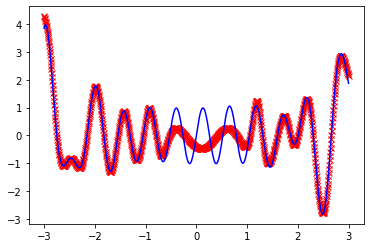

In [11]:
plt.plot(x_test,u_pred,'rx')
plt.plot(x_test,u_true,'b')

In [12]:
a = 0
for i in range(10):
    a = a + test_re_full[i][-1]
print(a/10)

0.36731655007358965
